<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=20, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    #paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_orig', type=str, default="../data/set_preprint/WWseeds_tunningPGM_set3.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/WWseeds_aligned_for_pretrained.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 

    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=100, help='number of tesselation cells') #6 80, the increasing of tess improve the performance when there are more samples to train the density estimator
    cpab.add_argument('--channels', type=int, default=100, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'

'''trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth is the one that works fine'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth'

'''this would be with the seeds samples (40 aas)'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_seeds_40aas_nov2023_4.pth'

'''for seeds samples'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug_2000iter.pth'

'''for preprint'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_21nov2023.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_22nov2023.pth'

print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=112)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


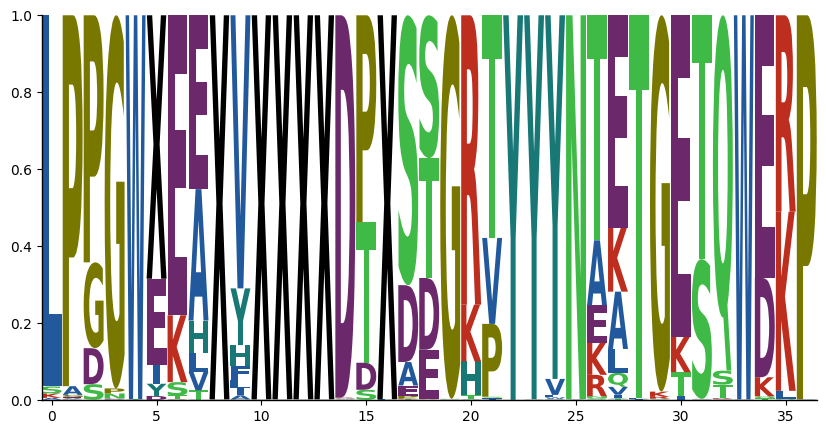

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq, 1000, 1, logdir=logdir, out_modelname=outmodel_name, beta=1 )
    #check_parameter_historic = list(deepseq.parameters())
    #2500 iters before to make it converge in a good optima
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-25,25])#[-15,15] ) #[15,15]

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1000, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=16.0, eval_epoch=10) # in iter 500 crash

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  80


Epoch 1/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:297: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:298: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Epoch 1/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.59samples/s]

Epoch 1/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.59samples/s, loss=2238.642578125]

Epoch 1/1000:  50%|█████     | 40/80 [00:04<00:03, 10.02samples/s, loss=2238.642578125]

Epoch 1/1000:  50%|█████     | 40/80 [00:04<00:03, 10.02samples/s, loss=2210.882568359375]

Epoch 1/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.29samples/s, loss=2210.882568359375]

Epoch 1/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.29samples/s, loss=2170.324951171875]

Epoch 1/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=2170.324951171875]

Epoch 1/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=2116.288818359375]

Epoch 1/1000: 100%|██████████| 80/80 [00:07<00:00, 10.11samples/s, loss=2116.288818359375]

Epoch 2/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 2/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 2/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=2112.16552734375]

Epoch 2/1000:  50%|█████     | 40/80 [00:03<00:03, 10.74samples/s, loss=2112.16552734375]

Epoch 2/1000:  50%|█████     | 40/80 [00:03<00:03, 10.74samples/s, loss=2114.820556640625]

Epoch 2/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=2114.820556640625]

Epoch 2/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=2144.693603515625]

Epoch 2/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2144.693603515625]

Epoch 2/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2145.78564453125] 

Epoch 2/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=2145.78564453125]

Epoch 3/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 3/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 3/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=2163.38037109375]

Epoch 3/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2163.38037109375]

Epoch 3/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2159.274169921875]

Epoch 3/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=2159.274169921875]

Epoch 3/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=2181.227294921875]

Epoch 3/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2181.227294921875]

Epoch 3/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2185.448974609375]

Epoch 3/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2185.448974609375]

Epoch 4/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 4/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 4/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=2176.703369140625]

Epoch 4/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2176.703369140625]

Epoch 4/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2155.807373046875]

Epoch 4/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2155.807373046875]

Epoch 4/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2182.373046875]   

Epoch 4/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2182.373046875]

Epoch 4/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2172.792724609375]

Epoch 4/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=2172.792724609375]

Epoch 5/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 5/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 5/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=2157.646484375]

Epoch 5/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=2157.646484375]

Epoch 5/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=2154.737548828125]

Epoch 5/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.56samples/s, loss=2154.737548828125]

Epoch 5/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.56samples/s, loss=2166.85009765625] 

Epoch 5/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=2166.85009765625]

Epoch 5/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=2167.12255859375]

Epoch 5/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=2167.12255859375]

Epoch 6/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 6/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 6/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=2153.078857421875]

Epoch 6/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=2153.078857421875]

Epoch 6/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=2179.804931640625]

Epoch 6/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=2179.804931640625]

Epoch 6/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=2183.070068359375]

Epoch 6/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2183.070068359375]

Epoch 6/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2163.63671875]    

Epoch 6/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=2163.63671875]

Epoch 7/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 7/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 7/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=2158.084228515625]

Epoch 7/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2158.084228515625]

Epoch 7/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2149.863037109375]

Epoch 7/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2149.863037109375]

Epoch 7/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2170.76513671875] 

Epoch 7/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=2170.76513671875]

Epoch 7/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=2171.0185546875] 

Epoch 7/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2171.0185546875]

Epoch 8/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 8/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 8/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=2159.25048828125]

Epoch 8/1000:  50%|█████     | 40/80 [00:03<00:03, 10.63samples/s, loss=2159.25048828125]

Epoch 8/1000:  50%|█████     | 40/80 [00:03<00:03, 10.63samples/s, loss=2152.87060546875]

Epoch 8/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=2152.87060546875]

Epoch 8/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=2180.005859375]  

Epoch 8/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=2180.005859375]

Epoch 8/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=2171.419189453125]

Epoch 8/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=2171.419189453125]

Epoch 9/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 9/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.86samples/s]

Epoch 9/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.86samples/s, loss=2155.619140625]

Epoch 9/1000:  50%|█████     | 40/80 [00:03<00:03, 10.44samples/s, loss=2155.619140625]

Epoch 9/1000:  50%|█████     | 40/80 [00:03<00:03, 10.44samples/s, loss=2154.98974609375]

Epoch 9/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=2154.98974609375]

Epoch 9/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=2161.669921875]  

Epoch 9/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=2161.669921875]

Epoch 9/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=2169.798828125]

Epoch 9/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=2169.798828125]

Epoch 10/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 10/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 10/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=2157.1416015625]

Epoch 10/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=2157.1416015625]

Epoch 10/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=2148.10009765625]

Epoch 10/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2148.10009765625]

Epoch 10/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2168.44140625]   

Epoch 10/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=2168.44140625]

Epoch 10/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=2163.968505859375]

Epoch 10/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2163.968505859375]

Epoch 11/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 11/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 11/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=2154.44921875]

Epoch 11/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=2154.44921875]

Epoch 11/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=2149.74365234375]

Epoch 11/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2149.74365234375]

Epoch 11/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2173.582275390625]

Epoch 11/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2173.582275390625]

Epoch 11/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2158.446533203125]

Epoch 11/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=2158.446533203125]

Epoch 12/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 12/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 12/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=2151.072998046875]

Epoch 12/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2151.072998046875]

Epoch 12/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2140.83740234375] 

Epoch 12/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=2140.83740234375]

Epoch 12/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=2162.7021484375] 

Epoch 12/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2162.7021484375]

Epoch 12/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2159.4951171875]

Epoch 12/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=2159.4951171875]

Epoch 13/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 13/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 13/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=2151.0302734375]

Epoch 13/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=2151.0302734375]

Epoch 13/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=2146.439208984375]

Epoch 13/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2146.439208984375]

Epoch 13/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2172.941162109375]

Epoch 13/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2172.941162109375]

Epoch 13/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2164.625732421875]

Epoch 13/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=2164.625732421875]

Epoch 14/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 14/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 14/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=2153.2978515625]

Epoch 14/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2153.2978515625]

Epoch 14/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2145.0966796875]

Epoch 14/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2145.0966796875]

Epoch 14/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2166.501220703125]

Epoch 14/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=2166.501220703125]

Epoch 14/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=2157.23876953125] 

Epoch 14/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=2157.23876953125]

Epoch 15/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 15/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s]

Epoch 15/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s, loss=2140.6376953125]

Epoch 15/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2140.6376953125]

Epoch 15/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2141.7216796875]

Epoch 15/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2141.7216796875]

Epoch 15/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2162.139404296875]

Epoch 15/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=2162.139404296875]

Epoch 15/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=2155.995849609375]

Epoch 15/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=2155.995849609375]

Epoch 16/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 16/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 16/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=2148.58984375]

Epoch 16/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=2148.58984375]

Epoch 16/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=2145.458251953125]

Epoch 16/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2145.458251953125]

Epoch 16/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2160.7529296875]  

Epoch 16/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=2160.7529296875]

Epoch 16/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=2164.684814453125]

Epoch 16/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=2164.684814453125]

Epoch 17/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 17/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 17/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=2146.07763671875]

Epoch 17/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2146.07763671875]

Epoch 17/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2146.775390625]  

Epoch 17/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2146.775390625]

Epoch 17/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2157.192626953125]

Epoch 17/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=2157.192626953125]

Epoch 17/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=2159.511474609375]

Epoch 17/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2159.511474609375]

Epoch 18/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 18/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 18/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=2150.65576171875]

Epoch 18/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2150.65576171875]

Epoch 18/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2147.472900390625]

Epoch 18/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=2147.472900390625]

Epoch 18/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=2167.55615234375] 

Epoch 18/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=2167.55615234375]

Epoch 18/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=2155.14990234375]

Epoch 18/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2155.14990234375]

Epoch 19/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 19/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 19/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=2151.144287109375]

Epoch 19/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2151.144287109375]

Epoch 19/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2147.0849609375]  

Epoch 19/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2147.0849609375]

Epoch 19/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2167.531494140625]

Epoch 19/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=2167.531494140625]

Epoch 19/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=2165.2099609375]  

Epoch 19/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2165.2099609375]

Epoch 20/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 20/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 20/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=2144.802490234375]

Epoch 20/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2144.802490234375]

Epoch 20/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2147.55859375]    

Epoch 20/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2147.55859375]

Epoch 20/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2161.9169921875]

Epoch 20/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2161.9169921875]

Epoch 20/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2169.21435546875]

Epoch 20/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2169.21435546875]

Epoch 21/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 21/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 21/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=2152.8818359375]

Epoch 21/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2152.8818359375]

Epoch 21/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2149.73291015625]

Epoch 21/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2149.73291015625]

Epoch 21/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2162.520263671875]

Epoch 21/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2162.520263671875]

Epoch 21/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2158.1416015625]  

Epoch 21/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=2158.1416015625]

Epoch 22/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 22/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 22/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=2151.519287109375]

Epoch 22/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2151.519287109375]

Epoch 22/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2146.12060546875] 

Epoch 22/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2146.12060546875]

Epoch 22/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2171.307861328125]

Epoch 22/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=2171.307861328125]

Epoch 22/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=2155.33056640625] 

Epoch 22/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=2155.33056640625]

Epoch 23/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 23/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.52samples/s]

Epoch 23/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.52samples/s, loss=2143.20361328125]

Epoch 23/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=2143.20361328125]

Epoch 23/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=2143.97509765625]

Epoch 23/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=2143.97509765625]

Epoch 23/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=2160.341552734375]

Epoch 23/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=2160.341552734375]

Epoch 23/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=2149.241943359375]

Epoch 23/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=2149.241943359375]

Epoch 24/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 24/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.85samples/s]

Epoch 24/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.85samples/s, loss=2149.232666015625]

Epoch 24/1000:  50%|█████     | 40/80 [00:03<00:03, 10.44samples/s, loss=2149.232666015625]

Epoch 24/1000:  50%|█████     | 40/80 [00:03<00:03, 10.44samples/s, loss=2139.049560546875]

Epoch 24/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=2139.049560546875]

Epoch 24/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=2159.717041015625]

Epoch 24/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=2159.717041015625]

Epoch 24/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=2143.601806640625]

Epoch 24/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=2143.601806640625]

Epoch 25/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 25/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 25/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=2144.506103515625]

Epoch 25/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=2144.506103515625]

Epoch 25/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=2132.13330078125] 

Epoch 25/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2132.13330078125]

Epoch 25/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2138.83447265625]

Epoch 25/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=2138.83447265625]

Epoch 25/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=2160.73779296875]

Epoch 25/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=2160.73779296875]

Epoch 26/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 26/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.85samples/s]

Epoch 26/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.85samples/s, loss=2154.767578125]

Epoch 26/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=2154.767578125]

Epoch 26/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=2145.959228515625]

Epoch 26/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=2145.959228515625]

Epoch 26/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=2146.44287109375] 

Epoch 26/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2146.44287109375]

Epoch 26/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2159.869140625]  

Epoch 26/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=2159.869140625]

Epoch 27/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 27/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 27/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=2148.75146484375]

Epoch 27/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2148.75146484375]

Epoch 27/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2154.0302734375] 

Epoch 27/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=2154.0302734375]

Epoch 27/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=2177.865966796875]

Epoch 27/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=2177.865966796875]

Epoch 27/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=2184.580810546875]

Epoch 27/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=2184.580810546875]

Epoch 28/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 28/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 28/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=2177.0576171875]

Epoch 28/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2177.0576171875]

Epoch 28/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2159.697998046875]

Epoch 28/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2159.697998046875]

Epoch 28/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2186.958984375]   

Epoch 28/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2186.958984375]

Epoch 28/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2178.127197265625]

Epoch 28/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=2178.127197265625]

Epoch 29/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 29/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s]

Epoch 29/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s, loss=2167.21435546875]

Epoch 29/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2167.21435546875]

Epoch 29/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2157.6943359375] 

Epoch 29/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2157.6943359375]

Epoch 29/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2168.019775390625]

Epoch 29/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2168.019775390625]

Epoch 29/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2177.0341796875]  

Epoch 29/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=2177.0341796875]

Epoch 30/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 30/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 30/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=2163.8876953125]

Epoch 30/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2163.8876953125]

Epoch 30/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2155.395751953125]

Epoch 30/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=2155.395751953125]

Epoch 30/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=2169.510498046875]

Epoch 30/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2169.510498046875]

Epoch 30/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2165.968017578125]

Epoch 30/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=2165.968017578125]

Epoch 31/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 31/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s]

Epoch 31/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s, loss=2162.755126953125]

Epoch 31/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2162.755126953125]

Epoch 31/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2153.233642578125]

Epoch 31/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2153.233642578125]

Epoch 31/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2169.51953125]    

Epoch 31/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=2169.51953125]

Epoch 31/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=2161.752197265625]

Epoch 31/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=2161.752197265625]

Epoch 32/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 32/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 32/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=2171.4404296875]

Epoch 32/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=2171.4404296875]

Epoch 32/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=2162.768310546875]

Epoch 32/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2162.768310546875]

Epoch 32/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2165.492919921875]

Epoch 32/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=2165.492919921875]

Epoch 32/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=2169.72119140625] 

Epoch 32/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2169.72119140625]

Epoch 33/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 33/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 33/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=2164.555419921875]

Epoch 33/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2164.555419921875]

Epoch 33/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2154.293212890625]

Epoch 33/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=2154.293212890625]

Epoch 33/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=2183.770751953125]

Epoch 33/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=2183.770751953125]

Epoch 33/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=2180.890869140625]

Epoch 33/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2180.890869140625]

Epoch 34/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 34/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 34/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=2172.866455078125]

Epoch 34/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=2172.866455078125]

Epoch 34/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=2158.97998046875] 

Epoch 34/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2158.97998046875]

Epoch 34/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2176.54248046875]

Epoch 34/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=2176.54248046875]

Epoch 34/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=2166.774169921875]

Epoch 34/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2166.774169921875]

Epoch 35/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 35/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 35/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=2148.220458984375]

Epoch 35/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2148.220458984375]

Epoch 35/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2150.9248046875]  

Epoch 35/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=2150.9248046875]

Epoch 35/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=2151.154052734375]

Epoch 35/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=2151.154052734375]

Epoch 35/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=2147.08740234375] 

Epoch 35/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2147.08740234375]

Epoch 36/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 36/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 36/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=2147.465576171875]

Epoch 36/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=2147.465576171875]

Epoch 36/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=2140.404541015625]

Epoch 36/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2140.404541015625]

Epoch 36/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2166.64306640625] 

Epoch 36/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=2166.64306640625]

Epoch 36/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=2163.549560546875]

Epoch 36/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=2163.549560546875]

Epoch 37/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 37/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 37/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=2143.12744140625]

Epoch 37/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2143.12744140625]

Epoch 37/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2134.22216796875]

Epoch 37/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2134.22216796875]

Epoch 37/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2148.707763671875]

Epoch 37/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2148.707763671875]

Epoch 37/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2153.2880859375]  

Epoch 37/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2153.2880859375]

Epoch 38/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 38/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 38/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=2103.286865234375]

Epoch 38/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=2103.286865234375]

Epoch 38/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=2086.330322265625]

Epoch 38/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2086.330322265625]

Epoch 38/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2131.906494140625]

Epoch 38/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=2131.906494140625]

Epoch 38/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=2143.61279296875] 

Epoch 38/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=2143.61279296875]

Epoch 39/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 39/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.97samples/s]

Epoch 39/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.97samples/s, loss=2136.82568359375]

Epoch 39/1000:  50%|█████     | 40/80 [00:03<00:03, 10.59samples/s, loss=2136.82568359375]

Epoch 39/1000:  50%|█████     | 40/80 [00:03<00:03, 10.59samples/s, loss=2093.123046875]  

Epoch 39/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.46samples/s, loss=2093.123046875]

Epoch 39/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.46samples/s, loss=2095.5888671875]

Epoch 39/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=2095.5888671875]

Epoch 39/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=2136.2841796875]

Epoch 39/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=2136.2841796875]

Epoch 40/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 40/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.57samples/s]

Epoch 40/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.57samples/s, loss=2143.11474609375]

Epoch 40/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=2143.11474609375]

Epoch 40/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=2155.07861328125]

Epoch 40/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=2155.07861328125]

Epoch 40/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=2142.629150390625]

Epoch 40/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=2142.629150390625]

Epoch 40/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=2123.14306640625] 

Epoch 40/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=2123.14306640625]

Epoch 41/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 41/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 41/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=2123.313232421875]

Epoch 41/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2123.313232421875]

Epoch 41/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2098.190185546875]

Epoch 41/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2098.190185546875]

Epoch 41/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2117.081787109375]

Epoch 41/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2117.081787109375]

Epoch 41/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2138.125732421875]

Epoch 41/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2138.125732421875]

Epoch 42/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 42/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 42/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=2134.41357421875]

Epoch 42/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2134.41357421875]

Epoch 42/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2128.69091796875]

Epoch 42/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=2128.69091796875]

Epoch 42/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=2141.255859375]  

Epoch 42/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=2141.255859375]

Epoch 42/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=2132.42626953125]

Epoch 42/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=2132.42626953125]

Epoch 43/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 43/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 43/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=2109.936279296875]

Epoch 43/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2109.936279296875]

Epoch 43/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2088.807373046875]

Epoch 43/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=2088.807373046875]

Epoch 43/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=2103.761474609375]

Epoch 43/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=2103.761474609375]

Epoch 43/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=2112.077880859375]

Epoch 43/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2112.077880859375]

Epoch 44/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 44/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 44/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=2091.360595703125]

Epoch 44/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=2091.360595703125]

Epoch 44/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=2089.564697265625]

Epoch 44/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2089.564697265625]

Epoch 44/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2087.471435546875]

Epoch 44/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=2087.471435546875]

Epoch 44/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=2108.63232421875] 

Epoch 44/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2108.63232421875]

Epoch 45/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 45/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 45/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=2106.009765625]

Epoch 45/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2106.009765625]

Epoch 45/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2088.335693359375]

Epoch 45/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=2088.335693359375]

Epoch 45/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=2072.572021484375]

Epoch 45/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=2072.572021484375]

Epoch 45/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=2092.209716796875]

Epoch 45/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2092.209716796875]

Epoch 46/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 46/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 46/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=2083.672119140625]

Epoch 46/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2083.672119140625]

Epoch 46/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2081.441162109375]

Epoch 46/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=2081.441162109375]

Epoch 46/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=2084.638916015625]

Epoch 46/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2084.638916015625]

Epoch 46/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2087.45263671875] 

Epoch 46/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=2087.45263671875]

Epoch 47/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 47/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 47/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=2077.877685546875]

Epoch 47/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2077.877685546875]

Epoch 47/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2093.100341796875]

Epoch 47/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2093.100341796875]

Epoch 47/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2082.4921875]     

Epoch 47/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2082.4921875]

Epoch 47/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2086.12744140625]

Epoch 47/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2086.12744140625]

Epoch 48/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 48/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s]

Epoch 48/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s, loss=2090.888916015625]

Epoch 48/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2090.888916015625]

Epoch 48/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2070.43603515625] 

Epoch 48/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=2070.43603515625]

Epoch 48/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=2073.947265625]  

Epoch 48/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2073.947265625]

Epoch 48/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2081.91650390625]

Epoch 48/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=2081.91650390625]

Epoch 49/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 49/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 49/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=2091.04443359375]

Epoch 49/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2091.04443359375]

Epoch 49/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2066.090576171875]

Epoch 49/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2066.090576171875]

Epoch 49/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2067.61474609375] 

Epoch 49/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2067.61474609375]

Epoch 49/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2073.30712890625]

Epoch 49/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=2073.30712890625]

Epoch 50/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 50/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 50/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=2079.4375]

Epoch 50/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=2079.4375]

Epoch 50/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=2078.622314453125]

Epoch 50/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2078.622314453125]

Epoch 50/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2064.062744140625]

Epoch 50/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=2064.062744140625]

Epoch 50/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=2068.14599609375] 

Epoch 50/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=2068.14599609375]

Epoch 51/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 51/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 51/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=2076.535400390625]

Epoch 51/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2076.535400390625]

Epoch 51/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2071.55126953125] 

Epoch 51/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2071.55126953125]

Epoch 51/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2066.34130859375]

Epoch 51/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2066.34130859375]

Epoch 51/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2089.126953125]  

Epoch 51/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2089.126953125]

Epoch 52/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 52/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 52/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=2087.928466796875]

Epoch 52/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2087.928466796875]

Epoch 52/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2066.45947265625] 

Epoch 52/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2066.45947265625]

Epoch 52/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2085.08837890625]

Epoch 52/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2085.08837890625]

Epoch 52/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2079.802490234375]

Epoch 52/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2079.802490234375]

Epoch 53/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 53/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 53/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=2094.947998046875]

Epoch 53/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2094.947998046875]

Epoch 53/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2047.34228515625] 

Epoch 53/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=2047.34228515625]

Epoch 53/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=2068.168701171875]

Epoch 53/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=2068.168701171875]

Epoch 53/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=2071.61474609375] 

Epoch 53/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2071.61474609375]

Epoch 54/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 54/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s]

Epoch 54/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s, loss=2062.068359375]

Epoch 54/1000:  50%|█████     | 40/80 [00:03<00:03, 10.51samples/s, loss=2062.068359375]

Epoch 54/1000:  50%|█████     | 40/80 [00:03<00:03, 10.51samples/s, loss=2073.137939453125]

Epoch 54/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=2073.137939453125]

Epoch 54/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=2061.79736328125] 

Epoch 54/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=2061.79736328125]

Epoch 54/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=2072.12109375]   

Epoch 54/1000: 100%|██████████| 80/80 [00:07<00:00, 10.25samples/s, loss=2072.12109375]

Epoch 55/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 55/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.89samples/s]

Epoch 55/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.89samples/s, loss=2060.09228515625]

Epoch 55/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2060.09228515625]

Epoch 55/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2061.33349609375]

Epoch 55/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2061.33349609375]

Epoch 55/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2085.216796875]  

Epoch 55/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=2085.216796875]

Epoch 55/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=2053.565185546875]

Epoch 55/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=2053.565185546875]

Epoch 56/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 56/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 56/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=2078.2587890625]

Epoch 56/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2078.2587890625]

Epoch 56/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2077.22412109375]

Epoch 56/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2077.22412109375]

Epoch 56/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2067.088134765625]

Epoch 56/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=2067.088134765625]

Epoch 56/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=2053.679931640625]

Epoch 56/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=2053.679931640625]

Epoch 57/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 57/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 57/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=2069.866455078125]

Epoch 57/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2069.866455078125]

Epoch 57/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2084.674560546875]

Epoch 57/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2084.674560546875]

Epoch 57/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2053.054443359375]

Epoch 57/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2053.054443359375]

Epoch 57/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2073.066650390625]

Epoch 57/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2073.066650390625]

Epoch 58/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 58/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 58/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=2086.894287109375]

Epoch 58/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2086.894287109375]

Epoch 58/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2057.6416015625]  

Epoch 58/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2057.6416015625]

Epoch 58/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2059.950927734375]

Epoch 58/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2059.950927734375]

Epoch 58/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2076.512939453125]

Epoch 58/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2076.512939453125]

Epoch 59/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 59/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 59/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=2070.189453125]

Epoch 59/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2070.189453125]

Epoch 59/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2086.195556640625]

Epoch 59/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2086.195556640625]

Epoch 59/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2061.054443359375]

Epoch 59/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2061.054443359375]

Epoch 59/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2057.805419921875]

Epoch 59/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=2057.805419921875]

Epoch 60/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 60/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 60/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=2088.2265625]

Epoch 60/1000:  50%|█████     | 40/80 [00:03<00:03, 10.68samples/s, loss=2088.2265625]

Epoch 60/1000:  50%|█████     | 40/80 [00:03<00:03, 10.68samples/s, loss=2071.54150390625]

Epoch 60/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=2071.54150390625]

Epoch 60/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=2047.1004638671875]

Epoch 60/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2047.1004638671875]

Epoch 60/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2047.6123046875]   

Epoch 60/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=2047.6123046875]

Epoch 61/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 61/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 61/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=2043.817138671875]

Epoch 61/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2043.817138671875]

Epoch 61/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2088.238525390625]

Epoch 61/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=2088.238525390625]

Epoch 61/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=2062.493408203125]

Epoch 61/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=2062.493408203125]

Epoch 61/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=2071.100830078125]

Epoch 61/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=2071.100830078125]

Epoch 62/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 62/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 62/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=2059.92236328125]

Epoch 62/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=2059.92236328125]

Epoch 62/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=2083.65478515625]

Epoch 62/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=2083.65478515625]

Epoch 62/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=2067.583251953125]

Epoch 62/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2067.583251953125]

Epoch 62/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2077.310302734375]

Epoch 62/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=2077.310302734375]

Epoch 63/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 63/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 63/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=2075.81884765625]

Epoch 63/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2075.81884765625]

Epoch 63/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2064.544921875]  

Epoch 63/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2064.544921875]

Epoch 63/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2066.009033203125]

Epoch 63/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2066.009033203125]

Epoch 63/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2059.96923828125] 

Epoch 63/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=2059.96923828125]

Epoch 64/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 64/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 64/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=2068.472900390625]

Epoch 64/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2068.472900390625]

Epoch 64/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2056.04833984375] 

Epoch 64/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2056.04833984375]

Epoch 64/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2070.738037109375]

Epoch 64/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2070.738037109375]

Epoch 64/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2065.379638671875]

Epoch 64/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=2065.379638671875]

Epoch 65/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 65/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 65/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=2039.25634765625]

Epoch 65/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2039.25634765625]

Epoch 65/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2072.92919921875]

Epoch 65/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2072.92919921875]

Epoch 65/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2077.82275390625]

Epoch 65/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2077.82275390625]

Epoch 65/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2078.7958984375] 

Epoch 65/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=2078.7958984375]

Epoch 66/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 66/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 66/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=2082.099853515625]

Epoch 66/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2082.099853515625]

Epoch 66/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2044.57763671875] 

Epoch 66/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2044.57763671875]

Epoch 66/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2045.266845703125]

Epoch 66/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2045.266845703125]

Epoch 66/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2067.6044921875]  

Epoch 66/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=2067.6044921875]

Epoch 67/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 67/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 67/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=2094.4619140625]

Epoch 67/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2094.4619140625]

Epoch 67/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2056.20703125]  

Epoch 67/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2056.20703125]

Epoch 67/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2047.438720703125]

Epoch 67/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2047.438720703125]

Epoch 67/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2044.9696044921875]

Epoch 67/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=2044.9696044921875]

Epoch 68/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 68/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 68/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=2044.4771728515625]

Epoch 68/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2044.4771728515625]

Epoch 68/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2074.41015625]     

Epoch 68/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2074.41015625]

Epoch 68/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2038.43408203125]

Epoch 68/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=2038.43408203125]

Epoch 68/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=2071.477783203125]

Epoch 68/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=2071.477783203125]

Epoch 69/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 69/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 69/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=2037.2296142578125]

Epoch 69/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=2037.2296142578125]

Epoch 69/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=2060.686767578125] 

Epoch 69/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=2060.686767578125]

Epoch 69/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=2059.848388671875]

Epoch 69/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=2059.848388671875]

Epoch 69/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=2041.5604248046875]

Epoch 69/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=2041.5604248046875]

Epoch 70/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 70/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.91samples/s]

Epoch 70/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.91samples/s, loss=2039.30810546875]

Epoch 70/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=2039.30810546875]

Epoch 70/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=2045.067626953125]

Epoch 70/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=2045.067626953125]

Epoch 70/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=2022.5592041015625]

Epoch 70/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2022.5592041015625]

Epoch 70/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2045.3681640625]   

Epoch 70/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=2045.3681640625]

Epoch 71/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 71/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 71/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=2024.148193359375]

Epoch 71/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2024.148193359375]

Epoch 71/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2028.46826171875] 

Epoch 71/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2028.46826171875]

Epoch 71/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2048.8076171875] 

Epoch 71/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2048.8076171875]

Epoch 71/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2040.5321044921875]

Epoch 71/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=2040.5321044921875]

Epoch 72/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 72/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 72/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=2053.33056640625]

Epoch 72/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2053.33056640625]

Epoch 72/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2078.820068359375]

Epoch 72/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2078.820068359375]

Epoch 72/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2044.7117919921875]

Epoch 72/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2044.7117919921875]

Epoch 72/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2032.260986328125] 

Epoch 72/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=2032.260986328125]

Epoch 73/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 73/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 73/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=2056.065185546875]

Epoch 73/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2056.065185546875]

Epoch 73/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2052.304931640625]

Epoch 73/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2052.304931640625]

Epoch 73/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2015.438232421875]

Epoch 73/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2015.438232421875]

Epoch 73/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2047.0302734375]  

Epoch 73/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=2047.0302734375]

Epoch 74/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 74/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 74/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=2061.603271484375]

Epoch 74/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2061.603271484375]

Epoch 74/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2018.4453125]     

Epoch 74/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2018.4453125]

Epoch 74/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2064.079345703125]

Epoch 74/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2064.079345703125]

Epoch 74/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2048.134033203125]

Epoch 74/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=2048.134033203125]

Epoch 75/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 75/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 75/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=2054.377197265625]

Epoch 75/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2054.377197265625]

Epoch 75/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2059.779052734375]

Epoch 75/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=2059.779052734375]

Epoch 75/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=2047.0087890625]  

Epoch 75/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=2047.0087890625]

Epoch 75/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=2046.5233154296875]

Epoch 75/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2046.5233154296875]

Epoch 76/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 76/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 76/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=2053.17529296875]

Epoch 76/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2053.17529296875]

Epoch 76/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2052.706298828125]

Epoch 76/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2052.706298828125]

Epoch 76/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2035.479248046875]

Epoch 76/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=2035.479248046875]

Epoch 76/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=2033.59375]       

Epoch 76/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=2033.59375]

Epoch 77/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 77/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 77/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=2033.0953369140625]

Epoch 77/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2033.0953369140625]

Epoch 77/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2049.01416015625]  

Epoch 77/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2049.01416015625]

Epoch 77/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2024.96142578125]

Epoch 77/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=2024.96142578125]

Epoch 77/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=2024.05419921875]

Epoch 77/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2024.05419921875]

Epoch 78/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 78/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 78/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=2034.9600830078125]

Epoch 78/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2034.9600830078125]

Epoch 78/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2068.60205078125]  

Epoch 78/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2068.60205078125]

Epoch 78/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2023.4610595703125]

Epoch 78/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2023.4610595703125]

Epoch 78/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2021.162109375]    

Epoch 78/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=2021.162109375]

Epoch 79/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 79/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 79/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=2029.767822265625]

Epoch 79/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2029.767822265625]

Epoch 79/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2024.8800048828125]

Epoch 79/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2024.8800048828125]

Epoch 79/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2015.2691650390625]

Epoch 79/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=2015.2691650390625]

Epoch 79/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=2045.3699951171875]

Epoch 79/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2045.3699951171875]

Epoch 80/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 80/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 80/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=2004.150146484375]

Epoch 80/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2004.150146484375]

Epoch 80/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2041.06884765625] 

Epoch 80/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2041.06884765625]

Epoch 80/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2009.2509765625] 

Epoch 80/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2009.2509765625]

Epoch 80/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2021.3416748046875]

Epoch 80/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2021.3416748046875]

Epoch 81/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 81/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 81/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=2021.9193115234375]

Epoch 81/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2021.9193115234375]

Epoch 81/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2059.854248046875] 

Epoch 81/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2059.854248046875]

Epoch 81/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2017.536865234375]

Epoch 81/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2017.536865234375]

Epoch 81/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2015.7889404296875]

Epoch 81/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=2015.7889404296875]

Epoch 82/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 82/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 82/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=2025.0263671875]

Epoch 82/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2025.0263671875]

Epoch 82/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2046.151123046875]

Epoch 82/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2046.151123046875]

Epoch 82/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2009.19677734375] 

Epoch 82/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2009.19677734375]

Epoch 82/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2012.627685546875]

Epoch 82/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=2012.627685546875]

Epoch 83/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 83/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 83/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=2024.953369140625]

Epoch 83/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=2024.953369140625]

Epoch 83/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=2067.4853515625]  

Epoch 83/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=2067.4853515625]

Epoch 83/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=2002.0408935546875]

Epoch 83/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=2002.0408935546875]

Epoch 83/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=2022.1278076171875]

Epoch 83/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2022.1278076171875]

Epoch 84/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 84/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.63samples/s]

Epoch 84/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.63samples/s, loss=2022.2978515625]

Epoch 84/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=2022.2978515625]

Epoch 84/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=2034.218505859375]

Epoch 84/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2034.218505859375]

Epoch 84/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2009.9869384765625]

Epoch 84/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=2009.9869384765625]

Epoch 84/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=2021.47705078125]  

Epoch 84/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=2021.47705078125]

Epoch 85/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 85/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.94samples/s]

Epoch 85/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.94samples/s, loss=2016.610595703125]

Epoch 85/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=2016.610595703125]

Epoch 85/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=2075.40625]       

Epoch 85/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.42samples/s, loss=2075.40625]

Epoch 85/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.42samples/s, loss=2005.7781982421875]

Epoch 85/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2005.7781982421875]

Epoch 85/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2035.10888671875]  

Epoch 85/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=2035.10888671875]

Epoch 86/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 86/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 86/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=2021.409423828125]

Epoch 86/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2021.409423828125]

Epoch 86/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2046.3826904296875]

Epoch 86/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2046.3826904296875]

Epoch 86/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2018.425048828125] 

Epoch 86/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2018.425048828125]

Epoch 86/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=2008.9364013671875]

Epoch 86/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2008.9364013671875]

Epoch 87/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 87/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 87/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1995.9879150390625]

Epoch 87/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1995.9879150390625]

Epoch 87/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2026.7547607421875]

Epoch 87/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2026.7547607421875]

Epoch 87/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2011.225341796875] 

Epoch 87/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=2011.225341796875]

Epoch 87/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=2014.375732421875]

Epoch 87/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2014.375732421875]

Epoch 88/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 88/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 88/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=2008.081298828125]

Epoch 88/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2008.081298828125]

Epoch 88/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2066.1806640625]  

Epoch 88/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=2066.1806640625]

Epoch 88/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=2007.785888671875]

Epoch 88/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=2007.785888671875]

Epoch 88/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=2024.9326171875]  

Epoch 88/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2024.9326171875]

Epoch 89/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 89/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 89/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=2039.4342041015625]

Epoch 89/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=2039.4342041015625]

Epoch 89/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=2020.09765625]     

Epoch 89/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=2020.09765625]

Epoch 89/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1998.6678466796875]

Epoch 89/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1998.6678466796875]

Epoch 89/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=2001.9952392578125]

Epoch 89/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2001.9952392578125]

Epoch 90/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 90/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 90/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=2013.4560546875]

Epoch 90/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=2013.4560546875]

Epoch 90/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=2034.901611328125]

Epoch 90/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=2034.901611328125]

Epoch 90/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1996.006103515625]

Epoch 90/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1996.006103515625]

Epoch 90/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=2003.147705078125]

Epoch 90/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=2003.147705078125]

Epoch 91/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 91/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s]

Epoch 91/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s, loss=2002.4188232421875]

Epoch 91/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=2002.4188232421875]

Epoch 91/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=2063.4287109375]   

Epoch 91/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=2063.4287109375]

Epoch 91/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=2001.67333984375]

Epoch 91/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=2001.67333984375]

Epoch 91/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1997.900390625]  

Epoch 91/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1997.900390625]

Epoch 92/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 92/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 92/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=2014.4986572265625]

Epoch 92/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2014.4986572265625]

Epoch 92/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2027.9775390625]   

Epoch 92/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=2027.9775390625]

Epoch 92/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=2043.0902099609375]

Epoch 92/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=2043.0902099609375]

Epoch 92/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=2004.10791015625]  

Epoch 92/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=2004.10791015625]

Epoch 93/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 93/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 93/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=2042.2698974609375]

Epoch 93/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2042.2698974609375]

Epoch 93/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2080.001708984375] 

Epoch 93/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2080.001708984375]

Epoch 93/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2025.176513671875]

Epoch 93/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=2025.176513671875]

Epoch 93/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=2021.416015625]   

Epoch 93/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=2021.416015625]

Epoch 94/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 94/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 94/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=2030.072509765625]

Epoch 94/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2030.072509765625]

Epoch 94/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2004.3885498046875]

Epoch 94/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2004.3885498046875]

Epoch 94/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=2014.384765625]    

Epoch 94/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2014.384765625]

Epoch 94/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=2004.72509765625]

Epoch 94/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=2004.72509765625]

Epoch 95/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 95/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 95/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=2019.3037109375]

Epoch 95/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2019.3037109375]

Epoch 95/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2069.324951171875]

Epoch 95/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=2069.324951171875]

Epoch 95/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1994.1790771484375]

Epoch 95/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1994.1790771484375]

Epoch 95/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=2007.5701904296875]

Epoch 95/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=2007.5701904296875]

Epoch 96/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 96/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 96/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=2007.1842041015625]

Epoch 96/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2007.1842041015625]

Epoch 96/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2033.1488037109375]

Epoch 96/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2033.1488037109375]

Epoch 96/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1982.7001953125]   

Epoch 96/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1982.7001953125]

Epoch 96/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1999.4903564453125]

Epoch 96/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1999.4903564453125]

Epoch 97/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 97/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 97/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1994.829833984375]

Epoch 97/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1994.829833984375]

Epoch 97/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2032.70703125]    

Epoch 97/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=2032.70703125]

Epoch 97/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1994.421630859375]

Epoch 97/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1994.421630859375]

Epoch 97/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1994.2850341796875]

Epoch 97/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1994.2850341796875]

Epoch 98/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 98/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 98/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=2001.4266357421875]

Epoch 98/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2001.4266357421875]

Epoch 98/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2047.6453857421875]

Epoch 98/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2047.6453857421875]

Epoch 98/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1982.442626953125] 

Epoch 98/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1982.442626953125]

Epoch 98/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1990.5126953125]  

Epoch 98/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1990.5126953125]

Epoch 99/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 99/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 99/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1993.058837890625]

Epoch 99/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1993.058837890625]

Epoch 99/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=2043.7457275390625]

Epoch 99/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=2043.7457275390625]

Epoch 99/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1995.67041015625]  

Epoch 99/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1995.67041015625]

Epoch 99/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1986.840576171875]

Epoch 99/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1986.840576171875]

Epoch 100/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 100/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s]

Epoch 100/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s, loss=1998.26171875]

Epoch 100/1000:  50%|█████     | 40/80 [00:03<00:03, 10.45samples/s, loss=1998.26171875]

Epoch 100/1000:  50%|█████     | 40/80 [00:03<00:03, 10.45samples/s, loss=2021.2034912109375]

Epoch 100/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=2021.2034912109375]

Epoch 100/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1982.2392578125]   

Epoch 100/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1982.2392578125]

Epoch 100/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1986.8436279296875]

Epoch 100/1000: 100%|██████████| 80/80 [00:07<00:00, 10.24samples/s, loss=1986.8436279296875]

Epoch 101/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 101/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 101/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1992.0369873046875]

Epoch 101/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1992.0369873046875]

Epoch 101/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2032.861572265625] 

Epoch 101/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2032.861572265625]

Epoch 101/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1983.4503173828125]

Epoch 101/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1983.4503173828125]

Epoch 101/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1989.00537109375]  

Epoch 101/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1989.00537109375]

Epoch 102/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 102/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 102/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1985.8111572265625]

Epoch 102/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1985.8111572265625]

Epoch 102/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2045.2003173828125]

Epoch 102/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2045.2003173828125]

Epoch 102/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1983.622314453125] 

Epoch 102/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1983.622314453125]

Epoch 102/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1994.8924560546875]

Epoch 102/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1994.8924560546875]

Epoch 103/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 103/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 103/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1990.47802734375]

Epoch 103/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1990.47802734375]

Epoch 103/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2031.548828125]  

Epoch 103/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=2031.548828125]

Epoch 103/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1978.9888916015625]

Epoch 103/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1978.9888916015625]

Epoch 103/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1989.4287109375]   

Epoch 103/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1989.4287109375]

Epoch 104/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 104/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 104/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1987.889404296875]

Epoch 104/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1987.889404296875]

Epoch 104/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2036.5096435546875]

Epoch 104/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2036.5096435546875]

Epoch 104/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1977.8707275390625]

Epoch 104/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1977.8707275390625]

Epoch 104/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1982.9473876953125]

Epoch 104/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1982.9473876953125]

Epoch 105/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 105/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 105/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1985.4976806640625]

Epoch 105/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1985.4976806640625]

Epoch 105/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2036.359619140625] 

Epoch 105/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2036.359619140625]

Epoch 105/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1976.609130859375]

Epoch 105/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1976.609130859375]

Epoch 105/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1986.58837890625] 

Epoch 105/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1986.58837890625]

Epoch 106/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 106/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 106/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1981.5440673828125]

Epoch 106/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1981.5440673828125]

Epoch 106/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2036.6390380859375]

Epoch 106/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2036.6390380859375]

Epoch 106/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1976.5579833984375]

Epoch 106/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1976.5579833984375]

Epoch 106/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1979.4727783203125]

Epoch 106/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1979.4727783203125]

Epoch 107/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 107/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 107/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1989.1544189453125]

Epoch 107/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1989.1544189453125]

Epoch 107/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2033.3260498046875]

Epoch 107/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=2033.3260498046875]

Epoch 107/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1980.064453125]    

Epoch 107/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1980.064453125]

Epoch 107/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1982.3143310546875]

Epoch 107/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1982.3143310546875]

Epoch 108/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 108/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 108/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1995.3990478515625]

Epoch 108/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1995.3990478515625]

Epoch 108/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2031.6937255859375]

Epoch 108/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=2031.6937255859375]

Epoch 108/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1977.7979736328125]

Epoch 108/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1977.7979736328125]

Epoch 108/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1988.4786376953125]

Epoch 108/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1988.4786376953125]

Epoch 109/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 109/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 109/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1976.38525390625]

Epoch 109/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1976.38525390625]

Epoch 109/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=2030.802734375]  

Epoch 109/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2030.802734375]

Epoch 109/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1977.6361083984375]

Epoch 109/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1977.6361083984375]

Epoch 109/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1979.2958984375]   

Epoch 109/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1979.2958984375]

Epoch 110/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 110/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 110/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1976.260498046875]

Epoch 110/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1976.260498046875]

Epoch 110/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2025.517333984375]

Epoch 110/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2025.517333984375]

Epoch 110/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1975.3692626953125]

Epoch 110/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1975.3692626953125]

Epoch 110/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1981.022705078125] 

Epoch 110/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1981.022705078125]

Epoch 111/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 111/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 111/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1985.1595458984375]

Epoch 111/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1985.1595458984375]

Epoch 111/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2037.839599609375] 

Epoch 111/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2037.839599609375]

Epoch 111/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1975.58154296875] 

Epoch 111/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1975.58154296875]

Epoch 111/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1982.2879638671875]

Epoch 111/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1982.2879638671875]

Epoch 112/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 112/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 112/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1977.69775390625]

Epoch 112/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1977.69775390625]

Epoch 112/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=2031.0946044921875]

Epoch 112/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2031.0946044921875]

Epoch 112/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1987.1500244140625]

Epoch 112/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1987.1500244140625]

Epoch 112/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1983.6793212890625]

Epoch 112/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1983.6793212890625]

Epoch 113/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 113/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 113/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1978.96240234375]

Epoch 113/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1978.96240234375]

Epoch 113/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2017.2752685546875]

Epoch 113/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2017.2752685546875]

Epoch 113/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1983.5223388671875]

Epoch 113/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1983.5223388671875]

Epoch 113/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1979.9219970703125]

Epoch 113/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1979.9219970703125]

Epoch 114/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 114/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 114/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1971.470947265625]

Epoch 114/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1971.470947265625]

Epoch 114/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=2035.0836181640625]

Epoch 114/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=2035.0836181640625]

Epoch 114/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1974.013427734375] 

Epoch 114/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1974.013427734375]

Epoch 114/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1986.5927734375]  

Epoch 114/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1986.5927734375]

Epoch 115/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 115/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.00samples/s]

Epoch 115/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.00samples/s, loss=1980.82861328125]

Epoch 115/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=1980.82861328125]

Epoch 115/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=2051.755615234375]

Epoch 115/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=2051.755615234375]

Epoch 115/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1983.56494140625] 

Epoch 115/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1983.56494140625]

Epoch 115/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1979.2110595703125]

Epoch 115/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1979.2110595703125]

Epoch 116/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 116/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.81samples/s]

Epoch 116/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.81samples/s, loss=1984.6241455078125]

Epoch 116/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1984.6241455078125]

Epoch 116/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=2018.636962890625] 

Epoch 116/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=2018.636962890625]

Epoch 116/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1976.7564697265625]

Epoch 116/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1976.7564697265625]

Epoch 116/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1981.279541015625] 

Epoch 116/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1981.279541015625]

Epoch 117/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 117/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 117/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1971.12548828125]

Epoch 117/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1971.12548828125]

Epoch 117/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2029.1436767578125]

Epoch 117/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2029.1436767578125]

Epoch 117/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1976.9248046875]   

Epoch 117/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.9248046875]

Epoch 117/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1987.4022216796875]

Epoch 117/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1987.4022216796875]

Epoch 118/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 118/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 118/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1974.419677734375]

Epoch 118/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1974.419677734375]

Epoch 118/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=2046.8004150390625]

Epoch 118/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=2046.8004150390625]

Epoch 118/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1987.3104248046875]

Epoch 118/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1987.3104248046875]

Epoch 118/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1983.1224365234375]

Epoch 118/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1983.1224365234375]

Epoch 119/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 119/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 119/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1976.1300048828125]

Epoch 119/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1976.1300048828125]

Epoch 119/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=2030.722412109375] 

Epoch 119/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2030.722412109375]

Epoch 119/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1974.2291259765625]

Epoch 119/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1974.2291259765625]

Epoch 119/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1983.020263671875] 

Epoch 119/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1983.020263671875]

Epoch 120/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 120/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 120/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1974.6358642578125]

Epoch 120/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1974.6358642578125]

Epoch 120/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2031.9124755859375]

Epoch 120/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2031.9124755859375]

Epoch 120/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1983.215087890625] 

Epoch 120/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1983.215087890625]

Epoch 120/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1982.591796875]   

Epoch 120/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1982.591796875]

Epoch 121/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 121/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 121/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1978.1304931640625]

Epoch 121/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1978.1304931640625]

Epoch 121/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=2045.9918212890625]

Epoch 121/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2045.9918212890625]

Epoch 121/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1972.8411865234375]

Epoch 121/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1972.8411865234375]

Epoch 121/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1984.0294189453125]

Epoch 121/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1984.0294189453125]

Epoch 122/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 122/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 122/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1975.50390625]

Epoch 122/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1975.50390625]

Epoch 122/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2023.5465087890625]

Epoch 122/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2023.5465087890625]

Epoch 122/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1977.8026123046875]

Epoch 122/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1977.8026123046875]

Epoch 122/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1979.1068115234375]

Epoch 122/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1979.1068115234375]

Epoch 123/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 123/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 123/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1972.2901611328125]

Epoch 123/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1972.2901611328125]

Epoch 123/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2023.9952392578125]

Epoch 123/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2023.9952392578125]

Epoch 123/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1973.552978515625] 

Epoch 123/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1973.552978515625]

Epoch 123/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1978.8153076171875]

Epoch 123/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1978.8153076171875]

Epoch 124/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 124/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 124/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1972.756103515625]

Epoch 124/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1972.756103515625]

Epoch 124/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2021.16455078125] 

Epoch 124/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=2021.16455078125]

Epoch 124/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1969.041748046875]

Epoch 124/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1969.041748046875]

Epoch 124/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1978.824462890625]

Epoch 124/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1978.824462890625]

Epoch 125/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 125/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 125/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1979.717041015625]

Epoch 125/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1979.717041015625]

Epoch 125/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=2035.946044921875]

Epoch 125/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2035.946044921875]

Epoch 125/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1973.4337158203125]

Epoch 125/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1973.4337158203125]

Epoch 125/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1981.7752685546875]

Epoch 125/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1981.7752685546875]

Epoch 126/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 126/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 126/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1975.4898681640625]

Epoch 126/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1975.4898681640625]

Epoch 126/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=2039.652587890625] 

Epoch 126/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=2039.652587890625]

Epoch 126/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1973.7244873046875]

Epoch 126/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1973.7244873046875]

Epoch 126/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1979.4656982421875]

Epoch 126/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1979.4656982421875]

Epoch 127/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 127/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 127/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1968.12255859375]

Epoch 127/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1968.12255859375]

Epoch 127/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2013.7425537109375]

Epoch 127/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2013.7425537109375]

Epoch 127/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1974.1478271484375]

Epoch 127/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1974.1478271484375]

Epoch 127/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1978.797119140625] 

Epoch 127/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1978.797119140625]

Epoch 128/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 128/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s]

Epoch 128/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s, loss=1980.7703857421875]

Epoch 128/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1980.7703857421875]

Epoch 128/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=2029.1785888671875]

Epoch 128/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=2029.1785888671875]

Epoch 128/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1976.332275390625] 

Epoch 128/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1976.332275390625]

Epoch 128/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1980.299560546875]

Epoch 128/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1980.299560546875]

Epoch 129/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 129/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 129/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1971.3663330078125]

Epoch 129/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1971.3663330078125]

Epoch 129/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=2036.468994140625] 

Epoch 129/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=2036.468994140625]

Epoch 129/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1970.416748046875]

Epoch 129/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1970.416748046875]

Epoch 129/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1984.0771484375]  

Epoch 129/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1984.0771484375]

Epoch 130/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 130/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 130/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1968.795166015625]

Epoch 130/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1968.795166015625]

Epoch 130/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=2026.0458984375]  

Epoch 130/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=2026.0458984375]

Epoch 130/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1977.1190185546875]

Epoch 130/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1977.1190185546875]

Epoch 130/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1980.8504638671875]

Epoch 130/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1980.8504638671875]

Epoch 131/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 131/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.89samples/s]

Epoch 131/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.89samples/s, loss=1969.76123046875]

Epoch 131/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1969.76123046875]

Epoch 131/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=2031.3641357421875]

Epoch 131/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=2031.3641357421875]

Epoch 131/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1971.800537109375] 

Epoch 131/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1971.800537109375]

Epoch 131/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1979.714599609375]

Epoch 131/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1979.714599609375]

Epoch 132/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 132/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 132/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1970.4237060546875]

Epoch 132/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1970.4237060546875]

Epoch 132/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=2016.486083984375] 

Epoch 132/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2016.486083984375]

Epoch 132/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1973.021484375]   

Epoch 132/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1973.021484375]

Epoch 132/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1985.839599609375]

Epoch 132/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1985.839599609375]

Epoch 133/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 133/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 133/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1978.4757080078125]

Epoch 133/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1978.4757080078125]

Epoch 133/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2042.33251953125]  

Epoch 133/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2042.33251953125]

Epoch 133/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1972.000732421875]

Epoch 133/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1972.000732421875]

Epoch 133/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1989.9619140625]  

Epoch 133/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1989.9619140625]

Epoch 134/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 134/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 134/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1980.2882080078125]

Epoch 134/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1980.2882080078125]

Epoch 134/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2028.4407958984375]

Epoch 134/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2028.4407958984375]

Epoch 134/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1979.0609130859375]

Epoch 134/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1979.0609130859375]

Epoch 134/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1993.3106689453125]

Epoch 134/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1993.3106689453125]

Epoch 135/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 135/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 135/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1971.6783447265625]

Epoch 135/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1971.6783447265625]

Epoch 135/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2023.3890380859375]

Epoch 135/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2023.3890380859375]

Epoch 135/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1973.057861328125] 

Epoch 135/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1973.057861328125]

Epoch 135/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1981.667236328125]

Epoch 135/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1981.667236328125]

Epoch 136/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 136/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 136/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1978.4857177734375]

Epoch 136/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1978.4857177734375]

Epoch 136/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2022.3148193359375]

Epoch 136/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2022.3148193359375]

Epoch 136/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1974.213623046875] 

Epoch 136/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1974.213623046875]

Epoch 136/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1984.814208984375]

Epoch 136/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1984.814208984375]

Epoch 137/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 137/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 137/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1972.7601318359375]

Epoch 137/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1972.7601318359375]

Epoch 137/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=2024.0494384765625]

Epoch 137/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2024.0494384765625]

Epoch 137/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1971.246826171875] 

Epoch 137/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1971.246826171875]

Epoch 137/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1984.4891357421875]

Epoch 137/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1984.4891357421875]

Epoch 138/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 138/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 138/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1971.8529052734375]

Epoch 138/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1971.8529052734375]

Epoch 138/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2030.9805908203125]

Epoch 138/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2030.9805908203125]

Epoch 138/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1973.210205078125] 

Epoch 138/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1973.210205078125]

Epoch 138/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1981.8299560546875]

Epoch 138/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1981.8299560546875]

Epoch 139/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 139/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 139/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1978.857421875]

Epoch 139/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1978.857421875]

Epoch 139/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2033.4105224609375]

Epoch 139/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2033.4105224609375]

Epoch 139/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1972.243408203125] 

Epoch 139/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1972.243408203125]

Epoch 139/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1981.0604248046875]

Epoch 139/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1981.0604248046875]

Epoch 140/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 140/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 140/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1983.2662353515625]

Epoch 140/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1983.2662353515625]

Epoch 140/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2021.304443359375] 

Epoch 140/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2021.304443359375]

Epoch 140/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1975.80078125]    

Epoch 140/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1975.80078125]

Epoch 140/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1983.9296875] 

Epoch 140/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1983.9296875]

Epoch 141/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 141/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 141/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1969.920654296875]

Epoch 141/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1969.920654296875]

Epoch 141/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2035.876708984375]

Epoch 141/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2035.876708984375]

Epoch 141/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1973.4415283203125]

Epoch 141/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1973.4415283203125]

Epoch 141/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1987.3201904296875]

Epoch 141/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1987.3201904296875]

Epoch 142/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 142/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 142/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1973.76904296875]

Epoch 142/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1973.76904296875]

Epoch 142/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=2020.3946533203125]

Epoch 142/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2020.3946533203125]

Epoch 142/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1976.4248046875]   

Epoch 142/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1976.4248046875]

Epoch 142/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1979.634521484375]

Epoch 142/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1979.634521484375]

Epoch 143/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 143/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 143/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1977.5611572265625]

Epoch 143/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1977.5611572265625]

Epoch 143/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2009.3973388671875]

Epoch 143/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2009.3973388671875]

Epoch 143/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1973.7310791015625]

Epoch 143/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1973.7310791015625]

Epoch 143/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1981.228271484375] 

Epoch 143/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1981.228271484375]

Epoch 144/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 144/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 144/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1971.3587646484375]

Epoch 144/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1971.3587646484375]

Epoch 144/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2019.38818359375]  

Epoch 144/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2019.38818359375]

Epoch 144/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1974.7305908203125]

Epoch 144/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1974.7305908203125]

Epoch 144/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1984.84033203125]  

Epoch 144/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1984.84033203125]

Epoch 145/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 145/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s]

Epoch 145/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s, loss=1968.5440673828125]

Epoch 145/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1968.5440673828125]

Epoch 145/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=2016.7840576171875]

Epoch 145/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=2016.7840576171875]

Epoch 145/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1974.231689453125] 

Epoch 145/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1974.231689453125]

Epoch 145/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1982.150634765625]

Epoch 145/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1982.150634765625]

Epoch 146/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 146/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.86samples/s]

Epoch 146/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.86samples/s, loss=1971.1971435546875]

Epoch 146/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1971.1971435546875]

Epoch 146/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=2023.900390625]    

Epoch 146/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.38samples/s, loss=2023.900390625]

Epoch 146/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.38samples/s, loss=1975.580810546875]

Epoch 146/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1975.580810546875]

Epoch 146/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1981.4278564453125]

Epoch 146/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=1981.4278564453125]

Epoch 147/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 147/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 147/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1974.7266845703125]

Epoch 147/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1974.7266845703125]

Epoch 147/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2024.3875732421875]

Epoch 147/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2024.3875732421875]

Epoch 147/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1973.96435546875]  

Epoch 147/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1973.96435546875]

Epoch 147/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1980.4451904296875]

Epoch 147/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1980.4451904296875]

Epoch 148/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 148/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 148/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1972.2779541015625]

Epoch 148/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1972.2779541015625]

Epoch 148/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2019.2344970703125]

Epoch 148/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=2019.2344970703125]

Epoch 148/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1974.301025390625] 

Epoch 148/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1974.301025390625]

Epoch 148/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1979.1568603515625]

Epoch 148/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1979.1568603515625]

Epoch 149/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 149/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 149/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1982.3758544921875]

Epoch 149/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1982.3758544921875]

Epoch 149/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2020.4752197265625]

Epoch 149/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2020.4752197265625]

Epoch 149/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1976.567626953125] 

Epoch 149/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1976.567626953125]

Epoch 149/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1979.328857421875]

Epoch 149/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1979.328857421875]

Epoch 150/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 150/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 150/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1972.475830078125]

Epoch 150/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1972.475830078125]

Epoch 150/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2013.4637451171875]

Epoch 150/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=2013.4637451171875]

Epoch 150/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1974.6533203125]   

Epoch 150/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1974.6533203125]

Epoch 150/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1980.7708740234375]

Epoch 150/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1980.7708740234375]

Epoch 151/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 151/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 151/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1975.06884765625]

Epoch 151/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1975.06884765625]

Epoch 151/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2013.278076171875]

Epoch 151/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2013.278076171875]

Epoch 151/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1971.2813720703125]

Epoch 151/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1971.2813720703125]

Epoch 151/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1980.568115234375] 

Epoch 151/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1980.568115234375]

Epoch 152/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 152/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 152/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1964.5205078125]

Epoch 152/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1964.5205078125]

Epoch 152/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2020.482666015625]

Epoch 152/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2020.482666015625]

Epoch 152/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1969.6859130859375]

Epoch 152/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1969.6859130859375]

Epoch 152/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1980.787353515625] 

Epoch 152/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1980.787353515625]

Epoch 153/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 153/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 153/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1967.07421875]

Epoch 153/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1967.07421875]

Epoch 153/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2013.971923828125]

Epoch 153/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2013.971923828125]

Epoch 153/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1972.4378662109375]

Epoch 153/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1972.4378662109375]

Epoch 153/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1981.1873779296875]

Epoch 153/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1981.1873779296875]

Epoch 154/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 154/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 154/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1973.1939697265625]

Epoch 154/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1973.1939697265625]

Epoch 154/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2021.29345703125]  

Epoch 154/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2021.29345703125]

Epoch 154/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1968.8043212890625]

Epoch 154/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1968.8043212890625]

Epoch 154/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1979.7147216796875]

Epoch 154/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1979.7147216796875]

Epoch 155/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 155/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 155/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1967.074951171875]

Epoch 155/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1967.074951171875]

Epoch 155/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2017.0107421875]  

Epoch 155/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2017.0107421875]

Epoch 155/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1970.341064453125]

Epoch 155/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1970.341064453125]

Epoch 155/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1980.0184326171875]

Epoch 155/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1980.0184326171875]

Epoch 156/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 156/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 156/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1973.3079833984375]

Epoch 156/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1973.3079833984375]

Epoch 156/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2029.5645751953125]

Epoch 156/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2029.5645751953125]

Epoch 156/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1970.9989013671875]

Epoch 156/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1970.9989013671875]

Epoch 156/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1985.956787109375] 

Epoch 156/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1985.956787109375]

Epoch 157/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 157/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 157/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1961.248046875]

Epoch 157/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1961.248046875]

Epoch 157/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2023.477783203125]

Epoch 157/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2023.477783203125]

Epoch 157/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1971.035400390625]

Epoch 157/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1971.035400390625]

Epoch 157/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1984.6219482421875]

Epoch 157/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1984.6219482421875]

Epoch 158/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 158/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 158/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1975.4246826171875]

Epoch 158/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1975.4246826171875]

Epoch 158/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=2008.291748046875] 

Epoch 158/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2008.291748046875]

Epoch 158/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1973.18505859375] 

Epoch 158/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1973.18505859375]

Epoch 158/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1984.4085693359375]

Epoch 158/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1984.4085693359375]

Epoch 159/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 159/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 159/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1973.232177734375]

Epoch 159/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1973.232177734375]

Epoch 159/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2003.498779296875]

Epoch 159/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2003.498779296875]

Epoch 159/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1973.0538330078125]

Epoch 159/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1973.0538330078125]

Epoch 159/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1982.0279541015625]

Epoch 159/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1982.0279541015625]

Epoch 160/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 160/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 160/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1965.900634765625]

Epoch 160/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1965.900634765625]

Epoch 160/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=2023.53466796875] 

Epoch 160/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2023.53466796875]

Epoch 160/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1974.0179443359375]

Epoch 160/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1974.0179443359375]

Epoch 160/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1981.3372802734375]

Epoch 160/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1981.3372802734375]

Epoch 161/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 161/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s]

Epoch 161/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s, loss=1968.0626220703125]

Epoch 161/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1968.0626220703125]

Epoch 161/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=2014.4793701171875]

Epoch 161/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=2014.4793701171875]

Epoch 161/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1970.7032470703125]

Epoch 161/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1970.7032470703125]

Epoch 161/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1981.1414794921875]

Epoch 161/1000: 100%|██████████| 80/80 [00:07<00:00, 10.24samples/s, loss=1981.1414794921875]

Epoch 162/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 162/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s]

Epoch 162/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s, loss=1964.2239990234375]

Epoch 162/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1964.2239990234375]

Epoch 162/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2026.0296630859375]

Epoch 162/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=2026.0296630859375]

Epoch 162/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1973.385009765625] 

Epoch 162/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1973.385009765625]

Epoch 162/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1984.21533203125] 

Epoch 162/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1984.21533203125]

Epoch 163/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 163/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 163/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1973.99951171875]

Epoch 163/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1973.99951171875]

Epoch 163/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2009.6907958984375]

Epoch 163/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=2009.6907958984375]

Epoch 163/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1978.4146728515625]

Epoch 163/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1978.4146728515625]

Epoch 163/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1979.0560302734375]

Epoch 163/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1979.0560302734375]

Epoch 164/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 164/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 164/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1974.3966064453125]

Epoch 164/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1974.3966064453125]

Epoch 164/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1997.1519775390625]

Epoch 164/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1997.1519775390625]

Epoch 164/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1971.55029296875]  

Epoch 164/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1971.55029296875]

Epoch 164/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1979.1239013671875]

Epoch 164/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1979.1239013671875]

Epoch 165/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 165/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 165/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1966.6710205078125]

Epoch 165/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1966.6710205078125]

Epoch 165/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2014.8441162109375]

Epoch 165/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2014.8441162109375]

Epoch 165/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1978.2333984375]   

Epoch 165/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1978.2333984375]

Epoch 165/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1987.2513427734375]

Epoch 165/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1987.2513427734375]

Epoch 166/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 166/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 166/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1961.6312255859375]

Epoch 166/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1961.6312255859375]

Epoch 166/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2021.98193359375]  

Epoch 166/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=2021.98193359375]

Epoch 166/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1973.1141357421875]

Epoch 166/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1973.1141357421875]

Epoch 166/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1983.438232421875] 

Epoch 166/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1983.438232421875]

Epoch 167/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 167/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 167/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1971.663330078125]

Epoch 167/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1971.663330078125]

Epoch 167/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=2013.4788818359375]

Epoch 167/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2013.4788818359375]

Epoch 167/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1974.0234375]      

Epoch 167/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1974.0234375]

Epoch 167/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1982.406982421875]

Epoch 167/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1982.406982421875]

Epoch 168/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 168/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 168/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1964.585205078125]

Epoch 168/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1964.585205078125]

Epoch 168/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1996.0009765625]  

Epoch 168/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1996.0009765625]

Epoch 168/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1972.2064208984375]

Epoch 168/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1972.2064208984375]

Epoch 168/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1980.3143310546875]

Epoch 168/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1980.3143310546875]

Epoch 169/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 169/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 169/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1963.043212890625]

Epoch 169/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1963.043212890625]

Epoch 169/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2006.7908935546875]

Epoch 169/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=2006.7908935546875]

Epoch 169/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1975.4189453125]   

Epoch 169/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1975.4189453125]

Epoch 169/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1984.6268310546875]

Epoch 169/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1984.6268310546875]

Epoch 170/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 170/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 170/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1968.5225830078125]

Epoch 170/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1968.5225830078125]

Epoch 170/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2000.9315185546875]

Epoch 170/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=2000.9315185546875]

Epoch 170/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1978.2305908203125]

Epoch 170/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1978.2305908203125]

Epoch 170/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1977.62353515625]  

Epoch 170/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1977.62353515625]

Epoch 171/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 171/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 171/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1971.0947265625]

Epoch 171/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1971.0947265625]

Epoch 171/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1993.385498046875]

Epoch 171/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1993.385498046875]

Epoch 171/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1969.98486328125] 

Epoch 171/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1969.98486328125]

Epoch 171/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1979.37890625]   

Epoch 171/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1979.37890625]

Epoch 172/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 172/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 172/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1966.6964111328125]

Epoch 172/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1966.6964111328125]

Epoch 172/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2001.192626953125] 

Epoch 172/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=2001.192626953125]

Epoch 172/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1984.8438720703125]

Epoch 172/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1984.8438720703125]

Epoch 172/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1990.13134765625]  

Epoch 172/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1990.13134765625]

Epoch 173/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 173/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 173/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1965.771484375]

Epoch 173/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1965.771484375]

Epoch 173/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=2025.9005126953125]

Epoch 173/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2025.9005126953125]

Epoch 173/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1983.12451171875]  

Epoch 173/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1983.12451171875]

Epoch 173/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1985.8377685546875]

Epoch 173/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1985.8377685546875]

Epoch 174/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 174/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 174/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1987.639892578125]

Epoch 174/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1987.639892578125]

Epoch 174/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1996.4791259765625]

Epoch 174/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1996.4791259765625]

Epoch 174/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1979.661376953125] 

Epoch 174/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1979.661376953125]

Epoch 174/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1991.777099609375]

Epoch 174/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1991.777099609375]

Epoch 175/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 175/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 175/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1971.8673095703125]

Epoch 175/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1971.8673095703125]

Epoch 175/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1993.6473388671875]

Epoch 175/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1993.6473388671875]

Epoch 175/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=2020.0130615234375]

Epoch 175/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=2020.0130615234375]

Epoch 175/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1999.5028076171875]

Epoch 175/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1999.5028076171875]

Epoch 176/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 176/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s]

Epoch 176/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s, loss=1967.8135986328125]

Epoch 176/1000:  50%|█████     | 40/80 [00:03<00:03, 10.51samples/s, loss=1967.8135986328125]

Epoch 176/1000:  50%|█████     | 40/80 [00:03<00:03, 10.51samples/s, loss=2054.998046875]    

Epoch 176/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.41samples/s, loss=2054.998046875]

Epoch 176/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.41samples/s, loss=1987.8165283203125]

Epoch 176/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1987.8165283203125]

Epoch 176/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1988.9765625]      

Epoch 176/1000: 100%|██████████| 80/80 [00:07<00:00, 10.26samples/s, loss=1988.9765625]

Epoch 177/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 177/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.93samples/s]

Epoch 177/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.93samples/s, loss=2007.4818115234375]

Epoch 177/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=2007.4818115234375]

Epoch 177/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1990.6910400390625]

Epoch 177/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1990.6910400390625]

Epoch 177/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1972.9566650390625]

Epoch 177/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1972.9566650390625]

Epoch 177/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1989.6043701171875]

Epoch 177/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1989.6043701171875]

Epoch 178/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 178/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 178/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1963.7449951171875]

Epoch 178/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1963.7449951171875]

Epoch 178/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1999.03662109375]  

Epoch 178/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1999.03662109375]

Epoch 178/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1992.8094482421875]

Epoch 178/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1992.8094482421875]

Epoch 178/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1992.658447265625] 

Epoch 178/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1992.658447265625]

Epoch 179/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 179/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.08samples/s]

Epoch 179/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.08samples/s, loss=1973.1356201171875]

Epoch 179/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1973.1356201171875]

Epoch 179/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=2043.6761474609375]

Epoch 179/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=2043.6761474609375]

Epoch 179/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1982.1917724609375]

Epoch 179/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1982.1917724609375]

Epoch 179/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1982.182861328125] 

Epoch 179/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1982.182861328125]

Epoch 180/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 180/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 180/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1984.7874755859375]

Epoch 180/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1984.7874755859375]

Epoch 180/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1997.088134765625] 

Epoch 180/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1997.088134765625]

Epoch 180/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1969.0028076171875]

Epoch 180/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1969.0028076171875]

Epoch 180/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1984.302490234375] 

Epoch 180/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1984.302490234375]

Epoch 181/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 181/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 181/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1972.748779296875]

Epoch 181/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1972.748779296875]

Epoch 181/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2004.3746337890625]

Epoch 181/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2004.3746337890625]

Epoch 181/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1980.8138427734375]

Epoch 181/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1980.8138427734375]

Epoch 181/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1986.4139404296875]

Epoch 181/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1986.4139404296875]

Epoch 182/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 182/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 182/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1968.4776611328125]

Epoch 182/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1968.4776611328125]

Epoch 182/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=2013.45361328125]  

Epoch 182/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2013.45361328125]

Epoch 182/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1976.4500732421875]

Epoch 182/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1976.4500732421875]

Epoch 182/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1982.958984375]    

Epoch 182/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1982.958984375]

Epoch 183/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 183/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 183/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1979.2357177734375]

Epoch 183/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1979.2357177734375]

Epoch 183/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1995.4593505859375]

Epoch 183/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1995.4593505859375]

Epoch 183/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1975.5174560546875]

Epoch 183/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1975.5174560546875]

Epoch 183/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1980.3848876953125]

Epoch 183/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1980.3848876953125]

Epoch 184/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 184/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 184/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1960.9058837890625]

Epoch 184/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1960.9058837890625]

Epoch 184/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1994.0823974609375]

Epoch 184/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1994.0823974609375]

Epoch 184/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1979.3065185546875]

Epoch 184/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1979.3065185546875]

Epoch 184/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1978.624267578125] 

Epoch 184/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1978.624267578125]

Epoch 185/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 185/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 185/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1968.3350830078125]

Epoch 185/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1968.3350830078125]

Epoch 185/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2015.6220703125]   

Epoch 185/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2015.6220703125]

Epoch 185/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1970.9796142578125]

Epoch 185/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1970.9796142578125]

Epoch 185/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1980.5189208984375]

Epoch 185/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1980.5189208984375]

Epoch 186/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 186/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 186/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1966.6617431640625]

Epoch 186/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1966.6617431640625]

Epoch 186/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2001.0760498046875]

Epoch 186/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2001.0760498046875]

Epoch 186/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1972.3629150390625]

Epoch 186/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1972.3629150390625]

Epoch 186/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1979.6888427734375]

Epoch 186/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1979.6888427734375]

Epoch 187/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 187/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 187/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1975.19580078125]

Epoch 187/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1975.19580078125]

Epoch 187/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=2000.0474853515625]

Epoch 187/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=2000.0474853515625]

Epoch 187/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1974.40087890625]  

Epoch 187/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1974.40087890625]

Epoch 187/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1980.68310546875]

Epoch 187/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1980.68310546875]

Epoch 188/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 188/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 188/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1964.0909423828125]

Epoch 188/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1964.0909423828125]

Epoch 188/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1992.3134765625]   

Epoch 188/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1992.3134765625]

Epoch 188/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1971.37158203125]

Epoch 188/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1971.37158203125]

Epoch 188/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1979.7916259765625]

Epoch 188/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1979.7916259765625]

Epoch 189/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 189/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 189/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1964.7801513671875]

Epoch 189/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1964.7801513671875]

Epoch 189/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=2012.3035888671875]

Epoch 189/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2012.3035888671875]

Epoch 189/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1971.49169921875]  

Epoch 189/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1971.49169921875]

Epoch 189/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1981.98876953125]

Epoch 189/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1981.98876953125]

Epoch 190/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 190/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 190/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1963.626953125]

Epoch 190/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1963.626953125]

Epoch 190/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2005.6304931640625]

Epoch 190/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=2005.6304931640625]

Epoch 190/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1974.6146240234375]

Epoch 190/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1974.6146240234375]

Epoch 190/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1979.015869140625] 

Epoch 190/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1979.015869140625]

Epoch 191/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 191/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 191/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1970.2493896484375]

Epoch 191/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1970.2493896484375]

Epoch 191/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=2003.9293212890625]

Epoch 191/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=2003.9293212890625]

Epoch 191/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1974.1082763671875]

Epoch 191/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1974.1082763671875]

Epoch 191/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1981.3529052734375]

Epoch 191/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1981.3529052734375]

Epoch 192/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 192/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.81samples/s]

Epoch 192/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.81samples/s, loss=1961.7147216796875]

Epoch 192/1000:  50%|█████     | 40/80 [00:03<00:03, 10.42samples/s, loss=1961.7147216796875]

Epoch 192/1000:  50%|█████     | 40/80 [00:03<00:03, 10.42samples/s, loss=2001.429931640625] 

Epoch 192/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=2001.429931640625]

Epoch 192/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1971.279052734375]

Epoch 192/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1971.279052734375]

Epoch 192/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1980.27392578125] 

Epoch 192/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1980.27392578125]

Epoch 193/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 193/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 193/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1963.4036865234375]

Epoch 193/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1963.4036865234375]

Epoch 193/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=2001.872314453125] 

Epoch 193/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=2001.872314453125]

Epoch 193/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1973.6904296875]  

Epoch 193/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1973.6904296875]

Epoch 193/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1980.6878662109375]

Epoch 193/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1980.6878662109375]

Epoch 194/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 194/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 194/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1963.4427490234375]

Epoch 194/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1963.4427490234375]

Epoch 194/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1998.980224609375] 

Epoch 194/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1998.980224609375]

Epoch 194/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1975.22900390625] 

Epoch 194/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1975.22900390625]

Epoch 194/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1980.6441650390625]

Epoch 194/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1980.6441650390625]

Epoch 195/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 195/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 195/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1969.7430419921875]

Epoch 195/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1969.7430419921875]

Epoch 195/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1993.9906005859375]

Epoch 195/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1993.9906005859375]

Epoch 195/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1970.187744140625] 

Epoch 195/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1970.187744140625]

Epoch 195/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1982.08544921875] 

Epoch 195/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1982.08544921875]

Epoch 196/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 196/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 196/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1961.093505859375]

Epoch 196/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1961.093505859375]

Epoch 196/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1985.7349853515625]

Epoch 196/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1985.7349853515625]

Epoch 196/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1974.1512451171875]

Epoch 196/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1974.1512451171875]

Epoch 196/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1986.567138671875] 

Epoch 196/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1986.567138671875]

Epoch 197/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 197/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 197/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1963.7445068359375]

Epoch 197/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1963.7445068359375]

Epoch 197/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1997.044677734375] 

Epoch 197/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1997.044677734375]

Epoch 197/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1969.8673095703125]

Epoch 197/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1969.8673095703125]

Epoch 197/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1986.557373046875] 

Epoch 197/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1986.557373046875]

Epoch 198/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 198/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s]

Epoch 198/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s, loss=1969.3494873046875]

Epoch 198/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1969.3494873046875]

Epoch 198/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1991.6798095703125]

Epoch 198/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1991.6798095703125]

Epoch 198/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1978.7598876953125]

Epoch 198/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1978.7598876953125]

Epoch 198/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1979.587646484375] 

Epoch 198/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1979.587646484375]

Epoch 199/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 199/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 199/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1978.6363525390625]

Epoch 199/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1978.6363525390625]

Epoch 199/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1988.972900390625] 

Epoch 199/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1988.972900390625]

Epoch 199/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1972.0616455078125]

Epoch 199/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1972.0616455078125]

Epoch 199/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1980.679931640625] 

Epoch 199/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1980.679931640625]

Epoch 200/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 200/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 200/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1964.492431640625]

Epoch 200/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1964.492431640625]

Epoch 200/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1988.350830078125]

Epoch 200/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1988.350830078125]

Epoch 200/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1976.6875]        

Epoch 200/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1976.6875]

Epoch 200/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1983.639892578125]

Epoch 200/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1983.639892578125]

Epoch 201/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 201/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 201/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1960.4100341796875]

Epoch 201/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1960.4100341796875]

Epoch 201/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2015.7523193359375]

Epoch 201/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=2015.7523193359375]

Epoch 201/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1977.8255615234375]

Epoch 201/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1977.8255615234375]

Epoch 201/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1979.478759765625] 

Epoch 201/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1979.478759765625]

Epoch 202/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 202/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 202/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1979.66845703125]

Epoch 202/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1979.66845703125]

Epoch 202/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1992.8533935546875]

Epoch 202/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1992.8533935546875]

Epoch 202/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1969.187744140625] 

Epoch 202/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1969.187744140625]

Epoch 202/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1980.3521728515625]

Epoch 202/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1980.3521728515625]

Epoch 203/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 203/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 203/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1962.3438720703125]

Epoch 203/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1962.3438720703125]

Epoch 203/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1988.7877197265625]

Epoch 203/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1988.7877197265625]

Epoch 203/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1982.8648681640625]

Epoch 203/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1982.8648681640625]

Epoch 203/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1982.643310546875] 

Epoch 203/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1982.643310546875]

Epoch 204/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 204/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s]

Epoch 204/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s, loss=1962.4493408203125]

Epoch 204/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1962.4493408203125]

Epoch 204/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=2007.7554931640625]

Epoch 204/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=2007.7554931640625]

Epoch 204/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1970.821533203125] 

Epoch 204/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1970.821533203125]

Epoch 204/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1985.037841796875]

Epoch 204/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1985.037841796875]

Epoch 205/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

From Here


Epoch 205/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 205/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1967.8856201171875]

Epoch 205/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1967.8856201171875]

Epoch 205/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1986.759033203125] 

Epoch 205/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1986.759033203125]

Epoch 205/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1981.3377685546875]

Epoch 205/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1981.3377685546875]

Epoch 205/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1983.010498046875] 

Epoch 205/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1983.010498046875]

Epoch 206/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 206/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 206/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1966.5166015625]

Epoch 206/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1966.5166015625]

Epoch 206/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1980.47119140625]

Epoch 206/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1980.47119140625]

Epoch 206/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1972.9129638671875]

Epoch 206/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1972.9129638671875]

Epoch 206/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1979.0091552734375]

Epoch 206/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1979.0091552734375]

Epoch 207/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 207/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.79samples/s]

Epoch 207/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.79samples/s, loss=1977.2135009765625]

Epoch 207/1000:  50%|█████     | 40/80 [00:03<00:03, 10.38samples/s, loss=1977.2135009765625]

Epoch 207/1000:  50%|█████     | 40/80 [00:03<00:03, 10.38samples/s, loss=2000.1865234375]   

Epoch 207/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.27samples/s, loss=2000.1865234375]

Epoch 207/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.27samples/s, loss=1974.8072509765625]

Epoch 207/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1974.8072509765625]

Epoch 207/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1985.7852783203125]

Epoch 207/1000: 100%|██████████| 80/80 [00:07<00:00, 10.23samples/s, loss=1985.7852783203125]

Epoch 208/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 208/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 208/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1961.0859375]

Epoch 208/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1961.0859375]

Epoch 208/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=2008.296630859375]

Epoch 208/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2008.296630859375]

Epoch 208/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1982.339599609375]

Epoch 208/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1982.339599609375]

Epoch 208/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1977.998779296875]

Epoch 208/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1977.998779296875]

Epoch 209/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 209/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 209/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1984.56103515625]

Epoch 209/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1984.56103515625]

Epoch 209/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1996.310791015625]

Epoch 209/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1996.310791015625]

Epoch 209/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1969.39013671875] 

Epoch 209/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1969.39013671875]

Epoch 209/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1986.3421630859375]

Epoch 209/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1986.3421630859375]

Epoch 210/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 210/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 210/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1966.2041015625]

Epoch 210/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1966.2041015625]

Epoch 210/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1995.396240234375]

Epoch 210/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1995.396240234375]

Epoch 210/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1986.49853515625] 

Epoch 210/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1986.49853515625]

Epoch 210/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1985.9095458984375]

Epoch 210/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1985.9095458984375]

Epoch 211/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 211/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s]

Epoch 211/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s, loss=1960.753173828125]

Epoch 211/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1960.753173828125]

Epoch 211/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2008.6632080078125]

Epoch 211/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2008.6632080078125]

Epoch 211/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1973.422119140625] 

Epoch 211/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1973.422119140625]

Epoch 211/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1983.0703125]     

Epoch 211/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1983.0703125]

Epoch 212/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 212/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 212/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1977.2791748046875]

Epoch 212/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1977.2791748046875]

Epoch 212/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1987.836669921875] 

Epoch 212/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1987.836669921875]

Epoch 212/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1970.56103515625] 

Epoch 212/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1970.56103515625]

Epoch 212/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1981.3743896484375]

Epoch 212/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1981.3743896484375]

Epoch 213/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 213/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s]

Epoch 213/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s, loss=1959.82373046875]

Epoch 213/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1959.82373046875]

Epoch 213/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1981.9259033203125]

Epoch 213/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1981.9259033203125]

Epoch 213/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1974.8614501953125]

Epoch 213/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1974.8614501953125]

Epoch 213/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1983.2802734375]   

Epoch 213/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1983.2802734375]

Epoch 214/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 214/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 214/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1962.2379150390625]

Epoch 214/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1962.2379150390625]

Epoch 214/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1991.4410400390625]

Epoch 214/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1991.4410400390625]

Epoch 214/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1969.8719482421875]

Epoch 214/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1969.8719482421875]

Epoch 214/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1981.6572265625]   

Epoch 214/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1981.6572265625]

Epoch 215/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 215/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 215/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1973.6861572265625]

Epoch 215/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1973.6861572265625]

Epoch 215/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1989.5225830078125]

Epoch 215/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1989.5225830078125]

Epoch 215/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1974.441650390625] 

Epoch 215/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1974.441650390625]

Epoch 215/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1980.9759521484375]

Epoch 215/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1980.9759521484375]

Epoch 216/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 216/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 216/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1967.099365234375]

Epoch 216/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1967.099365234375]

Epoch 216/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1981.8587646484375]

Epoch 216/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1981.8587646484375]

Epoch 216/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1971.197021484375] 

Epoch 216/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1971.197021484375]

Epoch 216/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1978.6304931640625]

Epoch 216/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1978.6304931640625]

Epoch 217/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 217/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 217/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1966.294677734375]

Epoch 217/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1966.294677734375]

Epoch 217/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1995.1121826171875]

Epoch 217/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1995.1121826171875]

Epoch 217/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1981.7322998046875]

Epoch 217/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1981.7322998046875]

Epoch 217/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1982.05517578125]  

Epoch 217/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1982.05517578125]

Epoch 218/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 218/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 218/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1966.1507568359375]

Epoch 218/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1966.1507568359375]

Epoch 218/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=2031.924560546875] 

Epoch 218/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=2031.924560546875]

Epoch 218/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1974.2132568359375]

Epoch 218/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1974.2132568359375]

Epoch 218/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1981.71826171875]  

Epoch 218/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1981.71826171875]

Epoch 219/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 219/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 219/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1969.10888671875]

Epoch 219/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1969.10888671875]

Epoch 219/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1984.644287109375]

Epoch 219/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1984.644287109375]

Epoch 219/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1970.306640625]   

Epoch 219/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1970.306640625]

Epoch 219/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1979.666259765625]

Epoch 219/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1979.666259765625]

Epoch 220/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 220/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s]

Epoch 220/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s, loss=1966.9947509765625]

Epoch 220/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1966.9947509765625]

Epoch 220/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1987.1134033203125]

Epoch 220/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1987.1134033203125]

Epoch 220/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1970.022705078125] 

Epoch 220/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1970.022705078125]

Epoch 220/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1980.435546875]   

Epoch 220/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1980.435546875]

Epoch 221/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 221/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 221/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1960.021484375]

Epoch 221/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1960.021484375]

Epoch 221/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1991.2620849609375]

Epoch 221/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1991.2620849609375]

Epoch 221/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1973.583984375]    

Epoch 221/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1973.583984375]

Epoch 221/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1982.1409912109375]

Epoch 221/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1982.1409912109375]

Epoch 222/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 222/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.81samples/s]

Epoch 222/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.81samples/s, loss=1961.3939208984375]

Epoch 222/1000:  50%|█████     | 40/80 [00:03<00:03, 10.42samples/s, loss=1961.3939208984375]

Epoch 222/1000:  50%|█████     | 40/80 [00:03<00:03, 10.42samples/s, loss=1987.06494140625]  

Epoch 222/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.29samples/s, loss=1987.06494140625]

Epoch 222/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.29samples/s, loss=1975.8096923828125]

Epoch 222/1000: 100%|██████████| 80/80 [00:07<00:00, 10.25samples/s, loss=1975.8096923828125]

Epoch 222/1000: 100%|██████████| 80/80 [00:07<00:00, 10.25samples/s, loss=1978.230224609375] 

Epoch 222/1000: 100%|██████████| 80/80 [00:07<00:00, 10.17samples/s, loss=1978.230224609375]

Epoch 223/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 223/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 223/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1964.8768310546875]

Epoch 223/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1964.8768310546875]

Epoch 223/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1982.3450927734375]

Epoch 223/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1982.3450927734375]

Epoch 223/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1971.697998046875] 

Epoch 223/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1971.697998046875]

Epoch 223/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1977.1568603515625]

Epoch 223/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1977.1568603515625]

Epoch 224/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 224/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 224/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1971.3135986328125]

Epoch 224/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1971.3135986328125]

Epoch 224/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1991.3804931640625]

Epoch 224/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1991.3804931640625]

Epoch 224/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1969.8448486328125]

Epoch 224/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1969.8448486328125]

Epoch 224/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1981.4727783203125]

Epoch 224/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1981.4727783203125]

Epoch 225/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 225/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 225/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1962.15185546875]

Epoch 225/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1962.15185546875]

Epoch 225/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1983.6219482421875]

Epoch 225/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1983.6219482421875]

Epoch 225/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1969.86328125]     

Epoch 225/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1969.86328125]

Epoch 225/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1985.2568359375]

Epoch 225/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1985.2568359375]

Epoch 226/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 226/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 226/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1963.32275390625]

Epoch 226/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1963.32275390625]

Epoch 226/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1984.23583984375]

Epoch 226/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1984.23583984375]

Epoch 226/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1976.9091796875] 

Epoch 226/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1976.9091796875]

Epoch 226/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1980.811767578125]

Epoch 226/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1980.811767578125]

Epoch 227/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 227/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.08samples/s]

Epoch 227/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.08samples/s, loss=1961.7127685546875]

Epoch 227/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1961.7127685546875]

Epoch 227/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1985.2601318359375]

Epoch 227/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1985.2601318359375]

Epoch 227/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1975.8834228515625]

Epoch 227/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1975.8834228515625]

Epoch 227/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1979.458740234375] 

Epoch 227/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1979.458740234375]

Epoch 228/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 228/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 228/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1960.968505859375]

Epoch 228/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1960.968505859375]

Epoch 228/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1996.6248779296875]

Epoch 228/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1996.6248779296875]

Epoch 228/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1968.8416748046875]

Epoch 228/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1968.8416748046875]

Epoch 228/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1981.376953125]    

Epoch 228/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1981.376953125]

Epoch 229/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 229/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 229/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1964.661376953125]

Epoch 229/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1964.661376953125]

Epoch 229/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1989.12841796875] 

Epoch 229/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1989.12841796875]

Epoch 229/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1976.0511474609375]

Epoch 229/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1976.0511474609375]

Epoch 229/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1985.94677734375]  

Epoch 229/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1985.94677734375]

Epoch 230/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 230/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 230/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1962.6142578125]

Epoch 230/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1962.6142578125]

Epoch 230/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1987.685546875] 

Epoch 230/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1987.685546875]

Epoch 230/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1973.26416015625]

Epoch 230/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1973.26416015625]

Epoch 230/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1977.72021484375]

Epoch 230/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1977.72021484375]

Epoch 231/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 231/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 231/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1964.38232421875]

Epoch 231/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1964.38232421875]

Epoch 231/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1993.271728515625]

Epoch 231/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1993.271728515625]

Epoch 231/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1974.11572265625] 

Epoch 231/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1974.11572265625]

Epoch 231/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1984.5855712890625]

Epoch 231/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1984.5855712890625]

Epoch 232/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 232/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s]

Epoch 232/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s, loss=1962.43701171875]

Epoch 232/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1962.43701171875]

Epoch 232/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=2007.0379638671875]

Epoch 232/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=2007.0379638671875]

Epoch 232/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1982.639404296875] 

Epoch 232/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1982.639404296875]

Epoch 232/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1979.4686279296875]

Epoch 232/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1979.4686279296875]

Epoch 233/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 233/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 233/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1978.326416015625]

Epoch 233/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1978.326416015625]

Epoch 233/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1989.51904296875] 

Epoch 233/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1989.51904296875]

Epoch 233/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1971.41943359375]

Epoch 233/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1971.41943359375]

Epoch 233/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1985.896728515625]

Epoch 233/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1985.896728515625]

Epoch 234/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 234/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 234/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1966.51708984375]

Epoch 234/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1966.51708984375]

Epoch 234/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1989.6478271484375]

Epoch 234/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1989.6478271484375]

Epoch 234/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1986.18115234375]  

Epoch 234/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1986.18115234375]

Epoch 234/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1987.920654296875]

Epoch 234/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1987.920654296875]

Epoch 235/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 235/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 235/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1960.84228515625]

Epoch 235/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1960.84228515625]

Epoch 235/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=2009.9193115234375]

Epoch 235/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2009.9193115234375]

Epoch 235/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1975.8861083984375]

Epoch 235/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1975.8861083984375]

Epoch 235/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1986.09521484375]  

Epoch 235/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1986.09521484375]

Epoch 236/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 236/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 236/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1980.86865234375]

Epoch 236/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1980.86865234375]

Epoch 236/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1999.300048828125]

Epoch 236/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1999.300048828125]

Epoch 236/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1974.7532958984375]

Epoch 236/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1974.7532958984375]

Epoch 236/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1989.4752197265625]

Epoch 236/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1989.4752197265625]

Epoch 237/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 237/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.06samples/s]

Epoch 237/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.06samples/s, loss=1963.2974853515625]

Epoch 237/1000:  50%|█████     | 40/80 [00:03<00:03, 10.56samples/s, loss=1963.2974853515625]

Epoch 237/1000:  50%|█████     | 40/80 [00:03<00:03, 10.56samples/s, loss=1991.53759765625]  

Epoch 237/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1991.53759765625]

Epoch 237/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1988.333251953125]

Epoch 237/1000: 100%|██████████| 80/80 [00:07<00:00, 10.29samples/s, loss=1988.333251953125]

Epoch 237/1000: 100%|██████████| 80/80 [00:07<00:00, 10.29samples/s, loss=1990.4527587890625]

Epoch 237/1000: 100%|██████████| 80/80 [00:07<00:00, 10.25samples/s, loss=1990.4527587890625]

Epoch 238/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 238/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s]

Epoch 238/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s, loss=1963.29150390625]

Epoch 238/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=1963.29150390625]

Epoch 238/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=2027.2957763671875]

Epoch 238/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=2027.2957763671875]

Epoch 238/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1977.003173828125] 

Epoch 238/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1977.003173828125]

Epoch 238/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1984.7039794921875]

Epoch 238/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1984.7039794921875]

Epoch 239/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 239/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 239/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1968.9434814453125]

Epoch 239/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1968.9434814453125]

Epoch 239/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1979.050048828125] 

Epoch 239/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1979.050048828125]

Epoch 239/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1969.5228271484375]

Epoch 239/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1969.5228271484375]

Epoch 239/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1983.701904296875] 

Epoch 239/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1983.701904296875]

Epoch 240/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 240/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 240/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1960.9449462890625]

Epoch 240/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1960.9449462890625]

Epoch 240/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1980.6337890625]   

Epoch 240/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1980.6337890625]

Epoch 240/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1970.405029296875]

Epoch 240/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1970.405029296875]

Epoch 240/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1981.015380859375]

Epoch 240/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1981.015380859375]

Epoch 241/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 241/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 241/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1961.3079833984375]

Epoch 241/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1961.3079833984375]

Epoch 241/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1984.1494140625]   

Epoch 241/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1984.1494140625]

Epoch 241/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1973.47021484375]

Epoch 241/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1973.47021484375]

Epoch 241/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1978.31396484375]

Epoch 241/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1978.31396484375]

Epoch 242/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 242/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 242/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1964.8048095703125]

Epoch 242/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1964.8048095703125]

Epoch 242/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1980.475341796875] 

Epoch 242/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1980.475341796875]

Epoch 242/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1970.19091796875] 

Epoch 242/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1970.19091796875]

Epoch 242/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1977.56640625]   

Epoch 242/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1977.56640625]

Epoch 243/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 243/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 243/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1964.07177734375]

Epoch 243/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1964.07177734375]

Epoch 243/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1984.67578125]   

Epoch 243/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1984.67578125]

Epoch 243/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1970.4390869140625]

Epoch 243/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1970.4390869140625]

Epoch 243/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1981.529541015625] 

Epoch 243/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1981.529541015625]

Epoch 244/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 244/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.06samples/s]

Epoch 244/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.06samples/s, loss=1963.2216796875]

Epoch 244/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1963.2216796875]

Epoch 244/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1991.5604248046875]

Epoch 244/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1991.5604248046875]

Epoch 244/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1975.203857421875] 

Epoch 244/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1975.203857421875]

Epoch 244/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1980.370361328125]

Epoch 244/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1980.370361328125]

Epoch 245/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 245/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 245/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1963.5111083984375]

Epoch 245/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1963.5111083984375]

Epoch 245/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1980.0633544921875]

Epoch 245/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1980.0633544921875]

Epoch 245/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1970.194091796875] 

Epoch 245/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1970.194091796875]

Epoch 245/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1979.877685546875]

Epoch 245/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1979.877685546875]

Epoch 246/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 246/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 246/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1967.453369140625]

Epoch 246/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1967.453369140625]

Epoch 246/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1987.010986328125]

Epoch 246/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1987.010986328125]

Epoch 246/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1976.1016845703125]

Epoch 246/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.1016845703125]

Epoch 246/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1984.7193603515625]

Epoch 246/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1984.7193603515625]

Epoch 247/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 247/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 247/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1960.213623046875]

Epoch 247/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1960.213623046875]

Epoch 247/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=2014.2637939453125]

Epoch 247/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=2014.2637939453125]

Epoch 247/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1977.0697021484375]

Epoch 247/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1977.0697021484375]

Epoch 247/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1978.3160400390625]

Epoch 247/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1978.3160400390625]

Epoch 248/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 248/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 248/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1973.549560546875]

Epoch 248/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1973.549560546875]

Epoch 248/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1995.2581787109375]

Epoch 248/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1995.2581787109375]

Epoch 248/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1970.2847900390625]

Epoch 248/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1970.2847900390625]

Epoch 248/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1982.2939453125]   

Epoch 248/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1982.2939453125]

Epoch 249/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 249/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 249/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1961.1019287109375]

Epoch 249/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1961.1019287109375]

Epoch 249/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1993.785888671875] 

Epoch 249/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1993.785888671875]

Epoch 249/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1976.21240234375] 

Epoch 249/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.21240234375]

Epoch 249/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1982.212646484375]

Epoch 249/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1982.212646484375]

Epoch 250/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 250/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 250/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1960.55224609375]

Epoch 250/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1960.55224609375]

Epoch 250/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2000.1119384765625]

Epoch 250/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2000.1119384765625]

Epoch 250/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1973.5738525390625]

Epoch 250/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1973.5738525390625]

Epoch 250/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1978.5216064453125]

Epoch 250/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1978.5216064453125]

Epoch 251/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 251/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 251/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1965.299560546875]

Epoch 251/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1965.299560546875]

Epoch 251/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1981.0775146484375]

Epoch 251/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1981.0775146484375]

Epoch 251/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1975.60693359375]  

Epoch 251/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1975.60693359375]

Epoch 251/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1978.6778564453125]

Epoch 251/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1978.6778564453125]

Epoch 252/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 252/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s]

Epoch 252/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s, loss=1960.2337646484375]

Epoch 252/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1960.2337646484375]

Epoch 252/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1988.3153076171875]

Epoch 252/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1988.3153076171875]

Epoch 252/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1974.868408203125] 

Epoch 252/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1974.868408203125]

Epoch 252/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1978.83056640625] 

Epoch 252/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1978.83056640625]

Epoch 253/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 253/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.90samples/s]

Epoch 253/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.90samples/s, loss=1960.678955078125]

Epoch 253/1000:  50%|█████     | 40/80 [00:03<00:03, 10.51samples/s, loss=1960.678955078125]

Epoch 253/1000:  50%|█████     | 40/80 [00:03<00:03, 10.51samples/s, loss=1998.3604736328125]

Epoch 253/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1998.3604736328125]

Epoch 253/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1967.6209716796875]

Epoch 253/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1967.6209716796875]

Epoch 253/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1977.8212890625]   

Epoch 253/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1977.8212890625]

Epoch 254/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 254/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 254/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1969.802001953125]

Epoch 254/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1969.802001953125]

Epoch 254/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1987.4981689453125]

Epoch 254/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1987.4981689453125]

Epoch 254/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1970.56982421875]  

Epoch 254/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1970.56982421875]

Epoch 254/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1976.634765625]  

Epoch 254/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1976.634765625]

Epoch 255/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 255/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 255/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1962.8270263671875]

Epoch 255/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1962.8270263671875]

Epoch 255/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1981.1248779296875]

Epoch 255/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1981.1248779296875]

Epoch 255/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1968.698974609375] 

Epoch 255/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1968.698974609375]

Epoch 255/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1977.33349609375] 

Epoch 255/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1977.33349609375]

Epoch 256/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 256/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 256/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1960.507568359375]

Epoch 256/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1960.507568359375]

Epoch 256/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1981.2701416015625]

Epoch 256/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1981.2701416015625]

Epoch 256/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1968.2030029296875]

Epoch 256/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1968.2030029296875]

Epoch 256/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1979.1912841796875]

Epoch 256/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1979.1912841796875]

Epoch 257/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 257/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 257/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1958.951416015625]

Epoch 257/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1958.951416015625]

Epoch 257/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1982.399169921875]

Epoch 257/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1982.399169921875]

Epoch 257/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1970.6177978515625]

Epoch 257/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1970.6177978515625]

Epoch 257/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1978.8572998046875]

Epoch 257/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1978.8572998046875]

Epoch 258/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 258/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 258/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1963.2608642578125]

Epoch 258/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1963.2608642578125]

Epoch 258/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1986.0091552734375]

Epoch 258/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1986.0091552734375]

Epoch 258/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1969.9483642578125]

Epoch 258/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1969.9483642578125]

Epoch 258/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1978.36328125]     

Epoch 258/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1978.36328125]

Epoch 259/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 259/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 259/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1959.7386474609375]

Epoch 259/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1959.7386474609375]

Epoch 259/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1978.7156982421875]

Epoch 259/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1978.7156982421875]

Epoch 259/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1971.466064453125] 

Epoch 259/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1971.466064453125]

Epoch 259/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1978.9022216796875]

Epoch 259/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1978.9022216796875]

Epoch 260/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 260/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s]

Epoch 260/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s, loss=1961.268310546875]

Epoch 260/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1961.268310546875]

Epoch 260/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1997.3531494140625]

Epoch 260/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1997.3531494140625]

Epoch 260/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1970.068115234375] 

Epoch 260/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1970.068115234375]

Epoch 260/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1978.5694580078125]

Epoch 260/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1978.5694580078125]

Epoch 261/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 261/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 261/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1962.5772705078125]

Epoch 261/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1962.5772705078125]

Epoch 261/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1990.7142333984375]

Epoch 261/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1990.7142333984375]

Epoch 261/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1968.216796875]    

Epoch 261/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1968.216796875]

Epoch 261/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1975.9739990234375]

Epoch 261/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1975.9739990234375]

Epoch 262/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 262/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 262/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1959.4437255859375]

Epoch 262/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1959.4437255859375]

Epoch 262/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1980.591552734375] 

Epoch 262/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1980.591552734375]

Epoch 262/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1969.0596923828125]

Epoch 262/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1969.0596923828125]

Epoch 262/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1982.1368408203125]

Epoch 262/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1982.1368408203125]

Epoch 263/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 263/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 263/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1959.660400390625]

Epoch 263/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1959.660400390625]

Epoch 263/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1980.664794921875]

Epoch 263/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1980.664794921875]

Epoch 263/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1971.0625]        

Epoch 263/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1971.0625]

Epoch 263/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1976.743408203125]

Epoch 263/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1976.743408203125]

Epoch 264/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 264/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 264/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1965.94140625]

Epoch 264/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1965.94140625]

Epoch 264/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1986.4122314453125]

Epoch 264/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1986.4122314453125]

Epoch 264/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1969.268798828125] 

Epoch 264/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1969.268798828125]

Epoch 264/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1978.6549072265625]

Epoch 264/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1978.6549072265625]

Epoch 265/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 265/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 265/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1965.6800537109375]

Epoch 265/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1965.6800537109375]

Epoch 265/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1990.922607421875] 

Epoch 265/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1990.922607421875]

Epoch 265/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1969.5772705078125]

Epoch 265/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1969.5772705078125]

Epoch 265/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1977.980712890625] 

Epoch 265/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.980712890625]

Epoch 266/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 266/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s]

Epoch 266/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s, loss=1959.5704345703125]

Epoch 266/1000:  50%|█████     | 40/80 [00:03<00:03, 10.74samples/s, loss=1959.5704345703125]

Epoch 266/1000:  50%|█████     | 40/80 [00:03<00:03, 10.74samples/s, loss=1982.8106689453125]

Epoch 266/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1982.8106689453125]

Epoch 266/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1971.8392333984375]

Epoch 266/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1971.8392333984375]

Epoch 266/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1978.2291259765625]

Epoch 266/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1978.2291259765625]

Epoch 267/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 267/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 267/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1965.184326171875]

Epoch 267/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1965.184326171875]

Epoch 267/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1981.1138916015625]

Epoch 267/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1981.1138916015625]

Epoch 267/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1969.0126953125]   

Epoch 267/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1969.0126953125]

Epoch 267/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1977.8653564453125]

Epoch 267/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1977.8653564453125]

Epoch 268/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 268/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.81samples/s]

Epoch 268/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.81samples/s, loss=1959.22314453125]

Epoch 268/1000:  50%|█████     | 40/80 [00:03<00:03, 10.41samples/s, loss=1959.22314453125]

Epoch 268/1000:  50%|█████     | 40/80 [00:03<00:03, 10.41samples/s, loss=1994.8095703125] 

Epoch 268/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.27samples/s, loss=1994.8095703125]

Epoch 268/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.27samples/s, loss=1975.2724609375]

Epoch 268/1000: 100%|██████████| 80/80 [00:07<00:00, 10.22samples/s, loss=1975.2724609375]

Epoch 268/1000: 100%|██████████| 80/80 [00:07<00:00, 10.22samples/s, loss=1977.5655517578125]

Epoch 268/1000: 100%|██████████| 80/80 [00:07<00:00, 10.15samples/s, loss=1977.5655517578125]

Epoch 269/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 269/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 269/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1959.7254638671875]

Epoch 269/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1959.7254638671875]

Epoch 269/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1994.1890869140625]

Epoch 269/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1994.1890869140625]

Epoch 269/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1969.502685546875] 

Epoch 269/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1969.502685546875]

Epoch 269/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1983.0369873046875]

Epoch 269/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1983.0369873046875]

Epoch 270/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 270/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 270/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1965.1878662109375]

Epoch 270/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1965.1878662109375]

Epoch 270/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1992.2861328125]   

Epoch 270/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1992.2861328125]

Epoch 270/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1969.2811279296875]

Epoch 270/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1969.2811279296875]

Epoch 270/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1978.603515625]    

Epoch 270/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1978.603515625]

Epoch 271/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 271/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s]

Epoch 271/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s, loss=1960.4068603515625]

Epoch 271/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1960.4068603515625]

Epoch 271/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1986.0274658203125]

Epoch 271/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1986.0274658203125]

Epoch 271/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1971.884033203125] 

Epoch 271/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1971.884033203125]

Epoch 271/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1981.1982421875]  

Epoch 271/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1981.1982421875]

Epoch 272/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 272/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 272/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1967.408935546875]

Epoch 272/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1967.408935546875]

Epoch 272/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1987.3360595703125]

Epoch 272/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1987.3360595703125]

Epoch 272/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1984.164306640625] 

Epoch 272/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1984.164306640625]

Epoch 272/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1993.31689453125] 

Epoch 272/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1993.31689453125]

Epoch 273/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 273/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 273/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1960.376953125]

Epoch 273/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1960.376953125]

Epoch 273/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1997.154296875]

Epoch 273/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1997.154296875]

Epoch 273/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1978.4649658203125]

Epoch 273/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1978.4649658203125]

Epoch 273/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.0889892578125]

Epoch 273/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1977.0889892578125]

Epoch 274/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 274/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.02samples/s]

Epoch 274/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.02samples/s, loss=1979.767578125]

Epoch 274/1000:  50%|█████     | 40/80 [00:03<00:03, 10.68samples/s, loss=1979.767578125]

Epoch 274/1000:  50%|█████     | 40/80 [00:03<00:03, 10.68samples/s, loss=1993.9072265625]

Epoch 274/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1993.9072265625]

Epoch 274/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1979.459716796875]

Epoch 274/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1979.459716796875]

Epoch 274/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1988.6492919921875]

Epoch 274/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1988.6492919921875]

Epoch 275/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 275/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 275/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1967.65625]

Epoch 275/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1967.65625]

Epoch 275/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1989.5535888671875]

Epoch 275/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1989.5535888671875]

Epoch 275/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1986.1654052734375]

Epoch 275/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1986.1654052734375]

Epoch 275/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1980.8001708984375]

Epoch 275/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1980.8001708984375]

Epoch 276/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 276/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 276/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1962.1461181640625]

Epoch 276/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1962.1461181640625]

Epoch 276/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=2016.5966796875]   

Epoch 276/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=2016.5966796875]

Epoch 276/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1969.676513671875]

Epoch 276/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1969.676513671875]

Epoch 276/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1980.9796142578125]

Epoch 276/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1980.9796142578125]

Epoch 277/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 277/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 277/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1978.0531005859375]

Epoch 277/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1978.0531005859375]

Epoch 277/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1981.0809326171875]

Epoch 277/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1981.0809326171875]

Epoch 277/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1976.2567138671875]

Epoch 277/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1976.2567138671875]

Epoch 277/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1981.658935546875] 

Epoch 277/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1981.658935546875]

Epoch 278/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 278/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 278/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1966.822265625]

Epoch 278/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1966.822265625]

Epoch 278/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1981.769287109375]

Epoch 278/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1981.769287109375]

Epoch 278/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1970.3004150390625]

Epoch 278/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1970.3004150390625]

Epoch 278/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1977.38330078125]  

Epoch 278/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1977.38330078125]

Epoch 279/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 279/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s]

Epoch 279/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s, loss=1963.44287109375]

Epoch 279/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1963.44287109375]

Epoch 279/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1992.9453125]    

Epoch 279/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1992.9453125]

Epoch 279/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1970.8560791015625]

Epoch 279/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1970.8560791015625]

Epoch 279/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1982.973876953125] 

Epoch 279/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1982.973876953125]

Epoch 280/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 280/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.53samples/s]

Epoch 280/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.53samples/s, loss=1961.0567626953125]

Epoch 280/1000:  50%|█████     | 40/80 [00:03<00:03, 10.51samples/s, loss=1961.0567626953125]

Epoch 280/1000:  50%|█████     | 40/80 [00:03<00:03, 10.51samples/s, loss=1986.744140625]    

Epoch 280/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1986.744140625]

Epoch 280/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1977.6856689453125]

Epoch 280/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1977.6856689453125]

Epoch 280/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1978.182373046875] 

Epoch 280/1000: 100%|██████████| 80/80 [00:07<00:00, 10.29samples/s, loss=1978.182373046875]

Epoch 281/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 281/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 281/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1970.5389404296875]

Epoch 281/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1970.5389404296875]

Epoch 281/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1985.94140625]     

Epoch 281/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1985.94140625]

Epoch 281/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1971.640869140625]

Epoch 281/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1971.640869140625]

Epoch 281/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1985.7574462890625]

Epoch 281/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1985.7574462890625]

Epoch 282/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 282/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.00samples/s]

Epoch 282/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.00samples/s, loss=1959.989013671875]

Epoch 282/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1959.989013671875]

Epoch 282/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1977.761962890625]

Epoch 282/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1977.761962890625]

Epoch 282/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1977.3524169921875]

Epoch 282/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1977.3524169921875]

Epoch 282/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1978.6658935546875]

Epoch 282/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1978.6658935546875]

Epoch 283/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 283/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s]

Epoch 283/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s, loss=1963.038818359375]

Epoch 283/1000:  50%|█████     | 40/80 [00:03<00:03, 10.45samples/s, loss=1963.038818359375]

Epoch 283/1000:  50%|█████     | 40/80 [00:03<00:03, 10.45samples/s, loss=2004.2216796875]  

Epoch 283/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.30samples/s, loss=2004.2216796875]

Epoch 283/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.30samples/s, loss=1970.9527587890625]

Epoch 283/1000: 100%|██████████| 80/80 [00:07<00:00, 10.29samples/s, loss=1970.9527587890625]

Epoch 283/1000: 100%|██████████| 80/80 [00:07<00:00, 10.29samples/s, loss=1981.091796875]    

Epoch 283/1000: 100%|██████████| 80/80 [00:07<00:00, 10.21samples/s, loss=1981.091796875]

Epoch 284/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 284/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.92samples/s]

Epoch 284/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.92samples/s, loss=1967.9266357421875]

Epoch 284/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1967.9266357421875]

Epoch 284/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1985.9727783203125]

Epoch 284/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1985.9727783203125]

Epoch 284/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1976.451416015625] 

Epoch 284/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1976.451416015625]

Epoch 284/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1982.8118896484375]

Epoch 284/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1982.8118896484375]

Epoch 285/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 285/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 285/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1960.638916015625]

Epoch 285/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1960.638916015625]

Epoch 285/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1981.6038818359375]

Epoch 285/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1981.6038818359375]

Epoch 285/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1970.887939453125] 

Epoch 285/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1970.887939453125]

Epoch 285/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1977.42431640625] 

Epoch 285/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1977.42431640625]

Epoch 286/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 286/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 286/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1958.6951904296875]

Epoch 286/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.6951904296875]

Epoch 286/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1990.4031982421875]

Epoch 286/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1990.4031982421875]

Epoch 286/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1972.1513671875]   

Epoch 286/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1972.1513671875]

Epoch 286/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1980.4708251953125]

Epoch 286/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1980.4708251953125]

Epoch 287/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 287/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 287/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1961.5623779296875]

Epoch 287/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1961.5623779296875]

Epoch 287/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1993.9541015625]   

Epoch 287/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1993.9541015625]

Epoch 287/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1972.7998046875]

Epoch 287/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1972.7998046875]

Epoch 287/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1977.72314453125]

Epoch 287/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1977.72314453125]

Epoch 288/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 288/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 288/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1964.2926025390625]

Epoch 288/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1964.2926025390625]

Epoch 288/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1982.1337890625]   

Epoch 288/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1982.1337890625]

Epoch 288/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1969.600341796875]

Epoch 288/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1969.600341796875]

Epoch 288/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1979.841064453125]

Epoch 288/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1979.841064453125]

Epoch 289/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 289/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 289/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1960.5469970703125]

Epoch 289/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1960.5469970703125]

Epoch 289/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1988.505859375]    

Epoch 289/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1988.505859375]

Epoch 289/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1974.8746337890625]

Epoch 289/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1974.8746337890625]

Epoch 289/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1980.719970703125] 

Epoch 289/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1980.719970703125]

Epoch 290/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 290/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.08samples/s]

Epoch 290/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.08samples/s, loss=1961.4603271484375]

Epoch 290/1000:  50%|█████     | 40/80 [00:03<00:03, 10.67samples/s, loss=1961.4603271484375]

Epoch 290/1000:  50%|█████     | 40/80 [00:03<00:03, 10.67samples/s, loss=1996.0916748046875]

Epoch 290/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1996.0916748046875]

Epoch 290/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1969.099365234375] 

Epoch 290/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1969.099365234375]

Epoch 290/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1977.660400390625]

Epoch 290/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1977.660400390625]

Epoch 291/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 291/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 291/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1971.0062255859375]

Epoch 291/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1971.0062255859375]

Epoch 291/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1983.0302734375]   

Epoch 291/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1983.0302734375]

Epoch 291/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1981.5435791015625]

Epoch 291/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1981.5435791015625]

Epoch 291/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1987.65673828125]  

Epoch 291/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1987.65673828125]

Epoch 292/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 292/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.95samples/s]

Epoch 292/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.95samples/s, loss=1959.125732421875]

Epoch 292/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1959.125732421875]

Epoch 292/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1985.9404296875]  

Epoch 292/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1985.9404296875]

Epoch 292/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1981.858154296875]

Epoch 292/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1981.858154296875]

Epoch 292/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1977.5836181640625]

Epoch 292/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1977.5836181640625]

Epoch 293/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 293/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 293/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1965.48974609375]

Epoch 293/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1965.48974609375]

Epoch 293/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=2006.8988037109375]

Epoch 293/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=2006.8988037109375]

Epoch 293/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1969.2669677734375]

Epoch 293/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1969.2669677734375]

Epoch 293/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1983.6361083984375]

Epoch 293/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1983.6361083984375]

Epoch 294/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 294/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 294/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1967.1591796875]

Epoch 294/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1967.1591796875]

Epoch 294/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1981.9114990234375]

Epoch 294/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1981.9114990234375]

Epoch 294/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1974.99169921875]  

Epoch 294/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1974.99169921875]

Epoch 294/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1981.7254638671875]

Epoch 294/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1981.7254638671875]

Epoch 295/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 295/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s]

Epoch 295/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s, loss=1960.89697265625]

Epoch 295/1000:  50%|█████     | 40/80 [00:03<00:03, 10.74samples/s, loss=1960.89697265625]

Epoch 295/1000:  50%|█████     | 40/80 [00:03<00:03, 10.74samples/s, loss=1986.486083984375]

Epoch 295/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1986.486083984375]

Epoch 295/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1972.6070556640625]

Epoch 295/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1972.6070556640625]

Epoch 295/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1982.99365234375]  

Epoch 295/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1982.99365234375]

Epoch 296/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 296/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 296/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1962.0228271484375]

Epoch 296/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1962.0228271484375]

Epoch 296/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1990.1109619140625]

Epoch 296/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1990.1109619140625]

Epoch 296/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1970.568603515625] 

Epoch 296/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1970.568603515625]

Epoch 296/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1980.2578125]     

Epoch 296/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1980.2578125]

Epoch 297/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 297/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 297/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1961.6795654296875]

Epoch 297/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1961.6795654296875]

Epoch 297/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1987.032958984375] 

Epoch 297/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1987.032958984375]

Epoch 297/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1971.416015625]   

Epoch 297/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1971.416015625]

Epoch 297/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1976.4676513671875]

Epoch 297/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1976.4676513671875]

Epoch 298/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 298/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.95samples/s]

Epoch 298/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.95samples/s, loss=1960.3812255859375]

Epoch 298/1000:  50%|█████     | 40/80 [00:03<00:03, 10.36samples/s, loss=1960.3812255859375]

Epoch 298/1000:  50%|█████     | 40/80 [00:03<00:03, 10.36samples/s, loss=1981.317138671875] 

Epoch 298/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.21samples/s, loss=1981.317138671875]

Epoch 298/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.21samples/s, loss=1971.255859375]   

Epoch 298/1000: 100%|██████████| 80/80 [00:07<00:00, 10.19samples/s, loss=1971.255859375]

Epoch 298/1000: 100%|██████████| 80/80 [00:07<00:00, 10.19samples/s, loss=1977.1007080078125]

Epoch 298/1000: 100%|██████████| 80/80 [00:07<00:00, 10.11samples/s, loss=1977.1007080078125]

Epoch 299/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 299/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.80samples/s]

Epoch 299/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.80samples/s, loss=1959.8668212890625]

Epoch 299/1000:  50%|█████     | 40/80 [00:03<00:03, 10.48samples/s, loss=1959.8668212890625]

Epoch 299/1000:  50%|█████     | 40/80 [00:03<00:03, 10.48samples/s, loss=1984.851806640625] 

Epoch 299/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1984.851806640625]

Epoch 299/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1968.552734375]   

Epoch 299/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1968.552734375]

Epoch 299/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1976.5953369140625]

Epoch 299/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1976.5953369140625]

Epoch 300/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 300/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 300/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1959.2000732421875]

Epoch 300/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1959.2000732421875]

Epoch 300/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1980.1971435546875]

Epoch 300/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1980.1971435546875]

Epoch 300/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1968.937744140625] 

Epoch 300/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1968.937744140625]

Epoch 300/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1977.65380859375] 

Epoch 300/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1977.65380859375]

Epoch 301/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 301/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 301/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1959.40234375]

Epoch 301/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1959.40234375]

Epoch 301/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1980.25]      

Epoch 301/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1980.25]

Epoch 301/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1968.4219970703125]

Epoch 301/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1968.4219970703125]

Epoch 301/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1980.8873291015625]

Epoch 301/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1980.8873291015625]

Epoch 302/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 302/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 302/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1968.4154052734375]

Epoch 302/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1968.4154052734375]

Epoch 302/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1981.9375]         

Epoch 302/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1981.9375]

Epoch 302/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1968.16650390625]

Epoch 302/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1968.16650390625]

Epoch 302/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1977.1748046875] 

Epoch 302/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.1748046875]

Epoch 303/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 303/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 303/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1959.0557861328125]

Epoch 303/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1959.0557861328125]

Epoch 303/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1988.0562744140625]

Epoch 303/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1988.0562744140625]

Epoch 303/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1970.869140625]    

Epoch 303/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1970.869140625]

Epoch 303/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1976.4417724609375]

Epoch 303/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1976.4417724609375]

Epoch 304/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 304/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 304/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1959.3125]

Epoch 304/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1959.3125]

Epoch 304/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1977.9287109375]

Epoch 304/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1977.9287109375]

Epoch 304/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1968.9324951171875]

Epoch 304/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1968.9324951171875]

Epoch 304/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1976.489990234375] 

Epoch 304/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1976.489990234375]

Epoch 305/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 305/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 305/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1960.8973388671875]

Epoch 305/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1960.8973388671875]

Epoch 305/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1979.6497802734375]

Epoch 305/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1979.6497802734375]

Epoch 305/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1967.88330078125]  

Epoch 305/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1967.88330078125]

Epoch 305/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.3577880859375]

Epoch 305/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1976.3577880859375]

Epoch 306/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 306/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 306/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1959.4609375]

Epoch 306/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1959.4609375]

Epoch 306/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1980.4371337890625]

Epoch 306/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1980.4371337890625]

Epoch 306/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1968.6151123046875]

Epoch 306/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1968.6151123046875]

Epoch 306/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1976.1744384765625]

Epoch 306/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1976.1744384765625]

Epoch 307/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 307/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 307/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1961.7498779296875]

Epoch 307/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1961.7498779296875]

Epoch 307/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1977.47216796875]  

Epoch 307/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1977.47216796875]

Epoch 307/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1975.1903076171875]

Epoch 307/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1975.1903076171875]

Epoch 307/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1976.7227783203125]

Epoch 307/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1976.7227783203125]

Epoch 308/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 308/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 308/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1959.2904052734375]

Epoch 308/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1959.2904052734375]

Epoch 308/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1985.6942138671875]

Epoch 308/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1985.6942138671875]

Epoch 308/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1969.76416015625]  

Epoch 308/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1969.76416015625]

Epoch 308/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1977.7513427734375]

Epoch 308/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1977.7513427734375]

Epoch 309/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 309/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 309/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1959.508544921875]

Epoch 309/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1959.508544921875]

Epoch 309/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1984.975830078125]

Epoch 309/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1984.975830078125]

Epoch 309/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1968.919677734375]

Epoch 309/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1968.919677734375]

Epoch 309/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1976.448974609375]

Epoch 309/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1976.448974609375]

Epoch 310/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 310/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 310/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1959.85205078125]

Epoch 310/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1959.85205078125]

Epoch 310/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1978.25390625]   

Epoch 310/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1978.25390625]

Epoch 310/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1967.5218505859375]

Epoch 310/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1967.5218505859375]

Epoch 310/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1980.6661376953125]

Epoch 310/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1980.6661376953125]

Epoch 311/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 311/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 311/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1959.0574951171875]

Epoch 311/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1959.0574951171875]

Epoch 311/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1978.8963623046875]

Epoch 311/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1978.8963623046875]

Epoch 311/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1973.054931640625] 

Epoch 311/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1973.054931640625]

Epoch 311/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1977.0704345703125]

Epoch 311/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1977.0704345703125]

Epoch 312/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 312/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s]

Epoch 312/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s, loss=1961.356201171875]

Epoch 312/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1961.356201171875]

Epoch 312/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1977.168212890625]

Epoch 312/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1977.168212890625]

Epoch 312/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1968.454833984375]

Epoch 312/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1968.454833984375]

Epoch 312/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1979.7061767578125]

Epoch 312/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1979.7061767578125]

Epoch 313/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 313/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 313/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1959.0517578125]

Epoch 313/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1959.0517578125]

Epoch 313/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1987.236328125] 

Epoch 313/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1987.236328125]

Epoch 313/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1972.424072265625]

Epoch 313/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=1972.424072265625]

Epoch 313/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=1977.3505859375]  

Epoch 313/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1977.3505859375]

Epoch 314/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 314/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.79samples/s]

Epoch 314/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.79samples/s, loss=1959.99560546875]

Epoch 314/1000:  50%|█████     | 40/80 [00:03<00:03, 10.44samples/s, loss=1959.99560546875]

Epoch 314/1000:  50%|█████     | 40/80 [00:03<00:03, 10.44samples/s, loss=1982.7818603515625]

Epoch 314/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.50samples/s, loss=1982.7818603515625]

Epoch 314/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.50samples/s, loss=1970.3565673828125]

Epoch 314/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1970.3565673828125]

Epoch 314/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1977.269287109375] 

Epoch 314/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1977.269287109375]

Epoch 315/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 315/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.13samples/s]

Epoch 315/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.13samples/s, loss=1965.371337890625]

Epoch 315/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1965.371337890625]

Epoch 315/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1982.114013671875]

Epoch 315/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1982.114013671875]

Epoch 315/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1975.3582763671875]

Epoch 315/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1975.3582763671875]

Epoch 315/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1980.2056884765625]

Epoch 315/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1980.2056884765625]

Epoch 316/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 316/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 316/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1960.924560546875]

Epoch 316/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1960.924560546875]

Epoch 316/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1976.690673828125]

Epoch 316/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1976.690673828125]

Epoch 316/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1971.494384765625]

Epoch 316/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1971.494384765625]

Epoch 316/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1977.43408203125] 

Epoch 316/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1977.43408203125]

Epoch 317/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 317/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 317/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1964.4991455078125]

Epoch 317/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1964.4991455078125]

Epoch 317/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1995.8509521484375]

Epoch 317/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1995.8509521484375]

Epoch 317/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1970.2557373046875]

Epoch 317/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1970.2557373046875]

Epoch 317/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1982.10693359375]  

Epoch 317/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1982.10693359375]

Epoch 318/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 318/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 318/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1960.7720947265625]

Epoch 318/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1960.7720947265625]

Epoch 318/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1992.140380859375] 

Epoch 318/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1992.140380859375]

Epoch 318/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1974.052490234375]

Epoch 318/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1974.052490234375]

Epoch 318/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1976.3453369140625]

Epoch 318/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1976.3453369140625]

Epoch 319/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 319/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 319/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1976.0867919921875]

Epoch 319/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1976.0867919921875]

Epoch 319/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1995.94775390625]  

Epoch 319/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1995.94775390625]

Epoch 319/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1973.16015625]   

Epoch 319/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1973.16015625]

Epoch 319/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1980.498779296875]

Epoch 319/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1980.498779296875]

Epoch 320/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 320/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 320/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1962.080810546875]

Epoch 320/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1962.080810546875]

Epoch 320/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1985.4324951171875]

Epoch 320/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1985.4324951171875]

Epoch 320/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1973.5672607421875]

Epoch 320/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1973.5672607421875]

Epoch 320/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1976.1361083984375]

Epoch 320/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1976.1361083984375]

Epoch 321/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 321/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 321/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1963.927001953125]

Epoch 321/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1963.927001953125]

Epoch 321/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1995.956298828125]

Epoch 321/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1995.956298828125]

Epoch 321/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1968.8052978515625]

Epoch 321/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1968.8052978515625]

Epoch 321/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1978.2315673828125]

Epoch 321/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1978.2315673828125]

Epoch 322/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 322/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 322/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1960.0325927734375]

Epoch 322/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1960.0325927734375]

Epoch 322/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1983.864013671875] 

Epoch 322/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1983.864013671875]

Epoch 322/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1970.5557861328125]

Epoch 322/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1970.5557861328125]

Epoch 322/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1977.776611328125] 

Epoch 322/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1977.776611328125]

Epoch 323/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 323/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 323/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1961.2557373046875]

Epoch 323/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1961.2557373046875]

Epoch 323/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1980.2354736328125]

Epoch 323/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1980.2354736328125]

Epoch 323/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1971.2098388671875]

Epoch 323/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1971.2098388671875]

Epoch 323/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1977.3016357421875]

Epoch 323/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1977.3016357421875]

Epoch 324/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 324/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 324/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1959.62841796875]

Epoch 324/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1959.62841796875]

Epoch 324/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1977.5960693359375]

Epoch 324/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1977.5960693359375]

Epoch 324/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1969.501708984375] 

Epoch 324/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1969.501708984375]

Epoch 324/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1978.4727783203125]

Epoch 324/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1978.4727783203125]

Epoch 325/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 325/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 325/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1960.2822265625]

Epoch 325/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1960.2822265625]

Epoch 325/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1979.64453125]  

Epoch 325/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1979.64453125]

Epoch 325/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1970.20654296875]

Epoch 325/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1970.20654296875]

Epoch 325/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1978.75439453125]

Epoch 325/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1978.75439453125]

Epoch 326/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 326/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 326/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1958.988037109375]

Epoch 326/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1958.988037109375]

Epoch 326/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1983.4339599609375]

Epoch 326/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1983.4339599609375]

Epoch 326/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1974.5540771484375]

Epoch 326/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1974.5540771484375]

Epoch 326/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1977.159423828125] 

Epoch 326/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1977.159423828125]

Epoch 327/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 327/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 327/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1965.3330078125]

Epoch 327/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1965.3330078125]

Epoch 327/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1978.0848388671875]

Epoch 327/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1978.0848388671875]

Epoch 327/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1971.040771484375] 

Epoch 327/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1971.040771484375]

Epoch 327/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1980.9656982421875]

Epoch 327/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1980.9656982421875]

Epoch 328/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 328/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s]

Epoch 328/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s, loss=1959.0362548828125]

Epoch 328/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1959.0362548828125]

Epoch 328/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1980.2274169921875]

Epoch 328/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1980.2274169921875]

Epoch 328/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1980.060791015625] 

Epoch 328/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=1980.060791015625]

Epoch 328/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=1977.056396484375]

Epoch 328/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=1977.056396484375]

Epoch 329/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 329/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.75samples/s]

Epoch 329/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.75samples/s, loss=1963.5909423828125]

Epoch 329/1000:  50%|█████     | 40/80 [00:03<00:03, 10.36samples/s, loss=1963.5909423828125]

Epoch 329/1000:  50%|█████     | 40/80 [00:03<00:03, 10.36samples/s, loss=2007.4635009765625]

Epoch 329/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.34samples/s, loss=2007.4635009765625]

Epoch 329/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.34samples/s, loss=1969.239013671875] 

Epoch 329/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1969.239013671875]

Epoch 329/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1979.2802734375]  

Epoch 329/1000: 100%|██████████| 80/80 [00:07<00:00, 10.29samples/s, loss=1979.2802734375]

Epoch 330/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 330/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 330/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1970.6888427734375]

Epoch 330/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1970.6888427734375]

Epoch 330/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1983.732177734375] 

Epoch 330/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1983.732177734375]

Epoch 330/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1992.183349609375]

Epoch 330/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1992.183349609375]

Epoch 330/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1988.7493896484375]

Epoch 330/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1988.7493896484375]

Epoch 331/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 331/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 331/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1968.8050537109375]

Epoch 331/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1968.8050537109375]

Epoch 331/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1996.8798828125]   

Epoch 331/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1996.8798828125]

Epoch 331/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1975.206298828125]

Epoch 331/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1975.206298828125]

Epoch 331/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1979.6961669921875]

Epoch 331/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1979.6961669921875]

Epoch 332/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 332/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 332/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1975.1741943359375]

Epoch 332/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1975.1741943359375]

Epoch 332/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1997.2071533203125]

Epoch 332/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.44samples/s, loss=1997.2071533203125]

Epoch 332/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.44samples/s, loss=1975.184814453125] 

Epoch 332/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1975.184814453125]

Epoch 332/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1994.0223388671875]

Epoch 332/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1994.0223388671875]

Epoch 333/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 333/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.65samples/s]

Epoch 333/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.65samples/s, loss=1964.7138671875]

Epoch 333/1000:  50%|█████     | 40/80 [00:03<00:03, 10.54samples/s, loss=1964.7138671875]

Epoch 333/1000:  50%|█████     | 40/80 [00:03<00:03, 10.54samples/s, loss=2003.1063232421875]

Epoch 333/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=2003.1063232421875]

Epoch 333/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1977.754150390625] 

Epoch 333/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1977.754150390625]

Epoch 333/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1977.2313232421875]

Epoch 333/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1977.2313232421875]

Epoch 334/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 334/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 334/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1971.3485107421875]

Epoch 334/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1971.3485107421875]

Epoch 334/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1982.3486328125]   

Epoch 334/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1982.3486328125]

Epoch 334/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1970.2247314453125]

Epoch 334/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1970.2247314453125]

Epoch 334/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1984.5521240234375]

Epoch 334/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1984.5521240234375]

Epoch 335/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 335/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 335/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1960.7235107421875]

Epoch 335/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1960.7235107421875]

Epoch 335/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1989.604736328125] 

Epoch 335/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1989.604736328125]

Epoch 335/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1986.3201904296875]

Epoch 335/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1986.3201904296875]

Epoch 335/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1985.2080078125]   

Epoch 335/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1985.2080078125]

Epoch 336/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 336/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 336/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1963.5106201171875]

Epoch 336/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1963.5106201171875]

Epoch 336/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=2000.1580810546875]

Epoch 336/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2000.1580810546875]

Epoch 336/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1974.37060546875]  

Epoch 336/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1974.37060546875]

Epoch 336/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1986.743408203125]

Epoch 336/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1986.743408203125]

Epoch 337/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 337/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 337/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1987.4249267578125]

Epoch 337/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1987.4249267578125]

Epoch 337/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1992.2105712890625]

Epoch 337/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1992.2105712890625]

Epoch 337/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1987.5517578125]   

Epoch 337/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1987.5517578125]

Epoch 337/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1989.9884033203125]

Epoch 337/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1989.9884033203125]

Epoch 338/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 338/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 338/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1961.4561767578125]

Epoch 338/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1961.4561767578125]

Epoch 338/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1982.612060546875] 

Epoch 338/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1982.612060546875]

Epoch 338/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1986.0123291015625]

Epoch 338/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1986.0123291015625]

Epoch 338/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1977.677978515625] 

Epoch 338/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1977.677978515625]

Epoch 339/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 339/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 339/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1973.9525146484375]

Epoch 339/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1973.9525146484375]

Epoch 339/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2011.1185302734375]

Epoch 339/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2011.1185302734375]

Epoch 339/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1967.8131103515625]

Epoch 339/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1967.8131103515625]

Epoch 339/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1986.070556640625] 

Epoch 339/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1986.070556640625]

Epoch 340/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 340/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 340/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1970.7261962890625]

Epoch 340/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1970.7261962890625]

Epoch 340/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1984.4957275390625]

Epoch 340/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1984.4957275390625]

Epoch 340/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1974.99853515625]  

Epoch 340/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1974.99853515625]

Epoch 340/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1980.9146728515625]

Epoch 340/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1980.9146728515625]

Epoch 341/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 341/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 341/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1961.6495361328125]

Epoch 341/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1961.6495361328125]

Epoch 341/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1981.176025390625] 

Epoch 341/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1981.176025390625]

Epoch 341/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1970.8609619140625]

Epoch 341/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1970.8609619140625]

Epoch 341/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1979.1405029296875]

Epoch 341/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1979.1405029296875]

Epoch 342/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 342/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 342/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1960.0194091796875]

Epoch 342/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1960.0194091796875]

Epoch 342/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1999.65673828125]  

Epoch 342/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1999.65673828125]

Epoch 342/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1969.91357421875]

Epoch 342/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1969.91357421875]

Epoch 342/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1978.14404296875]

Epoch 342/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1978.14404296875]

Epoch 343/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 343/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.58samples/s]

Epoch 343/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.58samples/s, loss=1961.6182861328125]

Epoch 343/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1961.6182861328125]

Epoch 343/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1988.401123046875] 

Epoch 343/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1988.401123046875]

Epoch 343/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1970.2022705078125]

Epoch 343/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1970.2022705078125]

Epoch 343/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1977.0830078125]   

Epoch 343/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1977.0830078125]

Epoch 344/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 344/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.86samples/s]

Epoch 344/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.86samples/s, loss=1963.591796875]

Epoch 344/1000:  50%|█████     | 40/80 [00:03<00:03, 10.46samples/s, loss=1963.591796875]

Epoch 344/1000:  50%|█████     | 40/80 [00:03<00:03, 10.46samples/s, loss=1976.279541015625]

Epoch 344/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.22samples/s, loss=1976.279541015625]

Epoch 344/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.22samples/s, loss=1969.185302734375]

Epoch 344/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1969.185302734375]

Epoch 344/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1978.6571044921875]

Epoch 344/1000: 100%|██████████| 80/80 [00:07<00:00, 10.29samples/s, loss=1978.6571044921875]

Epoch 345/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 345/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s]

Epoch 345/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s, loss=1959.8302001953125]

Epoch 345/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1959.8302001953125]

Epoch 345/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1975.1807861328125]

Epoch 345/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1975.1807861328125]

Epoch 345/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1969.1580810546875]

Epoch 345/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1969.1580810546875]

Epoch 345/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1978.8385009765625]

Epoch 345/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1978.8385009765625]

Epoch 346/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 346/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 346/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1959.0557861328125]

Epoch 346/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1959.0557861328125]

Epoch 346/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1984.5794677734375]

Epoch 346/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1984.5794677734375]

Epoch 346/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1968.851318359375] 

Epoch 346/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1968.851318359375]

Epoch 346/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1977.7203369140625]

Epoch 346/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1977.7203369140625]

Epoch 347/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 347/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 347/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1960.27001953125]

Epoch 347/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1960.27001953125]

Epoch 347/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1979.060546875]  

Epoch 347/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1979.060546875]

Epoch 347/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1973.7532958984375]

Epoch 347/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1973.7532958984375]

Epoch 347/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1978.3282470703125]

Epoch 347/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1978.3282470703125]

Epoch 348/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 348/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 348/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1963.26025390625]

Epoch 348/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1963.26025390625]

Epoch 348/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1976.416015625]  

Epoch 348/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1976.416015625]

Epoch 348/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1970.3265380859375]

Epoch 348/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1970.3265380859375]

Epoch 348/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1981.4119873046875]

Epoch 348/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1981.4119873046875]

Epoch 349/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 349/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 349/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1959.4586181640625]

Epoch 349/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1959.4586181640625]

Epoch 349/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1976.5423583984375]

Epoch 349/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1976.5423583984375]

Epoch 349/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1973.9947509765625]

Epoch 349/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1973.9947509765625]

Epoch 349/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1977.3101806640625]

Epoch 349/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1977.3101806640625]

Epoch 350/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 350/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 350/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1961.4144287109375]

Epoch 350/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1961.4144287109375]

Epoch 350/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1989.5059814453125]

Epoch 350/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1989.5059814453125]

Epoch 350/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1971.336669921875] 

Epoch 350/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1971.336669921875]

Epoch 350/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1978.0931396484375]

Epoch 350/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1978.0931396484375]

Epoch 351/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 351/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 351/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1966.9293212890625]

Epoch 351/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1966.9293212890625]

Epoch 351/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1975.9971923828125]

Epoch 351/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1975.9971923828125]

Epoch 351/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1985.7109375]      

Epoch 351/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1985.7109375]

Epoch 351/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1985.9814453125]

Epoch 351/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1985.9814453125]

Epoch 352/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 352/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 352/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1964.7694091796875]

Epoch 352/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1964.7694091796875]

Epoch 352/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1977.1190185546875]

Epoch 352/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1977.1190185546875]

Epoch 352/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1969.6063232421875]

Epoch 352/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1969.6063232421875]

Epoch 352/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1980.2972412109375]

Epoch 352/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1980.2972412109375]

Epoch 353/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 353/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 353/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1964.95361328125]

Epoch 353/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1964.95361328125]

Epoch 353/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1982.26806640625]

Epoch 353/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1982.26806640625]

Epoch 353/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1975.7662353515625]

Epoch 353/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1975.7662353515625]

Epoch 353/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1986.7322998046875]

Epoch 353/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1986.7322998046875]

Epoch 354/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 354/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 354/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1961.9913330078125]

Epoch 354/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1961.9913330078125]

Epoch 354/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1995.436767578125] 

Epoch 354/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1995.436767578125]

Epoch 354/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1980.348388671875]

Epoch 354/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1980.348388671875]

Epoch 354/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.838623046875]

Epoch 354/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1976.838623046875]

Epoch 355/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 355/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 355/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1983.79052734375]

Epoch 355/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1983.79052734375]

Epoch 355/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1982.54833984375]

Epoch 355/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1982.54833984375]

Epoch 355/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1972.3133544921875]

Epoch 355/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1972.3133544921875]

Epoch 355/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1992.9405517578125]

Epoch 355/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1992.9405517578125]

Epoch 356/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 356/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 356/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1964.81201171875]

Epoch 356/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1964.81201171875]

Epoch 356/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1977.3590087890625]

Epoch 356/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1977.3590087890625]

Epoch 356/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1996.75390625]     

Epoch 356/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1996.75390625]

Epoch 356/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1994.07568359375]

Epoch 356/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1994.07568359375]

Epoch 357/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 357/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 357/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1960.0391845703125]

Epoch 357/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1960.0391845703125]

Epoch 357/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=2008.518798828125] 

Epoch 357/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=2008.518798828125]

Epoch 357/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1978.8450927734375]

Epoch 357/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1978.8450927734375]

Epoch 357/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1977.653564453125] 

Epoch 357/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1977.653564453125]

Epoch 358/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 358/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 358/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1988.4573974609375]

Epoch 358/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1988.4573974609375]

Epoch 358/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=2002.6549072265625]

Epoch 358/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2002.6549072265625]

Epoch 358/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1971.99853515625]  

Epoch 358/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1971.99853515625]

Epoch 358/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1991.4691162109375]

Epoch 358/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1991.4691162109375]

Epoch 359/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 359/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.77samples/s]

Epoch 359/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.77samples/s, loss=1968.426513671875]

Epoch 359/1000:  50%|█████     | 40/80 [00:03<00:03, 10.40samples/s, loss=1968.426513671875]

Epoch 359/1000:  50%|█████     | 40/80 [00:03<00:03, 10.40samples/s, loss=1978.845947265625]

Epoch 359/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.30samples/s, loss=1978.845947265625]

Epoch 359/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.30samples/s, loss=1973.8316650390625]

Epoch 359/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1973.8316650390625]

Epoch 359/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1980.6865234375]   

Epoch 359/1000: 100%|██████████| 80/80 [00:07<00:00, 10.22samples/s, loss=1980.6865234375]

Epoch 360/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 360/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 360/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1959.689697265625]

Epoch 360/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1959.689697265625]

Epoch 360/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1991.906982421875]

Epoch 360/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1991.906982421875]

Epoch 360/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1969.30126953125] 

Epoch 360/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1969.30126953125]

Epoch 360/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1981.1710205078125]

Epoch 360/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1981.1710205078125]

Epoch 361/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 361/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 361/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1973.0599365234375]

Epoch 361/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1973.0599365234375]

Epoch 361/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1970.22900390625]  

Epoch 361/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1970.22900390625]

Epoch 361/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1970.84521484375]

Epoch 361/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1970.84521484375]

Epoch 361/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1977.4305419921875]

Epoch 361/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.4305419921875]

Epoch 362/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 362/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 362/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1960.511474609375]

Epoch 362/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1960.511474609375]

Epoch 362/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1969.544677734375]

Epoch 362/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1969.544677734375]

Epoch 362/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1969.362060546875]

Epoch 362/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1969.362060546875]

Epoch 362/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1976.7227783203125]

Epoch 362/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1976.7227783203125]

Epoch 363/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 363/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 363/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1962.180419921875]

Epoch 363/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1962.180419921875]

Epoch 363/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1973.3284912109375]

Epoch 363/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1973.3284912109375]

Epoch 363/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1974.1324462890625]

Epoch 363/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1974.1324462890625]

Epoch 363/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1978.5347900390625]

Epoch 363/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1978.5347900390625]

Epoch 364/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 364/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 364/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1963.2825927734375]

Epoch 364/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1963.2825927734375]

Epoch 364/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1969.06982421875]  

Epoch 364/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1969.06982421875]

Epoch 364/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1970.8387451171875]

Epoch 364/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1970.8387451171875]

Epoch 364/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1981.2840576171875]

Epoch 364/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1981.2840576171875]

Epoch 365/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 365/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s]

Epoch 365/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s, loss=1962.8609619140625]

Epoch 365/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=1962.8609619140625]

Epoch 365/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=1968.8529052734375]

Epoch 365/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1968.8529052734375]

Epoch 365/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1975.006591796875] 

Epoch 365/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1975.006591796875]

Epoch 365/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1981.828369140625]

Epoch 365/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1981.828369140625]

Epoch 366/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 366/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 366/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1963.9716796875]

Epoch 366/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1963.9716796875]

Epoch 366/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1983.693359375] 

Epoch 366/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1983.693359375]

Epoch 366/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1970.071044921875]

Epoch 366/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1970.071044921875]

Epoch 366/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1977.05615234375] 

Epoch 366/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1977.05615234375]

Epoch 367/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 367/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 367/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1970.73046875]

Epoch 367/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1970.73046875]

Epoch 367/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1968.1373291015625]

Epoch 367/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1968.1373291015625]

Epoch 367/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1974.672607421875] 

Epoch 367/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1974.672607421875]

Epoch 367/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1989.39013671875] 

Epoch 367/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1989.39013671875]

Epoch 368/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 368/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 368/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1959.8770751953125]

Epoch 368/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1959.8770751953125]

Epoch 368/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1961.3082275390625]

Epoch 368/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1961.3082275390625]

Epoch 368/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1973.7667236328125]

Epoch 368/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1973.7667236328125]

Epoch 368/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1978.498779296875] 

Epoch 368/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1978.498779296875]

Epoch 369/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 369/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 369/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1963.2247314453125]

Epoch 369/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1963.2247314453125]

Epoch 369/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1981.8076171875]   

Epoch 369/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1981.8076171875]

Epoch 369/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1969.2255859375]

Epoch 369/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1969.2255859375]

Epoch 369/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1981.3701171875]

Epoch 369/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1981.3701171875]

Epoch 370/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 370/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 370/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1965.031005859375]

Epoch 370/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1965.031005859375]

Epoch 370/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1964.2962646484375]

Epoch 370/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1964.2962646484375]

Epoch 370/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1977.2147216796875]

Epoch 370/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1977.2147216796875]

Epoch 370/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1982.44677734375]  

Epoch 370/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1982.44677734375]

Epoch 371/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 371/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 371/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1962.9022216796875]

Epoch 371/1000:  50%|█████     | 40/80 [00:03<00:03, 10.60samples/s, loss=1962.9022216796875]

Epoch 371/1000:  50%|█████     | 40/80 [00:03<00:03, 10.60samples/s, loss=1969.4879150390625]

Epoch 371/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.40samples/s, loss=1969.4879150390625]

Epoch 371/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.40samples/s, loss=1969.974609375]    

Epoch 371/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1969.974609375]

Epoch 371/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1979.9119873046875]

Epoch 371/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1979.9119873046875]

Epoch 372/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 372/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s]

Epoch 372/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s, loss=1960.283447265625]

Epoch 372/1000:  50%|█████     | 40/80 [00:03<00:03, 10.67samples/s, loss=1960.283447265625]

Epoch 372/1000:  50%|█████     | 40/80 [00:03<00:03, 10.67samples/s, loss=1971.957275390625]

Epoch 372/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.52samples/s, loss=1971.957275390625]

Epoch 372/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.52samples/s, loss=1971.0450439453125]

Epoch 372/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1971.0450439453125]

Epoch 372/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1978.41455078125]  

Epoch 372/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1978.41455078125]

Epoch 373/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 373/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 373/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1959.9429931640625]

Epoch 373/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1959.9429931640625]

Epoch 373/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1966.548095703125] 

Epoch 373/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1966.548095703125]

Epoch 373/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1967.671142578125]

Epoch 373/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1967.671142578125]

Epoch 373/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1976.239013671875]

Epoch 373/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1976.239013671875]

Epoch 374/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 374/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.77samples/s]

Epoch 374/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.77samples/s, loss=1960.0833740234375]

Epoch 374/1000:  50%|█████     | 40/80 [00:03<00:03, 10.46samples/s, loss=1960.0833740234375]

Epoch 374/1000:  50%|█████     | 40/80 [00:03<00:03, 10.46samples/s, loss=1968.3551025390625]

Epoch 374/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.35samples/s, loss=1968.3551025390625]

Epoch 374/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.35samples/s, loss=1969.613037109375] 

Epoch 374/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1969.613037109375]

Epoch 374/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1978.76171875]    

Epoch 374/1000: 100%|██████████| 80/80 [00:07<00:00, 10.24samples/s, loss=1978.76171875]

Epoch 375/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 375/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 375/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1959.741943359375]

Epoch 375/1000:  50%|█████     | 40/80 [00:03<00:03, 10.70samples/s, loss=1959.741943359375]

Epoch 375/1000:  50%|█████     | 40/80 [00:03<00:03, 10.70samples/s, loss=1980.3377685546875]

Epoch 375/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.40samples/s, loss=1980.3377685546875]

Epoch 375/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.40samples/s, loss=1970.2679443359375]

Epoch 375/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1970.2679443359375]

Epoch 375/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1976.6571044921875]

Epoch 375/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1976.6571044921875]

Epoch 376/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 376/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.99samples/s]

Epoch 376/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.99samples/s, loss=1959.198974609375]

Epoch 376/1000:  50%|█████     | 40/80 [00:03<00:03, 10.63samples/s, loss=1959.198974609375]

Epoch 376/1000:  50%|█████     | 40/80 [00:03<00:03, 10.63samples/s, loss=1976.6107177734375]

Epoch 376/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.46samples/s, loss=1976.6107177734375]

Epoch 376/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.46samples/s, loss=1970.8065185546875]

Epoch 376/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1970.8065185546875]

Epoch 376/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1976.0701904296875]

Epoch 376/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1976.0701904296875]

Epoch 377/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 377/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 377/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1961.1693115234375]

Epoch 377/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1961.1693115234375]

Epoch 377/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1974.6651611328125]

Epoch 377/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1974.6651611328125]

Epoch 377/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1971.8358154296875]

Epoch 377/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1971.8358154296875]

Epoch 377/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1977.9361572265625]

Epoch 377/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1977.9361572265625]

Epoch 378/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 378/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 378/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1960.31884765625]

Epoch 378/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1960.31884765625]

Epoch 378/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1970.005615234375]

Epoch 378/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1970.005615234375]

Epoch 378/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1969.75732421875] 

Epoch 378/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1969.75732421875]

Epoch 378/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1978.0887451171875]

Epoch 378/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1978.0887451171875]

Epoch 379/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 379/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 379/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1960.8614501953125]

Epoch 379/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1960.8614501953125]

Epoch 379/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1971.1361083984375]

Epoch 379/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1971.1361083984375]

Epoch 379/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1972.675537109375] 

Epoch 379/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1972.675537109375]

Epoch 379/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1981.984619140625]

Epoch 379/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1981.984619140625]

Epoch 380/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 380/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s]

Epoch 380/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s, loss=1960.128173828125]

Epoch 380/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1960.128173828125]

Epoch 380/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1965.360595703125]

Epoch 380/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1965.360595703125]

Epoch 380/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1971.093994140625]

Epoch 380/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1971.093994140625]

Epoch 380/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.6156005859375]

Epoch 380/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1977.6156005859375]

Epoch 381/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 381/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 381/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1970.6888427734375]

Epoch 381/1000:  50%|█████     | 40/80 [00:03<00:03, 10.68samples/s, loss=1970.6888427734375]

Epoch 381/1000:  50%|█████     | 40/80 [00:03<00:03, 10.68samples/s, loss=1980.8778076171875]

Epoch 381/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1980.8778076171875]

Epoch 381/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1978.8233642578125]

Epoch 381/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1978.8233642578125]

Epoch 381/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1989.0631103515625]

Epoch 381/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1989.0631103515625]

Epoch 382/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 382/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 382/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1958.2437744140625]

Epoch 382/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1958.2437744140625]

Epoch 382/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1975.028564453125] 

Epoch 382/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1975.028564453125]

Epoch 382/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1980.7728271484375]

Epoch 382/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1980.7728271484375]

Epoch 382/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1977.5052490234375]

Epoch 382/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1977.5052490234375]

Epoch 383/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 383/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 383/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1966.5975341796875]

Epoch 383/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1966.5975341796875]

Epoch 383/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=2001.814208984375] 

Epoch 383/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=2001.814208984375]

Epoch 383/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1971.48486328125] 

Epoch 383/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1971.48486328125]

Epoch 383/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1984.3997802734375]

Epoch 383/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1984.3997802734375]

Epoch 384/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 384/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.99samples/s]

Epoch 384/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.99samples/s, loss=1968.7861328125]

Epoch 384/1000:  50%|█████     | 40/80 [00:03<00:03, 10.70samples/s, loss=1968.7861328125]

Epoch 384/1000:  50%|█████     | 40/80 [00:03<00:03, 10.70samples/s, loss=1971.6744384765625]

Epoch 384/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1971.6744384765625]

Epoch 384/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1976.849609375]    

Epoch 384/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1976.849609375]

Epoch 384/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1980.97314453125]

Epoch 384/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=1980.97314453125]

Epoch 385/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 385/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 385/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1964.61328125]

Epoch 385/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1964.61328125]

Epoch 385/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1978.0023193359375]

Epoch 385/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1978.0023193359375]

Epoch 385/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1969.912109375]    

Epoch 385/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1969.912109375]

Epoch 385/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1981.3775634765625]

Epoch 385/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1981.3775634765625]

Epoch 386/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 386/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 386/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1962.445068359375]

Epoch 386/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1962.445068359375]

Epoch 386/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1965.9490966796875]

Epoch 386/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1965.9490966796875]

Epoch 386/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1971.7069091796875]

Epoch 386/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1971.7069091796875]

Epoch 386/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1977.6669921875]   

Epoch 386/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1977.6669921875]

Epoch 387/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 387/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 387/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1959.5782470703125]

Epoch 387/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1959.5782470703125]

Epoch 387/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1973.7216796875]   

Epoch 387/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1973.7216796875]

Epoch 387/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1968.44921875]  

Epoch 387/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1968.44921875]

Epoch 387/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1976.41552734375]

Epoch 387/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1976.41552734375]

Epoch 388/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 388/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.94samples/s]

Epoch 388/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.94samples/s, loss=1961.6300048828125]

Epoch 388/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1961.6300048828125]

Epoch 388/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1959.92822265625]  

Epoch 388/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1959.92822265625]

Epoch 388/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1974.6488037109375]

Epoch 388/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1974.6488037109375]

Epoch 388/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1979.4111328125]   

Epoch 388/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1979.4111328125]

Epoch 389/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 389/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.80samples/s]

Epoch 389/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.80samples/s, loss=1960.5567626953125]

Epoch 389/1000:  50%|█████     | 40/80 [00:03<00:03, 10.42samples/s, loss=1960.5567626953125]

Epoch 389/1000:  50%|█████     | 40/80 [00:03<00:03, 10.42samples/s, loss=1979.87548828125]  

Epoch 389/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.32samples/s, loss=1979.87548828125]

Epoch 389/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.32samples/s, loss=1972.1883544921875]

Epoch 389/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1972.1883544921875]

Epoch 389/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1975.8175048828125]

Epoch 389/1000: 100%|██████████| 80/80 [00:07<00:00, 10.22samples/s, loss=1975.8175048828125]

Epoch 390/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 390/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 390/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1959.7562255859375]

Epoch 390/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1959.7562255859375]

Epoch 390/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1964.938232421875] 

Epoch 390/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1964.938232421875]

Epoch 390/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1968.5272216796875]

Epoch 390/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1968.5272216796875]

Epoch 390/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1977.108154296875] 

Epoch 390/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1977.108154296875]

Epoch 391/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 391/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 391/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1969.18701171875]

Epoch 391/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1969.18701171875]

Epoch 391/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1972.9111328125] 

Epoch 391/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1972.9111328125]

Epoch 391/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1974.0272216796875]

Epoch 391/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1974.0272216796875]

Epoch 391/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1978.3270263671875]

Epoch 391/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1978.3270263671875]

Epoch 392/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 392/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 392/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1961.6019287109375]

Epoch 392/1000:  50%|█████     | 40/80 [00:03<00:03, 10.59samples/s, loss=1961.6019287109375]

Epoch 392/1000:  50%|█████     | 40/80 [00:03<00:03, 10.59samples/s, loss=1968.4818115234375]

Epoch 392/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1968.4818115234375]

Epoch 392/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1971.1544189453125]

Epoch 392/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1971.1544189453125]

Epoch 392/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1981.57275390625]  

Epoch 392/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1981.57275390625]

Epoch 393/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 393/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 393/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1963.458984375]

Epoch 393/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1963.458984375]

Epoch 393/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1962.12890625] 

Epoch 393/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1962.12890625]

Epoch 393/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1983.3675537109375]

Epoch 393/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1983.3675537109375]

Epoch 393/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1980.3009033203125]

Epoch 393/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1980.3009033203125]

Epoch 394/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 394/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 394/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1958.7633056640625]

Epoch 394/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1958.7633056640625]

Epoch 394/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1983.1480712890625]

Epoch 394/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1983.1480712890625]

Epoch 394/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1971.9844970703125]

Epoch 394/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1971.9844970703125]

Epoch 394/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1976.5296630859375]

Epoch 394/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1976.5296630859375]

Epoch 395/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 395/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 395/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1974.0360107421875]

Epoch 395/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1974.0360107421875]

Epoch 395/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1982.3704833984375]

Epoch 395/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1982.3704833984375]

Epoch 395/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1975.7169189453125]

Epoch 395/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1975.7169189453125]

Epoch 395/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1984.6612548828125]

Epoch 395/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1984.6612548828125]

Epoch 396/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 396/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 396/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1957.646240234375]

Epoch 396/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1957.646240234375]

Epoch 396/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1970.5625]        

Epoch 396/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1970.5625]

Epoch 396/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1975.2269287109375]

Epoch 396/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1975.2269287109375]

Epoch 396/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1975.922119140625] 

Epoch 396/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1975.922119140625]

Epoch 397/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 397/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 397/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1960.7515869140625]

Epoch 397/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1960.7515869140625]

Epoch 397/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1985.11767578125]  

Epoch 397/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1985.11767578125]

Epoch 397/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1968.2882080078125]

Epoch 397/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1968.2882080078125]

Epoch 397/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1982.2969970703125]

Epoch 397/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1982.2969970703125]

Epoch 398/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 398/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 398/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1962.4818115234375]

Epoch 398/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1962.4818115234375]

Epoch 398/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1965.458251953125] 

Epoch 398/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1965.458251953125]

Epoch 398/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1975.0418701171875]

Epoch 398/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1975.0418701171875]

Epoch 398/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1978.3372802734375]

Epoch 398/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1978.3372802734375]

Epoch 399/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 399/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 399/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1980.0621337890625]

Epoch 399/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1980.0621337890625]

Epoch 399/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1962.2952880859375]

Epoch 399/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1962.2952880859375]

Epoch 399/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1975.2840576171875]

Epoch 399/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1975.2840576171875]

Epoch 399/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1982.3172607421875]

Epoch 399/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1982.3172607421875]

Epoch 400/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 400/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 400/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1967.367919921875]

Epoch 400/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1967.367919921875]

Epoch 400/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1962.132080078125]

Epoch 400/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1962.132080078125]

Epoch 400/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1971.8314208984375]

Epoch 400/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1971.8314208984375]

Epoch 400/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1976.7781982421875]

Epoch 400/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1976.7781982421875]

Epoch 401/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 401/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 401/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1960.6702880859375]

Epoch 401/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1960.6702880859375]

Epoch 401/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1983.81298828125]  

Epoch 401/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1983.81298828125]

Epoch 401/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1968.2158203125] 

Epoch 401/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1968.2158203125]

Epoch 401/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1980.719482421875]

Epoch 401/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1980.719482421875]

Epoch 402/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 402/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 402/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1962.2794189453125]

Epoch 402/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1962.2794189453125]

Epoch 402/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1974.3216552734375]

Epoch 402/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1974.3216552734375]

Epoch 402/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1972.7325439453125]

Epoch 402/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1972.7325439453125]

Epoch 402/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1977.76513671875]  

Epoch 402/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1977.76513671875]

Epoch 403/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 403/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 403/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1963.1920166015625]

Epoch 403/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1963.1920166015625]

Epoch 403/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1968.13720703125]  

Epoch 403/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1968.13720703125]

Epoch 403/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1969.201416015625]

Epoch 403/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1969.201416015625]

Epoch 403/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1980.0589599609375]

Epoch 403/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1980.0589599609375]

Epoch 404/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 404/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.22samples/s]

Epoch 404/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.22samples/s, loss=1957.439453125]

Epoch 404/1000:  50%|█████     | 40/80 [00:03<00:03, 10.14samples/s, loss=1957.439453125]

Epoch 404/1000:  50%|█████     | 40/80 [00:03<00:03, 10.14samples/s, loss=1965.069091796875]

Epoch 404/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.08samples/s, loss=1965.069091796875]

Epoch 404/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.08samples/s, loss=1973.7962646484375]

Epoch 404/1000: 100%|██████████| 80/80 [00:08<00:00,  9.90samples/s, loss=1973.7962646484375]

Epoch 404/1000: 100%|██████████| 80/80 [00:08<00:00,  9.90samples/s, loss=1980.024169921875] 

Epoch 404/1000: 100%|██████████| 80/80 [00:08<00:00,  9.84samples/s, loss=1980.024169921875]

Epoch 405/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 405/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.05samples/s]

Epoch 405/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.05samples/s, loss=1961.0885009765625]

Epoch 405/1000:  50%|█████     | 40/80 [00:03<00:03, 10.72samples/s, loss=1961.0885009765625]

Epoch 405/1000:  50%|█████     | 40/80 [00:03<00:03, 10.72samples/s, loss=1964.1390380859375]

Epoch 405/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1964.1390380859375]

Epoch 405/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1972.19482421875]  

Epoch 405/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1972.19482421875]

Epoch 405/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1979.0030517578125]

Epoch 405/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1979.0030517578125]

Epoch 406/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 406/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s]

Epoch 406/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s, loss=1962.2724609375]

Epoch 406/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1962.2724609375]

Epoch 406/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1965.140380859375]

Epoch 406/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1965.140380859375]

Epoch 406/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1978.50341796875] 

Epoch 406/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1978.50341796875]

Epoch 406/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1981.001708984375]

Epoch 406/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1981.001708984375]

Epoch 407/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 407/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 407/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1960.7518310546875]

Epoch 407/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1960.7518310546875]

Epoch 407/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1963.99755859375]  

Epoch 407/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1963.99755859375]

Epoch 407/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1973.202880859375]

Epoch 407/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1973.202880859375]

Epoch 407/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1983.3751220703125]

Epoch 407/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1983.3751220703125]

Epoch 408/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 408/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 408/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1958.4970703125]

Epoch 408/1000:  50%|█████     | 40/80 [00:03<00:03, 10.72samples/s, loss=1958.4970703125]

Epoch 408/1000:  50%|█████     | 40/80 [00:03<00:03, 10.72samples/s, loss=1971.3624267578125]

Epoch 408/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1971.3624267578125]

Epoch 408/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1972.3175048828125]

Epoch 408/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1972.3175048828125]

Epoch 408/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1977.043701171875] 

Epoch 408/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1977.043701171875]

Epoch 409/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 409/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 409/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1959.9141845703125]

Epoch 409/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1959.9141845703125]

Epoch 409/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=2006.081298828125] 

Epoch 409/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=2006.081298828125]

Epoch 409/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1969.540771484375]

Epoch 409/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1969.540771484375]

Epoch 409/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1979.3651123046875]

Epoch 409/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1979.3651123046875]

Epoch 410/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 410/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 410/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1963.189453125]

Epoch 410/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1963.189453125]

Epoch 410/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1965.6260986328125]

Epoch 410/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1965.6260986328125]

Epoch 410/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1974.6956787109375]

Epoch 410/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1974.6956787109375]

Epoch 410/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1979.51611328125]  

Epoch 410/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1979.51611328125]

Epoch 411/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 411/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 411/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1959.72314453125]

Epoch 411/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1959.72314453125]

Epoch 411/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1974.881103515625]

Epoch 411/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1974.881103515625]

Epoch 411/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1970.050048828125]

Epoch 411/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1970.050048828125]

Epoch 411/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1980.146728515625]

Epoch 411/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1980.146728515625]

Epoch 412/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 412/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 412/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1960.96630859375]

Epoch 412/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1960.96630859375]

Epoch 412/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1960.75048828125]

Epoch 412/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1960.75048828125]

Epoch 412/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1975.4859619140625]

Epoch 412/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1975.4859619140625]

Epoch 412/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1980.2171630859375]

Epoch 412/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1980.2171630859375]

Epoch 413/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 413/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 413/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1963.3741455078125]

Epoch 413/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1963.3741455078125]

Epoch 413/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1971.37158203125]  

Epoch 413/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1971.37158203125]

Epoch 413/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1974.40478515625]

Epoch 413/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1974.40478515625]

Epoch 413/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1977.90478515625]

Epoch 413/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.90478515625]

Epoch 414/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 414/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 414/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1970.12548828125]

Epoch 414/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1970.12548828125]

Epoch 414/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1976.250244140625]

Epoch 414/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1976.250244140625]

Epoch 414/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1977.876708984375]

Epoch 414/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1977.876708984375]

Epoch 414/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1986.060546875]   

Epoch 414/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1986.060546875]

Epoch 415/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 415/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 415/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1958.80419921875]

Epoch 415/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1958.80419921875]

Epoch 415/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1960.662109375]  

Epoch 415/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1960.662109375]

Epoch 415/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1972.0439453125]

Epoch 415/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1972.0439453125]

Epoch 415/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1976.363525390625]

Epoch 415/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1976.363525390625]

Epoch 416/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 416/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.90samples/s]

Epoch 416/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.90samples/s, loss=1965.302001953125]

Epoch 416/1000:  50%|█████     | 40/80 [00:03<00:03, 10.24samples/s, loss=1965.302001953125]

Epoch 416/1000:  50%|█████     | 40/80 [00:03<00:03, 10.24samples/s, loss=1977.2066650390625]

Epoch 416/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.33samples/s, loss=1977.2066650390625]

Epoch 416/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.33samples/s, loss=1970.65869140625]  

Epoch 416/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1970.65869140625]

Epoch 416/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1983.770263671875]

Epoch 416/1000: 100%|██████████| 80/80 [00:07<00:00, 10.26samples/s, loss=1983.770263671875]

Epoch 417/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 417/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s]

Epoch 417/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s, loss=1961.94287109375]

Epoch 417/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1961.94287109375]

Epoch 417/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1964.0843505859375]

Epoch 417/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1964.0843505859375]

Epoch 417/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1976.5380859375]   

Epoch 417/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.5380859375]

Epoch 417/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1981.8055419921875]

Epoch 417/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1981.8055419921875]

Epoch 418/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 418/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 418/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1968.864990234375]

Epoch 418/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1968.864990234375]

Epoch 418/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1969.2518310546875]

Epoch 418/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1969.2518310546875]

Epoch 418/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1970.6895751953125]

Epoch 418/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1970.6895751953125]

Epoch 418/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1984.708740234375] 

Epoch 418/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1984.708740234375]

Epoch 419/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 419/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.79samples/s]

Epoch 419/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.79samples/s, loss=1960.74951171875]

Epoch 419/1000:  50%|█████     | 40/80 [00:03<00:03, 10.47samples/s, loss=1960.74951171875]

Epoch 419/1000:  50%|█████     | 40/80 [00:03<00:03, 10.47samples/s, loss=1967.8603515625] 

Epoch 419/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1967.8603515625]

Epoch 419/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1975.6156005859375]

Epoch 419/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1975.6156005859375]

Epoch 419/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1980.8099365234375]

Epoch 419/1000: 100%|██████████| 80/80 [00:07<00:00, 10.24samples/s, loss=1980.8099365234375]

Epoch 420/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 420/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.73samples/s]

Epoch 420/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.73samples/s, loss=1959.7313232421875]

Epoch 420/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1959.7313232421875]

Epoch 420/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1981.5753173828125]

Epoch 420/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.43samples/s, loss=1981.5753173828125]

Epoch 420/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.43samples/s, loss=1968.92041015625]  

Epoch 420/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1968.92041015625]

Epoch 420/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1977.505615234375]

Epoch 420/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1977.505615234375]

Epoch 421/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 421/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 421/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1966.4476318359375]

Epoch 421/1000:  50%|█████     | 40/80 [00:03<00:03, 10.74samples/s, loss=1966.4476318359375]

Epoch 421/1000:  50%|█████     | 40/80 [00:03<00:03, 10.74samples/s, loss=1963.16796875]     

Epoch 421/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1963.16796875]

Epoch 421/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1975.5250244140625]

Epoch 421/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1975.5250244140625]

Epoch 421/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1985.72119140625]  

Epoch 421/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1985.72119140625]

Epoch 422/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 422/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 422/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1959.0992431640625]

Epoch 422/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1959.0992431640625]

Epoch 422/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1973.442626953125] 

Epoch 422/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1973.442626953125]

Epoch 422/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1970.7314453125]  

Epoch 422/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1970.7314453125]

Epoch 422/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.947021484375]

Epoch 422/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1976.947021484375]

Epoch 423/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 423/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 423/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1959.669189453125]

Epoch 423/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1959.669189453125]

Epoch 423/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1969.5794677734375]

Epoch 423/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1969.5794677734375]

Epoch 423/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1969.3037109375]   

Epoch 423/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1969.3037109375]

Epoch 423/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1978.922607421875]

Epoch 423/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1978.922607421875]

Epoch 424/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 424/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.98samples/s]

Epoch 424/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.98samples/s, loss=1959.5745849609375]

Epoch 424/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1959.5745849609375]

Epoch 424/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1961.6256103515625]

Epoch 424/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1961.6256103515625]

Epoch 424/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1974.74169921875]  

Epoch 424/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1974.74169921875]

Epoch 424/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1982.8621826171875]

Epoch 424/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1982.8621826171875]

Epoch 425/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 425/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s]

Epoch 425/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s, loss=1959.6751708984375]

Epoch 425/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1959.6751708984375]

Epoch 425/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1971.3475341796875]

Epoch 425/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1971.3475341796875]

Epoch 425/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1970.46630859375]  

Epoch 425/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1970.46630859375]

Epoch 425/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1979.4970703125] 

Epoch 425/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1979.4970703125]

Epoch 426/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 426/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 426/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1958.58740234375]

Epoch 426/1000:  50%|█████     | 40/80 [00:03<00:03, 10.73samples/s, loss=1958.58740234375]

Epoch 426/1000:  50%|█████     | 40/80 [00:03<00:03, 10.73samples/s, loss=1968.2554931640625]

Epoch 426/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1968.2554931640625]

Epoch 426/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1971.2242431640625]

Epoch 426/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1971.2242431640625]

Epoch 426/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1977.6829833984375]

Epoch 426/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1977.6829833984375]

Epoch 427/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 427/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.99samples/s]

Epoch 427/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.99samples/s, loss=1963.663330078125]

Epoch 427/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1963.663330078125]

Epoch 427/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1971.4766845703125]

Epoch 427/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1971.4766845703125]

Epoch 427/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1968.8638916015625]

Epoch 427/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1968.8638916015625]

Epoch 427/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1980.5479736328125]

Epoch 427/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1980.5479736328125]

Epoch 428/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 428/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 428/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1961.1490478515625]

Epoch 428/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1961.1490478515625]

Epoch 428/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1964.78759765625]  

Epoch 428/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1964.78759765625]

Epoch 428/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1970.3199462890625]

Epoch 428/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1970.3199462890625]

Epoch 428/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.557861328125] 

Epoch 428/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1976.557861328125]

Epoch 429/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 429/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s]

Epoch 429/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s, loss=1965.2423095703125]

Epoch 429/1000:  50%|█████     | 40/80 [00:03<00:03, 10.43samples/s, loss=1965.2423095703125]

Epoch 429/1000:  50%|█████     | 40/80 [00:03<00:03, 10.43samples/s, loss=1970.18017578125]  

Epoch 429/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1970.18017578125]

Epoch 429/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1970.0963134765625]

Epoch 429/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1970.0963134765625]

Epoch 429/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1977.0093994140625]

Epoch 429/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1977.0093994140625]

Epoch 430/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 430/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 430/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1966.868896484375]

Epoch 430/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1966.868896484375]

Epoch 430/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1963.2872314453125]

Epoch 430/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1963.2872314453125]

Epoch 430/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1968.6578369140625]

Epoch 430/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1968.6578369140625]

Epoch 430/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1977.9334716796875]

Epoch 430/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1977.9334716796875]

Epoch 431/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 431/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 431/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1963.9091796875]

Epoch 431/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1963.9091796875]

Epoch 431/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1964.820556640625]

Epoch 431/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1964.820556640625]

Epoch 431/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1976.55322265625] 

Epoch 431/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1976.55322265625]

Epoch 431/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1980.8939208984375]

Epoch 431/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1980.8939208984375]

Epoch 432/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 432/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.01samples/s]

Epoch 432/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.01samples/s, loss=1958.1954345703125]

Epoch 432/1000:  50%|█████     | 40/80 [00:03<00:03, 10.67samples/s, loss=1958.1954345703125]

Epoch 432/1000:  50%|█████     | 40/80 [00:03<00:03, 10.67samples/s, loss=1959.7462158203125]

Epoch 432/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1959.7462158203125]

Epoch 432/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1970.189453125]    

Epoch 432/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1970.189453125]

Epoch 432/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1979.936767578125]

Epoch 432/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1979.936767578125]

Epoch 433/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 433/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s]

Epoch 433/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s, loss=1959.948486328125]

Epoch 433/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1959.948486328125]

Epoch 433/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1969.7620849609375]

Epoch 433/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1969.7620849609375]

Epoch 433/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1970.02099609375]  

Epoch 433/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1970.02099609375]

Epoch 433/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1979.2955322265625]

Epoch 433/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1979.2955322265625]

Epoch 434/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 434/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s]

Epoch 434/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s, loss=1959.9302978515625]

Epoch 434/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=1959.9302978515625]

Epoch 434/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=1960.5252685546875]

Epoch 434/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1960.5252685546875]

Epoch 434/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1980.0877685546875]

Epoch 434/1000: 100%|██████████| 80/80 [00:07<00:00, 10.20samples/s, loss=1980.0877685546875]

Epoch 434/1000: 100%|██████████| 80/80 [00:07<00:00, 10.20samples/s, loss=1981.3756103515625]

Epoch 434/1000: 100%|██████████| 80/80 [00:07<00:00, 10.21samples/s, loss=1981.3756103515625]

Epoch 435/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 435/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.69samples/s]

Epoch 435/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.69samples/s, loss=1961.7545166015625]

Epoch 435/1000:  50%|█████     | 40/80 [00:03<00:03, 10.40samples/s, loss=1961.7545166015625]

Epoch 435/1000:  50%|█████     | 40/80 [00:03<00:03, 10.40samples/s, loss=1970.3455810546875]

Epoch 435/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.50samples/s, loss=1970.3455810546875]

Epoch 435/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.50samples/s, loss=1976.2935791015625]

Epoch 435/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1976.2935791015625]

Epoch 435/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1982.7320556640625]

Epoch 435/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1982.7320556640625]

Epoch 436/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 436/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 436/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1974.296630859375]

Epoch 436/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1974.296630859375]

Epoch 436/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1977.17724609375] 

Epoch 436/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1977.17724609375]

Epoch 436/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1988.2723388671875]

Epoch 436/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1988.2723388671875]

Epoch 436/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1991.655029296875] 

Epoch 436/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1991.655029296875]

Epoch 437/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 437/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 437/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1959.027099609375]

Epoch 437/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1959.027099609375]

Epoch 437/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1973.4580078125]  

Epoch 437/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1973.4580078125]

Epoch 437/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1982.5587158203125]

Epoch 437/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1982.5587158203125]

Epoch 437/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.2109375]      

Epoch 437/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1976.2109375]

Epoch 438/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 438/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 438/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1977.767822265625]

Epoch 438/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1977.767822265625]

Epoch 438/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1979.870849609375]

Epoch 438/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1979.870849609375]

Epoch 438/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1970.9700927734375]

Epoch 438/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1970.9700927734375]

Epoch 438/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1984.3021240234375]

Epoch 438/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1984.3021240234375]

Epoch 439/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 439/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 439/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1963.8973388671875]

Epoch 439/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1963.8973388671875]

Epoch 439/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1972.39599609375]  

Epoch 439/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1972.39599609375]

Epoch 439/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1985.5264892578125]

Epoch 439/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1985.5264892578125]

Epoch 439/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1987.443359375]    

Epoch 439/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1987.443359375]

Epoch 440/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 440/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 440/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1965.3729248046875]

Epoch 440/1000:  50%|█████     | 40/80 [00:03<00:03, 10.52samples/s, loss=1965.3729248046875]

Epoch 440/1000:  50%|█████     | 40/80 [00:03<00:03, 10.52samples/s, loss=1988.5179443359375]

Epoch 440/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.34samples/s, loss=1988.5179443359375]

Epoch 440/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.34samples/s, loss=1986.4432373046875]

Epoch 440/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1986.4432373046875]

Epoch 440/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1981.6715087890625]

Epoch 440/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1981.6715087890625]

Epoch 441/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 441/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s]

Epoch 441/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s, loss=1987.950439453125]

Epoch 441/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1987.950439453125]

Epoch 441/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1998.43115234375] 

Epoch 441/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1998.43115234375]

Epoch 441/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1976.954345703125]

Epoch 441/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1976.954345703125]

Epoch 441/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1992.6329345703125]

Epoch 441/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1992.6329345703125]

Epoch 442/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 442/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 442/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1974.9244384765625]

Epoch 442/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1974.9244384765625]

Epoch 442/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1961.282470703125] 

Epoch 442/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1961.282470703125]

Epoch 442/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1988.9085693359375]

Epoch 442/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1988.9085693359375]

Epoch 442/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1988.531005859375] 

Epoch 442/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1988.531005859375]

Epoch 443/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 443/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 443/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1969.436767578125]

Epoch 443/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1969.436767578125]

Epoch 443/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1986.4073486328125]

Epoch 443/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1986.4073486328125]

Epoch 443/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1975.0777587890625]

Epoch 443/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1975.0777587890625]

Epoch 443/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1980.07666015625]  

Epoch 443/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1980.07666015625]

Epoch 444/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 444/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 444/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1968.7279052734375]

Epoch 444/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1968.7279052734375]

Epoch 444/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1965.417236328125] 

Epoch 444/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1965.417236328125]

Epoch 444/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1969.9874267578125]

Epoch 444/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1969.9874267578125]

Epoch 444/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1986.0587158203125]

Epoch 444/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1986.0587158203125]

Epoch 445/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 445/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 445/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1959.1878662109375]

Epoch 445/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1959.1878662109375]

Epoch 445/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1961.0164794921875]

Epoch 445/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1961.0164794921875]

Epoch 445/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1970.8175048828125]

Epoch 445/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1970.8175048828125]

Epoch 445/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1977.9437255859375]

Epoch 445/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1977.9437255859375]

Epoch 446/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 446/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.77samples/s]

Epoch 446/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.77samples/s, loss=1959.471435546875]

Epoch 446/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1959.471435546875]

Epoch 446/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1961.510498046875]

Epoch 446/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1961.510498046875]

Epoch 446/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1973.5933837890625]

Epoch 446/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1973.5933837890625]

Epoch 446/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1978.57470703125]  

Epoch 446/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1978.57470703125]

Epoch 447/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 447/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.66samples/s]

Epoch 447/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.66samples/s, loss=1960.289306640625]

Epoch 447/1000:  50%|█████     | 40/80 [00:03<00:03, 10.57samples/s, loss=1960.289306640625]

Epoch 447/1000:  50%|█████     | 40/80 [00:03<00:03, 10.57samples/s, loss=1958.7889404296875]

Epoch 447/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1958.7889404296875]

Epoch 447/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1968.3907470703125]

Epoch 447/1000: 100%|██████████| 80/80 [00:07<00:00, 10.27samples/s, loss=1968.3907470703125]

Epoch 447/1000: 100%|██████████| 80/80 [00:07<00:00, 10.27samples/s, loss=1976.9449462890625]

Epoch 447/1000: 100%|██████████| 80/80 [00:07<00:00, 10.23samples/s, loss=1976.9449462890625]

Epoch 448/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 448/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 448/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1959.3980712890625]

Epoch 448/1000:  50%|█████     | 40/80 [00:03<00:03, 10.58samples/s, loss=1959.3980712890625]

Epoch 448/1000:  50%|█████     | 40/80 [00:03<00:03, 10.58samples/s, loss=1968.3599853515625]

Epoch 448/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.28samples/s, loss=1968.3599853515625]

Epoch 448/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.28samples/s, loss=1970.216064453125] 

Epoch 448/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1970.216064453125]

Epoch 448/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1976.55712890625] 

Epoch 448/1000: 100%|██████████| 80/80 [00:07<00:00, 10.29samples/s, loss=1976.55712890625]

Epoch 449/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 449/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 449/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1958.6380615234375]

Epoch 449/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1958.6380615234375]

Epoch 449/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1961.2225341796875]

Epoch 449/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1961.2225341796875]

Epoch 449/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1969.6982421875]   

Epoch 449/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1969.6982421875]

Epoch 449/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1976.4681396484375]

Epoch 449/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1976.4681396484375]

Epoch 450/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 450/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s]

Epoch 450/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s, loss=1960.00537109375]

Epoch 450/1000:  50%|█████     | 40/80 [00:03<00:03, 10.48samples/s, loss=1960.00537109375]

Epoch 450/1000:  50%|█████     | 40/80 [00:03<00:03, 10.48samples/s, loss=1960.0755615234375]

Epoch 450/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1960.0755615234375]

Epoch 450/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1969.4676513671875]

Epoch 450/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1969.4676513671875]

Epoch 450/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1979.9261474609375]

Epoch 450/1000: 100%|██████████| 80/80 [00:07<00:00, 10.26samples/s, loss=1979.9261474609375]

Epoch 451/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 451/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 451/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1958.81494140625]

Epoch 451/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1958.81494140625]

Epoch 451/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1960.972900390625]

Epoch 451/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1960.972900390625]

Epoch 451/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1968.5877685546875]

Epoch 451/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1968.5877685546875]

Epoch 451/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.72802734375]  

Epoch 451/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1976.72802734375]

Epoch 452/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 452/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 452/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1960.1090087890625]

Epoch 452/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1960.1090087890625]

Epoch 452/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1969.6427001953125]

Epoch 452/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1969.6427001953125]

Epoch 452/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1969.7838134765625]

Epoch 452/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1969.7838134765625]

Epoch 452/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1976.4173583984375]

Epoch 452/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1976.4173583984375]

Epoch 453/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 453/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 453/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1960.0440673828125]

Epoch 453/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1960.0440673828125]

Epoch 453/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1959.2830810546875]

Epoch 453/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1959.2830810546875]

Epoch 453/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1972.3792724609375]

Epoch 453/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1972.3792724609375]

Epoch 453/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1979.1065673828125]

Epoch 453/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1979.1065673828125]

Epoch 454/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 454/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 454/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1962.7103271484375]

Epoch 454/1000:  50%|█████     | 40/80 [00:03<00:03, 10.52samples/s, loss=1962.7103271484375]

Epoch 454/1000:  50%|█████     | 40/80 [00:03<00:03, 10.52samples/s, loss=1963.5684814453125]

Epoch 454/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1963.5684814453125]

Epoch 454/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1968.3360595703125]

Epoch 454/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1968.3360595703125]

Epoch 454/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1980.6015625]      

Epoch 454/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1980.6015625]

Epoch 455/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 455/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.99samples/s]

Epoch 455/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.99samples/s, loss=1960.705078125]

Epoch 455/1000:  50%|█████     | 40/80 [00:03<00:03, 10.73samples/s, loss=1960.705078125]

Epoch 455/1000:  50%|█████     | 40/80 [00:03<00:03, 10.73samples/s, loss=1964.341064453125]

Epoch 455/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1964.341064453125]

Epoch 455/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1972.2208251953125]

Epoch 455/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1972.2208251953125]

Epoch 455/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1978.7762451171875]

Epoch 455/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1978.7762451171875]

Epoch 456/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 456/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 456/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1961.4547119140625]

Epoch 456/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1961.4547119140625]

Epoch 456/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1961.5047607421875]

Epoch 456/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1961.5047607421875]

Epoch 456/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1969.8914794921875]

Epoch 456/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1969.8914794921875]

Epoch 456/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1978.311279296875] 

Epoch 456/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1978.311279296875]

Epoch 457/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 457/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.97samples/s]

Epoch 457/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.97samples/s, loss=1961.281982421875]

Epoch 457/1000:  50%|█████     | 40/80 [00:03<00:03, 10.72samples/s, loss=1961.281982421875]

Epoch 457/1000:  50%|█████     | 40/80 [00:03<00:03, 10.72samples/s, loss=1964.8660888671875]

Epoch 457/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1964.8660888671875]

Epoch 457/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1973.967041015625] 

Epoch 457/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1973.967041015625]

Epoch 457/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1984.783935546875]

Epoch 457/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1984.783935546875]

Epoch 458/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 458/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 458/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1959.114501953125]

Epoch 458/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1959.114501953125]

Epoch 458/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1965.362548828125]

Epoch 458/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1965.362548828125]

Epoch 458/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1970.610595703125]

Epoch 458/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1970.610595703125]

Epoch 458/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1978.5836181640625]

Epoch 458/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1978.5836181640625]

Epoch 459/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 459/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 459/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1967.2899169921875]

Epoch 459/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1967.2899169921875]

Epoch 459/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1963.6556396484375]

Epoch 459/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1963.6556396484375]

Epoch 459/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1971.3572998046875]

Epoch 459/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1971.3572998046875]

Epoch 459/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1980.7784423828125]

Epoch 459/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1980.7784423828125]

Epoch 460/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 460/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s]

Epoch 460/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s, loss=1959.1275634765625]

Epoch 460/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1959.1275634765625]

Epoch 460/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1962.46826171875]  

Epoch 460/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.44samples/s, loss=1962.46826171875]

Epoch 460/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.44samples/s, loss=1973.7218017578125]

Epoch 460/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1973.7218017578125]

Epoch 460/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1980.1824951171875]

Epoch 460/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1980.1824951171875]

Epoch 461/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 461/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 461/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1967.240478515625]

Epoch 461/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1967.240478515625]

Epoch 461/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1965.3270263671875]

Epoch 461/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1965.3270263671875]

Epoch 461/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1974.826171875]    

Epoch 461/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1974.826171875]

Epoch 461/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1984.0865478515625]

Epoch 461/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1984.0865478515625]

Epoch 462/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 462/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 462/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1958.93408203125]

Epoch 462/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1958.93408203125]

Epoch 462/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1958.225341796875]

Epoch 462/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1958.225341796875]

Epoch 462/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1972.075927734375]

Epoch 462/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1972.075927734375]

Epoch 462/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1977.62109375]    

Epoch 462/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1977.62109375]

Epoch 463/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 463/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 463/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1959.1173095703125]

Epoch 463/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1959.1173095703125]

Epoch 463/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1971.2896728515625]

Epoch 463/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1971.2896728515625]

Epoch 463/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1968.281005859375] 

Epoch 463/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1968.281005859375]

Epoch 463/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1981.7088623046875]

Epoch 463/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1981.7088623046875]

Epoch 464/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 464/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 464/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1961.7979736328125]

Epoch 464/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1961.7979736328125]

Epoch 464/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1962.3673095703125]

Epoch 464/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.52samples/s, loss=1962.3673095703125]

Epoch 464/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.52samples/s, loss=1973.3060302734375]

Epoch 464/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1973.3060302734375]

Epoch 464/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1979.4892578125]   

Epoch 464/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1979.4892578125]

Epoch 465/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 465/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.50samples/s]

Epoch 465/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.50samples/s, loss=1959.498291015625]

Epoch 465/1000:  50%|█████     | 40/80 [00:03<00:03, 10.28samples/s, loss=1959.498291015625]

Epoch 465/1000:  50%|█████     | 40/80 [00:03<00:03, 10.28samples/s, loss=1965.7850341796875]

Epoch 465/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.14samples/s, loss=1965.7850341796875]

Epoch 465/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.14samples/s, loss=1971.94091796875]  

Epoch 465/1000: 100%|██████████| 80/80 [00:07<00:00, 10.16samples/s, loss=1971.94091796875]

Epoch 465/1000: 100%|██████████| 80/80 [00:07<00:00, 10.16samples/s, loss=1980.974853515625]

Epoch 465/1000: 100%|██████████| 80/80 [00:07<00:00, 10.05samples/s, loss=1980.974853515625]

Epoch 466/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 466/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 466/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1957.9451904296875]

Epoch 466/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1957.9451904296875]

Epoch 466/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1959.69775390625]  

Epoch 466/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1959.69775390625]

Epoch 466/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1972.81689453125]

Epoch 466/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1972.81689453125]

Epoch 466/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1976.5465087890625]

Epoch 466/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1976.5465087890625]

Epoch 467/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 467/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 467/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1959.4471435546875]

Epoch 467/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1959.4471435546875]

Epoch 467/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1961.4501953125]   

Epoch 467/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1961.4501953125]

Epoch 467/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1968.3206787109375]

Epoch 467/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1968.3206787109375]

Epoch 467/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.4765625]      

Epoch 467/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1976.4765625]

Epoch 468/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 468/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 468/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1961.476806640625]

Epoch 468/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1961.476806640625]

Epoch 468/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1959.201416015625]

Epoch 468/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1959.201416015625]

Epoch 468/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1971.4437255859375]

Epoch 468/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1971.4437255859375]

Epoch 468/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1980.5908203125]   

Epoch 468/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1980.5908203125]

Epoch 469/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 469/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.90samples/s]

Epoch 469/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.90samples/s, loss=1957.99658203125]

Epoch 469/1000:  50%|█████     | 40/80 [00:03<00:03, 10.30samples/s, loss=1957.99658203125]

Epoch 469/1000:  50%|█████     | 40/80 [00:03<00:03, 10.30samples/s, loss=1959.5799560546875]

Epoch 469/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1959.5799560546875]

Epoch 469/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1972.1217041015625]

Epoch 469/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1972.1217041015625]

Epoch 469/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1978.7470703125]   

Epoch 469/1000: 100%|██████████| 80/80 [00:07<00:00, 10.26samples/s, loss=1978.7470703125]

Epoch 470/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 470/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.02samples/s]

Epoch 470/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.02samples/s, loss=1961.697265625]

Epoch 470/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1961.697265625]

Epoch 470/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1965.2457275390625]

Epoch 470/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1965.2457275390625]

Epoch 470/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1968.6766357421875]

Epoch 470/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1968.6766357421875]

Epoch 470/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1977.3839111328125]

Epoch 470/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1977.3839111328125]

Epoch 471/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 471/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 471/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1960.4217529296875]

Epoch 471/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1960.4217529296875]

Epoch 471/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1962.302978515625] 

Epoch 471/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1962.302978515625]

Epoch 471/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1970.726318359375]

Epoch 471/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1970.726318359375]

Epoch 471/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1979.8077392578125]

Epoch 471/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1979.8077392578125]

Epoch 472/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 472/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 472/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1958.9083251953125]

Epoch 472/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1958.9083251953125]

Epoch 472/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1965.48486328125]  

Epoch 472/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1965.48486328125]

Epoch 472/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1968.7615966796875]

Epoch 472/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1968.7615966796875]

Epoch 472/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1979.98828125]     

Epoch 472/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1979.98828125]

Epoch 473/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 473/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 473/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1961.5169677734375]

Epoch 473/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1961.5169677734375]

Epoch 473/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1957.8995361328125]

Epoch 473/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1957.8995361328125]

Epoch 473/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1969.40673828125]  

Epoch 473/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1969.40673828125]

Epoch 473/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1977.2965087890625]

Epoch 473/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1977.2965087890625]

Epoch 474/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 474/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s]

Epoch 474/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s, loss=1960.9576416015625]

Epoch 474/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1960.9576416015625]

Epoch 474/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1959.2904052734375]

Epoch 474/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1959.2904052734375]

Epoch 474/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1967.860595703125] 

Epoch 474/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1967.860595703125]

Epoch 474/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1975.6370849609375]

Epoch 474/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1975.6370849609375]

Epoch 475/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 475/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 475/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1964.0059814453125]

Epoch 475/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1964.0059814453125]

Epoch 475/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1959.0361328125]   

Epoch 475/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1959.0361328125]

Epoch 475/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1971.0831298828125]

Epoch 475/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1971.0831298828125]

Epoch 475/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1981.498779296875] 

Epoch 475/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1981.498779296875]

Epoch 476/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 476/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 476/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1959.5860595703125]

Epoch 476/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1959.5860595703125]

Epoch 476/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1959.7982177734375]

Epoch 476/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1959.7982177734375]

Epoch 476/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1971.78125]        

Epoch 476/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1971.78125]

Epoch 476/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1975.89990234375]

Epoch 476/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1975.89990234375]

Epoch 477/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 477/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 477/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1961.0960693359375]

Epoch 477/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1961.0960693359375]

Epoch 477/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1966.04150390625]  

Epoch 477/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1966.04150390625]

Epoch 477/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1970.6141357421875]

Epoch 477/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1970.6141357421875]

Epoch 477/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1979.652099609375] 

Epoch 477/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1979.652099609375]

Epoch 478/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 478/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 478/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1958.0406494140625]

Epoch 478/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1958.0406494140625]

Epoch 478/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1961.64453125]     

Epoch 478/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1961.64453125]

Epoch 478/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1972.450439453125]

Epoch 478/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1972.450439453125]

Epoch 478/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1983.8016357421875]

Epoch 478/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1983.8016357421875]

Epoch 479/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 479/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.65samples/s]

Epoch 479/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.65samples/s, loss=1964.77734375]

Epoch 479/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1964.77734375]

Epoch 479/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1966.7008056640625]

Epoch 479/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1966.7008056640625]

Epoch 479/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1971.3834228515625]

Epoch 479/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1971.3834228515625]

Epoch 479/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1989.1324462890625]

Epoch 479/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1989.1324462890625]

Epoch 480/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 480/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.79samples/s]

Epoch 480/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.79samples/s, loss=1958.4542236328125]

Epoch 480/1000:  50%|█████     | 40/80 [00:03<00:03, 10.39samples/s, loss=1958.4542236328125]

Epoch 480/1000:  50%|█████     | 40/80 [00:03<00:03, 10.39samples/s, loss=1958.397216796875] 

Epoch 480/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.18samples/s, loss=1958.397216796875]

Epoch 480/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.18samples/s, loss=1973.7313232421875]

Epoch 480/1000: 100%|██████████| 80/80 [00:07<00:00, 10.19samples/s, loss=1973.7313232421875]

Epoch 480/1000: 100%|██████████| 80/80 [00:07<00:00, 10.19samples/s, loss=1976.4593505859375]

Epoch 480/1000: 100%|██████████| 80/80 [00:07<00:00, 10.11samples/s, loss=1976.4593505859375]

Epoch 481/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 481/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 481/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1965.390869140625]

Epoch 481/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1965.390869140625]

Epoch 481/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1974.1329345703125]

Epoch 481/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1974.1329345703125]

Epoch 481/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1968.643798828125] 

Epoch 481/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1968.643798828125]

Epoch 481/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1981.328857421875]

Epoch 481/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1981.328857421875]

Epoch 482/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 482/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.72samples/s]

Epoch 482/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.72samples/s, loss=1962.1881103515625]

Epoch 482/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=1962.1881103515625]

Epoch 482/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=1959.7747802734375]

Epoch 482/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1959.7747802734375]

Epoch 482/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1972.7579345703125]

Epoch 482/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1972.7579345703125]

Epoch 482/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1980.975830078125] 

Epoch 482/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1980.975830078125]

Epoch 483/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 483/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 483/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1960.642822265625]

Epoch 483/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1960.642822265625]

Epoch 483/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1968.7589111328125]

Epoch 483/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1968.7589111328125]

Epoch 483/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1969.60986328125]  

Epoch 483/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1969.60986328125]

Epoch 483/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1984.751953125]  

Epoch 483/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1984.751953125]

Epoch 484/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 484/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 484/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1959.885498046875]

Epoch 484/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1959.885498046875]

Epoch 484/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1959.6685791015625]

Epoch 484/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.52samples/s, loss=1959.6685791015625]

Epoch 484/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.52samples/s, loss=1971.8092041015625]

Epoch 484/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1971.8092041015625]

Epoch 484/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1976.5091552734375]

Epoch 484/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1976.5091552734375]

Epoch 485/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 485/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 485/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1960.175048828125]

Epoch 485/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1960.175048828125]

Epoch 485/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1969.1605224609375]

Epoch 485/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1969.1605224609375]

Epoch 485/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1968.7430419921875]

Epoch 485/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1968.7430419921875]

Epoch 485/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1981.8701171875]   

Epoch 485/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1981.8701171875]

Epoch 486/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 486/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 486/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1961.0574951171875]

Epoch 486/1000:  50%|█████     | 40/80 [00:03<00:03, 10.74samples/s, loss=1961.0574951171875]

Epoch 486/1000:  50%|█████     | 40/80 [00:03<00:03, 10.74samples/s, loss=1958.2628173828125]

Epoch 486/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.40samples/s, loss=1958.2628173828125]

Epoch 486/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.40samples/s, loss=1973.34912109375]  

Epoch 486/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1973.34912109375]

Epoch 486/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1979.413818359375]

Epoch 486/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1979.413818359375]

Epoch 487/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 487/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 487/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1960.00927734375]

Epoch 487/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1960.00927734375]

Epoch 487/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1962.9808349609375]

Epoch 487/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1962.9808349609375]

Epoch 487/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1969.2904052734375]

Epoch 487/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1969.2904052734375]

Epoch 487/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1982.0389404296875]

Epoch 487/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1982.0389404296875]

Epoch 488/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 488/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 488/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1959.474365234375]

Epoch 488/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1959.474365234375]

Epoch 488/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1958.1485595703125]

Epoch 488/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1958.1485595703125]

Epoch 488/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1972.4190673828125]

Epoch 488/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1972.4190673828125]

Epoch 488/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1977.822998046875] 

Epoch 488/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1977.822998046875]

Epoch 489/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 489/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 489/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1961.612548828125]

Epoch 489/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1961.612548828125]

Epoch 489/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1967.3876953125]  

Epoch 489/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1967.3876953125]

Epoch 489/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1967.1246337890625]

Epoch 489/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1967.1246337890625]

Epoch 489/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1977.3424072265625]

Epoch 489/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1977.3424072265625]

Epoch 490/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 490/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 490/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1959.865966796875]

Epoch 490/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1959.865966796875]

Epoch 490/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1958.004638671875]

Epoch 490/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1958.004638671875]

Epoch 490/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1973.498046875]   

Epoch 490/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1973.498046875]

Epoch 490/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1979.9462890625]

Epoch 490/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1979.9462890625]

Epoch 491/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 491/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.91samples/s]

Epoch 491/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.91samples/s, loss=1960.9517822265625]

Epoch 491/1000:  50%|█████     | 40/80 [00:03<00:03, 10.42samples/s, loss=1960.9517822265625]

Epoch 491/1000:  50%|█████     | 40/80 [00:03<00:03, 10.42samples/s, loss=1961.7239990234375]

Epoch 491/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.43samples/s, loss=1961.7239990234375]

Epoch 491/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.43samples/s, loss=1968.227294921875] 

Epoch 491/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1968.227294921875]

Epoch 491/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1980.478515625]   

Epoch 491/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1980.478515625]

Epoch 492/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 492/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 492/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1958.8760986328125]

Epoch 492/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1958.8760986328125]

Epoch 492/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1958.8404541015625]

Epoch 492/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.46samples/s, loss=1958.8404541015625]

Epoch 492/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.46samples/s, loss=1973.0601806640625]

Epoch 492/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1973.0601806640625]

Epoch 492/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1976.7830810546875]

Epoch 492/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1976.7830810546875]

Epoch 493/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 493/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 493/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1960.4783935546875]

Epoch 493/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1960.4783935546875]

Epoch 493/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1975.646728515625] 

Epoch 493/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1975.646728515625]

Epoch 493/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1969.0087890625]  

Epoch 493/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1969.0087890625]

Epoch 493/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1976.7364501953125]

Epoch 493/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1976.7364501953125]

Epoch 494/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 494/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 494/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1962.2171630859375]

Epoch 494/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1962.2171630859375]

Epoch 494/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1959.0299072265625]

Epoch 494/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1959.0299072265625]

Epoch 494/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1972.69140625]     

Epoch 494/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1972.69140625]

Epoch 494/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1983.6749267578125]

Epoch 494/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1983.6749267578125]

Epoch 495/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 495/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.77samples/s]

Epoch 495/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.77samples/s, loss=1958.4468994140625]

Epoch 495/1000:  50%|█████     | 40/80 [00:03<00:03, 10.34samples/s, loss=1958.4468994140625]

Epoch 495/1000:  50%|█████     | 40/80 [00:03<00:03, 10.34samples/s, loss=1962.1800537109375]

Epoch 495/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.31samples/s, loss=1962.1800537109375]

Epoch 495/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.31samples/s, loss=1970.2559814453125]

Epoch 495/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1970.2559814453125]

Epoch 495/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1978.492919921875] 

Epoch 495/1000: 100%|██████████| 80/80 [00:07<00:00, 10.20samples/s, loss=1978.492919921875]

Epoch 496/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 496/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.08samples/s]

Epoch 496/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.08samples/s, loss=1959.5283203125]

Epoch 496/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1959.5283203125]

Epoch 496/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1962.1959228515625]

Epoch 496/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1962.1959228515625]

Epoch 496/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1971.501220703125] 

Epoch 496/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1971.501220703125]

Epoch 496/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1979.7442626953125]

Epoch 496/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1979.7442626953125]

Epoch 497/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 497/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.73samples/s]

Epoch 497/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.73samples/s, loss=1958.5858154296875]

Epoch 497/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1958.5858154296875]

Epoch 497/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1964.3895263671875]

Epoch 497/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.55samples/s, loss=1964.3895263671875]

Epoch 497/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.55samples/s, loss=1970.56884765625]  

Epoch 497/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1970.56884765625]

Epoch 497/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1977.78466796875]

Epoch 497/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1977.78466796875]

Epoch 498/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 498/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 498/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1961.1756591796875]

Epoch 498/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1961.1756591796875]

Epoch 498/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1962.05712890625]  

Epoch 498/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1962.05712890625]

Epoch 498/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1970.205078125]  

Epoch 498/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1970.205078125]

Epoch 498/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1982.9127197265625]

Epoch 498/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1982.9127197265625]

Epoch 499/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 499/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 499/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1957.27099609375]

Epoch 499/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1957.27099609375]

Epoch 499/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1959.4754638671875]

Epoch 499/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1959.4754638671875]

Epoch 499/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1969.041259765625] 

Epoch 499/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1969.041259765625]

Epoch 499/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1978.740234375]   

Epoch 499/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1978.740234375]

Epoch 500/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 500/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 500/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1958.5338134765625]

Epoch 500/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1958.5338134765625]

Epoch 500/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1960.2139892578125]

Epoch 500/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.55samples/s, loss=1960.2139892578125]

Epoch 500/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.55samples/s, loss=1968.973388671875] 

Epoch 500/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1968.973388671875]

Epoch 500/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1976.9979248046875]

Epoch 500/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1976.9979248046875]

Epoch 501/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 501/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 501/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1958.7947998046875]

Epoch 501/1000:  50%|█████     | 40/80 [00:03<00:03, 10.63samples/s, loss=1958.7947998046875]

Epoch 501/1000:  50%|█████     | 40/80 [00:03<00:03, 10.63samples/s, loss=1959.463134765625] 

Epoch 501/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.56samples/s, loss=1959.463134765625]

Epoch 501/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.56samples/s, loss=1969.798583984375]

Epoch 501/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1969.798583984375]

Epoch 501/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1977.4178466796875]

Epoch 501/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1977.4178466796875]

Epoch 502/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 502/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 502/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1960.3492431640625]

Epoch 502/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1960.3492431640625]

Epoch 502/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1960.856689453125] 

Epoch 502/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1960.856689453125]

Epoch 502/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1971.369384765625]

Epoch 502/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1971.369384765625]

Epoch 502/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1980.5089111328125]

Epoch 502/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1980.5089111328125]

Epoch 503/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 503/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 503/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1957.982666015625]

Epoch 503/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1957.982666015625]

Epoch 503/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1961.2110595703125]

Epoch 503/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1961.2110595703125]

Epoch 503/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1969.885009765625] 

Epoch 503/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1969.885009765625]

Epoch 503/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1978.768798828125]

Epoch 503/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1978.768798828125]

Epoch 504/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 504/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 504/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1960.261962890625]

Epoch 504/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1960.261962890625]

Epoch 504/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1959.3416748046875]

Epoch 504/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1959.3416748046875]

Epoch 504/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1968.5479736328125]

Epoch 504/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1968.5479736328125]

Epoch 504/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1975.8885498046875]

Epoch 504/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1975.8885498046875]

Epoch 505/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 505/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 505/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1958.95166015625]

Epoch 505/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1958.95166015625]

Epoch 505/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1959.152587890625]

Epoch 505/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1959.152587890625]

Epoch 505/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1969.693115234375]

Epoch 505/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1969.693115234375]

Epoch 505/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1975.9102783203125]

Epoch 505/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1975.9102783203125]

Epoch 506/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 506/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.89samples/s]

Epoch 506/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.89samples/s, loss=1959.4619140625]

Epoch 506/1000:  50%|█████     | 40/80 [00:03<00:03, 10.73samples/s, loss=1959.4619140625]

Epoch 506/1000:  50%|█████     | 40/80 [00:03<00:03, 10.73samples/s, loss=1959.74462890625]

Epoch 506/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1959.74462890625]

Epoch 506/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1968.2845458984375]

Epoch 506/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1968.2845458984375]

Epoch 506/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1983.3060302734375]

Epoch 506/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1983.3060302734375]

Epoch 507/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 507/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 507/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1959.1834716796875]

Epoch 507/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1959.1834716796875]

Epoch 507/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1958.842041015625] 

Epoch 507/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1958.842041015625]

Epoch 507/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1971.0833740234375]

Epoch 507/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1971.0833740234375]

Epoch 507/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1975.20849609375]  

Epoch 507/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1975.20849609375]

Epoch 508/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 508/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 508/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1959.1650390625]

Epoch 508/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1959.1650390625]

Epoch 508/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1969.66455078125]

Epoch 508/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1969.66455078125]

Epoch 508/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1969.1400146484375]

Epoch 508/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1969.1400146484375]

Epoch 508/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1977.8980712890625]

Epoch 508/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1977.8980712890625]

Epoch 509/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 509/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 509/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1958.7117919921875]

Epoch 509/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.7117919921875]

Epoch 509/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1960.2342529296875]

Epoch 509/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1960.2342529296875]

Epoch 509/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1969.1468505859375]

Epoch 509/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1969.1468505859375]

Epoch 509/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1976.195556640625] 

Epoch 509/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1976.195556640625]

Epoch 510/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 510/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.91samples/s]

Epoch 510/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.91samples/s, loss=1962.52392578125]

Epoch 510/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1962.52392578125]

Epoch 510/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1961.6064453125] 

Epoch 510/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.35samples/s, loss=1961.6064453125]

Epoch 510/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.35samples/s, loss=1971.2354736328125]

Epoch 510/1000: 100%|██████████| 80/80 [00:07<00:00, 10.24samples/s, loss=1971.2354736328125]

Epoch 510/1000: 100%|██████████| 80/80 [00:07<00:00, 10.24samples/s, loss=1984.6622314453125]

Epoch 510/1000: 100%|██████████| 80/80 [00:07<00:00, 10.19samples/s, loss=1984.6622314453125]

Epoch 511/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 511/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.99samples/s]

Epoch 511/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.99samples/s, loss=1957.828125]

Epoch 511/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1957.828125]

Epoch 511/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1959.7288818359375]

Epoch 511/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1959.7288818359375]

Epoch 511/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1971.1834716796875]

Epoch 511/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1971.1834716796875]

Epoch 511/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.009521484375] 

Epoch 511/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1976.009521484375]

Epoch 512/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 512/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s]

Epoch 512/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s, loss=1960.533203125]

Epoch 512/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1960.533203125]

Epoch 512/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1965.340087890625]

Epoch 512/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1965.340087890625]

Epoch 512/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1969.9854736328125]

Epoch 512/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1969.9854736328125]

Epoch 512/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1980.967041015625] 

Epoch 512/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1980.967041015625]

Epoch 513/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 513/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 513/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1979.7802734375]

Epoch 513/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1979.7802734375]

Epoch 513/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1968.7105712890625]

Epoch 513/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1968.7105712890625]

Epoch 513/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1973.504150390625] 

Epoch 513/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1973.504150390625]

Epoch 513/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1978.435546875]   

Epoch 513/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1978.435546875]

Epoch 514/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 514/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 514/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1966.3388671875]

Epoch 514/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1966.3388671875]

Epoch 514/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1967.857421875] 

Epoch 514/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1967.857421875]

Epoch 514/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1969.326904296875]

Epoch 514/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1969.326904296875]

Epoch 514/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1986.716552734375]

Epoch 514/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1986.716552734375]

Epoch 515/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 515/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.00samples/s]

Epoch 515/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.00samples/s, loss=1958.30078125]

Epoch 515/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=1958.30078125]

Epoch 515/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=1960.6202392578125]

Epoch 515/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.56samples/s, loss=1960.6202392578125]

Epoch 515/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.56samples/s, loss=1973.78173828125]  

Epoch 515/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1973.78173828125]

Epoch 515/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1975.501220703125]

Epoch 515/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1975.501220703125]

Epoch 516/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 516/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 516/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1959.5128173828125]

Epoch 516/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1959.5128173828125]

Epoch 516/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1970.731201171875] 

Epoch 516/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1970.731201171875]

Epoch 516/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1968.5780029296875]

Epoch 516/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1968.5780029296875]

Epoch 516/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1978.1112060546875]

Epoch 516/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1978.1112060546875]

Epoch 517/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 517/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.96samples/s]

Epoch 517/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.96samples/s, loss=1963.1595458984375]

Epoch 517/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1963.1595458984375]

Epoch 517/1000:  50%|█████     | 40/80 [00:03<00:03, 10.71samples/s, loss=1958.8143310546875]

Epoch 517/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1958.8143310546875]

Epoch 517/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1976.050537109375] 

Epoch 517/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1976.050537109375]

Epoch 517/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1980.6160888671875]

Epoch 517/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1980.6160888671875]

Epoch 518/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 518/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 518/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1958.7139892578125]

Epoch 518/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1958.7139892578125]

Epoch 518/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1967.4298095703125]

Epoch 518/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1967.4298095703125]

Epoch 518/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1968.149169921875] 

Epoch 518/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1968.149169921875]

Epoch 518/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1980.24365234375] 

Epoch 518/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1980.24365234375]

Epoch 519/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 519/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s]

Epoch 519/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s, loss=1965.4140625]

Epoch 519/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1965.4140625]

Epoch 519/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1957.3853759765625]

Epoch 519/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1957.3853759765625]

Epoch 519/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1978.5101318359375]

Epoch 519/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1978.5101318359375]

Epoch 519/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1979.282958984375] 

Epoch 519/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1979.282958984375]

Epoch 520/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 520/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 520/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1960.26416015625]

Epoch 520/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1960.26416015625]

Epoch 520/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1968.890869140625]

Epoch 520/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1968.890869140625]

Epoch 520/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1967.0128173828125]

Epoch 520/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1967.0128173828125]

Epoch 520/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1977.0028076171875]

Epoch 520/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.0028076171875]

Epoch 521/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 521/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.90samples/s]

Epoch 521/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.90samples/s, loss=1966.1148681640625]

Epoch 521/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1966.1148681640625]

Epoch 521/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1958.21435546875]  

Epoch 521/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1958.21435546875]

Epoch 521/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1976.1085205078125]

Epoch 521/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1976.1085205078125]

Epoch 521/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1983.550537109375] 

Epoch 521/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1983.550537109375]

Epoch 522/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 522/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 522/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1959.412353515625]

Epoch 522/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1959.412353515625]

Epoch 522/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1965.56982421875] 

Epoch 522/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1965.56982421875]

Epoch 522/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1968.0797119140625]

Epoch 522/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1968.0797119140625]

Epoch 522/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1983.3106689453125]

Epoch 522/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1983.3106689453125]

Epoch 523/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 523/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 523/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1962.2364501953125]

Epoch 523/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1962.2364501953125]

Epoch 523/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1960.61083984375]  

Epoch 523/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1960.61083984375]

Epoch 523/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1979.819580078125]

Epoch 523/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1979.819580078125]

Epoch 523/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1981.8912353515625]

Epoch 523/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1981.8912353515625]

Epoch 524/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 524/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 524/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1959.1390380859375]

Epoch 524/1000:  50%|█████     | 40/80 [00:03<00:03, 10.72samples/s, loss=1959.1390380859375]

Epoch 524/1000:  50%|█████     | 40/80 [00:03<00:03, 10.72samples/s, loss=1968.671142578125] 

Epoch 524/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1968.671142578125]

Epoch 524/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1968.7860107421875]

Epoch 524/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1968.7860107421875]

Epoch 524/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1976.7265625]      

Epoch 524/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1976.7265625]

Epoch 525/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 525/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s]

Epoch 525/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s, loss=1965.09619140625]

Epoch 525/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=1965.09619140625]

Epoch 525/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=1965.2861328125] 

Epoch 525/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1965.2861328125]

Epoch 525/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1978.444580078125]

Epoch 525/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1978.444580078125]

Epoch 525/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1993.600830078125]

Epoch 525/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1993.600830078125]

Epoch 526/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 526/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.95samples/s]

Epoch 526/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.95samples/s, loss=1959.41943359375]

Epoch 526/1000:  50%|█████     | 40/80 [00:03<00:03, 10.58samples/s, loss=1959.41943359375]

Epoch 526/1000:  50%|█████     | 40/80 [00:03<00:03, 10.58samples/s, loss=1967.5870361328125]

Epoch 526/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1967.5870361328125]

Epoch 526/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1974.7840576171875]

Epoch 526/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1974.7840576171875]

Epoch 526/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1976.34326171875]  

Epoch 526/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1976.34326171875]

Epoch 527/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 527/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 527/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1967.8013916015625]

Epoch 527/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1967.8013916015625]

Epoch 527/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1981.9613037109375]

Epoch 527/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1981.9613037109375]

Epoch 527/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1973.3028564453125]

Epoch 527/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1973.3028564453125]

Epoch 527/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1986.9010009765625]

Epoch 527/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1986.9010009765625]

Epoch 528/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 528/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 528/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1963.0328369140625]

Epoch 528/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1963.0328369140625]

Epoch 528/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1967.330810546875] 

Epoch 528/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1967.330810546875]

Epoch 528/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1979.388427734375]

Epoch 528/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1979.388427734375]

Epoch 528/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1978.460693359375]

Epoch 528/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1978.460693359375]

Epoch 529/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 529/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 529/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1962.702392578125]

Epoch 529/1000:  50%|█████     | 40/80 [00:03<00:03, 10.64samples/s, loss=1962.702392578125]

Epoch 529/1000:  50%|█████     | 40/80 [00:03<00:03, 10.64samples/s, loss=1963.068359375]   

Epoch 529/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1963.068359375]

Epoch 529/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1969.11572265625]

Epoch 529/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1969.11572265625]

Epoch 529/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1981.400634765625]

Epoch 529/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1981.400634765625]

Epoch 530/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 530/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 530/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1959.1484375]

Epoch 530/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1959.1484375]

Epoch 530/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1957.2755126953125]

Epoch 530/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1957.2755126953125]

Epoch 530/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1978.06201171875]  

Epoch 530/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1978.06201171875]

Epoch 530/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.9345703125] 

Epoch 530/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1976.9345703125]

Epoch 531/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 531/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 531/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1961.55224609375]

Epoch 531/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1961.55224609375]

Epoch 531/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1969.4188232421875]

Epoch 531/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1969.4188232421875]

Epoch 531/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1967.9244384765625]

Epoch 531/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1967.9244384765625]

Epoch 531/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1980.3148193359375]

Epoch 531/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1980.3148193359375]

Epoch 532/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 532/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 532/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1964.14794921875]

Epoch 532/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1964.14794921875]

Epoch 532/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1958.73876953125]

Epoch 532/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1958.73876953125]

Epoch 532/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1980.28076171875]

Epoch 532/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1980.28076171875]

Epoch 532/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1983.171875]     

Epoch 532/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1983.171875]

Epoch 533/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 533/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 533/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1959.64892578125]

Epoch 533/1000:  50%|█████     | 40/80 [00:03<00:03, 10.17samples/s, loss=1959.64892578125]

Epoch 533/1000:  50%|█████     | 40/80 [00:03<00:03, 10.17samples/s, loss=1968.6990966796875]

Epoch 533/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.35samples/s, loss=1968.6990966796875]

Epoch 533/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.35samples/s, loss=1968.4495849609375]

Epoch 533/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1968.4495849609375]

Epoch 533/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1980.6669921875]   

Epoch 533/1000: 100%|██████████| 80/80 [00:07<00:00, 10.29samples/s, loss=1980.6669921875]

Epoch 534/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 534/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 534/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1963.3118896484375]

Epoch 534/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1963.3118896484375]

Epoch 534/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1960.2454833984375]

Epoch 534/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1960.2454833984375]

Epoch 534/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1972.4114990234375]

Epoch 534/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1972.4114990234375]

Epoch 534/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1980.3270263671875]

Epoch 534/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1980.3270263671875]

Epoch 535/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 535/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 535/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1959.822509765625]

Epoch 535/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1959.822509765625]

Epoch 535/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1960.8369140625]  

Epoch 535/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1960.8369140625]

Epoch 535/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1973.1328125]   

Epoch 535/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1973.1328125]

Epoch 535/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1978.869384765625]

Epoch 535/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1978.869384765625]

Epoch 536/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 536/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 536/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1961.5985107421875]

Epoch 536/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1961.5985107421875]

Epoch 536/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1961.1998291015625]

Epoch 536/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1961.1998291015625]

Epoch 536/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1969.1136474609375]

Epoch 536/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1969.1136474609375]

Epoch 536/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1984.06005859375]  

Epoch 536/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1984.06005859375]

Epoch 537/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 537/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 537/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1964.674072265625]

Epoch 537/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1964.674072265625]

Epoch 537/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1958.069580078125]

Epoch 537/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1958.069580078125]

Epoch 537/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1969.2060546875]  

Epoch 537/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1969.2060546875]

Epoch 537/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1974.047607421875]

Epoch 537/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1974.047607421875]

Epoch 538/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 538/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.70samples/s]

Epoch 538/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.70samples/s, loss=1957.7757568359375]

Epoch 538/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1957.7757568359375]

Epoch 538/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1973.2266845703125]

Epoch 538/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.46samples/s, loss=1973.2266845703125]

Epoch 538/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.46samples/s, loss=1970.559814453125] 

Epoch 538/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1970.559814453125]

Epoch 538/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1979.23876953125] 

Epoch 538/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1979.23876953125]

Epoch 539/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 539/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 539/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1959.6988525390625]

Epoch 539/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1959.6988525390625]

Epoch 539/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1959.41650390625]  

Epoch 539/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1959.41650390625]

Epoch 539/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1972.7261962890625]

Epoch 539/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1972.7261962890625]

Epoch 539/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1978.9185791015625]

Epoch 539/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1978.9185791015625]

Epoch 540/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 540/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s]

Epoch 540/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s, loss=1960.6121826171875]

Epoch 540/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1960.6121826171875]

Epoch 540/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1963.390625]       

Epoch 540/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.13samples/s, loss=1963.390625]

Epoch 540/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.13samples/s, loss=1969.2950439453125]

Epoch 540/1000: 100%|██████████| 80/80 [00:07<00:00, 10.16samples/s, loss=1969.2950439453125]

Epoch 540/1000: 100%|██████████| 80/80 [00:07<00:00, 10.16samples/s, loss=1983.2520751953125]

Epoch 540/1000: 100%|██████████| 80/80 [00:07<00:00, 10.18samples/s, loss=1983.2520751953125]

Epoch 541/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 541/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.86samples/s]

Epoch 541/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.86samples/s, loss=1960.007568359375]

Epoch 541/1000:  50%|█████     | 40/80 [00:03<00:03, 10.30samples/s, loss=1960.007568359375]

Epoch 541/1000:  50%|█████     | 40/80 [00:03<00:03, 10.30samples/s, loss=1958.475830078125]

Epoch 541/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.25samples/s, loss=1958.475830078125]

Epoch 541/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.25samples/s, loss=1972.9193115234375]

Epoch 541/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1972.9193115234375]

Epoch 541/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1977.755859375]    

Epoch 541/1000: 100%|██████████| 80/80 [00:07<00:00, 10.25samples/s, loss=1977.755859375]

Epoch 542/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 542/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 542/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1961.2923583984375]

Epoch 542/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1961.2923583984375]

Epoch 542/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1966.56201171875]  

Epoch 542/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1966.56201171875]

Epoch 542/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1967.3555908203125]

Epoch 542/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1967.3555908203125]

Epoch 542/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1977.650634765625] 

Epoch 542/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1977.650634765625]

Epoch 543/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 543/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 543/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1963.010986328125]

Epoch 543/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1963.010986328125]

Epoch 543/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1959.899169921875]

Epoch 543/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1959.899169921875]

Epoch 543/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1981.1016845703125]

Epoch 543/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1981.1016845703125]

Epoch 543/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1985.289306640625] 

Epoch 543/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1985.289306640625]

Epoch 544/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 544/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 544/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1958.359619140625]

Epoch 544/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1958.359619140625]

Epoch 544/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1963.18896484375] 

Epoch 544/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1963.18896484375]

Epoch 544/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1969.2376708984375]

Epoch 544/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1969.2376708984375]

Epoch 544/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1978.5780029296875]

Epoch 544/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1978.5780029296875]

Epoch 545/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 545/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 545/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1963.814697265625]

Epoch 545/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1963.814697265625]

Epoch 545/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1968.0562744140625]

Epoch 545/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1968.0562744140625]

Epoch 545/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1973.1204833984375]

Epoch 545/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1973.1204833984375]

Epoch 545/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1982.6739501953125]

Epoch 545/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1982.6739501953125]

Epoch 546/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 546/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 546/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1960.4715576171875]

Epoch 546/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1960.4715576171875]

Epoch 546/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1966.722900390625] 

Epoch 546/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1966.722900390625]

Epoch 546/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1970.799560546875]

Epoch 546/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1970.799560546875]

Epoch 546/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1979.34228515625] 

Epoch 546/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1979.34228515625]

Epoch 547/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 547/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 547/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1962.1146240234375]

Epoch 547/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1962.1146240234375]

Epoch 547/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1968.0595703125]   

Epoch 547/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1968.0595703125]

Epoch 547/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1973.9058837890625]

Epoch 547/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1973.9058837890625]

Epoch 547/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1986.1112060546875]

Epoch 547/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1986.1112060546875]

Epoch 548/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 548/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 548/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1957.43115234375]

Epoch 548/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1957.43115234375]

Epoch 548/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1961.1771240234375]

Epoch 548/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1961.1771240234375]

Epoch 548/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1971.585205078125] 

Epoch 548/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1971.585205078125]

Epoch 548/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1976.973876953125]

Epoch 548/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1976.973876953125]

Epoch 549/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 549/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 549/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1962.67333984375]

Epoch 549/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1962.67333984375]

Epoch 549/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1964.3978271484375]

Epoch 549/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1964.3978271484375]

Epoch 549/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1970.4459228515625]

Epoch 549/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1970.4459228515625]

Epoch 549/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1979.531494140625] 

Epoch 549/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1979.531494140625]

Epoch 550/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 550/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 550/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1960.330810546875]

Epoch 550/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1960.330810546875]

Epoch 550/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1960.111328125]   

Epoch 550/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1960.111328125]

Epoch 550/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1969.253173828125]

Epoch 550/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1969.253173828125]

Epoch 550/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1975.904296875]   

Epoch 550/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1975.904296875]

Epoch 551/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 551/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s]

Epoch 551/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s, loss=1959.9462890625]

Epoch 551/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1959.9462890625]

Epoch 551/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1959.9361572265625]

Epoch 551/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1959.9361572265625]

Epoch 551/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1968.8125]         

Epoch 551/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1968.8125]

Epoch 551/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1980.0941162109375]

Epoch 551/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1980.0941162109375]

Epoch 552/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 552/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s]

Epoch 552/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s, loss=1958.3270263671875]

Epoch 552/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1958.3270263671875]

Epoch 552/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1959.0369873046875]

Epoch 552/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1959.0369873046875]

Epoch 552/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1969.6009521484375]

Epoch 552/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1969.6009521484375]

Epoch 552/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1976.39111328125]  

Epoch 552/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1976.39111328125]

Epoch 553/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 553/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 553/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1958.497314453125]

Epoch 553/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1958.497314453125]

Epoch 553/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1960.6893310546875]

Epoch 553/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1960.6893310546875]

Epoch 553/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1968.1849365234375]

Epoch 553/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1968.1849365234375]

Epoch 553/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1976.5001220703125]

Epoch 553/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1976.5001220703125]

Epoch 554/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 554/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 554/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1962.14501953125]

Epoch 554/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1962.14501953125]

Epoch 554/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1957.079345703125]

Epoch 554/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1957.079345703125]

Epoch 554/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1969.311767578125]

Epoch 554/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1969.311767578125]

Epoch 554/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1975.85498046875] 

Epoch 554/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1975.85498046875]

Epoch 555/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 555/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 555/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1957.761962890625]

Epoch 555/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1957.761962890625]

Epoch 555/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1957.639404296875]

Epoch 555/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.87samples/s, loss=1957.639404296875]

Epoch 555/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.87samples/s, loss=1969.2012939453125]

Epoch 555/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1969.2012939453125]

Epoch 555/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1977.65087890625]  

Epoch 555/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1977.65087890625]

Epoch 556/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 556/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.89samples/s]

Epoch 556/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.89samples/s, loss=1957.61083984375]

Epoch 556/1000:  50%|█████     | 40/80 [00:03<00:03, 10.48samples/s, loss=1957.61083984375]

Epoch 556/1000:  50%|█████     | 40/80 [00:03<00:03, 10.48samples/s, loss=1961.054931640625]

Epoch 556/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1961.054931640625]

Epoch 556/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1970.134033203125]

Epoch 556/1000: 100%|██████████| 80/80 [00:07<00:00, 10.28samples/s, loss=1970.134033203125]

Epoch 556/1000: 100%|██████████| 80/80 [00:07<00:00, 10.28samples/s, loss=1976.5377197265625]

Epoch 556/1000: 100%|██████████| 80/80 [00:07<00:00, 10.22samples/s, loss=1976.5377197265625]

Epoch 557/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 557/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s]

Epoch 557/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s, loss=1958.0478515625]

Epoch 557/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1958.0478515625]

Epoch 557/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1957.9334716796875]

Epoch 557/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1957.9334716796875]

Epoch 557/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1974.075927734375] 

Epoch 557/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1974.075927734375]

Epoch 557/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1978.271484375]   

Epoch 557/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1978.271484375]

Epoch 558/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 558/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 558/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1958.8641357421875]

Epoch 558/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.8641357421875]

Epoch 558/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1956.6727294921875]

Epoch 558/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1956.6727294921875]

Epoch 558/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1971.859375]       

Epoch 558/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1971.859375]

Epoch 558/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1978.811279296875]

Epoch 558/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1978.811279296875]

Epoch 559/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 559/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 559/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1957.8623046875]

Epoch 559/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1957.8623046875]

Epoch 559/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1960.6566162109375]

Epoch 559/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1960.6566162109375]

Epoch 559/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1968.9769287109375]

Epoch 559/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1968.9769287109375]

Epoch 559/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1976.2952880859375]

Epoch 559/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1976.2952880859375]

Epoch 560/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 560/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 560/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1958.8658447265625]

Epoch 560/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.8658447265625]

Epoch 560/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1957.355224609375] 

Epoch 560/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1957.355224609375]

Epoch 560/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1970.9305419921875]

Epoch 560/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1970.9305419921875]

Epoch 560/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1976.540283203125] 

Epoch 560/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1976.540283203125]

Epoch 561/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 561/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 561/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1957.77734375]

Epoch 561/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1957.77734375]

Epoch 561/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1957.3450927734375]

Epoch 561/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1957.3450927734375]

Epoch 561/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1969.228515625]    

Epoch 561/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1969.228515625]

Epoch 561/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1977.2293701171875]

Epoch 561/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1977.2293701171875]

Epoch 562/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 562/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s]

Epoch 562/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s, loss=1957.98095703125]

Epoch 562/1000:  50%|█████     | 40/80 [00:03<00:03, 10.70samples/s, loss=1957.98095703125]

Epoch 562/1000:  50%|█████     | 40/80 [00:03<00:03, 10.70samples/s, loss=1957.400146484375]

Epoch 562/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1957.400146484375]

Epoch 562/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1970.2503662109375]

Epoch 562/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1970.2503662109375]

Epoch 562/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1978.123291015625] 

Epoch 562/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1978.123291015625]

Epoch 563/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 563/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 563/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1957.7835693359375]

Epoch 563/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1957.7835693359375]

Epoch 563/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1970.741943359375] 

Epoch 563/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1970.741943359375]

Epoch 563/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1970.018798828125]

Epoch 563/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1970.018798828125]

Epoch 563/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1977.5931396484375]

Epoch 563/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1977.5931396484375]

Epoch 564/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 564/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 564/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1960.304931640625]

Epoch 564/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1960.304931640625]

Epoch 564/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1958.37060546875] 

Epoch 564/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1958.37060546875]

Epoch 564/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1969.6337890625] 

Epoch 564/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1969.6337890625]

Epoch 564/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.1552734375]

Epoch 564/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.1552734375]

Epoch 565/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 565/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 565/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1960.06787109375]

Epoch 565/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1960.06787109375]

Epoch 565/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1960.4600830078125]

Epoch 565/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1960.4600830078125]

Epoch 565/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1972.0751953125]   

Epoch 565/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1972.0751953125]

Epoch 565/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1982.026123046875]

Epoch 565/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1982.026123046875]

Epoch 566/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 566/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 566/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1958.0465087890625]

Epoch 566/1000:  50%|█████     | 40/80 [00:03<00:03, 10.57samples/s, loss=1958.0465087890625]

Epoch 566/1000:  50%|█████     | 40/80 [00:03<00:03, 10.57samples/s, loss=1970.05517578125]  

Epoch 566/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1970.05517578125]

Epoch 566/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1972.278564453125]

Epoch 566/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1972.278564453125]

Epoch 566/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1975.1611328125]  

Epoch 566/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1975.1611328125]

Epoch 567/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 567/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 567/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1959.1080322265625]

Epoch 567/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1959.1080322265625]

Epoch 567/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1960.844482421875] 

Epoch 567/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1960.844482421875]

Epoch 567/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1968.8358154296875]

Epoch 567/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1968.8358154296875]

Epoch 567/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1976.9368896484375]

Epoch 567/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1976.9368896484375]

Epoch 568/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 568/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.03samples/s]

Epoch 568/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.03samples/s, loss=1959.169677734375]

Epoch 568/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1959.169677734375]

Epoch 568/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1960.0404052734375]

Epoch 568/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1960.0404052734375]

Epoch 568/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1976.3460693359375]

Epoch 568/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1976.3460693359375]

Epoch 568/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1978.5682373046875]

Epoch 568/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1978.5682373046875]

Epoch 569/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 569/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 569/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1960.5389404296875]

Epoch 569/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1960.5389404296875]

Epoch 569/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1961.46240234375]  

Epoch 569/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1961.46240234375]

Epoch 569/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1971.733154296875]

Epoch 569/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1971.733154296875]

Epoch 569/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1980.966796875]   

Epoch 569/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1980.966796875]

Epoch 570/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 570/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 570/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1970.1260986328125]

Epoch 570/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1970.1260986328125]

Epoch 570/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.9266357421875]

Epoch 570/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1958.9266357421875]

Epoch 570/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1980.8016357421875]

Epoch 570/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1980.8016357421875]

Epoch 570/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1980.3294677734375]

Epoch 570/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1980.3294677734375]

Epoch 571/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 571/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s]

Epoch 571/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.12samples/s, loss=1959.2137451171875]

Epoch 571/1000:  50%|█████     | 40/80 [00:03<00:03, 10.63samples/s, loss=1959.2137451171875]

Epoch 571/1000:  50%|█████     | 40/80 [00:03<00:03, 10.63samples/s, loss=1972.27294921875]  

Epoch 571/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.42samples/s, loss=1972.27294921875]

Epoch 571/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.42samples/s, loss=1968.12109375]   

Epoch 571/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1968.12109375]

Epoch 571/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1977.0594482421875]

Epoch 571/1000: 100%|██████████| 80/80 [00:07<00:00, 10.28samples/s, loss=1977.0594482421875]

Epoch 572/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 572/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s]

Epoch 572/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s, loss=1967.693359375]

Epoch 572/1000:  50%|█████     | 40/80 [00:03<00:03, 10.60samples/s, loss=1967.693359375]

Epoch 572/1000:  50%|█████     | 40/80 [00:03<00:03, 10.60samples/s, loss=1960.97412109375]

Epoch 572/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1960.97412109375]

Epoch 572/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1981.244140625]  

Epoch 572/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1981.244140625]

Epoch 572/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1987.4154052734375]

Epoch 572/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1987.4154052734375]

Epoch 573/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 573/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 573/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1958.44873046875]

Epoch 573/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1958.44873046875]

Epoch 573/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1971.8468017578125]

Epoch 573/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1971.8468017578125]

Epoch 573/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1971.60986328125]  

Epoch 573/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1971.60986328125]

Epoch 573/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1980.391845703125]

Epoch 573/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1980.391845703125]

Epoch 574/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 574/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 574/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1964.85888671875]

Epoch 574/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1964.85888671875]

Epoch 574/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1962.4090576171875]

Epoch 574/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.40samples/s, loss=1962.4090576171875]

Epoch 574/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.40samples/s, loss=1973.44677734375]  

Epoch 574/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1973.44677734375]

Epoch 574/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1982.6041259765625]

Epoch 574/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1982.6041259765625]

Epoch 575/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 575/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 575/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1959.631103515625]

Epoch 575/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1959.631103515625]

Epoch 575/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1967.86181640625] 

Epoch 575/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1967.86181640625]

Epoch 575/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1971.333740234375]

Epoch 575/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1971.333740234375]

Epoch 575/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1976.567138671875]

Epoch 575/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.567138671875]

Epoch 576/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 576/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 576/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1962.9140625]

Epoch 576/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1962.9140625]

Epoch 576/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1959.92431640625]

Epoch 576/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1959.92431640625]

Epoch 576/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1970.447998046875]

Epoch 576/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1970.447998046875]

Epoch 576/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1982.7529296875]  

Epoch 576/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1982.7529296875]

Epoch 577/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 577/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 577/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1956.87353515625]

Epoch 577/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1956.87353515625]

Epoch 577/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1960.12109375]   

Epoch 577/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1960.12109375]

Epoch 577/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1970.0946044921875]

Epoch 577/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1970.0946044921875]

Epoch 577/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1975.6968994140625]

Epoch 577/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1975.6968994140625]

Epoch 578/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 578/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 578/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1959.8167724609375]

Epoch 578/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1959.8167724609375]

Epoch 578/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1961.946533203125] 

Epoch 578/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1961.946533203125]

Epoch 578/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1968.3717041015625]

Epoch 578/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1968.3717041015625]

Epoch 578/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1978.4140625]      

Epoch 578/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1978.4140625]

Epoch 579/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 579/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 579/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1959.654052734375]

Epoch 579/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1959.654052734375]

Epoch 579/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1966.147705078125]

Epoch 579/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1966.147705078125]

Epoch 579/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1972.226806640625]

Epoch 579/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1972.226806640625]

Epoch 579/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1978.62890625]    

Epoch 579/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1978.62890625]

Epoch 580/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 580/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 580/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1963.647216796875]

Epoch 580/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1963.647216796875]

Epoch 580/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1962.3118896484375]

Epoch 580/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1962.3118896484375]

Epoch 580/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1968.9698486328125]

Epoch 580/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1968.9698486328125]

Epoch 580/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1982.0028076171875]

Epoch 580/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1982.0028076171875]

Epoch 581/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 581/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 581/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1958.848388671875]

Epoch 581/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1958.848388671875]

Epoch 581/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1958.5499267578125]

Epoch 581/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1958.5499267578125]

Epoch 581/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1970.6632080078125]

Epoch 581/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1970.6632080078125]

Epoch 581/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.0142822265625]

Epoch 581/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1976.0142822265625]

Epoch 582/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 582/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 582/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1958.2852783203125]

Epoch 582/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1958.2852783203125]

Epoch 582/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1960.9171142578125]

Epoch 582/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1960.9171142578125]

Epoch 582/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1969.31005859375]  

Epoch 582/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1969.31005859375]

Epoch 582/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1978.0986328125] 

Epoch 582/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1978.0986328125]

Epoch 583/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 583/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.82samples/s]

Epoch 583/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.82samples/s, loss=1960.0621337890625]

Epoch 583/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1960.0621337890625]

Epoch 583/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1959.459716796875] 

Epoch 583/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1959.459716796875]

Epoch 583/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1971.3717041015625]

Epoch 583/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1971.3717041015625]

Epoch 583/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1976.750732421875] 

Epoch 583/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1976.750732421875]

Epoch 584/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 584/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 584/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1960.80810546875]

Epoch 584/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1960.80810546875]

Epoch 584/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1958.95361328125]

Epoch 584/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1958.95361328125]

Epoch 584/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1969.7481689453125]

Epoch 584/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1969.7481689453125]

Epoch 584/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1978.424560546875] 

Epoch 584/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1978.424560546875]

Epoch 585/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 585/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s]

Epoch 585/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s, loss=1957.88818359375]

Epoch 585/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1957.88818359375]

Epoch 585/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1957.8250732421875]

Epoch 585/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1957.8250732421875]

Epoch 585/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1969.6004638671875]

Epoch 585/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1969.6004638671875]

Epoch 585/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1974.644287109375] 

Epoch 585/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1974.644287109375]

Epoch 586/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 586/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.58samples/s]

Epoch 586/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.58samples/s, loss=1958.9029541015625]

Epoch 586/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1958.9029541015625]

Epoch 586/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1966.5753173828125]

Epoch 586/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1966.5753173828125]

Epoch 586/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1968.9774169921875]

Epoch 586/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1968.9774169921875]

Epoch 586/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1976.2056884765625]

Epoch 586/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1976.2056884765625]

Epoch 587/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 587/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.91samples/s]

Epoch 587/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.91samples/s, loss=1960.869384765625]

Epoch 587/1000:  50%|█████     | 40/80 [00:03<00:03, 10.27samples/s, loss=1960.869384765625]

Epoch 587/1000:  50%|█████     | 40/80 [00:03<00:03, 10.27samples/s, loss=1957.0606689453125]

Epoch 587/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.26samples/s, loss=1957.0606689453125]

Epoch 587/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.26samples/s, loss=1971.7977294921875]

Epoch 587/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1971.7977294921875]

Epoch 587/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1978.2237548828125]

Epoch 587/1000: 100%|██████████| 80/80 [00:07<00:00, 10.30samples/s, loss=1978.2237548828125]

Epoch 588/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 588/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s]

Epoch 588/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s, loss=1958.102783203125]

Epoch 588/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1958.102783203125]

Epoch 588/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1961.681884765625]

Epoch 588/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1961.681884765625]

Epoch 588/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1969.4296875]     

Epoch 588/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1969.4296875]

Epoch 588/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1977.8990478515625]

Epoch 588/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1977.8990478515625]

Epoch 589/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 589/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s]

Epoch 589/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s, loss=1961.73046875]

Epoch 589/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1961.73046875]

Epoch 589/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1960.5113525390625]

Epoch 589/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1960.5113525390625]

Epoch 589/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1972.1688232421875]

Epoch 589/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1972.1688232421875]

Epoch 589/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1985.344482421875] 

Epoch 589/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1985.344482421875]

Epoch 590/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 590/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 590/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1959.974365234375]

Epoch 590/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1959.974365234375]

Epoch 590/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1962.5955810546875]

Epoch 590/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1962.5955810546875]

Epoch 590/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1969.0023193359375]

Epoch 590/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1969.0023193359375]

Epoch 590/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1979.9718017578125]

Epoch 590/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1979.9718017578125]

Epoch 591/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 591/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 591/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1960.56201171875]

Epoch 591/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=1960.56201171875]

Epoch 591/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=1957.6475830078125]

Epoch 591/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1957.6475830078125]

Epoch 591/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1977.39501953125]  

Epoch 591/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1977.39501953125]

Epoch 591/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1981.113525390625]

Epoch 591/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1981.113525390625]

Epoch 592/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 592/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 592/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1963.8446044921875]

Epoch 592/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1963.8446044921875]

Epoch 592/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1964.845458984375] 

Epoch 592/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1964.845458984375]

Epoch 592/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1971.2528076171875]

Epoch 592/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1971.2528076171875]

Epoch 592/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1984.85595703125]  

Epoch 592/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1984.85595703125]

Epoch 593/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 593/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 593/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1959.581298828125]

Epoch 593/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1959.581298828125]

Epoch 593/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1958.147705078125]

Epoch 593/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1958.147705078125]

Epoch 593/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1980.502197265625]

Epoch 593/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1980.502197265625]

Epoch 593/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1976.8187255859375]

Epoch 593/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1976.8187255859375]

Epoch 594/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 594/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 594/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1960.2855224609375]

Epoch 594/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1960.2855224609375]

Epoch 594/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1973.5245361328125]

Epoch 594/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1973.5245361328125]

Epoch 594/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1970.9124755859375]

Epoch 594/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1970.9124755859375]

Epoch 594/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1980.9564208984375]

Epoch 594/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1980.9564208984375]

Epoch 595/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 595/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 595/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1963.4862060546875]

Epoch 595/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1963.4862060546875]

Epoch 595/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.681640625]    

Epoch 595/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1958.681640625]

Epoch 595/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1974.944580078125]

Epoch 595/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1974.944580078125]

Epoch 595/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1981.19970703125] 

Epoch 595/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1981.19970703125]

Epoch 596/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 596/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 596/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1960.4141845703125]

Epoch 596/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1960.4141845703125]

Epoch 596/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1965.436279296875] 

Epoch 596/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1965.436279296875]

Epoch 596/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1969.616943359375]

Epoch 596/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1969.616943359375]

Epoch 596/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1981.8328857421875]

Epoch 596/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1981.8328857421875]

Epoch 597/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 597/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 597/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1961.49462890625]

Epoch 597/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1961.49462890625]

Epoch 597/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1958.9097900390625]

Epoch 597/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1958.9097900390625]

Epoch 597/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1975.3905029296875]

Epoch 597/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1975.3905029296875]

Epoch 597/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1976.9228515625]   

Epoch 597/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1976.9228515625]

Epoch 598/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 598/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 598/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1959.225830078125]

Epoch 598/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1959.225830078125]

Epoch 598/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1965.1219482421875]

Epoch 598/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1965.1219482421875]

Epoch 598/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1968.5709228515625]

Epoch 598/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1968.5709228515625]

Epoch 598/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.3529052734375]

Epoch 598/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1976.3529052734375]

Epoch 599/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 599/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 599/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1966.176513671875]

Epoch 599/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1966.176513671875]

Epoch 599/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1961.2637939453125]

Epoch 599/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1961.2637939453125]

Epoch 599/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1976.1419677734375]

Epoch 599/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1976.1419677734375]

Epoch 599/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1984.8365478515625]

Epoch 599/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1984.8365478515625]

Epoch 600/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 600/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s]

Epoch 600/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s, loss=1957.196533203125]

Epoch 600/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1957.196533203125]

Epoch 600/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1966.132080078125]

Epoch 600/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1966.132080078125]

Epoch 600/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1970.2841796875]  

Epoch 600/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1970.2841796875]

Epoch 600/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1978.2913818359375]

Epoch 600/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1978.2913818359375]

Epoch 601/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 601/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 601/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1961.4345703125]

Epoch 601/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1961.4345703125]

Epoch 601/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1973.601318359375]

Epoch 601/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1973.601318359375]

Epoch 601/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1973.8846435546875]

Epoch 601/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1973.8846435546875]

Epoch 601/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1983.4888916015625]

Epoch 601/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1983.4888916015625]

Epoch 602/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 602/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.89samples/s]

Epoch 602/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.89samples/s, loss=1960.489501953125]

Epoch 602/1000:  50%|█████     | 40/80 [00:03<00:03, 10.47samples/s, loss=1960.489501953125]

Epoch 602/1000:  50%|█████     | 40/80 [00:03<00:03, 10.47samples/s, loss=1982.182373046875]

Epoch 602/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1982.182373046875]

Epoch 602/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1971.311279296875]

Epoch 602/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1971.311279296875]

Epoch 602/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1975.9840087890625]

Epoch 602/1000: 100%|██████████| 80/80 [00:07<00:00, 10.24samples/s, loss=1975.9840087890625]

Epoch 603/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 603/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 603/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1964.8470458984375]

Epoch 603/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1964.8470458984375]

Epoch 603/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1961.8734130859375]

Epoch 603/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1961.8734130859375]

Epoch 603/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1972.247802734375] 

Epoch 603/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1972.247802734375]

Epoch 603/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1987.1480712890625]

Epoch 603/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1987.1480712890625]

Epoch 604/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 604/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 604/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1959.0430908203125]

Epoch 604/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1959.0430908203125]

Epoch 604/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1960.9393310546875]

Epoch 604/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1960.9393310546875]

Epoch 604/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1973.8780517578125]

Epoch 604/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1973.8780517578125]

Epoch 604/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1976.480712890625] 

Epoch 604/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1976.480712890625]

Epoch 605/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 605/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 605/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1959.452880859375]

Epoch 605/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1959.452880859375]

Epoch 605/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1972.36328125]    

Epoch 605/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1972.36328125]

Epoch 605/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1967.7135009765625]

Epoch 605/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1967.7135009765625]

Epoch 605/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1976.8121337890625]

Epoch 605/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.8121337890625]

Epoch 606/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 606/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 606/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1962.2314453125]

Epoch 606/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1962.2314453125]

Epoch 606/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1957.654052734375]

Epoch 606/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1957.654052734375]

Epoch 606/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1972.791015625]   

Epoch 606/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1972.791015625]

Epoch 606/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1979.5628662109375]

Epoch 606/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1979.5628662109375]

Epoch 607/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 607/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 607/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1959.17138671875]

Epoch 607/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1959.17138671875]

Epoch 607/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1960.6690673828125]

Epoch 607/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1960.6690673828125]

Epoch 607/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1967.9915771484375]

Epoch 607/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1967.9915771484375]

Epoch 607/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1978.427734375]    

Epoch 607/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1978.427734375]

Epoch 608/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 608/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.63samples/s]

Epoch 608/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.63samples/s, loss=1959.527099609375]

Epoch 608/1000:  50%|█████     | 40/80 [00:03<00:03, 10.58samples/s, loss=1959.527099609375]

Epoch 608/1000:  50%|█████     | 40/80 [00:03<00:03, 10.58samples/s, loss=1959.429443359375]

Epoch 608/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1959.429443359375]

Epoch 608/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1968.651611328125]

Epoch 608/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1968.651611328125]

Epoch 608/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1977.0369873046875]

Epoch 608/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1977.0369873046875]

Epoch 609/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 609/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 609/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1957.657958984375]

Epoch 609/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1957.657958984375]

Epoch 609/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1960.0167236328125]

Epoch 609/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1960.0167236328125]

Epoch 609/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1970.9609375]      

Epoch 609/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1970.9609375]

Epoch 609/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1976.306884765625]

Epoch 609/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1976.306884765625]

Epoch 610/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 610/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 610/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1959.322509765625]

Epoch 610/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1959.322509765625]

Epoch 610/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1964.4671630859375]

Epoch 610/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1964.4671630859375]

Epoch 610/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1968.553466796875] 

Epoch 610/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1968.553466796875]

Epoch 610/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1976.6861572265625]

Epoch 610/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1976.6861572265625]

Epoch 611/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 611/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 611/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1957.4466552734375]

Epoch 611/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1957.4466552734375]

Epoch 611/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1957.2264404296875]

Epoch 611/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1957.2264404296875]

Epoch 611/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1968.486083984375] 

Epoch 611/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1968.486083984375]

Epoch 611/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.26953125]    

Epoch 611/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1976.26953125]

Epoch 612/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 612/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.23samples/s]

Epoch 612/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.23samples/s, loss=1957.9259033203125]

Epoch 612/1000:  50%|█████     | 40/80 [00:03<00:03, 10.40samples/s, loss=1957.9259033203125]

Epoch 612/1000:  50%|█████     | 40/80 [00:03<00:03, 10.40samples/s, loss=1957.9808349609375]

Epoch 612/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1957.9808349609375]

Epoch 612/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1969.843017578125] 

Epoch 612/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1969.843017578125]

Epoch 612/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1975.9378662109375]

Epoch 612/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1975.9378662109375]

Epoch 613/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 613/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 613/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1959.1024169921875]

Epoch 613/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1959.1024169921875]

Epoch 613/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1956.807861328125] 

Epoch 613/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1956.807861328125]

Epoch 613/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1967.7216796875]  

Epoch 613/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1967.7216796875]

Epoch 613/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1980.564453125] 

Epoch 613/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1980.564453125]

Epoch 614/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 614/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 614/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1956.908935546875]

Epoch 614/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1956.908935546875]

Epoch 614/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1957.2493896484375]

Epoch 614/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1957.2493896484375]

Epoch 614/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1970.837646484375] 

Epoch 614/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1970.837646484375]

Epoch 614/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1978.014892578125]

Epoch 614/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1978.014892578125]

Epoch 615/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 615/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 615/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1957.736328125]

Epoch 615/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1957.736328125]

Epoch 615/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1959.8426513671875]

Epoch 615/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1959.8426513671875]

Epoch 615/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1968.2315673828125]

Epoch 615/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1968.2315673828125]

Epoch 615/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1975.551513671875] 

Epoch 615/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1975.551513671875]

Epoch 616/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 616/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 616/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1959.302978515625]

Epoch 616/1000:  50%|█████     | 40/80 [00:03<00:03, 10.42samples/s, loss=1959.302978515625]

Epoch 616/1000:  50%|█████     | 40/80 [00:03<00:03, 10.42samples/s, loss=1957.45751953125] 

Epoch 616/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1957.45751953125]

Epoch 616/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1972.689208984375]

Epoch 616/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1972.689208984375]

Epoch 616/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1978.5931396484375]

Epoch 616/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1978.5931396484375]

Epoch 617/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 617/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 617/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1959.5069580078125]

Epoch 617/1000:  50%|█████     | 40/80 [00:03<00:03, 10.64samples/s, loss=1959.5069580078125]

Epoch 617/1000:  50%|█████     | 40/80 [00:03<00:03, 10.64samples/s, loss=1963.283203125]    

Epoch 617/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.46samples/s, loss=1963.283203125]

Epoch 617/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.46samples/s, loss=1970.42626953125]

Epoch 617/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1970.42626953125]

Epoch 617/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1980.41064453125]

Epoch 617/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1980.41064453125]

Epoch 618/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 618/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.88samples/s]

Epoch 618/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.88samples/s, loss=1960.138916015625]

Epoch 618/1000:  50%|█████     | 40/80 [00:03<00:03, 10.56samples/s, loss=1960.138916015625]

Epoch 618/1000:  50%|█████     | 40/80 [00:03<00:03, 10.56samples/s, loss=1969.5474853515625]

Epoch 618/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1969.5474853515625]

Epoch 618/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1971.1571044921875]

Epoch 618/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1971.1571044921875]

Epoch 618/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1976.509033203125] 

Epoch 618/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1976.509033203125]

Epoch 619/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 619/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 619/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1957.4434814453125]

Epoch 619/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1957.4434814453125]

Epoch 619/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1964.1805419921875]

Epoch 619/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1964.1805419921875]

Epoch 619/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1968.9359130859375]

Epoch 619/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1968.9359130859375]

Epoch 619/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1975.0111083984375]

Epoch 619/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1975.0111083984375]

Epoch 620/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 620/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 620/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1961.54150390625]

Epoch 620/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1961.54150390625]

Epoch 620/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1957.2847900390625]

Epoch 620/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1957.2847900390625]

Epoch 620/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1973.871337890625] 

Epoch 620/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1973.871337890625]

Epoch 620/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1981.638916015625]

Epoch 620/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1981.638916015625]

Epoch 621/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 621/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 621/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1957.2479248046875]

Epoch 621/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1957.2479248046875]

Epoch 621/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1963.6280517578125]

Epoch 621/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1963.6280517578125]

Epoch 621/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1969.5689697265625]

Epoch 621/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1969.5689697265625]

Epoch 621/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1978.21875]        

Epoch 621/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1978.21875]

Epoch 622/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 622/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 622/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1960.39111328125]

Epoch 622/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1960.39111328125]

Epoch 622/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1961.0733642578125]

Epoch 622/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1961.0733642578125]

Epoch 622/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1971.100830078125] 

Epoch 622/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1971.100830078125]

Epoch 622/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1981.1854248046875]

Epoch 622/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1981.1854248046875]

Epoch 623/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 623/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 623/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1959.28173828125]

Epoch 623/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1959.28173828125]

Epoch 623/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1964.958740234375]

Epoch 623/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1964.958740234375]

Epoch 623/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1975.9891357421875]

Epoch 623/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1975.9891357421875]

Epoch 623/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1975.8157958984375]

Epoch 623/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1975.8157958984375]

Epoch 624/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 624/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 624/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1967.093017578125]

Epoch 624/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1967.093017578125]

Epoch 624/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1966.489013671875]

Epoch 624/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1966.489013671875]

Epoch 624/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1975.21728515625] 

Epoch 624/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1975.21728515625]

Epoch 624/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1990.5687255859375]

Epoch 624/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1990.5687255859375]

Epoch 625/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 625/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 625/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1959.4339599609375]

Epoch 625/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1959.4339599609375]

Epoch 625/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1961.20263671875]  

Epoch 625/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1961.20263671875]

Epoch 625/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1978.2291259765625]

Epoch 625/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1978.2291259765625]

Epoch 625/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1975.9346923828125]

Epoch 625/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1975.9346923828125]

Epoch 626/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 626/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 626/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1959.1495361328125]

Epoch 626/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1959.1495361328125]

Epoch 626/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1978.736328125]    

Epoch 626/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1978.736328125]

Epoch 626/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1968.35302734375]

Epoch 626/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1968.35302734375]

Epoch 626/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1980.365478515625]

Epoch 626/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1980.365478515625]

Epoch 627/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 627/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 627/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1967.8128662109375]

Epoch 627/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1967.8128662109375]

Epoch 627/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1957.65576171875]  

Epoch 627/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1957.65576171875]

Epoch 627/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1978.5172119140625]

Epoch 627/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1978.5172119140625]

Epoch 627/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1982.304443359375] 

Epoch 627/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1982.304443359375]

Epoch 628/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 628/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 628/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1958.628662109375]

Epoch 628/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1958.628662109375]

Epoch 628/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1964.53173828125] 

Epoch 628/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1964.53173828125]

Epoch 628/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1970.5284423828125]

Epoch 628/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1970.5284423828125]

Epoch 628/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1980.8485107421875]

Epoch 628/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1980.8485107421875]

Epoch 629/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 629/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s]

Epoch 629/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.09samples/s, loss=1961.829833984375]

Epoch 629/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1961.829833984375]

Epoch 629/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1962.2720947265625]

Epoch 629/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1962.2720947265625]

Epoch 629/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1975.4835205078125]

Epoch 629/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1975.4835205078125]

Epoch 629/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1981.2099609375]   

Epoch 629/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1981.2099609375]

Epoch 630/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 630/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 630/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1958.711669921875]

Epoch 630/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1958.711669921875]

Epoch 630/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1966.773681640625]

Epoch 630/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.87samples/s, loss=1966.773681640625]

Epoch 630/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.87samples/s, loss=1979.1038818359375]

Epoch 630/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1979.1038818359375]

Epoch 630/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1975.9857177734375]

Epoch 630/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1975.9857177734375]

Epoch 631/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 631/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 631/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1964.6380615234375]

Epoch 631/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1964.6380615234375]

Epoch 631/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1975.791015625]    

Epoch 631/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1975.791015625]

Epoch 631/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1972.4647216796875]

Epoch 631/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1972.4647216796875]

Epoch 631/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1994.9127197265625]

Epoch 631/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1994.9127197265625]

Epoch 632/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 632/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 632/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1960.8828125]

Epoch 632/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1960.8828125]

Epoch 632/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1960.4881591796875]

Epoch 632/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.26samples/s, loss=1960.4881591796875]

Epoch 632/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.26samples/s, loss=1983.1243896484375]

Epoch 632/1000: 100%|██████████| 80/80 [00:07<00:00, 10.06samples/s, loss=1983.1243896484375]

Epoch 632/1000: 100%|██████████| 80/80 [00:07<00:00, 10.06samples/s, loss=1980.1705322265625]

Epoch 632/1000: 100%|██████████| 80/80 [00:07<00:00, 10.13samples/s, loss=1980.1705322265625]

Epoch 633/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 633/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.78samples/s]

Epoch 633/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.78samples/s, loss=1962.638916015625]

Epoch 633/1000:  50%|█████     | 40/80 [00:03<00:03, 10.23samples/s, loss=1962.638916015625]

Epoch 633/1000:  50%|█████     | 40/80 [00:03<00:03, 10.23samples/s, loss=1979.22216796875] 

Epoch 633/1000:  75%|███████▌  | 60/80 [00:05<00:02,  9.86samples/s, loss=1979.22216796875]

Epoch 633/1000:  75%|███████▌  | 60/80 [00:05<00:02,  9.86samples/s, loss=1970.3736572265625]

Epoch 633/1000: 100%|██████████| 80/80 [00:07<00:00, 10.02samples/s, loss=1970.3736572265625]

Epoch 633/1000: 100%|██████████| 80/80 [00:07<00:00, 10.02samples/s, loss=1977.96533203125]  

Epoch 633/1000: 100%|██████████| 80/80 [00:08<00:00,  9.94samples/s, loss=1977.96533203125]

Epoch 634/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 634/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 634/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1967.34912109375]

Epoch 634/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1967.34912109375]

Epoch 634/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1963.0703125]    

Epoch 634/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1963.0703125]

Epoch 634/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1977.648681640625]

Epoch 634/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1977.648681640625]

Epoch 634/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1983.4290771484375]

Epoch 634/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1983.4290771484375]

Epoch 635/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 635/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 635/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1958.3447265625]

Epoch 635/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1958.3447265625]

Epoch 635/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1960.977783203125]

Epoch 635/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1960.977783203125]

Epoch 635/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1968.46875]       

Epoch 635/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1968.46875]

Epoch 635/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1977.5506591796875]

Epoch 635/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.5506591796875]

Epoch 636/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 636/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 636/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1958.173095703125]

Epoch 636/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1958.173095703125]

Epoch 636/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1960.73876953125] 

Epoch 636/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1960.73876953125]

Epoch 636/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1969.6561279296875]

Epoch 636/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1969.6561279296875]

Epoch 636/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1975.195068359375] 

Epoch 636/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1975.195068359375]

Epoch 637/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 637/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 637/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1956.9947509765625]

Epoch 637/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1956.9947509765625]

Epoch 637/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1959.4822998046875]

Epoch 637/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1959.4822998046875]

Epoch 637/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1971.378173828125] 

Epoch 637/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1971.378173828125]

Epoch 637/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1975.8775634765625]

Epoch 637/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1975.8775634765625]

Epoch 638/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 638/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 638/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1959.684814453125]

Epoch 638/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1959.684814453125]

Epoch 638/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1957.60546875]    

Epoch 638/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1957.60546875]

Epoch 638/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1969.9761962890625]

Epoch 638/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1969.9761962890625]

Epoch 638/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1979.2926025390625]

Epoch 638/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1979.2926025390625]

Epoch 639/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 639/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 639/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1955.5284423828125]

Epoch 639/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1955.5284423828125]

Epoch 639/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1958.2265625]      

Epoch 639/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1958.2265625]

Epoch 639/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1969.1622314453125]

Epoch 639/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1969.1622314453125]

Epoch 639/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1975.2933349609375]

Epoch 639/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1975.2933349609375]

Epoch 640/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 640/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 640/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1957.280029296875]

Epoch 640/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1957.280029296875]

Epoch 640/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1959.4722900390625]

Epoch 640/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1959.4722900390625]

Epoch 640/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1969.1640625]      

Epoch 640/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1969.1640625]

Epoch 640/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1975.170654296875]

Epoch 640/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1975.170654296875]

Epoch 641/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 641/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.64samples/s]

Epoch 641/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.64samples/s, loss=1957.2733154296875]

Epoch 641/1000:  50%|█████     | 40/80 [00:03<00:03, 10.54samples/s, loss=1957.2733154296875]

Epoch 641/1000:  50%|█████     | 40/80 [00:03<00:03, 10.54samples/s, loss=1958.620361328125] 

Epoch 641/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1958.620361328125]

Epoch 641/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1974.20654296875] 

Epoch 641/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1974.20654296875]

Epoch 641/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.9697265625] 

Epoch 641/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1976.9697265625]

Epoch 642/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 642/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 642/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1955.070068359375]

Epoch 642/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1955.070068359375]

Epoch 642/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1958.3934326171875]

Epoch 642/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1958.3934326171875]

Epoch 642/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1970.6309814453125]

Epoch 642/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1970.6309814453125]

Epoch 642/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1975.7906494140625]

Epoch 642/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1975.7906494140625]

Epoch 643/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 643/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 643/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1954.752685546875]

Epoch 643/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1954.752685546875]

Epoch 643/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1960.2073974609375]

Epoch 643/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1960.2073974609375]

Epoch 643/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1970.67333984375]  

Epoch 643/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1970.67333984375]

Epoch 643/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1977.2752685546875]

Epoch 643/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1977.2752685546875]

Epoch 644/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 644/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 644/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1957.5767822265625]

Epoch 644/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1957.5767822265625]

Epoch 644/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1960.1705322265625]

Epoch 644/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1960.1705322265625]

Epoch 644/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1970.100341796875] 

Epoch 644/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1970.100341796875]

Epoch 644/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1976.3035888671875]

Epoch 644/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1976.3035888671875]

Epoch 645/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 645/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.14samples/s]

Epoch 645/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.14samples/s, loss=1951.8646240234375]

Epoch 645/1000:  50%|█████     | 40/80 [00:03<00:03, 10.41samples/s, loss=1951.8646240234375]

Epoch 645/1000:  50%|█████     | 40/80 [00:03<00:03, 10.41samples/s, loss=1960.4278564453125]

Epoch 645/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1960.4278564453125]

Epoch 645/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1971.3994140625]   

Epoch 645/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1971.3994140625]

Epoch 645/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1984.141845703125]

Epoch 645/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1984.141845703125]

Epoch 646/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 646/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 646/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1953.520263671875]

Epoch 646/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1953.520263671875]

Epoch 646/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1958.0447998046875]

Epoch 646/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1958.0447998046875]

Epoch 646/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1971.5328369140625]

Epoch 646/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1971.5328369140625]

Epoch 646/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.831787109375] 

Epoch 646/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1976.831787109375]

Epoch 647/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 647/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 647/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1950.3681640625]

Epoch 647/1000:  50%|█████     | 40/80 [00:03<00:03, 11.05samples/s, loss=1950.3681640625]

Epoch 647/1000:  50%|█████     | 40/80 [00:03<00:03, 11.05samples/s, loss=1964.148681640625]

Epoch 647/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1964.148681640625]

Epoch 647/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1970.645263671875]

Epoch 647/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1970.645263671875]

Epoch 647/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1977.429931640625]

Epoch 647/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.429931640625]

Epoch 648/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 648/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.82samples/s]

Epoch 648/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.82samples/s, loss=1950.97314453125]

Epoch 648/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1950.97314453125]

Epoch 648/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1959.4581298828125]

Epoch 648/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.34samples/s, loss=1959.4581298828125]

Epoch 648/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.34samples/s, loss=1978.00439453125]  

Epoch 648/1000: 100%|██████████| 80/80 [00:07<00:00, 10.28samples/s, loss=1978.00439453125]

Epoch 648/1000: 100%|██████████| 80/80 [00:07<00:00, 10.28samples/s, loss=1980.993408203125]

Epoch 648/1000: 100%|██████████| 80/80 [00:07<00:00, 10.21samples/s, loss=1980.993408203125]

Epoch 649/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 649/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s]

Epoch 649/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s, loss=1961.5386962890625]

Epoch 649/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=1961.5386962890625]

Epoch 649/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=1973.160888671875] 

Epoch 649/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1973.160888671875]

Epoch 649/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1969.2398681640625]

Epoch 649/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1969.2398681640625]

Epoch 649/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1984.5579833984375]

Epoch 649/1000: 100%|██████████| 80/80 [00:07<00:00, 10.46samples/s, loss=1984.5579833984375]

Epoch 650/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 650/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 650/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1964.0445556640625]

Epoch 650/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1964.0445556640625]

Epoch 650/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1961.2769775390625]

Epoch 650/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1961.2769775390625]

Epoch 650/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1980.2930908203125]

Epoch 650/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1980.2930908203125]

Epoch 650/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1984.1864013671875]

Epoch 650/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1984.1864013671875]

Epoch 651/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 651/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 651/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1960.1263427734375]

Epoch 651/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1960.1263427734375]

Epoch 651/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1980.18603515625]  

Epoch 651/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1980.18603515625]

Epoch 651/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1969.29443359375]

Epoch 651/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1969.29443359375]

Epoch 651/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1976.000244140625]

Epoch 651/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1976.000244140625]

Epoch 652/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 652/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 652/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1966.4237060546875]

Epoch 652/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1966.4237060546875]

Epoch 652/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1965.4615478515625]

Epoch 652/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1965.4615478515625]

Epoch 652/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1976.370361328125] 

Epoch 652/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1976.370361328125]

Epoch 652/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1984.9869384765625]

Epoch 652/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1984.9869384765625]

Epoch 653/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 653/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.35samples/s]

Epoch 653/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.35samples/s, loss=1958.1385498046875]

Epoch 653/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=1958.1385498046875]

Epoch 653/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=1968.159423828125] 

Epoch 653/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1968.159423828125]

Epoch 653/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1971.034912109375]

Epoch 653/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1971.034912109375]

Epoch 653/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1978.46923828125] 

Epoch 653/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1978.46923828125]

Epoch 654/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 654/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 654/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1964.46875]

Epoch 654/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1964.46875]

Epoch 654/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1964.42138671875]

Epoch 654/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1964.42138671875]

Epoch 654/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1971.24951171875]

Epoch 654/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1971.24951171875]

Epoch 654/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1979.6165771484375]

Epoch 654/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1979.6165771484375]

Epoch 655/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 655/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 655/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1959.494384765625]

Epoch 655/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1959.494384765625]

Epoch 655/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1961.8934326171875]

Epoch 655/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1961.8934326171875]

Epoch 655/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1972.7530517578125]

Epoch 655/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1972.7530517578125]

Epoch 655/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1976.082275390625] 

Epoch 655/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.082275390625]

Epoch 656/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 656/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 656/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1960.869873046875]

Epoch 656/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1960.869873046875]

Epoch 656/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1962.5269775390625]

Epoch 656/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1962.5269775390625]

Epoch 656/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1969.47314453125]  

Epoch 656/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1969.47314453125]

Epoch 656/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1983.4306640625] 

Epoch 656/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1983.4306640625]

Epoch 657/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 657/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 657/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1958.5361328125]

Epoch 657/1000:  50%|█████     | 40/80 [00:03<00:03, 10.52samples/s, loss=1958.5361328125]

Epoch 657/1000:  50%|█████     | 40/80 [00:03<00:03, 10.52samples/s, loss=1958.944091796875]

Epoch 657/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.51samples/s, loss=1958.944091796875]

Epoch 657/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.51samples/s, loss=1969.6934814453125]

Epoch 657/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1969.6934814453125]

Epoch 657/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1975.9891357421875]

Epoch 657/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1975.9891357421875]

Epoch 658/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 658/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 658/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1962.01806640625]

Epoch 658/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1962.01806640625]

Epoch 658/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1961.45166015625]

Epoch 658/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1961.45166015625]

Epoch 658/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1968.7611083984375]

Epoch 658/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1968.7611083984375]

Epoch 658/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1975.8961181640625]

Epoch 658/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1975.8961181640625]

Epoch 659/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 659/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 659/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1959.1573486328125]

Epoch 659/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1959.1573486328125]

Epoch 659/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1957.704833984375] 

Epoch 659/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1957.704833984375]

Epoch 659/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1970.7257080078125]

Epoch 659/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1970.7257080078125]

Epoch 659/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1978.146728515625] 

Epoch 659/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1978.146728515625]

Epoch 660/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 660/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 660/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1959.1922607421875]

Epoch 660/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1959.1922607421875]

Epoch 660/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1959.5653076171875]

Epoch 660/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1959.5653076171875]

Epoch 660/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1968.8021240234375]

Epoch 660/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1968.8021240234375]

Epoch 660/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1978.411376953125] 

Epoch 660/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1978.411376953125]

Epoch 661/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 661/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 661/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1959.5357666015625]

Epoch 661/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1959.5357666015625]

Epoch 661/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1957.48193359375]  

Epoch 661/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1957.48193359375]

Epoch 661/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1971.0118408203125]

Epoch 661/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1971.0118408203125]

Epoch 661/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1974.9251708984375]

Epoch 661/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1974.9251708984375]

Epoch 662/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 662/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 662/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1957.47021484375]

Epoch 662/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1957.47021484375]

Epoch 662/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1962.38720703125]

Epoch 662/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1962.38720703125]

Epoch 662/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1969.7117919921875]

Epoch 662/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1969.7117919921875]

Epoch 662/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1975.453369140625] 

Epoch 662/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1975.453369140625]

Epoch 663/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 663/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.96samples/s]

Epoch 663/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.96samples/s, loss=1959.871337890625]

Epoch 663/1000:  50%|█████     | 40/80 [00:03<00:03, 10.56samples/s, loss=1959.871337890625]

Epoch 663/1000:  50%|█████     | 40/80 [00:03<00:03, 10.56samples/s, loss=1957.1666259765625]

Epoch 663/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1957.1666259765625]

Epoch 663/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1977.48046875]     

Epoch 663/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=1977.48046875]

Epoch 663/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=1980.7845458984375]

Epoch 663/1000: 100%|██████████| 80/80 [00:07<00:00, 10.29samples/s, loss=1980.7845458984375]

Epoch 664/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 664/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.88samples/s]

Epoch 664/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.88samples/s, loss=1957.7928466796875]

Epoch 664/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1957.7928466796875]

Epoch 664/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1961.329345703125] 

Epoch 664/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1961.329345703125]

Epoch 664/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1968.3646240234375]

Epoch 664/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1968.3646240234375]

Epoch 664/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1978.091552734375] 

Epoch 664/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1978.091552734375]

Epoch 665/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 665/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 665/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1958.3245849609375]

Epoch 665/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1958.3245849609375]

Epoch 665/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1958.6138916015625]

Epoch 665/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1958.6138916015625]

Epoch 665/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1970.0794677734375]

Epoch 665/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1970.0794677734375]

Epoch 665/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1976.4403076171875]

Epoch 665/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1976.4403076171875]

Epoch 666/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 666/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 666/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1957.4700927734375]

Epoch 666/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1957.4700927734375]

Epoch 666/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1960.128662109375] 

Epoch 666/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1960.128662109375]

Epoch 666/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1968.329345703125]

Epoch 666/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1968.329345703125]

Epoch 666/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1975.434814453125]

Epoch 666/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1975.434814453125]

Epoch 667/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 667/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 667/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1961.1837158203125]

Epoch 667/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1961.1837158203125]

Epoch 667/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1959.825927734375] 

Epoch 667/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1959.825927734375]

Epoch 667/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1972.4581298828125]

Epoch 667/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1972.4581298828125]

Epoch 667/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1982.776611328125] 

Epoch 667/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1982.776611328125]

Epoch 668/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 668/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 668/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1957.173583984375]

Epoch 668/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1957.173583984375]

Epoch 668/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1960.0650634765625]

Epoch 668/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1960.0650634765625]

Epoch 668/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1969.5380859375]   

Epoch 668/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1969.5380859375]

Epoch 668/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1975.8477783203125]

Epoch 668/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1975.8477783203125]

Epoch 669/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 669/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 669/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1957.8248291015625]

Epoch 669/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1957.8248291015625]

Epoch 669/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1959.4910888671875]

Epoch 669/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1959.4910888671875]

Epoch 669/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1968.702880859375] 

Epoch 669/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1968.702880859375]

Epoch 669/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1976.8291015625]  

Epoch 669/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1976.8291015625]

Epoch 670/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 670/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 670/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1958.679443359375]

Epoch 670/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1958.679443359375]

Epoch 670/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1959.177001953125]

Epoch 670/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1959.177001953125]

Epoch 670/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1969.746337890625]

Epoch 670/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1969.746337890625]

Epoch 670/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1975.111328125]   

Epoch 670/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1975.111328125]

Epoch 671/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 671/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 671/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1960.6533203125]

Epoch 671/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1960.6533203125]

Epoch 671/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1959.824951171875]

Epoch 671/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1959.824951171875]

Epoch 671/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1970.6561279296875]

Epoch 671/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1970.6561279296875]

Epoch 671/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1979.48681640625]  

Epoch 671/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1979.48681640625]

Epoch 672/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 672/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 672/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1957.58349609375]

Epoch 672/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1957.58349609375]

Epoch 672/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1960.1866455078125]

Epoch 672/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1960.1866455078125]

Epoch 672/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1970.769287109375] 

Epoch 672/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1970.769287109375]

Epoch 672/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1977.0357666015625]

Epoch 672/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.0357666015625]

Epoch 673/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 673/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s]

Epoch 673/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.19samples/s, loss=1956.813720703125]

Epoch 673/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1956.813720703125]

Epoch 673/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1956.255615234375]

Epoch 673/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1956.255615234375]

Epoch 673/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1971.748046875]   

Epoch 673/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1971.748046875]

Epoch 673/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1974.97021484375]

Epoch 673/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1974.97021484375]

Epoch 674/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 674/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 674/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1957.81005859375]

Epoch 674/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1957.81005859375]

Epoch 674/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1959.0877685546875]

Epoch 674/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1959.0877685546875]

Epoch 674/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1968.35595703125]  

Epoch 674/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1968.35595703125]

Epoch 674/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1975.3001708984375]

Epoch 674/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1975.3001708984375]

Epoch 675/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 675/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 675/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1958.759765625]

Epoch 675/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1958.759765625]

Epoch 675/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1958.06640625] 

Epoch 675/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1958.06640625]

Epoch 675/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1971.0234375] 

Epoch 675/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1971.0234375]

Epoch 675/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1978.8970947265625]

Epoch 675/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1978.8970947265625]

Epoch 676/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 676/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 676/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1958.05224609375]

Epoch 676/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.05224609375]

Epoch 676/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1959.0889892578125]

Epoch 676/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1959.0889892578125]

Epoch 676/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1968.4359130859375]

Epoch 676/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1968.4359130859375]

Epoch 676/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1977.697265625]    

Epoch 676/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1977.697265625]

Epoch 677/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 677/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 677/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1956.207763671875]

Epoch 677/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1956.207763671875]

Epoch 677/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1957.556396484375]

Epoch 677/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1957.556396484375]

Epoch 677/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1970.4788818359375]

Epoch 677/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1970.4788818359375]

Epoch 677/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1974.8470458984375]

Epoch 677/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1974.8470458984375]

Epoch 678/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 678/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.54samples/s]

Epoch 678/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.54samples/s, loss=1958.747802734375]

Epoch 678/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1958.747802734375]

Epoch 678/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1960.386962890625]

Epoch 678/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.43samples/s, loss=1960.386962890625]

Epoch 678/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.43samples/s, loss=1969.118896484375]

Epoch 678/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1969.118896484375]

Epoch 678/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1976.0472412109375]

Epoch 678/1000: 100%|██████████| 80/80 [00:07<00:00, 10.28samples/s, loss=1976.0472412109375]

Epoch 679/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 679/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s]

Epoch 679/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.84samples/s, loss=1959.639892578125]

Epoch 679/1000:  50%|█████     | 40/80 [00:03<00:03, 10.51samples/s, loss=1959.639892578125]

Epoch 679/1000:  50%|█████     | 40/80 [00:03<00:03, 10.51samples/s, loss=1957.8155517578125]

Epoch 679/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.43samples/s, loss=1957.8155517578125]

Epoch 679/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.43samples/s, loss=1973.01220703125]  

Epoch 679/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1973.01220703125]

Epoch 679/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1980.3934326171875]

Epoch 679/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1980.3934326171875]

Epoch 680/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 680/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 680/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1957.7081298828125]

Epoch 680/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1957.7081298828125]

Epoch 680/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1960.4185791015625]

Epoch 680/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1960.4185791015625]

Epoch 680/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1969.8135986328125]

Epoch 680/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1969.8135986328125]

Epoch 680/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1980.3525390625]   

Epoch 680/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1980.3525390625]

Epoch 681/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 681/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 681/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1958.343505859375]

Epoch 681/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1958.343505859375]

Epoch 681/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1957.6427001953125]

Epoch 681/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1957.6427001953125]

Epoch 681/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1972.8106689453125]

Epoch 681/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1972.8106689453125]

Epoch 681/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1978.697265625]    

Epoch 681/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1978.697265625]

Epoch 682/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 682/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.48samples/s]

Epoch 682/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.48samples/s, loss=1958.31494140625]

Epoch 682/1000:  50%|█████     | 40/80 [00:03<00:03, 10.58samples/s, loss=1958.31494140625]

Epoch 682/1000:  50%|█████     | 40/80 [00:03<00:03, 10.58samples/s, loss=1960.639892578125]

Epoch 682/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.55samples/s, loss=1960.639892578125]

Epoch 682/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.55samples/s, loss=1967.611083984375]

Epoch 682/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1967.611083984375]

Epoch 682/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1975.9478759765625]

Epoch 682/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1975.9478759765625]

Epoch 683/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 683/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 683/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1958.62255859375]

Epoch 683/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1958.62255859375]

Epoch 683/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1958.1551513671875]

Epoch 683/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1958.1551513671875]

Epoch 683/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1977.9141845703125]

Epoch 683/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1977.9141845703125]

Epoch 683/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1982.9329833984375]

Epoch 683/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1982.9329833984375]

Epoch 684/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 684/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 684/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1959.2781982421875]

Epoch 684/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1959.2781982421875]

Epoch 684/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1961.3975830078125]

Epoch 684/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1961.3975830078125]

Epoch 684/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1971.15380859375]  

Epoch 684/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1971.15380859375]

Epoch 684/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1982.4605712890625]

Epoch 684/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1982.4605712890625]

Epoch 685/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 685/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 685/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1958.1612548828125]

Epoch 685/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1958.1612548828125]

Epoch 685/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1956.917724609375] 

Epoch 685/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1956.917724609375]

Epoch 685/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1973.5042724609375]

Epoch 685/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1973.5042724609375]

Epoch 685/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1975.355712890625] 

Epoch 685/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1975.355712890625]

Epoch 686/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 686/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.02samples/s]

Epoch 686/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.02samples/s, loss=1956.7510986328125]

Epoch 686/1000:  50%|█████     | 40/80 [00:03<00:03, 10.38samples/s, loss=1956.7510986328125]

Epoch 686/1000:  50%|█████     | 40/80 [00:03<00:03, 10.38samples/s, loss=1967.061767578125] 

Epoch 686/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1967.061767578125]

Epoch 686/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1969.238525390625]

Epoch 686/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1969.238525390625]

Epoch 686/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1978.240478515625]

Epoch 686/1000: 100%|██████████| 80/80 [00:07<00:00, 10.30samples/s, loss=1978.240478515625]

Epoch 687/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 687/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 687/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1961.2178955078125]

Epoch 687/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1961.2178955078125]

Epoch 687/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1960.462646484375] 

Epoch 687/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1960.462646484375]

Epoch 687/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1972.8250732421875]

Epoch 687/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1972.8250732421875]

Epoch 687/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1977.0849609375]   

Epoch 687/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1977.0849609375]

Epoch 688/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 688/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 688/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1959.162353515625]

Epoch 688/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1959.162353515625]

Epoch 688/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1964.1810302734375]

Epoch 688/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1964.1810302734375]

Epoch 688/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1973.5045166015625]

Epoch 688/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1973.5045166015625]

Epoch 688/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1985.193115234375] 

Epoch 688/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1985.193115234375]

Epoch 689/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 689/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 689/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1953.453125]

Epoch 689/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1953.453125]

Epoch 689/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1960.5941162109375]

Epoch 689/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1960.5941162109375]

Epoch 689/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1971.7257080078125]

Epoch 689/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1971.7257080078125]

Epoch 689/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1976.479248046875] 

Epoch 689/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1976.479248046875]

Epoch 690/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 690/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.07samples/s]

Epoch 690/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.07samples/s, loss=1956.2164306640625]

Epoch 690/1000:  50%|█████     | 40/80 [00:03<00:03, 10.36samples/s, loss=1956.2164306640625]

Epoch 690/1000:  50%|█████     | 40/80 [00:03<00:03, 10.36samples/s, loss=1967.25830078125]  

Epoch 690/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1967.25830078125]

Epoch 690/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1971.7618408203125]

Epoch 690/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1971.7618408203125]

Epoch 690/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1979.6585693359375]

Epoch 690/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1979.6585693359375]

Epoch 691/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 691/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 691/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1953.712890625]

Epoch 691/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1953.712890625]

Epoch 691/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1962.34619140625]

Epoch 691/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1962.34619140625]

Epoch 691/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1974.7806396484375]

Epoch 691/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1974.7806396484375]

Epoch 691/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1975.7801513671875]

Epoch 691/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1975.7801513671875]

Epoch 692/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 692/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 692/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1964.6014404296875]

Epoch 692/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1964.6014404296875]

Epoch 692/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1962.833740234375] 

Epoch 692/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1962.833740234375]

Epoch 692/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1973.664794921875]

Epoch 692/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1973.664794921875]

Epoch 692/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1984.587158203125]

Epoch 692/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1984.587158203125]

Epoch 693/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 693/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 693/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1955.1058349609375]

Epoch 693/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1955.1058349609375]

Epoch 693/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1962.333251953125] 

Epoch 693/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1962.333251953125]

Epoch 693/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1972.98046875]    

Epoch 693/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1972.98046875]

Epoch 693/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.037353515625]

Epoch 693/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1977.037353515625]

Epoch 694/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 694/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.54samples/s]

Epoch 694/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.54samples/s, loss=1962.0609130859375]

Epoch 694/1000:  50%|█████     | 40/80 [00:04<00:04,  9.93samples/s, loss=1962.0609130859375]

Epoch 694/1000:  50%|█████     | 40/80 [00:04<00:04,  9.93samples/s, loss=1970.1005859375]   

Epoch 694/1000:  75%|███████▌  | 60/80 [00:06<00:01, 10.03samples/s, loss=1970.1005859375]

Epoch 694/1000:  75%|███████▌  | 60/80 [00:06<00:01, 10.03samples/s, loss=1971.2119140625]

Epoch 694/1000: 100%|██████████| 80/80 [00:07<00:00, 10.12samples/s, loss=1971.2119140625]

Epoch 694/1000: 100%|██████████| 80/80 [00:07<00:00, 10.12samples/s, loss=1978.4835205078125]

Epoch 694/1000: 100%|██████████| 80/80 [00:08<00:00,  9.90samples/s, loss=1978.4835205078125]

Epoch 695/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 695/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 695/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1958.1058349609375]

Epoch 695/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1958.1058349609375]

Epoch 695/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1962.720458984375] 

Epoch 695/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1962.720458984375]

Epoch 695/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1975.2642822265625]

Epoch 695/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1975.2642822265625]

Epoch 695/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1976.0081787109375]

Epoch 695/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.0081787109375]

Epoch 696/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 696/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 696/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1963.0474853515625]

Epoch 696/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1963.0474853515625]

Epoch 696/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1962.24658203125]  

Epoch 696/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1962.24658203125]

Epoch 696/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1975.671875]     

Epoch 696/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1975.671875]

Epoch 696/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1991.75]    

Epoch 696/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1991.75]

Epoch 697/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 697/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 697/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1952.96337890625]

Epoch 697/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1952.96337890625]

Epoch 697/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1960.04931640625]

Epoch 697/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1960.04931640625]

Epoch 697/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1981.7342529296875]

Epoch 697/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1981.7342529296875]

Epoch 697/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1976.31884765625]  

Epoch 697/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1976.31884765625]

Epoch 698/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 698/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.49samples/s]

Epoch 698/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.49samples/s, loss=1958.094970703125]

Epoch 698/1000:  50%|█████     | 40/80 [00:03<00:03, 10.56samples/s, loss=1958.094970703125]

Epoch 698/1000:  50%|█████     | 40/80 [00:03<00:03, 10.56samples/s, loss=1985.6143798828125]

Epoch 698/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1985.6143798828125]

Epoch 698/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1967.336669921875] 

Epoch 698/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1967.336669921875]

Epoch 698/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1982.6190185546875]

Epoch 698/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1982.6190185546875]

Epoch 699/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 699/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 699/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1965.9786376953125]

Epoch 699/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1965.9786376953125]

Epoch 699/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1963.989501953125] 

Epoch 699/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1963.989501953125]

Epoch 699/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1984.8560791015625]

Epoch 699/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1984.8560791015625]

Epoch 699/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1985.835693359375] 

Epoch 699/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1985.835693359375]

Epoch 700/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 700/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 700/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1957.502685546875]

Epoch 700/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1957.502685546875]

Epoch 700/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1967.0556640625]  

Epoch 700/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1967.0556640625]

Epoch 700/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1969.463134765625]

Epoch 700/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1969.463134765625]

Epoch 700/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1983.697265625]   

Epoch 700/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1983.697265625]

Epoch 701/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 701/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 701/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1961.9212646484375]

Epoch 701/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1961.9212646484375]

Epoch 701/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1960.83349609375]  

Epoch 701/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1960.83349609375]

Epoch 701/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1977.926513671875]

Epoch 701/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1977.926513671875]

Epoch 701/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1980.8074951171875]

Epoch 701/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1980.8074951171875]

Epoch 702/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 702/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.09samples/s]

Epoch 702/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.09samples/s, loss=1954.4805908203125]

Epoch 702/1000:  50%|█████     | 40/80 [00:03<00:03, 10.41samples/s, loss=1954.4805908203125]

Epoch 702/1000:  50%|█████     | 40/80 [00:03<00:03, 10.41samples/s, loss=1973.1517333984375]

Epoch 702/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1973.1517333984375]

Epoch 702/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1971.8948974609375]

Epoch 702/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1971.8948974609375]

Epoch 702/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1977.38232421875]  

Epoch 702/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1977.38232421875]

Epoch 703/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 703/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 703/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1964.515625]

Epoch 703/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1964.515625]

Epoch 703/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1966.3150634765625]

Epoch 703/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1966.3150634765625]

Epoch 703/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1981.5614013671875]

Epoch 703/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1981.5614013671875]

Epoch 703/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1989.82763671875]  

Epoch 703/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1989.82763671875]

Epoch 704/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 704/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 704/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1957.8162841796875]

Epoch 704/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1957.8162841796875]

Epoch 704/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1970.3858642578125]

Epoch 704/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1970.3858642578125]

Epoch 704/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1973.196044921875] 

Epoch 704/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1973.196044921875]

Epoch 704/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1977.9173583984375]

Epoch 704/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1977.9173583984375]

Epoch 705/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 705/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 705/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1955.706787109375]

Epoch 705/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1955.706787109375]

Epoch 705/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1963.7679443359375]

Epoch 705/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1963.7679443359375]

Epoch 705/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1973.156982421875] 

Epoch 705/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1973.156982421875]

Epoch 705/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1982.6435546875]  

Epoch 705/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1982.6435546875]

Epoch 706/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 706/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 706/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1949.1439208984375]

Epoch 706/1000:  50%|█████     | 40/80 [00:03<00:03, 10.46samples/s, loss=1949.1439208984375]

Epoch 706/1000:  50%|█████     | 40/80 [00:03<00:03, 10.46samples/s, loss=1969.84326171875]  

Epoch 706/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1969.84326171875]

Epoch 706/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1970.7462158203125]

Epoch 706/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1970.7462158203125]

Epoch 706/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1975.364990234375] 

Epoch 706/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1975.364990234375]

Epoch 707/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 707/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 707/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1965.7076416015625]

Epoch 707/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1965.7076416015625]

Epoch 707/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1958.9014892578125]

Epoch 707/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1958.9014892578125]

Epoch 707/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1972.8624267578125]

Epoch 707/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1972.8624267578125]

Epoch 707/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1983.7677001953125]

Epoch 707/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1983.7677001953125]

Epoch 708/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 708/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 708/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1952.07861328125]

Epoch 708/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1952.07861328125]

Epoch 708/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1963.226318359375]

Epoch 708/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.95samples/s, loss=1963.226318359375]

Epoch 708/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.95samples/s, loss=1974.260009765625]

Epoch 708/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1974.260009765625]

Epoch 708/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1974.212890625]   

Epoch 708/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1974.212890625]

Epoch 709/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 709/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.83samples/s]

Epoch 709/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.83samples/s, loss=1961.3568115234375]

Epoch 709/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1961.3568115234375]

Epoch 709/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1974.4561767578125]

Epoch 709/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1974.4561767578125]

Epoch 709/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1969.482421875]    

Epoch 709/1000: 100%|██████████| 80/80 [00:07<00:00, 10.30samples/s, loss=1969.482421875]

Epoch 709/1000: 100%|██████████| 80/80 [00:07<00:00, 10.30samples/s, loss=1976.461181640625]

Epoch 709/1000: 100%|██████████| 80/80 [00:07<00:00, 10.23samples/s, loss=1976.461181640625]

Epoch 710/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 710/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.86samples/s]

Epoch 710/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.86samples/s, loss=1963.83154296875]

Epoch 710/1000:  50%|█████     | 40/80 [00:03<00:03, 10.05samples/s, loss=1963.83154296875]

Epoch 710/1000:  50%|█████     | 40/80 [00:03<00:03, 10.05samples/s, loss=1960.3211669921875]

Epoch 710/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.28samples/s, loss=1960.3211669921875]

Epoch 710/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.28samples/s, loss=1975.48291015625]  

Epoch 710/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1975.48291015625]

Epoch 710/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1980.204833984375]

Epoch 710/1000: 100%|██████████| 80/80 [00:07<00:00, 10.22samples/s, loss=1980.204833984375]

Epoch 711/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 711/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 711/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1960.6229248046875]

Epoch 711/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1960.6229248046875]

Epoch 711/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1966.065185546875] 

Epoch 711/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1966.065185546875]

Epoch 711/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1968.33935546875] 

Epoch 711/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1968.33935546875]

Epoch 711/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1979.5576171875] 

Epoch 711/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1979.5576171875]

Epoch 712/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 712/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 712/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1960.3623046875]

Epoch 712/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1960.3623046875]

Epoch 712/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1958.180419921875]

Epoch 712/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1958.180419921875]

Epoch 712/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1972.676025390625]

Epoch 712/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1972.676025390625]

Epoch 712/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1975.967041015625]

Epoch 712/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1975.967041015625]

Epoch 713/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 713/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 713/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1959.0426025390625]

Epoch 713/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1959.0426025390625]

Epoch 713/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1964.4425048828125]

Epoch 713/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1964.4425048828125]

Epoch 713/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1968.5625]         

Epoch 713/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1968.5625]

Epoch 713/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1975.84716796875]

Epoch 713/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1975.84716796875]

Epoch 714/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 714/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 714/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1963.2469482421875]

Epoch 714/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1963.2469482421875]

Epoch 714/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1959.5472412109375]

Epoch 714/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1959.5472412109375]

Epoch 714/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1973.1912841796875]

Epoch 714/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1973.1912841796875]

Epoch 714/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1983.959716796875] 

Epoch 714/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1983.959716796875]

Epoch 715/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 715/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 715/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1960.830078125]

Epoch 715/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1960.830078125]

Epoch 715/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1963.5513916015625]

Epoch 715/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1963.5513916015625]

Epoch 715/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1968.809326171875] 

Epoch 715/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1968.809326171875]

Epoch 715/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1977.6500244140625]

Epoch 715/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1977.6500244140625]

Epoch 716/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 716/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 716/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1958.615966796875]

Epoch 716/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1958.615966796875]

Epoch 716/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1960.724609375]   

Epoch 716/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1960.724609375]

Epoch 716/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1968.430419921875]

Epoch 716/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1968.430419921875]

Epoch 716/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1975.5413818359375]

Epoch 716/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1975.5413818359375]

Epoch 717/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 717/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.66samples/s]

Epoch 717/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.66samples/s, loss=1961.1658935546875]

Epoch 717/1000:  50%|█████     | 40/80 [00:03<00:03, 10.64samples/s, loss=1961.1658935546875]

Epoch 717/1000:  50%|█████     | 40/80 [00:03<00:03, 10.64samples/s, loss=1958.40869140625]  

Epoch 717/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1958.40869140625]

Epoch 717/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1971.3798828125] 

Epoch 717/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1971.3798828125]

Epoch 717/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1975.7896728515625]

Epoch 717/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1975.7896728515625]

Epoch 718/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 718/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 718/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1959.8037109375]

Epoch 718/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1959.8037109375]

Epoch 718/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1961.224609375] 

Epoch 718/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.38samples/s, loss=1961.224609375]

Epoch 718/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.38samples/s, loss=1968.32861328125]

Epoch 718/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1968.32861328125]

Epoch 718/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1977.621337890625]

Epoch 718/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1977.621337890625]

Epoch 719/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 719/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 719/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1958.0399169921875]

Epoch 719/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1958.0399169921875]

Epoch 719/1000:  50%|█████     | 40/80 [00:03<00:03, 10.78samples/s, loss=1962.003173828125] 

Epoch 719/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1962.003173828125]

Epoch 719/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1969.58837890625] 

Epoch 719/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1969.58837890625]

Epoch 719/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1975.4722900390625]

Epoch 719/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1975.4722900390625]

Epoch 720/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 720/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 720/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1957.624267578125]

Epoch 720/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1957.624267578125]

Epoch 720/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1961.8687744140625]

Epoch 720/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1961.8687744140625]

Epoch 720/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1968.119384765625] 

Epoch 720/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1968.119384765625]

Epoch 720/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1975.3778076171875]

Epoch 720/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1975.3778076171875]

Epoch 721/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 721/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 721/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1956.9176025390625]

Epoch 721/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1956.9176025390625]

Epoch 721/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1957.5223388671875]

Epoch 721/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1957.5223388671875]

Epoch 721/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1969.39111328125]  

Epoch 721/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1969.39111328125]

Epoch 721/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1975.3160400390625]

Epoch 721/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1975.3160400390625]

Epoch 722/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 722/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 722/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1958.1888427734375]

Epoch 722/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.1888427734375]

Epoch 722/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1960.120361328125] 

Epoch 722/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1960.120361328125]

Epoch 722/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1971.8326416015625]

Epoch 722/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1971.8326416015625]

Epoch 722/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1981.625244140625] 

Epoch 722/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1981.625244140625]

Epoch 723/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 723/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 723/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1957.7271728515625]

Epoch 723/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1957.7271728515625]

Epoch 723/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1957.4510498046875]

Epoch 723/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1957.4510498046875]

Epoch 723/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1970.5848388671875]

Epoch 723/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1970.5848388671875]

Epoch 723/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1975.9835205078125]

Epoch 723/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1975.9835205078125]

Epoch 724/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 724/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s]

Epoch 724/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s, loss=1958.4697265625]

Epoch 724/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1958.4697265625]

Epoch 724/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1964.379638671875]

Epoch 724/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1964.379638671875]

Epoch 724/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1968.0361328125]  

Epoch 724/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1968.0361328125]

Epoch 724/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1976.984375]    

Epoch 724/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1976.984375]

Epoch 725/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 725/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.80samples/s]

Epoch 725/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.80samples/s, loss=1957.8602294921875]

Epoch 725/1000:  50%|█████     | 40/80 [00:03<00:03, 10.43samples/s, loss=1957.8602294921875]

Epoch 725/1000:  50%|█████     | 40/80 [00:03<00:03, 10.43samples/s, loss=1961.1788330078125]

Epoch 725/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1961.1788330078125]

Epoch 725/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1974.5263671875]   

Epoch 725/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1974.5263671875]

Epoch 725/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1978.3768310546875]

Epoch 725/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=1978.3768310546875]

Epoch 726/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 726/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 726/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1971.5118408203125]

Epoch 726/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1971.5118408203125]

Epoch 726/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1970.447509765625] 

Epoch 726/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1970.447509765625]

Epoch 726/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1970.0777587890625]

Epoch 726/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1970.0777587890625]

Epoch 726/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1987.5328369140625]

Epoch 726/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1987.5328369140625]

Epoch 727/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 727/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 727/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1959.0272216796875]

Epoch 727/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1959.0272216796875]

Epoch 727/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1958.55078125]     

Epoch 727/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1958.55078125]

Epoch 727/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1981.2811279296875]

Epoch 727/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1981.2811279296875]

Epoch 727/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1977.19384765625]  

Epoch 727/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1977.19384765625]

Epoch 728/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 728/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 728/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1958.81640625]

Epoch 728/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.81640625]

Epoch 728/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1970.966796875]

Epoch 728/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1970.966796875]

Epoch 728/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1968.2471923828125]

Epoch 728/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1968.2471923828125]

Epoch 728/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1978.2322998046875]

Epoch 728/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1978.2322998046875]

Epoch 729/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 729/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 729/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1963.7823486328125]

Epoch 729/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1963.7823486328125]

Epoch 729/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1963.373046875]    

Epoch 729/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1963.373046875]

Epoch 729/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1981.34814453125]

Epoch 729/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1981.34814453125]

Epoch 729/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1989.2703857421875]

Epoch 729/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1989.2703857421875]

Epoch 730/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 730/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 730/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1957.37451171875]

Epoch 730/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1957.37451171875]

Epoch 730/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1964.2120361328125]

Epoch 730/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1964.2120361328125]

Epoch 730/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1977.0570068359375]

Epoch 730/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1977.0570068359375]

Epoch 730/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1976.021484375]    

Epoch 730/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1976.021484375]

Epoch 731/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 731/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.46samples/s]

Epoch 731/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.46samples/s, loss=1961.8197021484375]

Epoch 731/1000:  50%|█████     | 40/80 [00:03<00:03, 10.49samples/s, loss=1961.8197021484375]

Epoch 731/1000:  50%|█████     | 40/80 [00:03<00:03, 10.49samples/s, loss=1990.671142578125] 

Epoch 731/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.56samples/s, loss=1990.671142578125]

Epoch 731/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.56samples/s, loss=1968.793701171875]

Epoch 731/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1968.793701171875]

Epoch 731/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1983.929931640625]

Epoch 731/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1983.929931640625]

Epoch 732/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 732/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 732/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1968.113037109375]

Epoch 732/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1968.113037109375]

Epoch 732/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1962.618408203125]

Epoch 732/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1962.618408203125]

Epoch 732/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1990.0220947265625]

Epoch 732/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1990.0220947265625]

Epoch 732/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1987.6875]         

Epoch 732/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1987.6875]

Epoch 733/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 733/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 733/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1956.3172607421875]

Epoch 733/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1956.3172607421875]

Epoch 733/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1978.451171875]    

Epoch 733/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1978.451171875]

Epoch 733/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1971.4273681640625]

Epoch 733/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1971.4273681640625]

Epoch 733/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1981.14794921875]  

Epoch 733/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1981.14794921875]

Epoch 734/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 734/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s]

Epoch 734/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s, loss=1965.2178955078125]

Epoch 734/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1965.2178955078125]

Epoch 734/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1970.5733642578125]

Epoch 734/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1970.5733642578125]

Epoch 734/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1982.4698486328125]

Epoch 734/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1982.4698486328125]

Epoch 734/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1990.18994140625]  

Epoch 734/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1990.18994140625]

Epoch 735/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 735/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.78samples/s]

Epoch 735/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.78samples/s, loss=1960.594970703125]

Epoch 735/1000:  50%|█████     | 40/80 [00:03<00:03, 10.25samples/s, loss=1960.594970703125]

Epoch 735/1000:  50%|█████     | 40/80 [00:03<00:03, 10.25samples/s, loss=1969.9073486328125]

Epoch 735/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.43samples/s, loss=1969.9073486328125]

Epoch 735/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.43samples/s, loss=1976.1231689453125]

Epoch 735/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1976.1231689453125]

Epoch 735/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1977.1488037109375]

Epoch 735/1000: 100%|██████████| 80/80 [00:07<00:00, 10.26samples/s, loss=1977.1488037109375]

Epoch 736/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 736/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 736/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1960.159423828125]

Epoch 736/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1960.159423828125]

Epoch 736/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1965.783935546875]

Epoch 736/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1965.783935546875]

Epoch 736/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1967.812255859375]

Epoch 736/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1967.812255859375]

Epoch 736/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1985.32568359375] 

Epoch 736/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1985.32568359375]

Epoch 737/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 737/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 737/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1958.630126953125]

Epoch 737/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1958.630126953125]

Epoch 737/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1959.9041748046875]

Epoch 737/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1959.9041748046875]

Epoch 737/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1972.9188232421875]

Epoch 737/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1972.9188232421875]

Epoch 737/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1976.0657958984375]

Epoch 737/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1976.0657958984375]

Epoch 738/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 738/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 738/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1950.377197265625]

Epoch 738/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1950.377197265625]

Epoch 738/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1982.362060546875]

Epoch 738/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1982.362060546875]

Epoch 738/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1969.0765380859375]

Epoch 738/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1969.0765380859375]

Epoch 738/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1978.1580810546875]

Epoch 738/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1978.1580810546875]

Epoch 739/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 739/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 739/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1952.5570068359375]

Epoch 739/1000:  50%|█████     | 40/80 [00:03<00:03, 10.39samples/s, loss=1952.5570068359375]

Epoch 739/1000:  50%|█████     | 40/80 [00:03<00:03, 10.39samples/s, loss=1959.31005859375]  

Epoch 739/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1959.31005859375]

Epoch 739/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.47samples/s, loss=1982.07666015625]

Epoch 739/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1982.07666015625]

Epoch 739/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1979.758544921875]

Epoch 739/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1979.758544921875]

Epoch 740/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 740/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.88samples/s]

Epoch 740/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.88samples/s, loss=1954.405517578125]

Epoch 740/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1954.405517578125]

Epoch 740/1000:  50%|█████     | 40/80 [00:03<00:03, 10.50samples/s, loss=1973.4920654296875]

Epoch 740/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.38samples/s, loss=1973.4920654296875]

Epoch 740/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.38samples/s, loss=1970.1455078125]   

Epoch 740/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1970.1455078125]

Epoch 740/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1983.5557861328125]

Epoch 740/1000: 100%|██████████| 80/80 [00:07<00:00, 10.27samples/s, loss=1983.5557861328125]

Epoch 741/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 741/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s]

Epoch 741/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s, loss=1957.0103759765625]

Epoch 741/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1957.0103759765625]

Epoch 741/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1966.156982421875] 

Epoch 741/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1966.156982421875]

Epoch 741/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1980.46923828125] 

Epoch 741/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1980.46923828125]

Epoch 741/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1986.0013427734375]

Epoch 741/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1986.0013427734375]

Epoch 742/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 742/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 742/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1949.3487548828125]

Epoch 742/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1949.3487548828125]

Epoch 742/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1973.8690185546875]

Epoch 742/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1973.8690185546875]

Epoch 742/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1975.78076171875]  

Epoch 742/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1975.78076171875]

Epoch 742/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1975.0892333984375]

Epoch 742/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1975.0892333984375]

Epoch 743/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 743/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 743/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1969.211669921875]

Epoch 743/1000:  50%|█████     | 40/80 [00:03<00:03, 10.46samples/s, loss=1969.211669921875]

Epoch 743/1000:  50%|█████     | 40/80 [00:03<00:03, 10.46samples/s, loss=1972.9056396484375]

Epoch 743/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.51samples/s, loss=1972.9056396484375]

Epoch 743/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.51samples/s, loss=1973.0152587890625]

Epoch 743/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1973.0152587890625]

Epoch 743/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1987.23095703125]  

Epoch 743/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1987.23095703125]

Epoch 744/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 744/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 744/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1958.67578125]

Epoch 744/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1958.67578125]

Epoch 744/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1961.0269775390625]

Epoch 744/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1961.0269775390625]

Epoch 744/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1975.72216796875]  

Epoch 744/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1975.72216796875]

Epoch 744/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1977.1551513671875]

Epoch 744/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1977.1551513671875]

Epoch 745/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 745/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 745/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1960.4560546875]

Epoch 745/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1960.4560546875]

Epoch 745/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1978.82080078125]

Epoch 745/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1978.82080078125]

Epoch 745/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1968.99072265625]

Epoch 745/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1968.99072265625]

Epoch 745/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1977.68798828125]

Epoch 745/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1977.68798828125]

Epoch 746/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 746/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 746/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1965.7470703125]

Epoch 746/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1965.7470703125]

Epoch 746/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1957.5911865234375]

Epoch 746/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1957.5911865234375]

Epoch 746/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1972.712890625]    

Epoch 746/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1972.712890625]

Epoch 746/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1980.1846923828125]

Epoch 746/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1980.1846923828125]

Epoch 747/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 747/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 747/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1959.0194091796875]

Epoch 747/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1959.0194091796875]

Epoch 747/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1962.782470703125] 

Epoch 747/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1962.782470703125]

Epoch 747/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1969.839111328125]

Epoch 747/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1969.839111328125]

Epoch 747/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1977.269775390625]

Epoch 747/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1977.269775390625]

Epoch 748/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 748/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 748/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1957.3570556640625]

Epoch 748/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1957.3570556640625]

Epoch 748/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1960.5013427734375]

Epoch 748/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1960.5013427734375]

Epoch 748/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1967.765625]       

Epoch 748/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1967.765625]

Epoch 748/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1976.373291015625]

Epoch 748/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1976.373291015625]

Epoch 749/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 749/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 749/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1959.1422119140625]

Epoch 749/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1959.1422119140625]

Epoch 749/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1959.122314453125] 

Epoch 749/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1959.122314453125]

Epoch 749/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1974.3804931640625]

Epoch 749/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1974.3804931640625]

Epoch 749/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1976.446044921875] 

Epoch 749/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1976.446044921875]

Epoch 750/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 750/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 750/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1955.7877197265625]

Epoch 750/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1955.7877197265625]

Epoch 750/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1959.8511962890625]

Epoch 750/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1959.8511962890625]

Epoch 750/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1969.2144775390625]

Epoch 750/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1969.2144775390625]

Epoch 750/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1979.5794677734375]

Epoch 750/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1979.5794677734375]

Epoch 751/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 751/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 751/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1949.1707763671875]

Epoch 751/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1949.1707763671875]

Epoch 751/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1957.5057373046875]

Epoch 751/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1957.5057373046875]

Epoch 751/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1970.19775390625]  

Epoch 751/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1970.19775390625]

Epoch 751/1000: 100%|██████████| 80/80 [00:07<00:00, 10.34samples/s, loss=1975.0133056640625]

Epoch 751/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1975.0133056640625]

Epoch 752/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 752/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 752/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1951.3421630859375]

Epoch 752/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1951.3421630859375]

Epoch 752/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1961.3216552734375]

Epoch 752/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1961.3216552734375]

Epoch 752/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1968.148681640625] 

Epoch 752/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1968.148681640625]

Epoch 752/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1975.49365234375] 

Epoch 752/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1975.49365234375]

Epoch 753/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 753/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 753/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1959.611083984375]

Epoch 753/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1959.611083984375]

Epoch 753/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1956.859130859375]

Epoch 753/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1956.859130859375]

Epoch 753/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1970.0916748046875]

Epoch 753/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1970.0916748046875]

Epoch 753/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1979.9996337890625]

Epoch 753/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1979.9996337890625]

Epoch 754/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 754/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 754/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1954.7225341796875]

Epoch 754/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1954.7225341796875]

Epoch 754/1000:  50%|█████     | 40/80 [00:03<00:03, 10.83samples/s, loss=1957.6846923828125]

Epoch 754/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1957.6846923828125]

Epoch 754/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1968.4228515625]   

Epoch 754/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1968.4228515625]

Epoch 754/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1974.99658203125]

Epoch 754/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1974.99658203125]

Epoch 755/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 755/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.91samples/s]

Epoch 755/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.91samples/s, loss=1952.9088134765625]

Epoch 755/1000:  50%|█████     | 40/80 [00:03<00:03, 10.49samples/s, loss=1952.9088134765625]

Epoch 755/1000:  50%|█████     | 40/80 [00:03<00:03, 10.49samples/s, loss=1957.8226318359375]

Epoch 755/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1957.8226318359375]

Epoch 755/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.37samples/s, loss=1970.204833984375] 

Epoch 755/1000: 100%|██████████| 80/80 [00:07<00:00,  9.93samples/s, loss=1970.204833984375]

Epoch 755/1000: 100%|██████████| 80/80 [00:07<00:00,  9.93samples/s, loss=1974.986572265625]

Epoch 755/1000: 100%|██████████| 80/80 [00:07<00:00, 10.00samples/s, loss=1974.986572265625]

Epoch 756/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 756/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.95samples/s]

Epoch 756/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.95samples/s, loss=1951.8238525390625]

Epoch 756/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1951.8238525390625]

Epoch 756/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1956.7803955078125]

Epoch 756/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1956.7803955078125]

Epoch 756/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1971.24951171875]  

Epoch 756/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1971.24951171875]

Epoch 756/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1975.68701171875]

Epoch 756/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1975.68701171875]

Epoch 757/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 757/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 757/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1948.681640625]

Epoch 757/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1948.681640625]

Epoch 757/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1957.855224609375]

Epoch 757/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1957.855224609375]

Epoch 757/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1967.8148193359375]

Epoch 757/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1967.8148193359375]

Epoch 757/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1974.226318359375] 

Epoch 757/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1974.226318359375]

Epoch 758/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 758/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 758/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1954.390380859375]

Epoch 758/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1954.390380859375]

Epoch 758/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1957.3846435546875]

Epoch 758/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1957.3846435546875]

Epoch 758/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1969.388671875]    

Epoch 758/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1969.388671875]

Epoch 758/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1973.4813232421875]

Epoch 758/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1973.4813232421875]

Epoch 759/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 759/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 759/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1949.40087890625]

Epoch 759/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1949.40087890625]

Epoch 759/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1959.560791015625]

Epoch 759/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1959.560791015625]

Epoch 759/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1966.673828125]   

Epoch 759/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1966.673828125]

Epoch 759/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1973.8233642578125]

Epoch 759/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1973.8233642578125]

Epoch 760/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 760/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.33samples/s]

Epoch 760/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.33samples/s, loss=1958.5279541015625]

Epoch 760/1000:  50%|█████     | 40/80 [00:03<00:03, 10.48samples/s, loss=1958.5279541015625]

Epoch 760/1000:  50%|█████     | 40/80 [00:03<00:03, 10.48samples/s, loss=1958.2987060546875]

Epoch 760/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1958.2987060546875]

Epoch 760/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1969.506591796875] 

Epoch 760/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1969.506591796875]

Epoch 760/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1978.2242431640625]

Epoch 760/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1978.2242431640625]

Epoch 761/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 761/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 761/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1960.0426025390625]

Epoch 761/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1960.0426025390625]

Epoch 761/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1961.0985107421875]

Epoch 761/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1961.0985107421875]

Epoch 761/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1968.4232177734375]

Epoch 761/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1968.4232177734375]

Epoch 761/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1979.6319580078125]

Epoch 761/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1979.6319580078125]

Epoch 762/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 762/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 762/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1951.9029541015625]

Epoch 762/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1951.9029541015625]

Epoch 762/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.13134765625]  

Epoch 762/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1958.13134765625]

Epoch 762/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1971.1650390625] 

Epoch 762/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1971.1650390625]

Epoch 762/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1976.4083251953125]

Epoch 762/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1976.4083251953125]

Epoch 763/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 763/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 763/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1950.3619384765625]

Epoch 763/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1950.3619384765625]

Epoch 763/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1962.770263671875] 

Epoch 763/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1962.770263671875]

Epoch 763/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1968.5162353515625]

Epoch 763/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1968.5162353515625]

Epoch 763/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1973.745361328125] 

Epoch 763/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1973.745361328125]

Epoch 764/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 764/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 764/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1954.7130126953125]

Epoch 764/1000:  50%|█████     | 40/80 [00:03<00:03, 10.20samples/s, loss=1954.7130126953125]

Epoch 764/1000:  50%|█████     | 40/80 [00:03<00:03, 10.20samples/s, loss=1972.4183349609375]

Epoch 764/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1972.4183349609375]

Epoch 764/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1976.60791015625]  

Epoch 764/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1976.60791015625]

Epoch 764/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1978.10302734375]

Epoch 764/1000: 100%|██████████| 80/80 [00:07<00:00, 10.30samples/s, loss=1978.10302734375]

Epoch 765/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 765/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 765/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1948.6187744140625]

Epoch 765/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1948.6187744140625]

Epoch 765/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1958.8367919921875]

Epoch 765/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1958.8367919921875]

Epoch 765/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1968.6925048828125]

Epoch 765/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1968.6925048828125]

Epoch 765/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1976.4595947265625]

Epoch 765/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1976.4595947265625]

Epoch 766/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 766/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s]

Epoch 766/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.20samples/s, loss=1950.0455322265625]

Epoch 766/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1950.0455322265625]

Epoch 766/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1959.624267578125] 

Epoch 766/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1959.624267578125]

Epoch 766/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1970.9888916015625]

Epoch 766/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1970.9888916015625]

Epoch 766/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1975.3768310546875]

Epoch 766/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1975.3768310546875]

Epoch 767/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 767/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s]

Epoch 767/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s, loss=1957.7081298828125]

Epoch 767/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1957.7081298828125]

Epoch 767/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1960.9705810546875]

Epoch 767/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1960.9705810546875]

Epoch 767/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1974.125732421875] 

Epoch 767/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1974.125732421875]

Epoch 767/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1973.75537109375] 

Epoch 767/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1973.75537109375]

Epoch 768/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 768/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 768/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1950.5391845703125]

Epoch 768/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1950.5391845703125]

Epoch 768/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1959.6497802734375]

Epoch 768/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.31samples/s, loss=1959.6497802734375]

Epoch 768/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.31samples/s, loss=1970.009033203125] 

Epoch 768/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1970.009033203125]

Epoch 768/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1978.515869140625]

Epoch 768/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1978.515869140625]

Epoch 769/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 769/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 769/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1949.8255615234375]

Epoch 769/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1949.8255615234375]

Epoch 769/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1958.25732421875]  

Epoch 769/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1958.25732421875]

Epoch 769/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1968.99755859375]

Epoch 769/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1968.99755859375]

Epoch 769/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1978.8807373046875]

Epoch 769/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1978.8807373046875]

Epoch 770/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 770/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s]

Epoch 770/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s, loss=1956.9473876953125]

Epoch 770/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1956.9473876953125]

Epoch 770/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1961.6676025390625]

Epoch 770/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1961.6676025390625]

Epoch 770/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1967.8797607421875]

Epoch 770/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1967.8797607421875]

Epoch 770/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1972.957275390625] 

Epoch 770/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1972.957275390625]

Epoch 771/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 771/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s]

Epoch 771/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.87samples/s, loss=1951.071044921875]

Epoch 771/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1951.071044921875]

Epoch 771/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1959.958251953125]

Epoch 771/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.50samples/s, loss=1959.958251953125]

Epoch 771/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.50samples/s, loss=1973.593994140625]

Epoch 771/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1973.593994140625]

Epoch 771/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1979.328125]      

Epoch 771/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1979.328125]

Epoch 772/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 772/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 772/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1949.1768798828125]

Epoch 772/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1949.1768798828125]

Epoch 772/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1962.135986328125] 

Epoch 772/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.32samples/s, loss=1962.135986328125]

Epoch 772/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.32samples/s, loss=1967.5946044921875]

Epoch 772/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1967.5946044921875]

Epoch 772/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1979.3670654296875]

Epoch 772/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1979.3670654296875]

Epoch 773/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 773/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 773/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1961.8486328125]

Epoch 773/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1961.8486328125]

Epoch 773/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1959.08740234375]

Epoch 773/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1959.08740234375]

Epoch 773/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.81samples/s, loss=1971.6248779296875]

Epoch 773/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1971.6248779296875]

Epoch 773/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1973.1842041015625]

Epoch 773/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1973.1842041015625]

Epoch 774/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 774/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 774/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1958.024169921875]

Epoch 774/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1958.024169921875]

Epoch 774/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1962.8768310546875]

Epoch 774/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1962.8768310546875]

Epoch 774/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1968.3043212890625]

Epoch 774/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1968.3043212890625]

Epoch 774/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1974.3157958984375]

Epoch 774/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1974.3157958984375]

Epoch 775/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 775/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s]

Epoch 775/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.26samples/s, loss=1951.4278564453125]

Epoch 775/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1951.4278564453125]

Epoch 775/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1958.2791748046875]

Epoch 775/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1958.2791748046875]

Epoch 775/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1974.4791259765625]

Epoch 775/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1974.4791259765625]

Epoch 775/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1980.5263671875]   

Epoch 775/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1980.5263671875]

Epoch 776/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 776/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 776/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1951.4342041015625]

Epoch 776/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1951.4342041015625]

Epoch 776/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1966.9058837890625]

Epoch 776/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1966.9058837890625]

Epoch 776/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1967.210205078125] 

Epoch 776/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1967.210205078125]

Epoch 776/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1986.446044921875]

Epoch 776/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1986.446044921875]

Epoch 777/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 777/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 777/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1951.7261962890625]

Epoch 777/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1951.7261962890625]

Epoch 777/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1963.1578369140625]

Epoch 777/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1963.1578369140625]

Epoch 777/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1972.880859375]    

Epoch 777/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1972.880859375]

Epoch 777/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1978.8670654296875]

Epoch 777/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1978.8670654296875]

Epoch 778/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 778/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 778/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1949.410888671875]

Epoch 778/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1949.410888671875]

Epoch 778/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1973.1632080078125]

Epoch 778/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1973.1632080078125]

Epoch 778/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1975.021728515625] 

Epoch 778/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1975.021728515625]

Epoch 778/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1973.633544921875]

Epoch 778/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1973.633544921875]

Epoch 779/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 779/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 779/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1967.13525390625]

Epoch 779/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1967.13525390625]

Epoch 779/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1964.56640625]   

Epoch 779/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1964.56640625]

Epoch 779/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1970.882568359375]

Epoch 779/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1970.882568359375]

Epoch 779/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1985.527587890625]

Epoch 779/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1985.527587890625]

Epoch 780/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 780/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 780/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1950.18408203125]

Epoch 780/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1950.18408203125]

Epoch 780/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1959.262451171875]

Epoch 780/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1959.262451171875]

Epoch 780/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1985.4581298828125]

Epoch 780/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1985.4581298828125]

Epoch 780/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1973.6513671875]   

Epoch 780/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1973.6513671875]

Epoch 781/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 781/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.39samples/s]

Epoch 781/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.39samples/s, loss=1949.33740234375]

Epoch 781/1000:  50%|█████     | 40/80 [00:03<00:03, 10.57samples/s, loss=1949.33740234375]

Epoch 781/1000:  50%|█████     | 40/80 [00:03<00:03, 10.57samples/s, loss=1973.0653076171875]

Epoch 781/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1973.0653076171875]

Epoch 781/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1969.004638671875] 

Epoch 781/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1969.004638671875]

Epoch 781/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1975.8414306640625]

Epoch 781/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1975.8414306640625]

Epoch 782/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 782/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 782/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1961.3809814453125]

Epoch 782/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1961.3809814453125]

Epoch 782/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1958.290771484375] 

Epoch 782/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1958.290771484375]

Epoch 782/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1975.002685546875]

Epoch 782/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1975.002685546875]

Epoch 782/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1985.7113037109375]

Epoch 782/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1985.7113037109375]

Epoch 783/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 783/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 783/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1950.9154052734375]

Epoch 783/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1950.9154052734375]

Epoch 783/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1973.5032958984375]

Epoch 783/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1973.5032958984375]

Epoch 783/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1970.8892822265625]

Epoch 783/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1970.8892822265625]

Epoch 783/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1975.1435546875]   

Epoch 783/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1975.1435546875]

Epoch 784/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 784/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 784/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1954.445556640625]

Epoch 784/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1954.445556640625]

Epoch 784/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1960.326171875]   

Epoch 784/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1960.326171875]

Epoch 784/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1967.23388671875]

Epoch 784/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1967.23388671875]

Epoch 784/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1974.540771484375]

Epoch 784/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1974.540771484375]

Epoch 785/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 785/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 785/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1949.7044677734375]

Epoch 785/1000:  50%|█████     | 40/80 [00:03<00:03, 10.38samples/s, loss=1949.7044677734375]

Epoch 785/1000:  50%|█████     | 40/80 [00:03<00:03, 10.38samples/s, loss=1957.0751953125]   

Epoch 785/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.51samples/s, loss=1957.0751953125]

Epoch 785/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.51samples/s, loss=1978.9576416015625]

Epoch 785/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1978.9576416015625]

Epoch 785/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1978.0201416015625]

Epoch 785/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1978.0201416015625]

Epoch 786/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 786/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.96samples/s]

Epoch 786/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.96samples/s, loss=1958.8043212890625]

Epoch 786/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1958.8043212890625]

Epoch 786/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1965.0743408203125]

Epoch 786/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1965.0743408203125]

Epoch 786/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1968.7900390625]   

Epoch 786/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1968.7900390625]

Epoch 786/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1978.1328125]   

Epoch 786/1000: 100%|██████████| 80/80 [00:07<00:00, 10.26samples/s, loss=1978.1328125]

Epoch 787/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 787/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s]

Epoch 787/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s, loss=1953.973388671875]

Epoch 787/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1953.973388671875]

Epoch 787/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1963.0484619140625]

Epoch 787/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1963.0484619140625]

Epoch 787/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1973.9886474609375]

Epoch 787/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1973.9886474609375]

Epoch 787/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1977.2060546875]   

Epoch 787/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1977.2060546875]

Epoch 788/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 788/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s]

Epoch 788/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.27samples/s, loss=1955.6058349609375]

Epoch 788/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1955.6058349609375]

Epoch 788/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1967.060546875]    

Epoch 788/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1967.060546875]

Epoch 788/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1970.4990234375]

Epoch 788/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1970.4990234375]

Epoch 788/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1973.4862060546875]

Epoch 788/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1973.4862060546875]

Epoch 789/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 789/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 789/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1963.823486328125]

Epoch 789/1000:  50%|█████     | 40/80 [00:03<00:03, 10.31samples/s, loss=1963.823486328125]

Epoch 789/1000:  50%|█████     | 40/80 [00:03<00:03, 10.31samples/s, loss=1962.8857421875]  

Epoch 789/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.51samples/s, loss=1962.8857421875]

Epoch 789/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.51samples/s, loss=1971.5450439453125]

Epoch 789/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1971.5450439453125]

Epoch 789/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1984.192626953125] 

Epoch 789/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1984.192626953125]

Epoch 790/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 790/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s]

Epoch 790/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s, loss=1960.7371826171875]

Epoch 790/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1960.7371826171875]

Epoch 790/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1959.649658203125] 

Epoch 790/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.89samples/s, loss=1959.649658203125]

Epoch 790/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.89samples/s, loss=1971.98828125]    

Epoch 790/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1971.98828125]

Epoch 790/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1972.73974609375]

Epoch 790/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1972.73974609375]

Epoch 791/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 791/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 791/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1962.0858154296875]

Epoch 791/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1962.0858154296875]

Epoch 791/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1968.38818359375]  

Epoch 791/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1968.38818359375]

Epoch 791/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1968.4246826171875]

Epoch 791/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1968.4246826171875]

Epoch 791/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1975.2421875]      

Epoch 791/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1975.2421875]

Epoch 792/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 792/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 792/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1959.3470458984375]

Epoch 792/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1959.3470458984375]

Epoch 792/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1955.7021484375]   

Epoch 792/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1955.7021484375]

Epoch 792/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1975.820556640625]

Epoch 792/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1975.820556640625]

Epoch 792/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1979.62646484375] 

Epoch 792/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1979.62646484375]

Epoch 793/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 793/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s]

Epoch 793/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s, loss=1957.965576171875]

Epoch 793/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1957.965576171875]

Epoch 793/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1963.736328125]   

Epoch 793/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.41samples/s, loss=1963.736328125]

Epoch 793/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.41samples/s, loss=1970.152099609375]

Epoch 793/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1970.152099609375]

Epoch 793/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1975.8087158203125]

Epoch 793/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1975.8087158203125]

Epoch 794/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 794/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 794/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1959.1092529296875]

Epoch 794/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1959.1092529296875]

Epoch 794/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1957.97802734375]  

Epoch 794/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1957.97802734375]

Epoch 794/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1969.6773681640625]

Epoch 794/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1969.6773681640625]

Epoch 794/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1974.028564453125] 

Epoch 794/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1974.028564453125]

Epoch 795/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 795/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 795/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1951.84765625]

Epoch 795/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1951.84765625]

Epoch 795/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1960.985595703125]

Epoch 795/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1960.985595703125]

Epoch 795/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1970.6978759765625]

Epoch 795/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1970.6978759765625]

Epoch 795/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1976.0899658203125]

Epoch 795/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1976.0899658203125]

Epoch 796/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 796/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 796/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1951.8194580078125]

Epoch 796/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1951.8194580078125]

Epoch 796/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1961.165283203125] 

Epoch 796/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1961.165283203125]

Epoch 796/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1968.9296875]     

Epoch 796/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1968.9296875]

Epoch 796/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1979.8155517578125]

Epoch 796/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1979.8155517578125]

Epoch 797/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 797/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 797/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1959.254638671875]

Epoch 797/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1959.254638671875]

Epoch 797/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1958.2108154296875]

Epoch 797/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1958.2108154296875]

Epoch 797/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1973.6531982421875]

Epoch 797/1000: 100%|██████████| 80/80 [00:07<00:00, 10.30samples/s, loss=1973.6531982421875]

Epoch 797/1000: 100%|██████████| 80/80 [00:07<00:00, 10.30samples/s, loss=1977.322265625]    

Epoch 797/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1977.322265625]

Epoch 798/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 798/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s]

Epoch 798/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.23samples/s, loss=1948.7001953125]

Epoch 798/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1948.7001953125]

Epoch 798/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1962.76025390625]

Epoch 798/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1962.76025390625]

Epoch 798/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1969.01611328125]

Epoch 798/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1969.01611328125]

Epoch 798/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1972.388916015625]

Epoch 798/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1972.388916015625]

Epoch 799/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 799/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 799/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1950.5845947265625]

Epoch 799/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1950.5845947265625]

Epoch 799/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1959.0955810546875]

Epoch 799/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1959.0955810546875]

Epoch 799/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.80samples/s, loss=1973.205810546875] 

Epoch 799/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1973.205810546875]

Epoch 799/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1981.552734375]   

Epoch 799/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1981.552734375]

Epoch 800/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 800/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.78samples/s]

Epoch 800/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.78samples/s, loss=1950.072509765625]

Epoch 800/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1950.072509765625]

Epoch 800/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1964.23974609375] 

Epoch 800/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1964.23974609375]

Epoch 800/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1966.8841552734375]

Epoch 800/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1966.8841552734375]

Epoch 800/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1976.3717041015625]

Epoch 800/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1976.3717041015625]

Epoch 801/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 801/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.56samples/s]

Epoch 801/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.56samples/s, loss=1952.518310546875]

Epoch 801/1000:  50%|█████     | 40/80 [00:03<00:03, 10.32samples/s, loss=1952.518310546875]

Epoch 801/1000:  50%|█████     | 40/80 [00:03<00:03, 10.32samples/s, loss=1963.07763671875] 

Epoch 801/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.21samples/s, loss=1963.07763671875]

Epoch 801/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.21samples/s, loss=1969.814453125]  

Epoch 801/1000: 100%|██████████| 80/80 [00:07<00:00,  9.92samples/s, loss=1969.814453125]

Epoch 801/1000: 100%|██████████| 80/80 [00:07<00:00,  9.92samples/s, loss=1977.10595703125]

Epoch 801/1000: 100%|██████████| 80/80 [00:08<00:00,  9.92samples/s, loss=1977.10595703125]

Epoch 802/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 802/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.94samples/s]

Epoch 802/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.94samples/s, loss=1950.0321044921875]

Epoch 802/1000:  50%|█████     | 40/80 [00:03<00:03, 10.57samples/s, loss=1950.0321044921875]

Epoch 802/1000:  50%|█████     | 40/80 [00:03<00:03, 10.57samples/s, loss=1963.230224609375] 

Epoch 802/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1963.230224609375]

Epoch 802/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1970.9466552734375]

Epoch 802/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1970.9466552734375]

Epoch 802/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1973.18017578125]  

Epoch 802/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1973.18017578125]

Epoch 803/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 803/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.85samples/s]

Epoch 803/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.85samples/s, loss=1956.3841552734375]

Epoch 803/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1956.3841552734375]

Epoch 803/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1965.6494140625]   

Epoch 803/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1965.6494140625]

Epoch 803/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1976.08544921875]

Epoch 803/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1976.08544921875]

Epoch 803/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1985.7637939453125]

Epoch 803/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1985.7637939453125]

Epoch 804/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 804/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 804/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1949.12451171875]

Epoch 804/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1949.12451171875]

Epoch 804/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1960.620849609375]

Epoch 804/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1960.620849609375]

Epoch 804/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1971.283203125]   

Epoch 804/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1971.283203125]

Epoch 804/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1975.1300048828125]

Epoch 804/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1975.1300048828125]

Epoch 805/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 805/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 805/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1953.8631591796875]

Epoch 805/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1953.8631591796875]

Epoch 805/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1970.0330810546875]

Epoch 805/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1970.0330810546875]

Epoch 805/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1968.6837158203125]

Epoch 805/1000: 100%|██████████| 80/80 [00:07<00:00, 10.23samples/s, loss=1968.6837158203125]

Epoch 805/1000: 100%|██████████| 80/80 [00:07<00:00, 10.23samples/s, loss=1978.1563720703125]

Epoch 805/1000: 100%|██████████| 80/80 [00:07<00:00, 10.30samples/s, loss=1978.1563720703125]

Epoch 806/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 806/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.03samples/s]

Epoch 806/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.03samples/s, loss=1958.9381103515625]

Epoch 806/1000:  50%|█████     | 40/80 [00:03<00:03, 10.73samples/s, loss=1958.9381103515625]

Epoch 806/1000:  50%|█████     | 40/80 [00:03<00:03, 10.73samples/s, loss=1959.001953125]    

Epoch 806/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1959.001953125]

Epoch 806/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1973.4459228515625]

Epoch 806/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1973.4459228515625]

Epoch 806/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1979.384033203125] 

Epoch 806/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1979.384033203125]

Epoch 807/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 807/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.01samples/s]

Epoch 807/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.01samples/s, loss=1958.245849609375]

Epoch 807/1000:  50%|█████     | 40/80 [00:03<00:03, 10.60samples/s, loss=1958.245849609375]

Epoch 807/1000:  50%|█████     | 40/80 [00:03<00:03, 10.60samples/s, loss=1963.1822509765625]

Epoch 807/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1963.1822509765625]

Epoch 807/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1966.7669677734375]

Epoch 807/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1966.7669677734375]

Epoch 807/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1978.7384033203125]

Epoch 807/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1978.7384033203125]

Epoch 808/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 808/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.97samples/s]

Epoch 808/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.97samples/s, loss=1948.726806640625]

Epoch 808/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1948.726806640625]

Epoch 808/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1965.9197998046875]

Epoch 808/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1965.9197998046875]

Epoch 808/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1967.6953125]      

Epoch 808/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1967.6953125]

Epoch 808/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1974.0625]   

Epoch 808/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1974.0625]

Epoch 809/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 809/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 809/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1959.2987060546875]

Epoch 809/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1959.2987060546875]

Epoch 809/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1960.7021484375]   

Epoch 809/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1960.7021484375]

Epoch 809/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.74samples/s, loss=1968.2518310546875]

Epoch 809/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1968.2518310546875]

Epoch 809/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1975.8372802734375]

Epoch 809/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1975.8372802734375]

Epoch 810/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 810/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s]

Epoch 810/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.32samples/s, loss=1950.2603759765625]

Epoch 810/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1950.2603759765625]

Epoch 810/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.0245361328125]

Epoch 810/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1958.0245361328125]

Epoch 810/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1967.128662109375] 

Epoch 810/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1967.128662109375]

Epoch 810/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1977.99658203125] 

Epoch 810/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1977.99658203125]

Epoch 811/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 811/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 811/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1947.0341796875]

Epoch 811/1000:  50%|█████     | 40/80 [00:03<00:03, 10.67samples/s, loss=1947.0341796875]

Epoch 811/1000:  50%|█████     | 40/80 [00:03<00:03, 10.67samples/s, loss=1958.0069580078125]

Epoch 811/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1958.0069580078125]

Epoch 811/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1968.4913330078125]

Epoch 811/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1968.4913330078125]

Epoch 811/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1974.714599609375] 

Epoch 811/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1974.714599609375]

Epoch 812/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 812/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s]

Epoch 812/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s, loss=1947.1329345703125]

Epoch 812/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1947.1329345703125]

Epoch 812/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1963.6602783203125]

Epoch 812/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1963.6602783203125]

Epoch 812/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1966.514404296875] 

Epoch 812/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1966.514404296875]

Epoch 812/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1974.50537109375] 

Epoch 812/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1974.50537109375]

Epoch 813/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 813/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s]

Epoch 813/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.25samples/s, loss=1952.0556640625]

Epoch 813/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1952.0556640625]

Epoch 813/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1959.468505859375]

Epoch 813/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1959.468505859375]

Epoch 813/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1973.5736083984375]

Epoch 813/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1973.5736083984375]

Epoch 813/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1974.7353515625]   

Epoch 813/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1974.7353515625]

Epoch 814/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 814/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.10samples/s]

Epoch 814/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.10samples/s, loss=1953.2193603515625]

Epoch 814/1000:  50%|█████     | 40/80 [00:03<00:03, 10.44samples/s, loss=1953.2193603515625]

Epoch 814/1000:  50%|█████     | 40/80 [00:03<00:03, 10.44samples/s, loss=1963.0909423828125]

Epoch 814/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.56samples/s, loss=1963.0909423828125]

Epoch 814/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.56samples/s, loss=1966.2889404296875]

Epoch 814/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1966.2889404296875]

Epoch 814/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1977.53564453125]  

Epoch 814/1000: 100%|██████████| 80/80 [00:07<00:00, 10.38samples/s, loss=1977.53564453125]

Epoch 815/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 815/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s]

Epoch 815/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s, loss=1951.97021484375]

Epoch 815/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1951.97021484375]

Epoch 815/1000:  50%|█████     | 40/80 [00:03<00:03, 10.91samples/s, loss=1958.4534912109375]

Epoch 815/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1958.4534912109375]

Epoch 815/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1970.4139404296875]

Epoch 815/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1970.4139404296875]

Epoch 815/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1980.0950927734375]

Epoch 815/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1980.0950927734375]

Epoch 816/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 816/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.64samples/s]

Epoch 816/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.64samples/s, loss=1959.0162353515625]

Epoch 816/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1959.0162353515625]

Epoch 816/1000:  50%|█████     | 40/80 [00:03<00:03, 10.86samples/s, loss=1965.7294921875]   

Epoch 816/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1965.7294921875]

Epoch 816/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1966.4410400390625]

Epoch 816/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1966.4410400390625]

Epoch 816/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1974.06787109375]  

Epoch 816/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1974.06787109375]

Epoch 817/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 817/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 817/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1961.7694091796875]

Epoch 817/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1961.7694091796875]

Epoch 817/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1959.030517578125] 

Epoch 817/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1959.030517578125]

Epoch 817/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1972.615966796875]

Epoch 817/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1972.615966796875]

Epoch 817/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1976.18017578125] 

Epoch 817/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1976.18017578125]

Epoch 818/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 818/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.59samples/s]

Epoch 818/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.59samples/s, loss=1957.1304931640625]

Epoch 818/1000:  50%|█████     | 40/80 [00:03<00:03, 10.49samples/s, loss=1957.1304931640625]

Epoch 818/1000:  50%|█████     | 40/80 [00:03<00:03, 10.49samples/s, loss=1961.9468994140625]

Epoch 818/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1961.9468994140625]

Epoch 818/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1969.304931640625] 

Epoch 818/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1969.304931640625]

Epoch 818/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1977.6881103515625]

Epoch 818/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1977.6881103515625]

Epoch 819/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 819/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s]

Epoch 819/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s, loss=1950.8782958984375]

Epoch 819/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1950.8782958984375]

Epoch 819/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1957.7015380859375]

Epoch 819/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1957.7015380859375]

Epoch 819/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1967.573486328125] 

Epoch 819/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1967.573486328125]

Epoch 819/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1971.6962890625]  

Epoch 819/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1971.6962890625]

Epoch 820/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 820/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s]

Epoch 820/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s, loss=1956.9027099609375]

Epoch 820/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1956.9027099609375]

Epoch 820/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1958.9136962890625]

Epoch 820/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.89samples/s, loss=1958.9136962890625]

Epoch 820/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.89samples/s, loss=1966.153076171875] 

Epoch 820/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1966.153076171875]

Epoch 820/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1973.3370361328125]

Epoch 820/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1973.3370361328125]

Epoch 821/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 821/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 821/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1959.5677490234375]

Epoch 821/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1959.5677490234375]

Epoch 821/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1961.102783203125] 

Epoch 821/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1961.102783203125]

Epoch 821/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1965.9947509765625]

Epoch 821/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1965.9947509765625]

Epoch 821/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1977.3497314453125]

Epoch 821/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1977.3497314453125]

Epoch 822/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 822/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 822/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1957.1656494140625]

Epoch 822/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1957.1656494140625]

Epoch 822/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1959.176513671875] 

Epoch 822/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.41samples/s, loss=1959.176513671875]

Epoch 822/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.41samples/s, loss=1966.032958984375]

Epoch 822/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1966.032958984375]

Epoch 822/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1973.475341796875]

Epoch 822/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1973.475341796875]

Epoch 823/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 823/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s]

Epoch 823/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s, loss=1958.9837646484375]

Epoch 823/1000:  50%|█████     | 40/80 [00:03<00:03, 11.13samples/s, loss=1958.9837646484375]

Epoch 823/1000:  50%|█████     | 40/80 [00:03<00:03, 11.13samples/s, loss=1957.6070556640625]

Epoch 823/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1957.6070556640625]

Epoch 823/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1972.73095703125]  

Epoch 823/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1972.73095703125]

Epoch 823/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1973.1959228515625]

Epoch 823/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1973.1959228515625]

Epoch 824/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 824/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 824/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1948.6448974609375]

Epoch 824/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1948.6448974609375]

Epoch 824/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1958.0216064453125]

Epoch 824/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.97samples/s, loss=1958.0216064453125]

Epoch 824/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.97samples/s, loss=1968.8690185546875]

Epoch 824/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1968.8690185546875]

Epoch 824/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1974.295166015625] 

Epoch 824/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1974.295166015625]

Epoch 825/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 825/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s]

Epoch 825/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s, loss=1950.9320068359375]

Epoch 825/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1950.9320068359375]

Epoch 825/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1957.5484619140625]

Epoch 825/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.00samples/s, loss=1957.5484619140625]

Epoch 825/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.00samples/s, loss=1966.9910888671875]

Epoch 825/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1966.9910888671875]

Epoch 825/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1975.97509765625]  

Epoch 825/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1975.97509765625]

Epoch 826/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 826/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 826/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1947.7279052734375]

Epoch 826/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1947.7279052734375]

Epoch 826/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1959.4429931640625]

Epoch 826/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1959.4429931640625]

Epoch 826/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1971.5810546875]   

Epoch 826/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1971.5810546875]

Epoch 826/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1972.050048828125]

Epoch 826/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1972.050048828125]

Epoch 827/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 827/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s]

Epoch 827/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s, loss=1949.0052490234375]

Epoch 827/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1949.0052490234375]

Epoch 827/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1959.3123779296875]

Epoch 827/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1959.3123779296875]

Epoch 827/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1966.3397216796875]

Epoch 827/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1966.3397216796875]

Epoch 827/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1971.585205078125] 

Epoch 827/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1971.585205078125]

Epoch 828/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 828/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s]

Epoch 828/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s, loss=1949.737060546875]

Epoch 828/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1949.737060546875]

Epoch 828/1000:  50%|█████     | 40/80 [00:03<00:03, 10.80samples/s, loss=1957.6126708984375]

Epoch 828/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1957.6126708984375]

Epoch 828/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1972.6051025390625]

Epoch 828/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1972.6051025390625]

Epoch 828/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1976.986328125]    

Epoch 828/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1976.986328125]

Epoch 829/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 829/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s]

Epoch 829/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s, loss=1948.6103515625]

Epoch 829/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1948.6103515625]

Epoch 829/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1963.6610107421875]

Epoch 829/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1963.6610107421875]

Epoch 829/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1966.890625]       

Epoch 829/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1966.890625]

Epoch 829/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1975.189208984375]

Epoch 829/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1975.189208984375]

Epoch 830/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 830/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s]

Epoch 830/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s, loss=1957.17578125]

Epoch 830/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1957.17578125]

Epoch 830/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1965.4197998046875]

Epoch 830/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1965.4197998046875]

Epoch 830/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1968.81494140625]  

Epoch 830/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1968.81494140625]

Epoch 830/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1977.583984375]  

Epoch 830/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1977.583984375]

Epoch 831/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 831/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.74samples/s]

Epoch 831/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.74samples/s, loss=1949.827392578125]

Epoch 831/1000:  50%|█████     | 40/80 [00:03<00:03, 10.41samples/s, loss=1949.827392578125]

Epoch 831/1000:  50%|█████     | 40/80 [00:03<00:03, 10.41samples/s, loss=1962.182861328125]

Epoch 831/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1962.182861328125]

Epoch 831/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1976.3463134765625]

Epoch 831/1000: 100%|██████████| 80/80 [00:07<00:00, 10.26samples/s, loss=1976.3463134765625]

Epoch 831/1000: 100%|██████████| 80/80 [00:07<00:00, 10.26samples/s, loss=1976.4595947265625]

Epoch 831/1000: 100%|██████████| 80/80 [00:07<00:00, 10.12samples/s, loss=1976.4595947265625]

Epoch 832/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 832/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.04samples/s]

Epoch 832/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.04samples/s, loss=1959.0333251953125]

Epoch 832/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1959.0333251953125]

Epoch 832/1000:  50%|█████     | 40/80 [00:03<00:03, 10.62samples/s, loss=1972.050537109375] 

Epoch 832/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1972.050537109375]

Epoch 832/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.54samples/s, loss=1974.004150390625]

Epoch 832/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1974.004150390625]

Epoch 832/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1992.1221923828125]

Epoch 832/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1992.1221923828125]

Epoch 833/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 833/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.55samples/s]

Epoch 833/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.55samples/s, loss=1960.5712890625]

Epoch 833/1000:  50%|█████     | 40/80 [00:03<00:03, 11.11samples/s, loss=1960.5712890625]

Epoch 833/1000:  50%|█████     | 40/80 [00:03<00:03, 11.11samples/s, loss=1963.3419189453125]

Epoch 833/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1963.3419189453125]

Epoch 833/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1976.42431640625]  

Epoch 833/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1976.42431640625]

Epoch 833/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1973.9373779296875]

Epoch 833/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1973.9373779296875]

Epoch 834/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 834/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 834/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1958.87158203125]

Epoch 834/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.87158203125]

Epoch 834/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1969.3756103515625]

Epoch 834/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1969.3756103515625]

Epoch 834/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1969.361572265625] 

Epoch 834/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1969.361572265625]

Epoch 834/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1981.8143310546875]

Epoch 834/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1981.8143310546875]

Epoch 835/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 835/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.23samples/s]

Epoch 835/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.23samples/s, loss=1951.55322265625]

Epoch 835/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1951.55322265625]

Epoch 835/1000:  50%|█████     | 40/80 [00:03<00:03, 10.53samples/s, loss=1964.380615234375]

Epoch 835/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1964.380615234375]

Epoch 835/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1975.6162109375]  

Epoch 835/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1975.6162109375]

Epoch 835/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1974.7562255859375]

Epoch 835/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1974.7562255859375]

Epoch 836/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 836/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s]

Epoch 836/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s, loss=1953.5843505859375]

Epoch 836/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1953.5843505859375]

Epoch 836/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1963.400390625]    

Epoch 836/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1963.400390625]

Epoch 836/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1976.33251953125]

Epoch 836/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1976.33251953125]

Epoch 836/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1985.7265625]    

Epoch 836/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1985.7265625]

Epoch 837/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 837/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.58samples/s]

Epoch 837/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.58samples/s, loss=1950.751708984375]

Epoch 837/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=1950.751708984375]

Epoch 837/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=1960.0067138671875]

Epoch 837/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1960.0067138671875]

Epoch 837/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.61samples/s, loss=1974.4344482421875]

Epoch 837/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1974.4344482421875]

Epoch 837/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1973.5938720703125]

Epoch 837/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1973.5938720703125]

Epoch 838/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 838/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s]

Epoch 838/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s, loss=1948.1617431640625]

Epoch 838/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1948.1617431640625]

Epoch 838/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1970.962890625]    

Epoch 838/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1970.962890625]

Epoch 838/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1964.8118896484375]

Epoch 838/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1964.8118896484375]

Epoch 838/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1974.8751220703125]

Epoch 838/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1974.8751220703125]

Epoch 839/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 839/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s]

Epoch 839/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s, loss=1963.375244140625]

Epoch 839/1000:  50%|█████     | 40/80 [00:03<00:03, 10.43samples/s, loss=1963.375244140625]

Epoch 839/1000:  50%|█████     | 40/80 [00:03<00:03, 10.43samples/s, loss=1958.42041015625] 

Epoch 839/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1958.42041015625]

Epoch 839/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1972.11474609375]

Epoch 839/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1972.11474609375]

Epoch 839/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1976.4659423828125]

Epoch 839/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1976.4659423828125]

Epoch 840/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 840/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s]

Epoch 840/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s, loss=1948.4295654296875]

Epoch 840/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1948.4295654296875]

Epoch 840/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1961.8187255859375]

Epoch 840/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.95samples/s, loss=1961.8187255859375]

Epoch 840/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.95samples/s, loss=1967.39111328125]  

Epoch 840/1000: 100%|██████████| 80/80 [00:07<00:00, 10.90samples/s, loss=1967.39111328125]

Epoch 840/1000: 100%|██████████| 80/80 [00:07<00:00, 10.90samples/s, loss=1977.22265625]   

Epoch 840/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1977.22265625]

Epoch 841/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 841/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.60samples/s]

Epoch 841/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.60samples/s, loss=1948.6124267578125]

Epoch 841/1000:  50%|█████     | 40/80 [00:03<00:03, 11.10samples/s, loss=1948.6124267578125]

Epoch 841/1000:  50%|█████     | 40/80 [00:03<00:03, 11.10samples/s, loss=1958.7034912109375]

Epoch 841/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1958.7034912109375]

Epoch 841/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1969.918701171875] 

Epoch 841/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1969.918701171875]

Epoch 841/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1973.987548828125]

Epoch 841/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1973.987548828125]

Epoch 842/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 842/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 842/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1949.4039306640625]

Epoch 842/1000:  50%|█████     | 40/80 [00:03<00:03, 11.05samples/s, loss=1949.4039306640625]

Epoch 842/1000:  50%|█████     | 40/80 [00:03<00:03, 11.05samples/s, loss=1960.4312744140625]

Epoch 842/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1960.4312744140625]

Epoch 842/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1969.1878662109375]

Epoch 842/1000: 100%|██████████| 80/80 [00:07<00:00, 10.90samples/s, loss=1969.1878662109375]

Epoch 842/1000: 100%|██████████| 80/80 [00:07<00:00, 10.90samples/s, loss=1973.5244140625]   

Epoch 842/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1973.5244140625]

Epoch 843/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 843/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s]

Epoch 843/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s, loss=1952.5556640625]

Epoch 843/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1952.5556640625]

Epoch 843/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1963.30712890625]

Epoch 843/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1963.30712890625]

Epoch 843/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1970.85888671875]

Epoch 843/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1970.85888671875]

Epoch 843/1000: 100%|██████████| 80/80 [00:07<00:00, 10.55samples/s, loss=1985.08203125]   

Epoch 843/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1985.08203125]

Epoch 844/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 844/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.57samples/s]

Epoch 844/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.57samples/s, loss=1947.5223388671875]

Epoch 844/1000:  50%|█████     | 40/80 [00:03<00:03, 11.13samples/s, loss=1947.5223388671875]

Epoch 844/1000:  50%|█████     | 40/80 [00:03<00:03, 11.13samples/s, loss=1960.4334716796875]

Epoch 844/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.99samples/s, loss=1960.4334716796875]

Epoch 844/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.99samples/s, loss=1973.505615234375] 

Epoch 844/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1973.505615234375]

Epoch 844/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1975.1776123046875]

Epoch 844/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1975.1776123046875]

Epoch 845/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 845/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s]

Epoch 845/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.33samples/s, loss=1949.7105712890625]

Epoch 845/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1949.7105712890625]

Epoch 845/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1972.164794921875] 

Epoch 845/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1972.164794921875]

Epoch 845/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1968.918701171875]

Epoch 845/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1968.918701171875]

Epoch 845/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1976.3155517578125]

Epoch 845/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1976.3155517578125]

Epoch 846/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 846/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 846/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1952.4287109375]

Epoch 846/1000:  50%|█████     | 40/80 [00:03<00:03, 11.12samples/s, loss=1952.4287109375]

Epoch 846/1000:  50%|█████     | 40/80 [00:03<00:03, 11.12samples/s, loss=1958.715087890625]

Epoch 846/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.07samples/s, loss=1958.715087890625]

Epoch 846/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.07samples/s, loss=1982.7523193359375]

Epoch 846/1000: 100%|██████████| 80/80 [00:07<00:00, 11.02samples/s, loss=1982.7523193359375]

Epoch 846/1000: 100%|██████████| 80/80 [00:07<00:00, 11.02samples/s, loss=1982.508056640625] 

Epoch 846/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1982.508056640625]

Epoch 847/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 847/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s]

Epoch 847/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.34samples/s, loss=1948.8966064453125]

Epoch 847/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1948.8966064453125]

Epoch 847/1000:  50%|█████     | 40/80 [00:03<00:03, 10.84samples/s, loss=1973.614990234375] 

Epoch 847/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1973.614990234375]

Epoch 847/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1968.49072265625] 

Epoch 847/1000: 100%|██████████| 80/80 [00:07<00:00, 10.21samples/s, loss=1968.49072265625]

Epoch 847/1000: 100%|██████████| 80/80 [00:07<00:00, 10.21samples/s, loss=1974.538330078125]

Epoch 847/1000: 100%|██████████| 80/80 [00:07<00:00, 10.30samples/s, loss=1974.538330078125]

Epoch 848/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 848/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s]

Epoch 848/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.11samples/s, loss=1962.1795654296875]

Epoch 848/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1962.1795654296875]

Epoch 848/1000:  50%|█████     | 40/80 [00:03<00:03, 10.85samples/s, loss=1964.7354736328125]

Epoch 848/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.87samples/s, loss=1964.7354736328125]

Epoch 848/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.87samples/s, loss=1971.1915283203125]

Epoch 848/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1971.1915283203125]

Epoch 848/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1978.1124267578125]

Epoch 848/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1978.1124267578125]

Epoch 849/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 849/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s]

Epoch 849/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s, loss=1949.874755859375]

Epoch 849/1000:  50%|█████     | 40/80 [00:03<00:03, 11.11samples/s, loss=1949.874755859375]

Epoch 849/1000:  50%|█████     | 40/80 [00:03<00:03, 11.11samples/s, loss=1960.946044921875]

Epoch 849/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.03samples/s, loss=1960.946044921875]

Epoch 849/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.03samples/s, loss=1972.121337890625]

Epoch 849/1000: 100%|██████████| 80/80 [00:07<00:00, 10.93samples/s, loss=1972.121337890625]

Epoch 849/1000: 100%|██████████| 80/80 [00:07<00:00, 10.93samples/s, loss=1976.4705810546875]

Epoch 849/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1976.4705810546875]

Epoch 850/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 850/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 850/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1958.7476806640625]

Epoch 850/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1958.7476806640625]

Epoch 850/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1962.617919921875] 

Epoch 850/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1962.617919921875]

Epoch 850/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1967.485595703125]

Epoch 850/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1967.485595703125]

Epoch 850/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1977.6978759765625]

Epoch 850/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1977.6978759765625]

Epoch 851/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 851/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s]

Epoch 851/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s, loss=1950.478271484375]

Epoch 851/1000:  50%|█████     | 40/80 [00:03<00:03, 11.15samples/s, loss=1950.478271484375]

Epoch 851/1000:  50%|█████     | 40/80 [00:03<00:03, 11.15samples/s, loss=1956.9520263671875]

Epoch 851/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.09samples/s, loss=1956.9520263671875]

Epoch 851/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.09samples/s, loss=1969.774169921875] 

Epoch 851/1000: 100%|██████████| 80/80 [00:07<00:00, 11.02samples/s, loss=1969.774169921875]

Epoch 851/1000: 100%|██████████| 80/80 [00:07<00:00, 11.02samples/s, loss=1974.2054443359375]

Epoch 851/1000: 100%|██████████| 80/80 [00:07<00:00, 10.93samples/s, loss=1974.2054443359375]

Epoch 852/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 852/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.30samples/s]

Epoch 852/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.30samples/s, loss=1965.6075439453125]

Epoch 852/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=1965.6075439453125]

Epoch 852/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=1959.4820556640625]

Epoch 852/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1959.4820556640625]

Epoch 852/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1970.5667724609375]

Epoch 852/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1970.5667724609375]

Epoch 852/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1973.002685546875] 

Epoch 852/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1973.002685546875]

Epoch 853/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 853/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s]

Epoch 853/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s, loss=1952.0164794921875]

Epoch 853/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1952.0164794921875]

Epoch 853/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1956.6912841796875]

Epoch 853/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1956.6912841796875]

Epoch 853/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1972.0318603515625]

Epoch 853/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1972.0318603515625]

Epoch 853/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1978.6427001953125]

Epoch 853/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1978.6427001953125]

Epoch 854/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 854/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 854/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1947.4329833984375]

Epoch 854/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1947.4329833984375]

Epoch 854/1000:  50%|█████     | 40/80 [00:03<00:03, 10.77samples/s, loss=1960.3387451171875]

Epoch 854/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1960.3387451171875]

Epoch 854/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1967.5469970703125]

Epoch 854/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1967.5469970703125]

Epoch 854/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1972.8861083984375]

Epoch 854/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1972.8861083984375]

Epoch 855/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 855/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 855/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1949.5511474609375]

Epoch 855/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1949.5511474609375]

Epoch 855/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1967.580810546875] 

Epoch 855/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1967.580810546875]

Epoch 855/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1966.6031494140625]

Epoch 855/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1966.6031494140625]

Epoch 855/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1974.222412109375] 

Epoch 855/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1974.222412109375]

Epoch 856/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 856/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.64samples/s]

Epoch 856/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.64samples/s, loss=1949.3131103515625]

Epoch 856/1000:  50%|█████     | 40/80 [00:03<00:03, 10.09samples/s, loss=1949.3131103515625]

Epoch 856/1000:  50%|█████     | 40/80 [00:03<00:03, 10.09samples/s, loss=1960.5257568359375]

Epoch 856/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.34samples/s, loss=1960.5257568359375]

Epoch 856/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.34samples/s, loss=1974.828125]       

Epoch 856/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1974.828125]

Epoch 856/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1977.534912109375]

Epoch 856/1000: 100%|██████████| 80/80 [00:07<00:00, 10.27samples/s, loss=1977.534912109375]

Epoch 857/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 857/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.04samples/s]

Epoch 857/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.04samples/s, loss=1949.6707763671875]

Epoch 857/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1949.6707763671875]

Epoch 857/1000:  50%|█████     | 40/80 [00:03<00:03, 10.92samples/s, loss=1963.863037109375] 

Epoch 857/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1963.863037109375]

Epoch 857/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1971.9825439453125]

Epoch 857/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1971.9825439453125]

Epoch 857/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1983.8438720703125]

Epoch 857/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1983.8438720703125]

Epoch 858/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 858/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s]

Epoch 858/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s, loss=1958.364501953125]

Epoch 858/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1958.364501953125]

Epoch 858/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1962.06103515625] 

Epoch 858/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1962.06103515625]

Epoch 858/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1973.96728515625]

Epoch 858/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1973.96728515625]

Epoch 858/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1973.9051513671875]

Epoch 858/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1973.9051513671875]

Epoch 859/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 859/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.57samples/s]

Epoch 859/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.57samples/s, loss=1958.5487060546875]

Epoch 859/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1958.5487060546875]

Epoch 859/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1963.049072265625] 

Epoch 859/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1963.049072265625]

Epoch 859/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1970.3856201171875]

Epoch 859/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1970.3856201171875]

Epoch 859/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1973.6746826171875]

Epoch 859/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1973.6746826171875]

Epoch 860/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 860/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 860/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1949.90625]

Epoch 860/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1949.90625]

Epoch 860/1000:  50%|█████     | 40/80 [00:03<00:03, 10.93samples/s, loss=1962.1690673828125]

Epoch 860/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.25samples/s, loss=1962.1690673828125]

Epoch 860/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.25samples/s, loss=1969.118896484375] 

Epoch 860/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1969.118896484375]

Epoch 860/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1977.5172119140625]

Epoch 860/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1977.5172119140625]

Epoch 861/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 861/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s]

Epoch 861/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.16samples/s, loss=1951.1229248046875]

Epoch 861/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1951.1229248046875]

Epoch 861/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1959.641357421875] 

Epoch 861/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1959.641357421875]

Epoch 861/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.67samples/s, loss=1967.78369140625] 

Epoch 861/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1967.78369140625]

Epoch 861/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1973.02587890625]

Epoch 861/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1973.02587890625]

Epoch 862/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 862/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.86samples/s]

Epoch 862/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.86samples/s, loss=1949.7501220703125]

Epoch 862/1000:  50%|█████     | 40/80 [00:03<00:03, 11.32samples/s, loss=1949.7501220703125]

Epoch 862/1000:  50%|█████     | 40/80 [00:03<00:03, 11.32samples/s, loss=1965.204345703125] 

Epoch 862/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1965.204345703125]

Epoch 862/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1966.8128662109375]

Epoch 862/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1966.8128662109375]

Epoch 862/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1973.9984130859375]

Epoch 862/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1973.9984130859375]

Epoch 863/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 863/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s]

Epoch 863/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s, loss=1951.0906982421875]

Epoch 863/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=1951.0906982421875]

Epoch 863/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=1957.5072021484375]

Epoch 863/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1957.5072021484375]

Epoch 863/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1970.7166748046875]

Epoch 863/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1970.7166748046875]

Epoch 863/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1978.44677734375]  

Epoch 863/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1978.44677734375]

Epoch 864/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 864/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s]

Epoch 864/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s, loss=1962.977783203125]

Epoch 864/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1962.977783203125]

Epoch 864/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1972.925537109375]

Epoch 864/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1972.925537109375]

Epoch 864/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1967.0001220703125]

Epoch 864/1000: 100%|██████████| 80/80 [00:07<00:00, 10.20samples/s, loss=1967.0001220703125]

Epoch 864/1000: 100%|██████████| 80/80 [00:07<00:00, 10.20samples/s, loss=1982.50732421875]  

Epoch 864/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1982.50732421875]

Epoch 865/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 865/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s]

Epoch 865/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s, loss=1954.5919189453125]

Epoch 865/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1954.5919189453125]

Epoch 865/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1958.9923095703125]

Epoch 865/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1958.9923095703125]

Epoch 865/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1977.8343505859375]

Epoch 865/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1977.8343505859375]

Epoch 865/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1979.14453125]     

Epoch 865/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1979.14453125]

Epoch 866/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 866/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s]

Epoch 866/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s, loss=1949.8663330078125]

Epoch 866/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1949.8663330078125]

Epoch 866/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1978.4227294921875]

Epoch 866/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1978.4227294921875]

Epoch 866/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1968.61083984375]  

Epoch 866/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1968.61083984375]

Epoch 866/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1971.1724853515625]

Epoch 866/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1971.1724853515625]

Epoch 867/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 867/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 867/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1960.64794921875]

Epoch 867/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1960.64794921875]

Epoch 867/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1963.6746826171875]

Epoch 867/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1963.6746826171875]

Epoch 867/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1976.4058837890625]

Epoch 867/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1976.4058837890625]

Epoch 867/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1989.3892822265625]

Epoch 867/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1989.3892822265625]

Epoch 868/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 868/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s]

Epoch 868/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.24samples/s, loss=1949.4786376953125]

Epoch 868/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=1949.4786376953125]

Epoch 868/1000:  50%|█████     | 40/80 [00:03<00:03, 10.65samples/s, loss=1964.8114013671875]

Epoch 868/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1964.8114013671875]

Epoch 868/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1975.8192138671875]

Epoch 868/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1975.8192138671875]

Epoch 868/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1971.6605224609375]

Epoch 868/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1971.6605224609375]

Epoch 869/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 869/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.31samples/s]

Epoch 869/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.31samples/s, loss=1950.042236328125]

Epoch 869/1000:  50%|█████     | 40/80 [00:03<00:03, 10.47samples/s, loss=1950.042236328125]

Epoch 869/1000:  50%|█████     | 40/80 [00:03<00:03, 10.47samples/s, loss=1976.422607421875]

Epoch 869/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1976.422607421875]

Epoch 869/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.59samples/s, loss=1966.15234375]    

Epoch 869/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1966.15234375]

Epoch 869/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1974.59423828125]

Epoch 869/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1974.59423828125]

Epoch 870/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 870/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s]

Epoch 870/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.22samples/s, loss=1969.6121826171875]

Epoch 870/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1969.6121826171875]

Epoch 870/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1957.953857421875] 

Epoch 870/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1957.953857421875]

Epoch 870/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.73samples/s, loss=1976.0794677734375]

Epoch 870/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1976.0794677734375]

Epoch 870/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1979.4195556640625]

Epoch 870/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1979.4195556640625]

Epoch 871/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 871/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 871/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1949.8240966796875]

Epoch 871/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1949.8240966796875]

Epoch 871/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1964.603271484375] 

Epoch 871/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1964.603271484375]

Epoch 871/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1966.995361328125]

Epoch 871/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1966.995361328125]

Epoch 871/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1975.674560546875]

Epoch 871/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1975.674560546875]

Epoch 872/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 872/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.95samples/s]

Epoch 872/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.95samples/s, loss=1957.82861328125]

Epoch 872/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1957.82861328125]

Epoch 872/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1958.8590087890625]

Epoch 872/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1958.8590087890625]

Epoch 872/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1978.14990234375]  

Epoch 872/1000: 100%|██████████| 80/80 [00:07<00:00, 10.87samples/s, loss=1978.14990234375]

Epoch 872/1000: 100%|██████████| 80/80 [00:07<00:00, 10.87samples/s, loss=1982.3756103515625]

Epoch 872/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1982.3756103515625]

Epoch 873/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 873/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s]

Epoch 873/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s, loss=1946.743408203125]

Epoch 873/1000:  50%|█████     | 40/80 [00:03<00:03, 10.23samples/s, loss=1946.743408203125]

Epoch 873/1000:  50%|█████     | 40/80 [00:03<00:03, 10.23samples/s, loss=1958.2413330078125]

Epoch 873/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1958.2413330078125]

Epoch 873/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.48samples/s, loss=1966.52392578125]  

Epoch 873/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1966.52392578125]

Epoch 873/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1974.331298828125]

Epoch 873/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1974.331298828125]

Epoch 874/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 874/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s]

Epoch 874/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.28samples/s, loss=1960.7724609375]

Epoch 874/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1960.7724609375]

Epoch 874/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1961.3311767578125]

Epoch 874/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1961.3311767578125]

Epoch 874/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1966.9014892578125]

Epoch 874/1000: 100%|██████████| 80/80 [00:07<00:00, 10.93samples/s, loss=1966.9014892578125]

Epoch 874/1000: 100%|██████████| 80/80 [00:07<00:00, 10.93samples/s, loss=1978.606689453125] 

Epoch 874/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1978.606689453125]

Epoch 875/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 875/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 875/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1950.3009033203125]

Epoch 875/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1950.3009033203125]

Epoch 875/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1958.920166015625] 

Epoch 875/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1958.920166015625]

Epoch 875/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1968.025390625]   

Epoch 875/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1968.025390625]

Epoch 875/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1974.73388671875]

Epoch 875/1000: 100%|██████████| 80/80 [00:07<00:00, 10.63samples/s, loss=1974.73388671875]

Epoch 876/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 876/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s]

Epoch 876/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s, loss=1946.7122802734375]

Epoch 876/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1946.7122802734375]

Epoch 876/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1960.56494140625]  

Epoch 876/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1960.56494140625]

Epoch 876/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1969.5904541015625]

Epoch 876/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1969.5904541015625]

Epoch 876/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1971.559326171875] 

Epoch 876/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1971.559326171875]

Epoch 877/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 877/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 877/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1949.7069091796875]

Epoch 877/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1949.7069091796875]

Epoch 877/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1960.3768310546875]

Epoch 877/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1960.3768310546875]

Epoch 877/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.36samples/s, loss=1969.4970703125]   

Epoch 877/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1969.4970703125]

Epoch 877/1000: 100%|██████████| 80/80 [00:07<00:00, 10.37samples/s, loss=1975.9461669921875]

Epoch 877/1000: 100%|██████████| 80/80 [00:07<00:00, 10.36samples/s, loss=1975.9461669921875]

Epoch 878/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 878/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.05samples/s]

Epoch 878/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.05samples/s, loss=1947.8927001953125]

Epoch 878/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1947.8927001953125]

Epoch 878/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1959.042724609375] 

Epoch 878/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1959.042724609375]

Epoch 878/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1970.0716552734375]

Epoch 878/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1970.0716552734375]

Epoch 878/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1973.0030517578125]

Epoch 878/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1973.0030517578125]

Epoch 879/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 879/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s]

Epoch 879/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.29samples/s, loss=1949.68212890625]

Epoch 879/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1949.68212890625]

Epoch 879/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1959.2344970703125]

Epoch 879/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1959.2344970703125]

Epoch 879/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1969.2095947265625]

Epoch 879/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1969.2095947265625]

Epoch 879/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1972.9156494140625]

Epoch 879/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1972.9156494140625]

Epoch 880/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 880/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s]

Epoch 880/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s, loss=1948.421875]

Epoch 880/1000:  50%|█████     | 40/80 [00:03<00:03, 11.15samples/s, loss=1948.421875]

Epoch 880/1000:  50%|█████     | 40/80 [00:03<00:03, 11.15samples/s, loss=1958.4251708984375]

Epoch 880/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.01samples/s, loss=1958.4251708984375]

Epoch 880/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.01samples/s, loss=1969.8104248046875]

Epoch 880/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1969.8104248046875]

Epoch 880/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1975.5069580078125]

Epoch 880/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1975.5069580078125]

Epoch 881/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 881/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.59samples/s]

Epoch 881/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.59samples/s, loss=1950.73486328125]

Epoch 881/1000:  50%|█████     | 40/80 [00:03<00:03, 11.15samples/s, loss=1950.73486328125]

Epoch 881/1000:  50%|█████     | 40/80 [00:03<00:03, 11.15samples/s, loss=1961.2928466796875]

Epoch 881/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.02samples/s, loss=1961.2928466796875]

Epoch 881/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.02samples/s, loss=1966.5291748046875]

Epoch 881/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1966.5291748046875]

Epoch 881/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1978.772216796875] 

Epoch 881/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1978.772216796875]

Epoch 882/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 882/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s]

Epoch 882/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.21samples/s, loss=1946.9918212890625]

Epoch 882/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1946.9918212890625]

Epoch 882/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1958.720703125]    

Epoch 882/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1958.720703125]

Epoch 882/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1968.134033203125]

Epoch 882/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1968.134033203125]

Epoch 882/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1973.0457763671875]

Epoch 882/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1973.0457763671875]

Epoch 883/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 883/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s]

Epoch 883/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s, loss=1947.2066650390625]

Epoch 883/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1947.2066650390625]

Epoch 883/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1958.44482421875]  

Epoch 883/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1958.44482421875]

Epoch 883/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1966.6190185546875]

Epoch 883/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1966.6190185546875]

Epoch 883/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1972.583251953125] 

Epoch 883/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1972.583251953125]

Epoch 884/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 884/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 884/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1946.768798828125]

Epoch 884/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1946.768798828125]

Epoch 884/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1957.5125732421875]

Epoch 884/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1957.5125732421875]

Epoch 884/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1972.397216796875] 

Epoch 884/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1972.397216796875]

Epoch 884/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1974.0330810546875]

Epoch 884/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1974.0330810546875]

Epoch 885/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 885/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.55samples/s]

Epoch 885/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.55samples/s, loss=1946.879150390625]

Epoch 885/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1946.879150390625]

Epoch 885/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1959.3048095703125]

Epoch 885/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.95samples/s, loss=1959.3048095703125]

Epoch 885/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.95samples/s, loss=1965.3936767578125]

Epoch 885/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1965.3936767578125]

Epoch 885/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1975.022705078125] 

Epoch 885/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1975.022705078125]

Epoch 886/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 886/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.18samples/s]

Epoch 886/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.18samples/s, loss=1949.0811767578125]

Epoch 886/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=1949.0811767578125]

Epoch 886/1000:  50%|█████     | 40/80 [00:03<00:03, 10.55samples/s, loss=1956.70263671875]  

Epoch 886/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1956.70263671875]

Epoch 886/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.65samples/s, loss=1967.791015625]  

Epoch 886/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1967.791015625]

Epoch 886/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1974.6195068359375]

Epoch 886/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1974.6195068359375]

Epoch 887/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 887/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s]

Epoch 887/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s, loss=1947.7781982421875]

Epoch 887/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1947.7781982421875]

Epoch 887/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1958.9671630859375]

Epoch 887/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1958.9671630859375]

Epoch 887/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1966.0267333984375]

Epoch 887/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1966.0267333984375]

Epoch 887/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1972.39111328125]  

Epoch 887/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1972.39111328125]

Epoch 888/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 888/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s]

Epoch 888/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s, loss=1949.384033203125]

Epoch 888/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1949.384033203125]

Epoch 888/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1958.91064453125] 

Epoch 888/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.97samples/s, loss=1958.91064453125]

Epoch 888/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.97samples/s, loss=1971.145751953125]

Epoch 888/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1971.145751953125]

Epoch 888/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1976.4495849609375]

Epoch 888/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1976.4495849609375]

Epoch 889/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 889/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s]

Epoch 889/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s, loss=1949.40283203125]

Epoch 889/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1949.40283203125]

Epoch 889/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1963.640625]     

Epoch 889/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1963.640625]

Epoch 889/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1967.53076171875]

Epoch 889/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1967.53076171875]

Epoch 889/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1977.1591796875] 

Epoch 889/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1977.1591796875]

Epoch 890/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 890/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s]

Epoch 890/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.40samples/s, loss=1947.023193359375]

Epoch 890/1000:  50%|█████     | 40/80 [00:03<00:03, 10.19samples/s, loss=1947.023193359375]

Epoch 890/1000:  50%|█████     | 40/80 [00:03<00:03, 10.19samples/s, loss=1959.7469482421875]

Epoch 890/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1959.7469482421875]

Epoch 890/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1968.461669921875] 

Epoch 890/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1968.461669921875]

Epoch 890/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1972.2537841796875]

Epoch 890/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1972.2537841796875]

Epoch 891/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 891/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s]

Epoch 891/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s, loss=1949.123046875]

Epoch 891/1000:  50%|█████     | 40/80 [00:03<00:03, 11.05samples/s, loss=1949.123046875]

Epoch 891/1000:  50%|█████     | 40/80 [00:03<00:03, 11.05samples/s, loss=1963.693115234375]

Epoch 891/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1963.693115234375]

Epoch 891/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1968.5428466796875]

Epoch 891/1000: 100%|██████████| 80/80 [00:07<00:00, 10.87samples/s, loss=1968.5428466796875]

Epoch 891/1000: 100%|██████████| 80/80 [00:07<00:00, 10.87samples/s, loss=1974.552001953125] 

Epoch 891/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1974.552001953125]

Epoch 892/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 892/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 892/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1962.480712890625]

Epoch 892/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1962.480712890625]

Epoch 892/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1960.3330078125]  

Epoch 892/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1960.3330078125]

Epoch 892/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1969.909912109375]

Epoch 892/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1969.909912109375]

Epoch 892/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1979.0828857421875]

Epoch 892/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1979.0828857421875]

Epoch 893/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 893/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s]

Epoch 893/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.17samples/s, loss=1957.0550537109375]

Epoch 893/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1957.0550537109375]

Epoch 893/1000:  50%|█████     | 40/80 [00:03<00:03, 10.75samples/s, loss=1961.613525390625] 

Epoch 893/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1961.613525390625]

Epoch 893/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.57samples/s, loss=1969.999755859375]

Epoch 893/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1969.999755859375]

Epoch 893/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1974.373291015625]

Epoch 893/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1974.373291015625]

Epoch 894/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 894/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.98samples/s]

Epoch 894/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.98samples/s, loss=1951.2701416015625]

Epoch 894/1000:  50%|█████     | 40/80 [00:03<00:03, 10.64samples/s, loss=1951.2701416015625]

Epoch 894/1000:  50%|█████     | 40/80 [00:03<00:03, 10.64samples/s, loss=1963.0413818359375]

Epoch 894/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.19samples/s, loss=1963.0413818359375]

Epoch 894/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.19samples/s, loss=1972.1708984375]   

Epoch 894/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1972.1708984375]

Epoch 894/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1975.208740234375]

Epoch 894/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1975.208740234375]

Epoch 895/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 895/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.62samples/s]

Epoch 895/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.62samples/s, loss=1947.2637939453125]

Epoch 895/1000:  50%|█████     | 40/80 [00:03<00:03, 11.16samples/s, loss=1947.2637939453125]

Epoch 895/1000:  50%|█████     | 40/80 [00:03<00:03, 11.16samples/s, loss=1961.4013671875]   

Epoch 895/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.02samples/s, loss=1961.4013671875]

Epoch 895/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.02samples/s, loss=1967.3270263671875]

Epoch 895/1000: 100%|██████████| 80/80 [00:07<00:00, 10.93samples/s, loss=1967.3270263671875]

Epoch 895/1000: 100%|██████████| 80/80 [00:07<00:00, 10.93samples/s, loss=1974.2015380859375]

Epoch 895/1000: 100%|██████████| 80/80 [00:07<00:00, 10.87samples/s, loss=1974.2015380859375]

Epoch 896/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 896/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.57samples/s]

Epoch 896/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.57samples/s, loss=1961.274169921875]

Epoch 896/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1961.274169921875]

Epoch 896/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1960.3306884765625]

Epoch 896/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.00samples/s, loss=1960.3306884765625]

Epoch 896/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.00samples/s, loss=1972.1455078125]   

Epoch 896/1000: 100%|██████████| 80/80 [00:07<00:00, 10.94samples/s, loss=1972.1455078125]

Epoch 896/1000: 100%|██████████| 80/80 [00:07<00:00, 10.94samples/s, loss=1982.263671875] 

Epoch 896/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1982.263671875]

Epoch 897/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 897/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s]

Epoch 897/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s, loss=1947.942626953125]

Epoch 897/1000:  50%|█████     | 40/80 [00:03<00:03, 11.11samples/s, loss=1947.942626953125]

Epoch 897/1000:  50%|█████     | 40/80 [00:03<00:03, 11.11samples/s, loss=1966.890625]      

Epoch 897/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.89samples/s, loss=1966.890625]

Epoch 897/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.89samples/s, loss=1966.616455078125]

Epoch 897/1000: 100%|██████████| 80/80 [00:07<00:00, 10.87samples/s, loss=1966.616455078125]

Epoch 897/1000: 100%|██████████| 80/80 [00:07<00:00, 10.87samples/s, loss=1974.443359375]   

Epoch 897/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1974.443359375]

Epoch 898/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 898/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 898/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1953.8572998046875]

Epoch 898/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1953.8572998046875]

Epoch 898/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1961.369384765625] 

Epoch 898/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1961.369384765625]

Epoch 898/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1967.000732421875]

Epoch 898/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1967.000732421875]

Epoch 898/1000: 100%|██████████| 80/80 [00:07<00:00, 10.40samples/s, loss=1971.6146240234375]

Epoch 898/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1971.6146240234375]

Epoch 899/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 899/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s]

Epoch 899/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s, loss=1951.4053955078125]

Epoch 899/1000:  50%|█████     | 40/80 [00:03<00:03, 11.11samples/s, loss=1951.4053955078125]

Epoch 899/1000:  50%|█████     | 40/80 [00:03<00:03, 11.11samples/s, loss=1957.993408203125] 

Epoch 899/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.99samples/s, loss=1957.993408203125]

Epoch 899/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.99samples/s, loss=1978.2890625]     

Epoch 899/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1978.2890625]

Epoch 899/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1976.0289306640625]

Epoch 899/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1976.0289306640625]

Epoch 900/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 900/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s]

Epoch 900/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.35samples/s, loss=1949.887939453125]

Epoch 900/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1949.887939453125]

Epoch 900/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1961.737060546875]

Epoch 900/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1961.737060546875]

Epoch 900/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1969.0064697265625]

Epoch 900/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1969.0064697265625]

Epoch 900/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1977.3974609375]   

Epoch 900/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1977.3974609375]

Epoch 901/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 901/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s]

Epoch 901/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s, loss=1971.7362060546875]

Epoch 901/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1971.7362060546875]

Epoch 901/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1960.4403076171875]

Epoch 901/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1960.4403076171875]

Epoch 901/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1971.8917236328125]

Epoch 901/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1971.8917236328125]

Epoch 901/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1976.6810302734375]

Epoch 901/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1976.6810302734375]

Epoch 902/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 902/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s]

Epoch 902/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s, loss=1955.9556884765625]

Epoch 902/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1955.9556884765625]

Epoch 902/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1967.9600830078125]

Epoch 902/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1967.9600830078125]

Epoch 902/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1968.642333984375] 

Epoch 902/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1968.642333984375]

Epoch 902/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1974.0299072265625]

Epoch 902/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1974.0299072265625]

Epoch 903/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 903/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.99samples/s]

Epoch 903/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.99samples/s, loss=1966.151123046875]

Epoch 903/1000:  50%|█████     | 40/80 [00:03<00:03, 10.41samples/s, loss=1966.151123046875]

Epoch 903/1000:  50%|█████     | 40/80 [00:03<00:03, 10.41samples/s, loss=1959.0537109375]  

Epoch 903/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1959.0537109375]

Epoch 903/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1979.422607421875]

Epoch 903/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1979.422607421875]

Epoch 903/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1984.8905029296875]

Epoch 903/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1984.8905029296875]

Epoch 904/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 904/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 904/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1947.4691162109375]

Epoch 904/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1947.4691162109375]

Epoch 904/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1968.0272216796875]

Epoch 904/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1968.0272216796875]

Epoch 904/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1969.49365234375]  

Epoch 904/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1969.49365234375]

Epoch 904/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1977.403564453125]

Epoch 904/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1977.403564453125]

Epoch 905/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 905/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s]

Epoch 905/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s, loss=1952.9071044921875]

Epoch 905/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1952.9071044921875]

Epoch 905/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1961.9932861328125]

Epoch 905/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1961.9932861328125]

Epoch 905/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1972.805419921875] 

Epoch 905/1000: 100%|██████████| 80/80 [00:07<00:00, 10.90samples/s, loss=1972.805419921875]

Epoch 905/1000: 100%|██████████| 80/80 [00:07<00:00, 10.90samples/s, loss=1975.3929443359375]

Epoch 905/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1975.3929443359375]

Epoch 906/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 906/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s]

Epoch 906/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s, loss=1958.710693359375]

Epoch 906/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1958.710693359375]

Epoch 906/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1968.009521484375]

Epoch 906/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1968.009521484375]

Epoch 906/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1971.48193359375] 

Epoch 906/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1971.48193359375]

Epoch 906/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1975.1414794921875]

Epoch 906/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1975.1414794921875]

Epoch 907/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 907/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.52samples/s]

Epoch 907/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.52samples/s, loss=1963.673095703125]

Epoch 907/1000:  50%|█████     | 40/80 [00:03<00:03, 10.40samples/s, loss=1963.673095703125]

Epoch 907/1000:  50%|█████     | 40/80 [00:03<00:03, 10.40samples/s, loss=1965.669189453125]

Epoch 907/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1965.669189453125]

Epoch 907/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.58samples/s, loss=1970.353759765625]

Epoch 907/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1970.353759765625]

Epoch 907/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1979.4156494140625]

Epoch 907/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1979.4156494140625]

Epoch 908/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 908/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s]

Epoch 908/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s, loss=1954.8226318359375]

Epoch 908/1000:  50%|█████     | 40/80 [00:03<00:03, 11.30samples/s, loss=1954.8226318359375]

Epoch 908/1000:  50%|█████     | 40/80 [00:03<00:03, 11.30samples/s, loss=1962.01416015625]  

Epoch 908/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.09samples/s, loss=1962.01416015625]

Epoch 908/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.09samples/s, loss=1972.21728515625]

Epoch 908/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1972.21728515625]

Epoch 908/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1972.2589111328125]

Epoch 908/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1972.2589111328125]

Epoch 909/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 909/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s]

Epoch 909/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.14samples/s, loss=1954.8148193359375]

Epoch 909/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1954.8148193359375]

Epoch 909/1000:  50%|█████     | 40/80 [00:03<00:03, 10.76samples/s, loss=1962.0386962890625]

Epoch 909/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1962.0386962890625]

Epoch 909/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.64samples/s, loss=1965.9716796875]   

Epoch 909/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1965.9716796875]

Epoch 909/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1970.6151123046875]

Epoch 909/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1970.6151123046875]

Epoch 910/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 910/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.66samples/s]

Epoch 910/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.66samples/s, loss=1958.24267578125]

Epoch 910/1000:  50%|█████     | 40/80 [00:03<00:03, 11.16samples/s, loss=1958.24267578125]

Epoch 910/1000:  50%|█████     | 40/80 [00:03<00:03, 11.16samples/s, loss=1958.4395751953125]

Epoch 910/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.05samples/s, loss=1958.4395751953125]

Epoch 910/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.05samples/s, loss=1970.7115478515625]

Epoch 910/1000: 100%|██████████| 80/80 [00:07<00:00, 10.94samples/s, loss=1970.7115478515625]

Epoch 910/1000: 100%|██████████| 80/80 [00:07<00:00, 10.94samples/s, loss=1975.7857666015625]

Epoch 910/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1975.7857666015625]

Epoch 911/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 911/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.61samples/s]

Epoch 911/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.61samples/s, loss=1954.57080078125]

Epoch 911/1000:  50%|█████     | 40/80 [00:03<00:03, 11.15samples/s, loss=1954.57080078125]

Epoch 911/1000:  50%|█████     | 40/80 [00:03<00:03, 11.15samples/s, loss=1960.334228515625]

Epoch 911/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1960.334228515625]

Epoch 911/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1967.64208984375] 

Epoch 911/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1967.64208984375]

Epoch 911/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1973.3345947265625]

Epoch 911/1000: 100%|██████████| 80/80 [00:07<00:00, 10.56samples/s, loss=1973.3345947265625]

Epoch 912/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 912/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s]

Epoch 912/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s, loss=1959.5770263671875]

Epoch 912/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1959.5770263671875]

Epoch 912/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1960.268798828125] 

Epoch 912/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1960.268798828125]

Epoch 912/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1967.9134521484375]

Epoch 912/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1967.9134521484375]

Epoch 912/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1971.507080078125] 

Epoch 912/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1971.507080078125]

Epoch 913/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 913/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s]

Epoch 913/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s, loss=1958.85400390625]

Epoch 913/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1958.85400390625]

Epoch 913/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1958.318359375]  

Epoch 913/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1958.318359375]

Epoch 913/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1968.7606201171875]

Epoch 913/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1968.7606201171875]

Epoch 913/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1974.78857421875]  

Epoch 913/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1974.78857421875]

Epoch 914/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 914/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 914/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1953.840576171875]

Epoch 914/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1953.840576171875]

Epoch 914/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1960.5159912109375]

Epoch 914/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1960.5159912109375]

Epoch 914/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1968.38720703125]  

Epoch 914/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1968.38720703125]

Epoch 914/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1975.3458251953125]

Epoch 914/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1975.3458251953125]

Epoch 915/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 915/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s]

Epoch 915/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.39samples/s, loss=1960.3468017578125]

Epoch 915/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1960.3468017578125]

Epoch 915/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1959.6363525390625]

Epoch 915/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1959.6363525390625]

Epoch 915/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1968.940185546875] 

Epoch 915/1000: 100%|██████████| 80/80 [00:07<00:00, 10.27samples/s, loss=1968.940185546875]

Epoch 915/1000: 100%|██████████| 80/80 [00:07<00:00, 10.27samples/s, loss=1973.015380859375]

Epoch 915/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1973.015380859375]

Epoch 916/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 916/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 916/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1958.0306396484375]

Epoch 916/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1958.0306396484375]

Epoch 916/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1957.900634765625] 

Epoch 916/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1957.900634765625]

Epoch 916/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1967.335693359375]

Epoch 916/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1967.335693359375]

Epoch 916/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1972.685546875]   

Epoch 916/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1972.685546875]

Epoch 917/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 917/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s]

Epoch 917/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s, loss=1947.6060791015625]

Epoch 917/1000:  50%|█████     | 40/80 [00:03<00:03, 11.12samples/s, loss=1947.6060791015625]

Epoch 917/1000:  50%|█████     | 40/80 [00:03<00:03, 11.12samples/s, loss=1957.8837890625]   

Epoch 917/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1957.8837890625]

Epoch 917/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1969.190673828125]

Epoch 917/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1969.190673828125]

Epoch 917/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1972.1160888671875]

Epoch 917/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1972.1160888671875]

Epoch 918/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 918/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s]

Epoch 918/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s, loss=1949.9337158203125]

Epoch 918/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1949.9337158203125]

Epoch 918/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1958.04736328125]  

Epoch 918/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1958.04736328125]

Epoch 918/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1968.767333984375]

Epoch 918/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1968.767333984375]

Epoch 918/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1974.5855712890625]

Epoch 918/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1974.5855712890625]

Epoch 919/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 919/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s]

Epoch 919/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s, loss=1946.635986328125]

Epoch 919/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1946.635986328125]

Epoch 919/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1958.695068359375]

Epoch 919/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1958.695068359375]

Epoch 919/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1970.4063720703125]

Epoch 919/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1970.4063720703125]

Epoch 919/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1971.8948974609375]

Epoch 919/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1971.8948974609375]

Epoch 920/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 920/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.19samples/s]

Epoch 920/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.19samples/s, loss=1949.81201171875]

Epoch 920/1000:  50%|█████     | 40/80 [00:03<00:03, 10.54samples/s, loss=1949.81201171875]

Epoch 920/1000:  50%|█████     | 40/80 [00:03<00:03, 10.54samples/s, loss=1960.464599609375]

Epoch 920/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1960.464599609375]

Epoch 920/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.66samples/s, loss=1966.8240966796875]

Epoch 920/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1966.8240966796875]

Epoch 920/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1973.7525634765625]

Epoch 920/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1973.7525634765625]

Epoch 921/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 921/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.56samples/s]

Epoch 921/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.56samples/s, loss=1949.47314453125]

Epoch 921/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1949.47314453125]

Epoch 921/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1957.037841796875]

Epoch 921/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1957.037841796875]

Epoch 921/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1977.322998046875]

Epoch 921/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1977.322998046875]

Epoch 921/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1974.2056884765625]

Epoch 921/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1974.2056884765625]

Epoch 922/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 922/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s]

Epoch 922/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s, loss=1958.9251708984375]

Epoch 922/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1958.9251708984375]

Epoch 922/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1965.87744140625]  

Epoch 922/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1965.87744140625]

Epoch 922/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1967.99267578125]

Epoch 922/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1967.99267578125]

Epoch 922/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1980.011962890625]

Epoch 922/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1980.011962890625]

Epoch 923/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 923/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s]

Epoch 923/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.30samples/s, loss=1963.9737548828125]

Epoch 923/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1963.9737548828125]

Epoch 923/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1959.7454833984375]

Epoch 923/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1959.7454833984375]

Epoch 923/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.85samples/s, loss=1977.2584228515625]

Epoch 923/1000: 100%|██████████| 80/80 [00:07<00:00, 10.93samples/s, loss=1977.2584228515625]

Epoch 923/1000: 100%|██████████| 80/80 [00:07<00:00, 10.93samples/s, loss=1978.2132568359375]

Epoch 923/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1978.2132568359375]

Epoch 924/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 924/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.55samples/s]

Epoch 924/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.55samples/s, loss=1949.537841796875]

Epoch 924/1000:  50%|█████     | 40/80 [00:03<00:03, 10.16samples/s, loss=1949.537841796875]

Epoch 924/1000:  50%|█████     | 40/80 [00:03<00:03, 10.16samples/s, loss=1971.4654541015625]

Epoch 924/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.29samples/s, loss=1971.4654541015625]

Epoch 924/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.29samples/s, loss=1973.456787109375] 

Epoch 924/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1973.456787109375]

Epoch 924/1000: 100%|██████████| 80/80 [00:07<00:00, 10.33samples/s, loss=1972.8214111328125]

Epoch 924/1000: 100%|██████████| 80/80 [00:07<00:00, 10.21samples/s, loss=1972.8214111328125]

Epoch 925/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 925/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.45samples/s]

Epoch 925/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.45samples/s, loss=1959.7679443359375]

Epoch 925/1000:  50%|█████     | 40/80 [00:03<00:03, 10.28samples/s, loss=1959.7679443359375]

Epoch 925/1000:  50%|█████     | 40/80 [00:03<00:03, 10.28samples/s, loss=1969.030029296875] 

Epoch 925/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1969.030029296875]

Epoch 925/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.60samples/s, loss=1979.3134765625]  

Epoch 925/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1979.3134765625]

Epoch 925/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1996.605224609375]

Epoch 925/1000: 100%|██████████| 80/80 [00:07<00:00, 10.43samples/s, loss=1996.605224609375]

Epoch 926/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 926/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s]

Epoch 926/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s, loss=1958.9901123046875]

Epoch 926/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1958.9901123046875]

Epoch 926/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1966.83056640625]  

Epoch 926/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.87samples/s, loss=1966.83056640625]

Epoch 926/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.87samples/s, loss=1977.9676513671875]

Epoch 926/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1977.9676513671875]

Epoch 926/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1974.84326171875]  

Epoch 926/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1974.84326171875]

Epoch 927/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 927/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 927/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1962.5079345703125]

Epoch 927/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1962.5079345703125]

Epoch 927/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1971.5972900390625]

Epoch 927/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1971.5972900390625]

Epoch 927/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1969.8670654296875]

Epoch 927/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1969.8670654296875]

Epoch 927/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1978.9134521484375]

Epoch 927/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1978.9134521484375]

Epoch 928/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 928/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s]

Epoch 928/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s, loss=1952.85009765625]

Epoch 928/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1952.85009765625]

Epoch 928/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1964.9119873046875]

Epoch 928/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1964.9119873046875]

Epoch 928/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1975.013671875]    

Epoch 928/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1975.013671875]

Epoch 928/1000: 100%|██████████| 80/80 [00:07<00:00, 10.57samples/s, loss=1979.002197265625]

Epoch 928/1000: 100%|██████████| 80/80 [00:07<00:00, 10.51samples/s, loss=1979.002197265625]

Epoch 929/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 929/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s]

Epoch 929/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s, loss=1958.504150390625]

Epoch 929/1000:  50%|█████     | 40/80 [00:03<00:03, 11.16samples/s, loss=1958.504150390625]

Epoch 929/1000:  50%|█████     | 40/80 [00:03<00:03, 11.16samples/s, loss=1971.518310546875]

Epoch 929/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.17samples/s, loss=1971.518310546875]

Epoch 929/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.17samples/s, loss=1968.2247314453125]

Epoch 929/1000: 100%|██████████| 80/80 [00:07<00:00, 11.00samples/s, loss=1968.2247314453125]

Epoch 929/1000: 100%|██████████| 80/80 [00:07<00:00, 11.00samples/s, loss=1972.712646484375] 

Epoch 929/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1972.712646484375]

Epoch 930/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 930/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s]

Epoch 930/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s, loss=1965.0494384765625]

Epoch 930/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1965.0494384765625]

Epoch 930/1000:  50%|█████     | 40/80 [00:03<00:03, 10.98samples/s, loss=1962.3121337890625]

Epoch 930/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1962.3121337890625]

Epoch 930/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.70samples/s, loss=1970.4710693359375]

Epoch 930/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1970.4710693359375]

Epoch 930/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1975.04248046875]  

Epoch 930/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1975.04248046875]

Epoch 931/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 931/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s]

Epoch 931/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.31samples/s, loss=1949.67333984375]

Epoch 931/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1949.67333984375]

Epoch 931/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1957.894775390625]

Epoch 931/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1957.894775390625]

Epoch 931/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.72samples/s, loss=1971.593994140625]

Epoch 931/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1971.593994140625]

Epoch 931/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1974.511474609375]

Epoch 931/1000: 100%|██████████| 80/80 [00:07<00:00, 10.59samples/s, loss=1974.511474609375]

Epoch 932/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 932/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s]

Epoch 932/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.37samples/s, loss=1951.095947265625]

Epoch 932/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1951.095947265625]

Epoch 932/1000:  50%|█████     | 40/80 [00:03<00:03, 10.90samples/s, loss=1961.3525390625]  

Epoch 932/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1961.3525390625]

Epoch 932/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.84samples/s, loss=1968.764404296875]

Epoch 932/1000: 100%|██████████| 80/80 [00:07<00:00, 10.06samples/s, loss=1968.764404296875]

Epoch 932/1000: 100%|██████████| 80/80 [00:07<00:00, 10.06samples/s, loss=1979.1578369140625]

Epoch 932/1000: 100%|██████████| 80/80 [00:07<00:00, 10.24samples/s, loss=1979.1578369140625]

Epoch 933/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 933/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s]

Epoch 933/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s, loss=1950.013671875]

Epoch 933/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1950.013671875]

Epoch 933/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1958.938232421875]

Epoch 933/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.02samples/s, loss=1958.938232421875]

Epoch 933/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.02samples/s, loss=1970.128662109375]

Epoch 933/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1970.128662109375]

Epoch 933/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1972.5738525390625]

Epoch 933/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1972.5738525390625]

Epoch 934/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 934/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s]

Epoch 934/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s, loss=1958.3782958984375]

Epoch 934/1000:  50%|█████     | 40/80 [00:03<00:03, 11.16samples/s, loss=1958.3782958984375]

Epoch 934/1000:  50%|█████     | 40/80 [00:03<00:03, 11.16samples/s, loss=1963.808837890625] 

Epoch 934/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.03samples/s, loss=1963.808837890625]

Epoch 934/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.03samples/s, loss=1967.75537109375] 

Epoch 934/1000: 100%|██████████| 80/80 [00:07<00:00, 11.00samples/s, loss=1967.75537109375]

Epoch 934/1000: 100%|██████████| 80/80 [00:07<00:00, 11.00samples/s, loss=1971.5849609375] 

Epoch 934/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1971.5849609375]

Epoch 935/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 935/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 935/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1949.33984375]

Epoch 935/1000:  50%|█████     | 40/80 [00:03<00:03, 11.10samples/s, loss=1949.33984375]

Epoch 935/1000:  50%|█████     | 40/80 [00:03<00:03, 11.10samples/s, loss=1958.6173095703125]

Epoch 935/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1958.6173095703125]

Epoch 935/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1971.793212890625] 

Epoch 935/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1971.793212890625]

Epoch 935/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1974.854248046875]

Epoch 935/1000: 100%|██████████| 80/80 [00:07<00:00, 10.74samples/s, loss=1974.854248046875]

Epoch 936/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 936/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.58samples/s]

Epoch 936/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.58samples/s, loss=1957.1129150390625]

Epoch 936/1000:  50%|█████     | 40/80 [00:03<00:03, 11.13samples/s, loss=1957.1129150390625]

Epoch 936/1000:  50%|█████     | 40/80 [00:03<00:03, 11.13samples/s, loss=1960.370849609375] 

Epoch 936/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.98samples/s, loss=1960.370849609375]

Epoch 936/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.98samples/s, loss=1967.03076171875] 

Epoch 936/1000: 100%|██████████| 80/80 [00:07<00:00, 10.90samples/s, loss=1967.03076171875]

Epoch 936/1000: 100%|██████████| 80/80 [00:07<00:00, 10.90samples/s, loss=1977.306640625]  

Epoch 936/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1977.306640625]

Epoch 937/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 937/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.26samples/s]

Epoch 937/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.26samples/s, loss=1950.1639404296875]

Epoch 937/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=1950.1639404296875]

Epoch 937/1000:  50%|█████     | 40/80 [00:03<00:03, 10.61samples/s, loss=1959.2479248046875]

Epoch 937/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1959.2479248046875]

Epoch 937/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1968.31689453125]  

Epoch 937/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1968.31689453125]

Epoch 937/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1975.1837158203125]

Epoch 937/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1975.1837158203125]

Epoch 938/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 938/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 938/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1957.8187255859375]

Epoch 938/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1957.8187255859375]

Epoch 938/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1960.0517578125]   

Epoch 938/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1960.0517578125]

Epoch 938/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1973.3175048828125]

Epoch 938/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1973.3175048828125]

Epoch 938/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1974.826416015625] 

Epoch 938/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1974.826416015625]

Epoch 939/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 939/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s]

Epoch 939/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s, loss=1954.16357421875]

Epoch 939/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1954.16357421875]

Epoch 939/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1967.53173828125]

Epoch 939/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.09samples/s, loss=1967.53173828125]

Epoch 939/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.09samples/s, loss=1971.448486328125]

Epoch 939/1000: 100%|██████████| 80/80 [00:07<00:00, 10.93samples/s, loss=1971.448486328125]

Epoch 939/1000: 100%|██████████| 80/80 [00:07<00:00, 10.93samples/s, loss=1980.3006591796875]

Epoch 939/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1980.3006591796875]

Epoch 940/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 940/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s]

Epoch 940/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.10samples/s, loss=1948.9332275390625]

Epoch 940/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1948.9332275390625]

Epoch 940/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1959.126953125]    

Epoch 940/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1959.126953125]

Epoch 940/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1974.1060791015625]

Epoch 940/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1974.1060791015625]

Epoch 940/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1974.38818359375]  

Epoch 940/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1974.38818359375]

Epoch 941/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 941/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s]

Epoch 941/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.15samples/s, loss=1958.9896240234375]

Epoch 941/1000:  50%|█████     | 40/80 [00:03<00:03, 10.16samples/s, loss=1958.9896240234375]

Epoch 941/1000:  50%|█████     | 40/80 [00:03<00:03, 10.16samples/s, loss=1971.97119140625]  

Epoch 941/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1971.97119140625]

Epoch 941/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.49samples/s, loss=1965.5233154296875]

Epoch 941/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1965.5233154296875]

Epoch 941/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1973.779541015625] 

Epoch 941/1000: 100%|██████████| 80/80 [00:07<00:00, 10.42samples/s, loss=1973.779541015625]

Epoch 942/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 942/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.52samples/s]

Epoch 942/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.52samples/s, loss=1962.6861572265625]

Epoch 942/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1962.6861572265625]

Epoch 942/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1957.2799072265625]

Epoch 942/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1957.2799072265625]

Epoch 942/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1972.048828125]    

Epoch 942/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1972.048828125]

Epoch 942/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1980.4896240234375]

Epoch 942/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1980.4896240234375]

Epoch 943/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 943/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s]

Epoch 943/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s, loss=1958.3883056640625]

Epoch 943/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1958.3883056640625]

Epoch 943/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1965.23583984375]  

Epoch 943/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1965.23583984375]

Epoch 943/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1967.004638671875]

Epoch 943/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1967.004638671875]

Epoch 943/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1975.3712158203125]

Epoch 943/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1975.3712158203125]

Epoch 944/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 944/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.96samples/s]

Epoch 944/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.96samples/s, loss=1958.556640625]

Epoch 944/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1958.556640625]

Epoch 944/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1957.2666015625]

Epoch 944/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1957.2666015625]

Epoch 944/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.82samples/s, loss=1968.366943359375]

Epoch 944/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1968.366943359375]

Epoch 944/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1970.3956298828125]

Epoch 944/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1970.3956298828125]

Epoch 945/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 945/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s]

Epoch 945/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s, loss=1953.789794921875]

Epoch 945/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1953.789794921875]

Epoch 945/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1962.9512939453125]

Epoch 945/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.38samples/s, loss=1962.9512939453125]

Epoch 945/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.38samples/s, loss=1969.61181640625]  

Epoch 945/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1969.61181640625]

Epoch 945/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1970.838134765625]

Epoch 945/1000: 100%|██████████| 80/80 [00:07<00:00, 10.48samples/s, loss=1970.838134765625]

Epoch 946/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 946/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s]

Epoch 946/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s, loss=1960.5694580078125]

Epoch 946/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1960.5694580078125]

Epoch 946/1000:  50%|█████     | 40/80 [00:03<00:03, 10.69samples/s, loss=1958.991455078125] 

Epoch 946/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1958.991455078125]

Epoch 946/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1971.4205322265625]

Epoch 946/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1971.4205322265625]

Epoch 946/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1978.2808837890625]

Epoch 946/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1978.2808837890625]

Epoch 947/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 947/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s]

Epoch 947/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.38samples/s, loss=1949.509033203125]

Epoch 947/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1949.509033203125]

Epoch 947/1000:  50%|█████     | 40/80 [00:03<00:03, 10.99samples/s, loss=1961.3740234375]  

Epoch 947/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1961.3740234375]

Epoch 947/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1967.0594482421875]

Epoch 947/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1967.0594482421875]

Epoch 947/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1972.0257568359375]

Epoch 947/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1972.0257568359375]

Epoch 948/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 948/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s]

Epoch 948/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s, loss=1959.634521484375]

Epoch 948/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1959.634521484375]

Epoch 948/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1960.9420166015625]

Epoch 948/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.97samples/s, loss=1960.9420166015625]

Epoch 948/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.97samples/s, loss=1966.1737060546875]

Epoch 948/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1966.1737060546875]

Epoch 948/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1972.4371337890625]

Epoch 948/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1972.4371337890625]

Epoch 949/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 949/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.59samples/s]

Epoch 949/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.59samples/s, loss=1957.6739501953125]

Epoch 949/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1957.6739501953125]

Epoch 949/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1957.795166015625] 

Epoch 949/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1957.795166015625]

Epoch 949/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1968.5224609375]  

Epoch 949/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1968.5224609375]

Epoch 949/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1972.8687744140625]

Epoch 949/1000: 100%|██████████| 80/80 [00:07<00:00, 10.49samples/s, loss=1972.8687744140625]

Epoch 950/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 950/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s]

Epoch 950/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s, loss=1949.251953125]

Epoch 950/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1949.251953125]

Epoch 950/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1958.3916015625]

Epoch 950/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1958.3916015625]

Epoch 950/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1970.7071533203125]

Epoch 950/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1970.7071533203125]

Epoch 950/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1976.7047119140625]

Epoch 950/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1976.7047119140625]

Epoch 951/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 951/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s]

Epoch 951/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s, loss=1959.4735107421875]

Epoch 951/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1959.4735107421875]

Epoch 951/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1960.699951171875] 

Epoch 951/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1960.699951171875]

Epoch 951/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1968.6668701171875]

Epoch 951/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1968.6668701171875]

Epoch 951/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1974.193359375]    

Epoch 951/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1974.193359375]

Epoch 952/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 952/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s]

Epoch 952/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s, loss=1952.9290771484375]

Epoch 952/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1952.9290771484375]

Epoch 952/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1961.2646484375]   

Epoch 952/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1961.2646484375]

Epoch 952/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1966.0439453125]

Epoch 952/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1966.0439453125]

Epoch 952/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1974.696044921875]

Epoch 952/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1974.696044921875]

Epoch 953/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 953/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 953/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1950.3277587890625]

Epoch 953/1000:  50%|█████     | 40/80 [00:03<00:03, 10.72samples/s, loss=1950.3277587890625]

Epoch 953/1000:  50%|█████     | 40/80 [00:03<00:03, 10.72samples/s, loss=1959.7410888671875]

Epoch 953/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1959.7410888671875]

Epoch 953/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.77samples/s, loss=1974.62841796875]  

Epoch 953/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1974.62841796875]

Epoch 953/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1975.8778076171875]

Epoch 953/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1975.8778076171875]

Epoch 954/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 954/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.77samples/s]

Epoch 954/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.77samples/s, loss=1954.4339599609375]

Epoch 954/1000:  50%|█████     | 40/80 [00:03<00:03, 10.32samples/s, loss=1954.4339599609375]

Epoch 954/1000:  50%|█████     | 40/80 [00:03<00:03, 10.32samples/s, loss=1964.924560546875] 

Epoch 954/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1964.924560546875]

Epoch 954/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.53samples/s, loss=1970.5250244140625]

Epoch 954/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1970.5250244140625]

Epoch 954/1000: 100%|██████████| 80/80 [00:07<00:00, 10.68samples/s, loss=1983.4434814453125]

Epoch 954/1000: 100%|██████████| 80/80 [00:07<00:00, 10.39samples/s, loss=1983.4434814453125]

Epoch 955/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 955/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.59samples/s]

Epoch 955/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.59samples/s, loss=1961.3526611328125]

Epoch 955/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1961.3526611328125]

Epoch 955/1000:  50%|█████     | 40/80 [00:03<00:03, 10.96samples/s, loss=1960.6387939453125]

Epoch 955/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1960.6387939453125]

Epoch 955/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.71samples/s, loss=1976.0885009765625]

Epoch 955/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1976.0885009765625]

Epoch 955/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1974.459228515625] 

Epoch 955/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1974.459228515625]

Epoch 956/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 956/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.06samples/s]

Epoch 956/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.06samples/s, loss=1959.0006103515625]

Epoch 956/1000:  50%|█████     | 40/80 [00:03<00:03, 10.68samples/s, loss=1959.0006103515625]

Epoch 956/1000:  50%|█████     | 40/80 [00:03<00:03, 10.68samples/s, loss=1967.931884765625] 

Epoch 956/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1967.931884765625]

Epoch 956/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1969.924072265625]

Epoch 956/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1969.924072265625]

Epoch 956/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1975.6461181640625]

Epoch 956/1000: 100%|██████████| 80/80 [00:07<00:00, 10.58samples/s, loss=1975.6461181640625]

Epoch 957/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 957/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s]

Epoch 957/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s, loss=1954.1748046875]

Epoch 957/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1954.1748046875]

Epoch 957/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1957.5472412109375]

Epoch 957/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.95samples/s, loss=1957.5472412109375]

Epoch 957/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.95samples/s, loss=1975.7371826171875]

Epoch 957/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1975.7371826171875]

Epoch 957/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1981.763671875]    

Epoch 957/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1981.763671875]

Epoch 958/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 958/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.52samples/s]

Epoch 958/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.52samples/s, loss=1947.429931640625]

Epoch 958/1000:  50%|█████     | 40/80 [00:03<00:03, 10.30samples/s, loss=1947.429931640625]

Epoch 958/1000:  50%|█████     | 40/80 [00:03<00:03, 10.30samples/s, loss=1966.78125]       

Epoch 958/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1966.78125]

Epoch 958/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1969.44140625]

Epoch 958/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1969.44140625]

Epoch 958/1000: 100%|██████████| 80/80 [00:07<00:00, 10.45samples/s, loss=1979.98876953125]

Epoch 958/1000: 100%|██████████| 80/80 [00:07<00:00, 10.35samples/s, loss=1979.98876953125]

Epoch 959/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 959/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s]

Epoch 959/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s, loss=1952.8082275390625]

Epoch 959/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1952.8082275390625]

Epoch 959/1000:  50%|█████     | 40/80 [00:03<00:03, 10.95samples/s, loss=1960.534912109375] 

Epoch 959/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1960.534912109375]

Epoch 959/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1974.3023681640625]

Epoch 959/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1974.3023681640625]

Epoch 959/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1978.6209716796875]

Epoch 959/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1978.6209716796875]

Epoch 960/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 960/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s]

Epoch 960/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s, loss=1958.053466796875]

Epoch 960/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1958.053466796875]

Epoch 960/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1965.32177734375] 

Epoch 960/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1965.32177734375]

Epoch 960/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1972.635986328125]

Epoch 960/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1972.635986328125]

Epoch 960/1000: 100%|██████████| 80/80 [00:07<00:00, 10.88samples/s, loss=1974.0379638671875]

Epoch 960/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1974.0379638671875]

Epoch 961/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 961/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s]

Epoch 961/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s, loss=1953.6864013671875]

Epoch 961/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1953.6864013671875]

Epoch 961/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1963.7647705078125]

Epoch 961/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1963.7647705078125]

Epoch 961/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1971.281005859375] 

Epoch 961/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1971.281005859375]

Epoch 961/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1985.22705078125] 

Epoch 961/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1985.22705078125]

Epoch 962/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 962/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s]

Epoch 962/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s, loss=1958.626220703125]

Epoch 962/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1958.626220703125]

Epoch 962/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1960.0709228515625]

Epoch 962/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.34samples/s, loss=1960.0709228515625]

Epoch 962/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.34samples/s, loss=1974.18359375]     

Epoch 962/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1974.18359375]

Epoch 962/1000: 100%|██████████| 80/80 [00:07<00:00, 10.52samples/s, loss=1973.2431640625]

Epoch 962/1000: 100%|██████████| 80/80 [00:07<00:00, 10.47samples/s, loss=1973.2431640625]

Epoch 963/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 963/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s]

Epoch 963/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.41samples/s, loss=1954.9345703125]

Epoch 963/1000:  50%|█████     | 40/80 [00:03<00:03, 11.05samples/s, loss=1954.9345703125]

Epoch 963/1000:  50%|█████     | 40/80 [00:03<00:03, 11.05samples/s, loss=1970.4295654296875]

Epoch 963/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1970.4295654296875]

Epoch 963/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1969.2789306640625]

Epoch 963/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1969.2789306640625]

Epoch 963/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1976.572998046875] 

Epoch 963/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1976.572998046875]

Epoch 964/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 964/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.08samples/s]

Epoch 964/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.08samples/s, loss=1954.648193359375]

Epoch 964/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1954.648193359375]

Epoch 964/1000:  50%|█████     | 40/80 [00:03<00:03, 10.88samples/s, loss=1963.1734619140625]

Epoch 964/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1963.1734619140625]

Epoch 964/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.86samples/s, loss=1990.5880126953125]

Epoch 964/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1990.5880126953125]

Epoch 964/1000: 100%|██████████| 80/80 [00:07<00:00, 10.82samples/s, loss=1984.7410888671875]

Epoch 964/1000: 100%|██████████| 80/80 [00:07<00:00, 10.70samples/s, loss=1984.7410888671875]

Epoch 965/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 965/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s]

Epoch 965/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s, loss=1964.322998046875]

Epoch 965/1000:  50%|█████     | 40/80 [00:03<00:03, 11.05samples/s, loss=1964.322998046875]

Epoch 965/1000:  50%|█████     | 40/80 [00:03<00:03, 11.05samples/s, loss=1976.517333984375]

Epoch 965/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1976.517333984375]

Epoch 965/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1967.89208984375] 

Epoch 965/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1967.89208984375]

Epoch 965/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1982.2030029296875]

Epoch 965/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1982.2030029296875]

Epoch 966/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 966/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s]

Epoch 966/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s, loss=1958.3670654296875]

Epoch 966/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1958.3670654296875]

Epoch 966/1000:  50%|█████     | 40/80 [00:03<00:03, 11.06samples/s, loss=1962.810546875]    

Epoch 966/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1962.810546875]

Epoch 966/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.93samples/s, loss=1977.5439453125]

Epoch 966/1000: 100%|██████████| 80/80 [00:07<00:00, 10.27samples/s, loss=1977.5439453125]

Epoch 966/1000: 100%|██████████| 80/80 [00:07<00:00, 10.27samples/s, loss=1983.5289306640625]

Epoch 966/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1983.5289306640625]

Epoch 967/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 967/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.55samples/s]

Epoch 967/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.55samples/s, loss=1951.02685546875]

Epoch 967/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1951.02685546875]

Epoch 967/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1973.695068359375]

Epoch 967/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.99samples/s, loss=1973.695068359375]

Epoch 967/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.99samples/s, loss=1974.41650390625] 

Epoch 967/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1974.41650390625]

Epoch 967/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1974.308349609375]

Epoch 967/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1974.308349609375]

Epoch 968/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 968/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s]

Epoch 968/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s, loss=1953.0098876953125]

Epoch 968/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1953.0098876953125]

Epoch 968/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1969.73583984375]  

Epoch 968/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.97samples/s, loss=1969.73583984375]

Epoch 968/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.97samples/s, loss=1968.9373779296875]

Epoch 968/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1968.9373779296875]

Epoch 968/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1977.5595703125]   

Epoch 968/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1977.5595703125]

Epoch 969/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 969/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 969/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1959.0321044921875]

Epoch 969/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1959.0321044921875]

Epoch 969/1000:  50%|█████     | 40/80 [00:03<00:03, 10.82samples/s, loss=1958.8399658203125]

Epoch 969/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1958.8399658203125]

Epoch 969/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.68samples/s, loss=1969.68798828125]  

Epoch 969/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1969.68798828125]

Epoch 969/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1972.76513671875]

Epoch 969/1000: 100%|██████████| 80/80 [00:07<00:00, 10.62samples/s, loss=1972.76513671875]

Epoch 970/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 970/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s]

Epoch 970/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s, loss=1948.180419921875]

Epoch 970/1000:  50%|█████     | 40/80 [00:03<00:03, 11.20samples/s, loss=1948.180419921875]

Epoch 970/1000:  50%|█████     | 40/80 [00:03<00:03, 11.20samples/s, loss=1963.810791015625]

Epoch 970/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.07samples/s, loss=1963.810791015625]

Epoch 970/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.07samples/s, loss=1965.2410888671875]

Epoch 970/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1965.2410888671875]

Epoch 970/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1971.43505859375]  

Epoch 970/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1971.43505859375]

Epoch 971/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 971/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.88samples/s]

Epoch 971/1000:  25%|██▌       | 20/80 [00:02<00:06,  9.88samples/s, loss=1950.2235107421875]

Epoch 971/1000:  50%|█████     | 40/80 [00:03<00:03, 10.21samples/s, loss=1950.2235107421875]

Epoch 971/1000:  50%|█████     | 40/80 [00:03<00:03, 10.21samples/s, loss=1958.63720703125]  

Epoch 971/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.15samples/s, loss=1958.63720703125]

Epoch 971/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.15samples/s, loss=1969.4892578125] 

Epoch 971/1000: 100%|██████████| 80/80 [00:07<00:00, 10.28samples/s, loss=1969.4892578125]

Epoch 971/1000: 100%|██████████| 80/80 [00:07<00:00, 10.28samples/s, loss=1971.7705078125]

Epoch 971/1000: 100%|██████████| 80/80 [00:07<00:00, 10.08samples/s, loss=1971.7705078125]

Epoch 972/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 972/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.56samples/s]

Epoch 972/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.56samples/s, loss=1947.861328125]

Epoch 972/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1947.861328125]

Epoch 972/1000:  50%|█████     | 40/80 [00:03<00:03, 10.97samples/s, loss=1959.9964599609375]

Epoch 972/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1959.9964599609375]

Epoch 972/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1967.3741455078125]

Epoch 972/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1967.3741455078125]

Epoch 972/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1976.8565673828125]

Epoch 972/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1976.8565673828125]

Epoch 973/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 973/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 973/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1947.591552734375]

Epoch 973/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1947.591552734375]

Epoch 973/1000:  50%|█████     | 40/80 [00:03<00:03, 11.02samples/s, loss=1957.6123046875]  

Epoch 973/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1957.6123046875]

Epoch 973/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1966.8656005859375]

Epoch 973/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1966.8656005859375]

Epoch 973/1000: 100%|██████████| 80/80 [00:07<00:00, 10.65samples/s, loss=1971.888916015625] 

Epoch 973/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1971.888916015625]

Epoch 974/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 974/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s]

Epoch 974/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.45samples/s, loss=1947.952392578125]

Epoch 974/1000:  50%|█████     | 40/80 [00:03<00:03, 11.13samples/s, loss=1947.952392578125]

Epoch 974/1000:  50%|█████     | 40/80 [00:03<00:03, 11.13samples/s, loss=1969.710693359375]

Epoch 974/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1969.710693359375]

Epoch 974/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1967.7476806640625]

Epoch 974/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1967.7476806640625]

Epoch 974/1000: 100%|██████████| 80/80 [00:07<00:00, 10.89samples/s, loss=1971.259033203125] 

Epoch 974/1000: 100%|██████████| 80/80 [00:07<00:00, 10.80samples/s, loss=1971.259033203125]

Epoch 975/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 975/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s]

Epoch 975/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s, loss=1948.85791015625]

Epoch 975/1000:  50%|█████     | 40/80 [00:03<00:03, 10.21samples/s, loss=1948.85791015625]

Epoch 975/1000:  50%|█████     | 40/80 [00:03<00:03, 10.21samples/s, loss=1957.486328125]  

Epoch 975/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1957.486328125]

Epoch 975/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.45samples/s, loss=1969.979248046875]

Epoch 975/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1969.979248046875]

Epoch 975/1000: 100%|██████████| 80/80 [00:07<00:00, 10.61samples/s, loss=1976.2637939453125]

Epoch 975/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1976.2637939453125]

Epoch 976/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 976/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s]

Epoch 976/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s, loss=1946.5594482421875]

Epoch 976/1000:  50%|█████     | 40/80 [00:03<00:03, 11.10samples/s, loss=1946.5594482421875]

Epoch 976/1000:  50%|█████     | 40/80 [00:03<00:03, 11.10samples/s, loss=1960.544189453125] 

Epoch 976/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1960.544189453125]

Epoch 976/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1965.4461669921875]

Epoch 976/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1965.4461669921875]

Epoch 976/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1972.1328125]      

Epoch 976/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1972.1328125]

Epoch 977/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 977/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s]

Epoch 977/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s, loss=1959.0013427734375]

Epoch 977/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1959.0013427734375]

Epoch 977/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1963.5509033203125]

Epoch 977/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1963.5509033203125]

Epoch 977/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.92samples/s, loss=1966.50048828125]  

Epoch 977/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1966.50048828125]

Epoch 977/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1975.00244140625]

Epoch 977/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1975.00244140625]

Epoch 978/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 978/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s]

Epoch 978/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s, loss=1958.83642578125]

Epoch 978/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1958.83642578125]

Epoch 978/1000:  50%|█████     | 40/80 [00:03<00:03, 11.00samples/s, loss=1959.5897216796875]

Epoch 978/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1959.5897216796875]

Epoch 978/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1979.599365234375] 

Epoch 978/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1979.599365234375]

Epoch 978/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1976.735107421875]

Epoch 978/1000: 100%|██████████| 80/80 [00:07<00:00, 10.77samples/s, loss=1976.735107421875]

Epoch 979/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 979/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s]

Epoch 979/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.42samples/s, loss=1954.89794921875]

Epoch 979/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1954.89794921875]

Epoch 979/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1966.610107421875]

Epoch 979/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.03samples/s, loss=1966.610107421875]

Epoch 979/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.03samples/s, loss=1970.8116455078125]

Epoch 979/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1970.8116455078125]

Epoch 979/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1986.9537353515625]

Epoch 979/1000: 100%|██████████| 80/80 [00:07<00:00, 10.30samples/s, loss=1986.9537353515625]

Epoch 980/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 980/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s]

Epoch 980/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.53samples/s, loss=1963.4136962890625]

Epoch 980/1000:  50%|█████     | 40/80 [00:03<00:03, 11.13samples/s, loss=1963.4136962890625]

Epoch 980/1000:  50%|█████     | 40/80 [00:03<00:03, 11.13samples/s, loss=1958.408203125]    

Epoch 980/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1958.408203125]

Epoch 980/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.96samples/s, loss=1975.5302734375]

Epoch 980/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1975.5302734375]

Epoch 980/1000: 100%|██████████| 80/80 [00:07<00:00, 10.91samples/s, loss=1978.5836181640625]

Epoch 980/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1978.5836181640625]

Epoch 981/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 981/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s]

Epoch 981/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s, loss=1949.525634765625]

Epoch 981/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1949.525634765625]

Epoch 981/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1971.909912109375]

Epoch 981/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1971.909912109375]

Epoch 981/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.90samples/s, loss=1969.371337890625]

Epoch 981/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1969.371337890625]

Epoch 981/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1974.220458984375]

Epoch 981/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1974.220458984375]

Epoch 982/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 982/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s]

Epoch 982/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.49samples/s, loss=1956.7576904296875]

Epoch 982/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1956.7576904296875]

Epoch 982/1000:  50%|█████     | 40/80 [00:03<00:03, 11.04samples/s, loss=1958.7210693359375]

Epoch 982/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1958.7210693359375]

Epoch 982/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.94samples/s, loss=1975.5889892578125]

Epoch 982/1000: 100%|██████████| 80/80 [00:07<00:00, 10.87samples/s, loss=1975.5889892578125]

Epoch 982/1000: 100%|██████████| 80/80 [00:07<00:00, 10.87samples/s, loss=1986.0750732421875]

Epoch 982/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1986.0750732421875]

Epoch 983/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 983/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s]

Epoch 983/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.54samples/s, loss=1949.3748779296875]

Epoch 983/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1949.3748779296875]

Epoch 983/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1967.42431640625]  

Epoch 983/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.98samples/s, loss=1967.42431640625]

Epoch 983/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.98samples/s, loss=1971.6568603515625]

Epoch 983/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1971.6568603515625]

Epoch 983/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1975.399658203125] 

Epoch 983/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1975.399658203125]

Epoch 984/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 984/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s]

Epoch 984/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.47samples/s, loss=1952.8968505859375]

Epoch 984/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1952.8968505859375]

Epoch 984/1000:  50%|█████     | 40/80 [00:03<00:03, 11.07samples/s, loss=1989.633056640625] 

Epoch 984/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1989.633056640625]

Epoch 984/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.91samples/s, loss=1971.89404296875] 

Epoch 984/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1971.89404296875]

Epoch 984/1000: 100%|██████████| 80/80 [00:07<00:00, 10.86samples/s, loss=1985.4344482421875]

Epoch 984/1000: 100%|██████████| 80/80 [00:07<00:00, 10.78samples/s, loss=1985.4344482421875]

Epoch 985/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 985/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.56samples/s]

Epoch 985/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.56samples/s, loss=1955.1708984375]

Epoch 985/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1955.1708984375]

Epoch 985/1000:  50%|█████     | 40/80 [00:03<00:03, 10.79samples/s, loss=1964.9158935546875]

Epoch 985/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1964.9158935546875]

Epoch 985/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.78samples/s, loss=1979.643798828125] 

Epoch 985/1000: 100%|██████████| 80/80 [00:07<00:00, 10.90samples/s, loss=1979.643798828125]

Epoch 985/1000: 100%|██████████| 80/80 [00:07<00:00, 10.90samples/s, loss=1974.31787109375] 

Epoch 985/1000: 100%|██████████| 80/80 [00:07<00:00, 10.75samples/s, loss=1974.31787109375]

Epoch 986/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 986/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s]

Epoch 986/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s, loss=1952.40771484375]

Epoch 986/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1952.40771484375]

Epoch 986/1000:  50%|█████     | 40/80 [00:03<00:03, 10.81samples/s, loss=1968.15185546875]

Epoch 986/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1968.15185546875]

Epoch 986/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.63samples/s, loss=1968.3116455078125]

Epoch 986/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1968.3116455078125]

Epoch 986/1000: 100%|██████████| 80/80 [00:07<00:00, 10.54samples/s, loss=1977.987060546875] 

Epoch 986/1000: 100%|██████████| 80/80 [00:07<00:00, 10.50samples/s, loss=1977.987060546875]

Epoch 987/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 987/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s]

Epoch 987/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.07samples/s, loss=1967.44970703125]

Epoch 987/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1967.44970703125]

Epoch 987/1000:  50%|█████     | 40/80 [00:03<00:03, 10.66samples/s, loss=1959.142578125]  

Epoch 987/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1959.142578125]

Epoch 987/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.76samples/s, loss=1976.8468017578125]

Epoch 987/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1976.8468017578125]

Epoch 987/1000: 100%|██████████| 80/80 [00:07<00:00, 10.76samples/s, loss=1978.38232421875]  

Epoch 987/1000: 100%|██████████| 80/80 [00:07<00:00, 10.60samples/s, loss=1978.38232421875]

Epoch 988/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 988/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.12samples/s]

Epoch 988/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.12samples/s, loss=1952.4659423828125]

Epoch 988/1000:  50%|█████     | 40/80 [00:03<00:03, 10.47samples/s, loss=1952.4659423828125]

Epoch 988/1000:  50%|█████     | 40/80 [00:03<00:03, 10.47samples/s, loss=1966.6251220703125]

Epoch 988/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1966.6251220703125]

Epoch 988/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.62samples/s, loss=1969.6982421875]   

Epoch 988/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1969.6982421875]

Epoch 988/1000: 100%|██████████| 80/80 [00:07<00:00, 10.67samples/s, loss=1971.9169921875]

Epoch 988/1000: 100%|██████████| 80/80 [00:07<00:00, 10.44samples/s, loss=1971.9169921875]

Epoch 989/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 989/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s]

Epoch 989/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.44samples/s, loss=1971.8231201171875]

Epoch 989/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1971.8231201171875]

Epoch 989/1000:  50%|█████     | 40/80 [00:03<00:03, 11.09samples/s, loss=1960.6173095703125]

Epoch 989/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.98samples/s, loss=1960.6173095703125]

Epoch 989/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.98samples/s, loss=1983.795166015625] 

Epoch 989/1000: 100%|██████████| 80/80 [00:07<00:00, 10.94samples/s, loss=1983.795166015625]

Epoch 989/1000: 100%|██████████| 80/80 [00:07<00:00, 10.94samples/s, loss=1989.901123046875]

Epoch 989/1000: 100%|██████████| 80/80 [00:07<00:00, 10.84samples/s, loss=1989.901123046875]

Epoch 990/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 990/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 990/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1947.767333984375]

Epoch 990/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1947.767333984375]

Epoch 990/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1964.8392333984375]

Epoch 990/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1964.8392333984375]

Epoch 990/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.69samples/s, loss=1969.4735107421875]

Epoch 990/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1969.4735107421875]

Epoch 990/1000: 100%|██████████| 80/80 [00:07<00:00, 10.72samples/s, loss=1975.0772705078125]

Epoch 990/1000: 100%|██████████| 80/80 [00:07<00:00, 10.64samples/s, loss=1975.0772705078125]

Epoch 991/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 991/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s]

Epoch 991/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.51samples/s, loss=1952.0657958984375]

Epoch 991/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1952.0657958984375]

Epoch 991/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1967.2847900390625]

Epoch 991/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1967.2847900390625]

Epoch 991/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.75samples/s, loss=1970.0245361328125]

Epoch 991/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1970.0245361328125]

Epoch 991/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1977.8935546875]   

Epoch 991/1000: 100%|██████████| 80/80 [00:07<00:00, 10.71samples/s, loss=1977.8935546875]

Epoch 992/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 992/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s]

Epoch 992/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.46samples/s, loss=1950.113037109375]

Epoch 992/1000:  50%|█████     | 40/80 [00:03<00:03, 10.07samples/s, loss=1950.113037109375]

Epoch 992/1000:  50%|█████     | 40/80 [00:03<00:03, 10.07samples/s, loss=1970.5831298828125]

Epoch 992/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1970.5831298828125]

Epoch 992/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.39samples/s, loss=1975.2711181640625]

Epoch 992/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1975.2711181640625]

Epoch 992/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1974.332275390625] 

Epoch 992/1000: 100%|██████████| 80/80 [00:07<00:00, 10.24samples/s, loss=1974.332275390625]

Epoch 993/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 993/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.98samples/s]

Epoch 993/1000:  25%|██▌       | 20/80 [00:01<00:05, 10.98samples/s, loss=1951.353271484375]

Epoch 993/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1951.353271484375]

Epoch 993/1000:  50%|█████     | 40/80 [00:03<00:03, 10.89samples/s, loss=1968.08251953125] 

Epoch 993/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1968.08251953125]

Epoch 993/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.79samples/s, loss=1969.8521728515625]

Epoch 993/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1969.8521728515625]

Epoch 993/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1982.91943359375]  

Epoch 993/1000: 100%|██████████| 80/80 [00:07<00:00, 10.66samples/s, loss=1982.91943359375]

Epoch 994/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 994/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s]

Epoch 994/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.18samples/s, loss=1948.835205078125]

Epoch 994/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1948.835205078125]

Epoch 994/1000:  50%|█████     | 40/80 [00:03<00:03, 10.87samples/s, loss=1957.9869384765625]

Epoch 994/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1957.9869384765625]

Epoch 994/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.83samples/s, loss=1975.2762451171875]

Epoch 994/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1975.2762451171875]

Epoch 994/1000: 100%|██████████| 80/80 [00:07<00:00, 10.81samples/s, loss=1973.309814453125] 

Epoch 994/1000: 100%|██████████| 80/80 [00:07<00:00, 10.69samples/s, loss=1973.309814453125]

Epoch 995/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 995/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s]

Epoch 995/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.48samples/s, loss=1951.95166015625]

Epoch 995/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1951.95166015625]

Epoch 995/1000:  50%|█████     | 40/80 [00:03<00:03, 10.94samples/s, loss=1971.357177734375]

Epoch 995/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1971.357177734375]

Epoch 995/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.88samples/s, loss=1967.43359375]    

Epoch 995/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1967.43359375]

Epoch 995/1000: 100%|██████████| 80/80 [00:07<00:00, 10.79samples/s, loss=1971.384765625]

Epoch 995/1000: 100%|██████████| 80/80 [00:07<00:00, 10.73samples/s, loss=1971.384765625]

Epoch 996/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 996/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s]

Epoch 996/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.43samples/s, loss=1961.57763671875]

Epoch 996/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1961.57763671875]

Epoch 996/1000:  50%|█████     | 40/80 [00:03<00:03, 11.01samples/s, loss=1959.25634765625]

Epoch 996/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.24samples/s, loss=1959.25634765625]

Epoch 996/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.24samples/s, loss=1968.5062255859375]

Epoch 996/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1968.5062255859375]

Epoch 996/1000: 100%|██████████| 80/80 [00:07<00:00, 10.31samples/s, loss=1975.9285888671875]

Epoch 996/1000: 100%|██████████| 80/80 [00:07<00:00, 10.32samples/s, loss=1975.9285888671875]

Epoch 997/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 997/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s]

Epoch 997/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s, loss=1951.3836669921875]

Epoch 997/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1951.3836669921875]

Epoch 997/1000:  50%|█████     | 40/80 [00:03<00:03, 11.03samples/s, loss=1960.1510009765625]

Epoch 997/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.98samples/s, loss=1960.1510009765625]

Epoch 997/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.98samples/s, loss=1968.9619140625]   

Epoch 997/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1968.9619140625]

Epoch 997/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1971.9525146484375]

Epoch 997/1000: 100%|██████████| 80/80 [00:07<00:00, 10.83samples/s, loss=1971.9525146484375]

Epoch 998/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 998/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.56samples/s]

Epoch 998/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.56samples/s, loss=1948.957763671875]

Epoch 998/1000:  50%|█████     | 40/80 [00:03<00:03, 11.12samples/s, loss=1948.957763671875]

Epoch 998/1000:  50%|█████     | 40/80 [00:03<00:03, 11.12samples/s, loss=1961.0230712890625]

Epoch 998/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.99samples/s, loss=1961.0230712890625]

Epoch 998/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.99samples/s, loss=1968.6585693359375]

Epoch 998/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1968.6585693359375]

Epoch 998/1000: 100%|██████████| 80/80 [00:07<00:00, 10.92samples/s, loss=1970.677734375]    

Epoch 998/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1970.677734375]

Epoch 999/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 999/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s]

Epoch 999/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.36samples/s, loss=1959.754150390625]

Epoch 999/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1959.754150390625]

Epoch 999/1000:  50%|█████     | 40/80 [00:03<00:03, 11.08samples/s, loss=1967.4678955078125]

Epoch 999/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.97samples/s, loss=1967.4678955078125]

Epoch 999/1000:  75%|███████▌  | 60/80 [00:05<00:01, 10.97samples/s, loss=1969.5496826171875]

Epoch 999/1000: 100%|██████████| 80/80 [00:07<00:00, 10.96samples/s, loss=1969.5496826171875]

Epoch 999/1000: 100%|██████████| 80/80 [00:07<00:00, 10.96samples/s, loss=1972.82861328125]  

Epoch 999/1000: 100%|██████████| 80/80 [00:07<00:00, 10.85samples/s, loss=1972.82861328125]

Epoch 1000/1000:   0%|          | 0/80 [00:00<?, ?samples/s]

Epoch 1000/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s]

Epoch 1000/1000:  25%|██▌       | 20/80 [00:01<00:05, 11.50samples/s, loss=1955.8515625]

Epoch 1000/1000:  50%|█████     | 40/80 [00:03<00:03, 11.17samples/s, loss=1955.8515625]

Epoch 1000/1000:  50%|█████     | 40/80 [00:03<00:03, 11.17samples/s, loss=1959.870849609375]

Epoch 1000/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.01samples/s, loss=1959.870849609375]

Epoch 1000/1000:  75%|███████▌  | 60/80 [00:05<00:01, 11.01samples/s, loss=1967.6806640625]  

Epoch 1000/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1967.6806640625]

Epoch 1000/1000: 100%|██████████| 80/80 [00:07<00:00, 10.41samples/s, loss=1973.288818359375]

Epoch 1000/1000: 100%|██████████| 80/80 [00:07<00:00, 10.53samples/s, loss=1973.288818359375]

Total train time 7583.213741779327


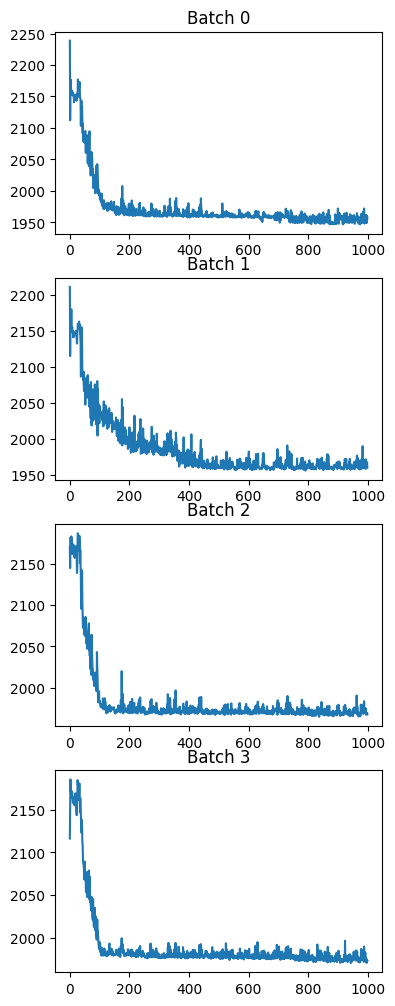

In [10]:
batch_plots(batch_loss_dict)

Done
tensor([[[ 1.3689e-02,  0.0000e+00,  0.0000e+00,  ...,  6.8496e-13,
          -1.0919e-04,  1.6963e-05],
         [ 1.2900e-01,  0.0000e+00,  0.0000e+00,  ..., -9.6557e-12,
           1.5392e-03, -2.3913e-04],
         [ 7.4789e-02,  0.0000e+00,  0.0000e+00,  ..., -1.5446e-11,
           2.4651e-03, -3.8252e-04],
         ...,
         [ 5.7447e-02,  0.0000e+00,  0.0000e+00,  ..., -4.2166e-08,
          -1.2254e-02,  1.7622e-10],
         [ 5.6427e-02,  0.0000e+00,  0.0000e+00,  ..., -2.9983e-09,
          -8.5345e-04,  1.2530e-11],
         [ 4.2290e-02,  0.0000e+00,  0.0000e+00,  ...,  1.7757e-09,
           5.0545e-04, -7.4212e-12]],

        [[ 6.9336e-02,  0.0000e+00,  9.3147e-01,  ..., -1.8460e-39,
           1.2067e-06,  2.3394e-35],
         [ 6.0425e-02,  0.0000e+00,  2.7735e-03,  ..., -3.4700e-37,
           2.2683e-04,  4.3974e-33],
         [ 1.3056e-01,  0.0000e+00, -1.0637e-02,  ..., -1.9263e-35,
           1.2600e-02,  2.4411e-31],
         ...,
         [ 5.6433e-0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



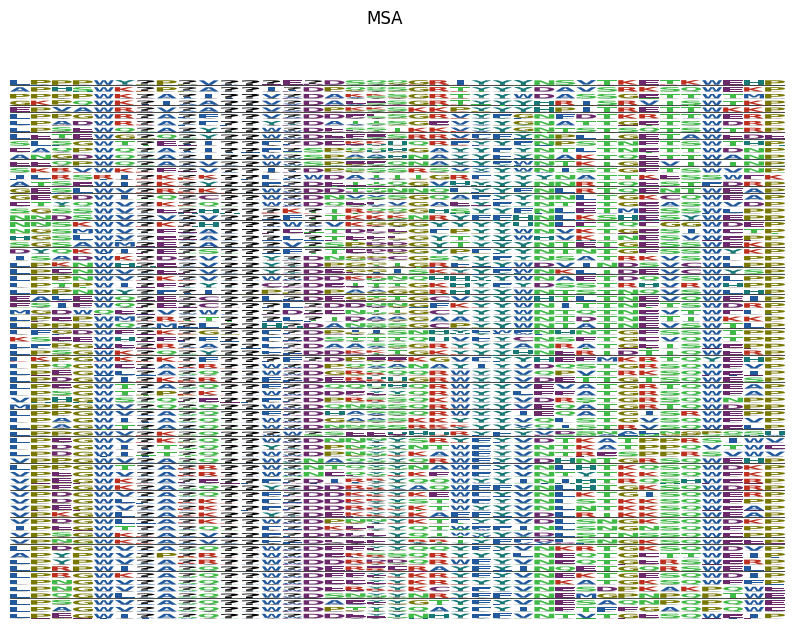

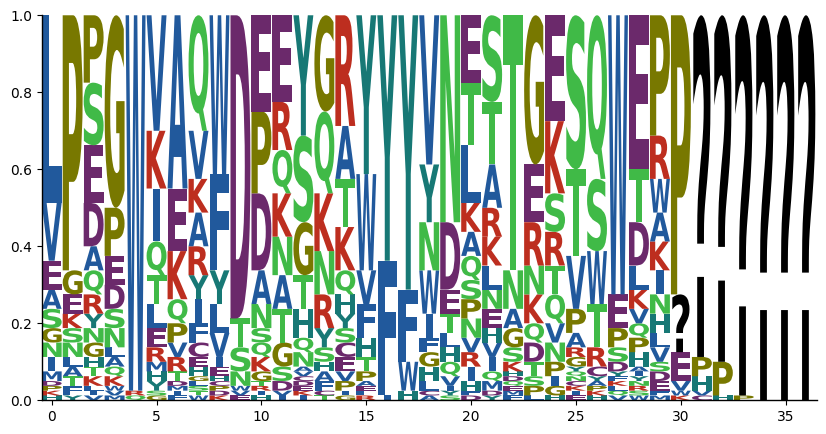

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



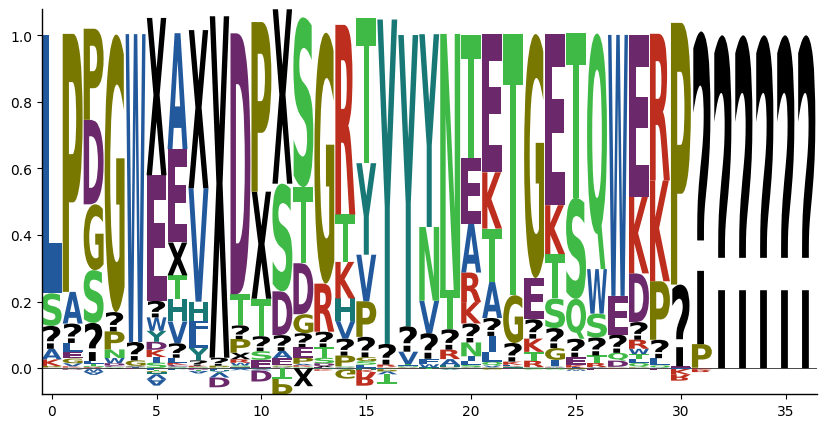

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



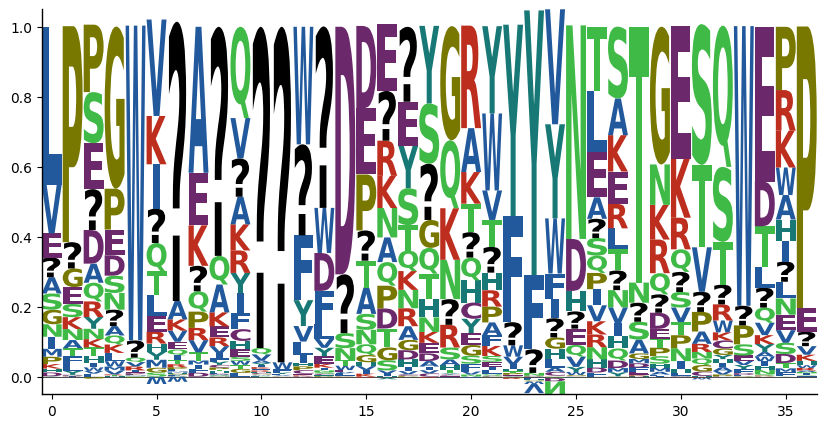

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



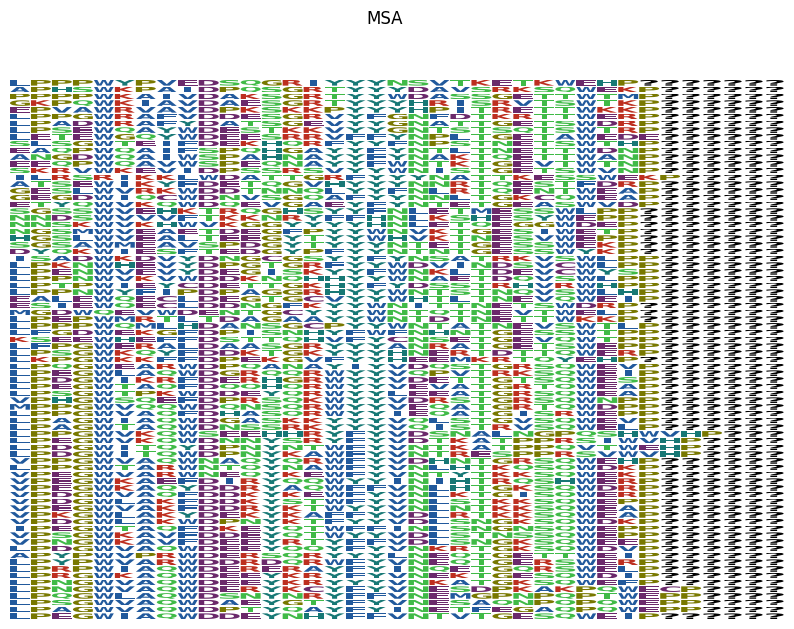

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

IndexError: index 5 is out of bounds for axis 1 with size 5

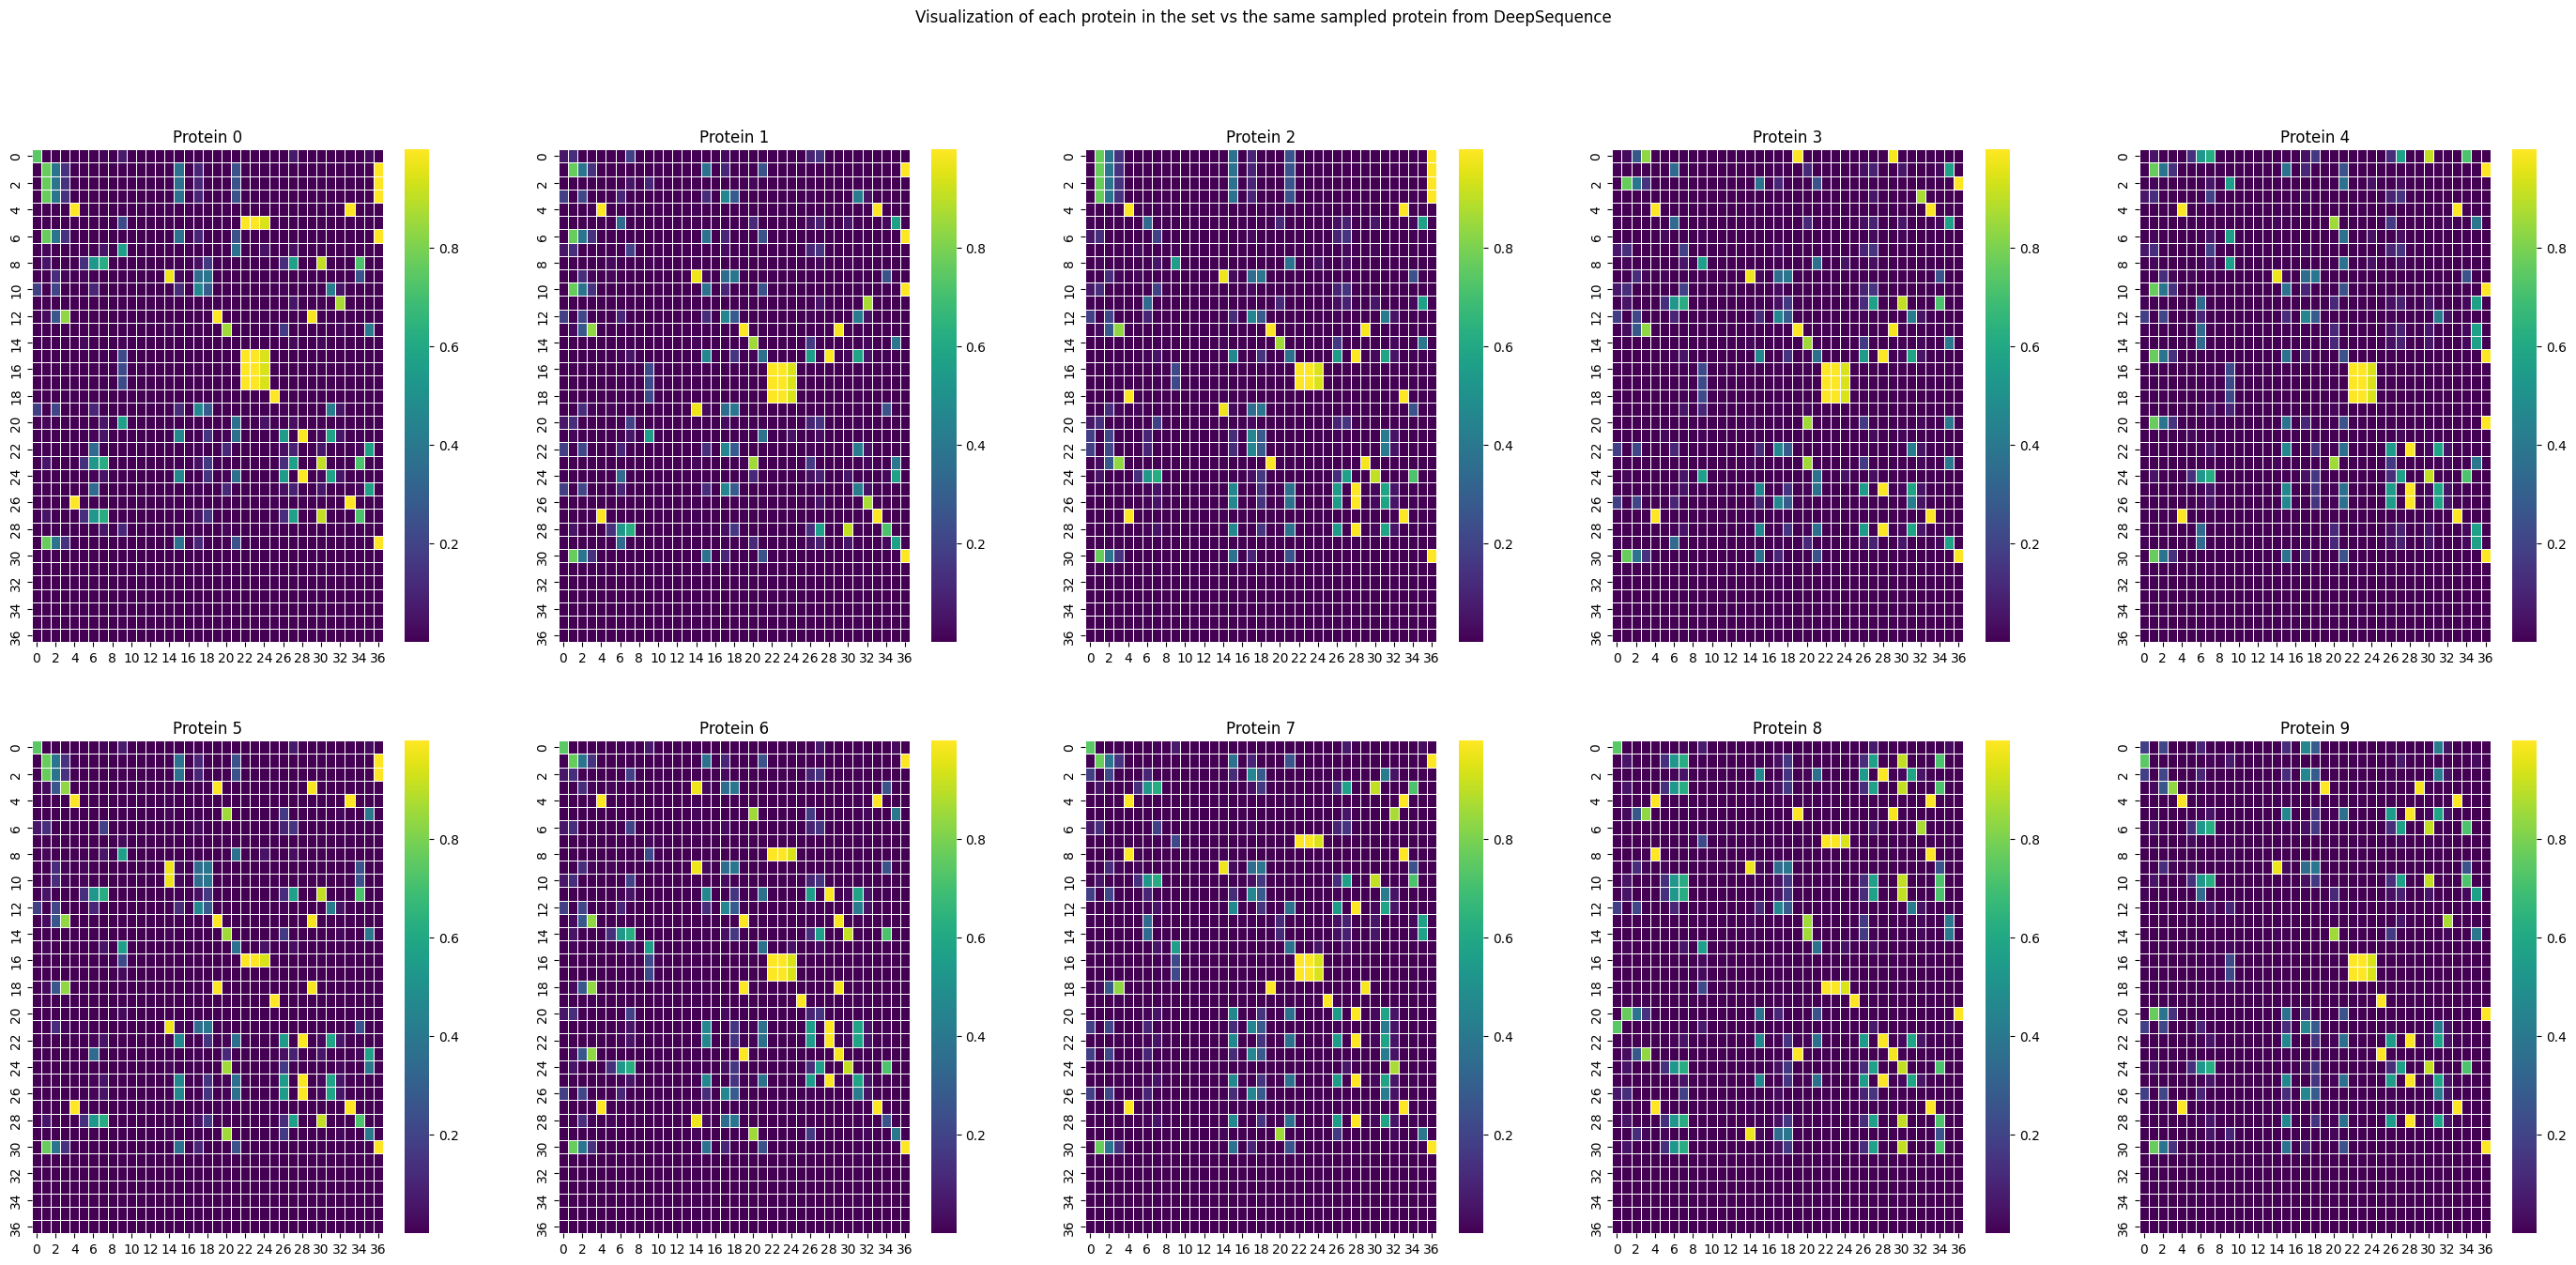

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):

    #import ipdb; ipdb.set_trace()
    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq.detach().cpu())
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.detach().cpu().numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq, dataset_msa.prot_space.detach())



In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()